## Initialize

In [1]:
import numpy as np
import gym
import tensorflow as tf
from tensorflow import keras


from numpy.random import default_rng
rng = default_rng()


### Initialize Display

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [3]:
#Render animation

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

##def save_animation

In [4]:
import matplotlib.pyplot as plt

def display_state():
    img = env.render(mode="rgb_array")

    plt.figure(figsize=(6, 8))
    plt.imshow(img)
    plt.axis("off")
    #save_fig("breakout_plot")
    plt.show()
    return

In [5]:

def display_run(policy =lambda x : 0):
    frames = []
    reward_buffer = []
    obs_buffer = []
    n_steps = 0
    obs = env.reset()
    
    #Only, when taking length of run into account  
    obs = np.concatenate((obs,np.array([0], dtype = np.float32)))
    
    frames.append( env.render(mode = "rgb_array"))
    done = False
    while done == False:
        obs, reward, done, info = env.step(policy(obs))
        
        #Only, when taking length of run into account  
        obs = np.concatenate((obs,np.array([(n_steps+1)/1000], dtype = np.float32)))
        
        frames.append(env.render(mode = "rgb_array"))
        reward_buffer += [reward]
        obs_buffer += [obs]
        n_steps += 1

    data = (reward_buffer, obs_buffer) 
    return plot_animation(frames), data

## Set up Environment

In [6]:
env = gym.make("LunarLander-v2")
obs = env.reset()

In [7]:
print( "Action space:      ", env.action_space)
print( "Observation Space: ", env.observation_space)
print( "Metadata:          ", env.metadata )

Action space:       Discrete(4)
Observation Space:  Box(-inf, inf, (8,), float32)
Metadata:           {'render_modes': ['human', 'rgb_array'], 'render_fps': 50}


## Some Testing

In [8]:
def random_policy(obs):
    return rng.integers(0,4)

In [9]:
(anim, data) = display_run(lambda x: 1)
print("Reward:", sum(data[0]), ",  Steps:", len(data[0]))
anim

Reward: -442.6163914715524 ,  Steps: 51


## Simple NN policy

In [10]:
n_inputs = env.observation_space.shape[0] # 8 for Lunar Lander

#Only when we want to include number of steps 
n_inputs += 1 # 8+1 for Lunar Lander


In [11]:
model = keras.models.Sequential([
    keras.layers.Dropout(0.1, input_shape = [n_inputs]),
    keras.layers.Dense(64, activation="elu"),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(64, activation="elu"),
    keras.layers.Dense(4),
])


Take a step based on the Neural Network policy

In [12]:
def NN_action(obs):
    qvals = model(obs[np.newaxis])
    return np.argmax(qvals)

#Random policy
def random_action(obs):
    return rng.integers(4)

Take a step based on the Neural Network following an epsilon-greedy policy

In [13]:
def epsilon_greedy(obs, epsilon):
    if rng.random()> epsilon:
        return NN_action(obs)
    else:
        return random_action(obs)

In [14]:
env.step(0)

(array([-0.38315362,  0.08215156,  0.36459804,  0.2043921 ,  2.8050272 ,
        -1.7260227 ,  0.        ,  0.        ], dtype=float32),
 -100,
 True,
 {})

Test

## Sampling and Updating 

Utilities to sample saved experiences from a replay buffer and to perform a training step based on them 

In [15]:
from collections import deque

In [16]:
replay_buffer = deque(maxlen= 10000)

In [17]:
def sample_experiences(batch_size):
    indices = rng.integers(len(replay_buffer), size = batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, dones, next_states = [
        np.array([experience[field_index] for experience in batch]) 
        for field_index in range(5)]
    return states, actions, rewards, dones, next_states

Take one step according to epsilon_greedy policy and store it in the replay buffer

In [18]:
def explore_one_step(obs, epsilon, step):
    action = epsilon_greedy(obs, epsilon)
    new_obs, reward, done, info = env.step(action)
    if step == 999:
        reward -=1000
    new_obs = np.concatenate((new_obs, np.array([(step+1)/1000], dtype = np.float32)))
    
    experience = (obs, action, reward, done, new_obs)
    replay_buffer.append(experience)
    return new_obs, reward, done, info

# def play_one_step(env, obs, epsilon):
#     with tf.GradientTape() as tape: # How does this work?
#         probabs = model(obs[np.newaxis])
#         probabs_64 = (probabs.numpy()).astype('float64')
#         probabs_64 = probabs_64 / np.sum(probabs_64)
#         action = np.argmax(rng.multinomial(1,probabs_64))
#         y_target = tf.one_hot( [action], 4, dtype = tf.float32)
#         loss = tf.reduce_mean(loss_fn(action, probabs[np.newaxis, :]))
#     grads = tape.gradient(loss, model.trainable_variables) #??
#     obs, reward, done, info = env.step(int(action))
#     return obs, reward, done, grads

Update the policy from collected Experiences

In [19]:
batch_size = 32
optimizer = keras.optimizers.Adam(learning_rate = 1e-4)
discount_rate = 1
loss_fn = keras.losses.mean_squared_error

def train_one_step(replay_buffer, batch_size, target):
    states, actions, rewards, dones, next_states = sample_experiences(batch_size)
    
    #create mask, target q values
    masks = tf.one_hot(actions, 4 ,axis = -1)
    next_Q_values = np.amax(target.predict(next_states), axis = -1)
    target_Q_values = rewards + (1 - dones) * discount_rate * next_Q_values #dimensions == (batch_size,)
    target_Q_values = target_Q_values.reshape(-1, 1)
    #Calculate and apply gradients
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * masks, axis = -1, keepdims = True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

## Training

In [20]:
n_episodes = 30000


In [21]:
#Not used right now
def collect_experiences(n_steps, obs, epsilon):
    for n in range(n_steps):
        explore_one_step(obs, epsilon)
    return obs

Training Loop

In [22]:

def train_model(starting_episode = 0):
    rewards = []
    target = keras.models.clone_model(model)
    target.set_weights(model.get_weights())
    
    for episode in range(starting_episode, n_episodes):
        
        obs = env.reset()
        obs = np.concatenate((obs, np.array([0], dtype = np.float32)))
        epsilon = max(1-episode/20000, 0.01)
        display = (episode % 10 == 0) # Animate every 10th episode
        total_reward = 0
        
        for step in range(1000): #1000 for lunar lander
            obs, reward, done, info = explore_one_step(obs, epsilon, step)
            total_reward += reward
            if done:
                break
        print("Episode:", episode)
        print("Length:", step +1,", Epsilon: ", epsilon,", Total reward:", total_reward)
        rewards += [total_reward]
        
        if episode + 1 % 1000 == 0:
            target.set_weights(model.get_weights())
        if episode > 50:
            train_one_step(replay_buffer, batch_size, target)
    return rewards

In [23]:
rewards = train_model()

Episode: 0
Length: 76 , Epsilon:  1.0 , Total reward: -123.60574098623636
Episode: 1
Length: 105 , Epsilon:  0.99995 , Total reward: -117.48092578451431
Episode: 2
Length: 73 , Epsilon:  0.9999 , Total reward: -75.29651466108835
Episode: 3
Length: 83 , Epsilon:  0.99985 , Total reward: -199.89370084770636
Episode: 4
Length: 77 , Epsilon:  0.9998 , Total reward: -248.96717761184817
Episode: 5
Length: 113 , Epsilon:  0.99975 , Total reward: -254.63592342373735
Episode: 6
Length: 89 , Epsilon:  0.9997 , Total reward: -137.05009985671506
Episode: 7
Length: 91 , Epsilon:  0.99965 , Total reward: -112.08705058144028
Episode: 8
Length: 101 , Epsilon:  0.9996 , Total reward: -128.75381735126723
Episode: 9
Length: 73 , Epsilon:  0.99955 , Total reward: -86.14671264953023
Episode: 10
Length: 103 , Epsilon:  0.9995 , Total reward: -118.26066517060917
Episode: 11
Length: 74 , Epsilon:  0.99945 , Total reward: -195.25502577095267
Episode: 12
Length: 81 , Epsilon:  0.9994 , Total reward: -323.544328

1/1 [==============================] - 0s 20ms/step
Episode: 84
Length: 71 , Epsilon:  0.9958 , Total reward: -171.44003871346638
1/1 [==============================] - 0s 18ms/step
Episode: 85
Length: 78 , Epsilon:  0.99575 , Total reward: 9.64050076068466
1/1 [==============================] - 0s 24ms/step
Episode: 86
Length: 63 , Epsilon:  0.9957 , Total reward: -172.8080684303195
1/1 [==============================] - 0s 19ms/step
Episode: 87
Length: 86 , Epsilon:  0.99565 , Total reward: -113.66063011846563
1/1 [==============================] - 0s 26ms/step
Episode: 88
Length: 92 , Epsilon:  0.9956 , Total reward: -186.34779530251336
1/1 [==============================] - 0s 21ms/step
Episode: 89
Length: 118 , Epsilon:  0.99555 , Total reward: -168.59718201358504
1/1 [==============================] - 0s 23ms/step
Episode: 90
Length: 96 , Epsilon:  0.9955 , Total reward: -411.187596944266
1/1 [==============================] - 0s 28ms/step
Episode: 91
Length: 74 , Epsilon:  0.995

1/1 [==============================] - 0s 18ms/step
Episode: 147
Length: 83 , Epsilon:  0.99265 , Total reward: -118.55336211586607
1/1 [==============================] - 0s 20ms/step
Episode: 148
Length: 95 , Epsilon:  0.9926 , Total reward: -86.58429593020917
1/1 [==============================] - 0s 20ms/step
Episode: 149
Length: 99 , Epsilon:  0.99255 , Total reward: -321.8644592840053
1/1 [==============================] - 0s 18ms/step
Episode: 150
Length: 121 , Epsilon:  0.9925 , Total reward: -133.74813819175677
1/1 [==============================] - 0s 28ms/step
Episode: 151
Length: 102 , Epsilon:  0.99245 , Total reward: -244.19385758911005
1/1 [==============================] - 0s 19ms/step
Episode: 152
Length: 63 , Epsilon:  0.9924 , Total reward: -114.36418245796608
1/1 [==============================] - 0s 19ms/step
Episode: 153
Length: 87 , Epsilon:  0.99235 , Total reward: -272.71317641420677
1/1 [==============================] - 0s 20ms/step
Episode: 154
Length: 102 , 

1/1 [==============================] - 0s 41ms/step
Episode: 210
Length: 106 , Epsilon:  0.9895 , Total reward: -442.5927725377979
1/1 [==============================] - 0s 42ms/step
Episode: 211
Length: 102 , Epsilon:  0.98945 , Total reward: -106.29802078634472
1/1 [==============================] - 0s 25ms/step
Episode: 212
Length: 85 , Epsilon:  0.9894 , Total reward: -161.19769009362955
1/1 [==============================] - 0s 21ms/step
Episode: 213
Length: 88 , Epsilon:  0.98935 , Total reward: -408.1301718964913
1/1 [==============================] - 0s 31ms/step
Episode: 214
Length: 130 , Epsilon:  0.9893 , Total reward: -8.850262989024245
1/1 [==============================] - 0s 29ms/step
Episode: 215
Length: 78 , Epsilon:  0.98925 , Total reward: -236.33392208756064
1/1 [==============================] - 0s 21ms/step
Episode: 216
Length: 118 , Epsilon:  0.9892 , Total reward: -273.6125651220673
1/1 [==============================] - 0s 20ms/step
Episode: 217
Length: 112 , E

Episode: 272
Length: 68 , Epsilon:  0.9864 , Total reward: -118.05045445467366
1/1 [==============================] - 0s 18ms/step
Episode: 273
Length: 69 , Epsilon:  0.98635 , Total reward: -93.60116170490073
1/1 [==============================] - 0s 22ms/step
Episode: 274
Length: 102 , Epsilon:  0.9863 , Total reward: -61.219799792454
1/1 [==============================] - 0s 19ms/step
Episode: 275
Length: 89 , Epsilon:  0.98625 , Total reward: -238.27660047629107
1/1 [==============================] - 0s 19ms/step
Episode: 276
Length: 84 , Epsilon:  0.9862 , Total reward: -156.1501630073269
1/1 [==============================] - 0s 20ms/step
Episode: 277
Length: 72 , Epsilon:  0.98615 , Total reward: -84.33010880155365
1/1 [==============================] - 0s 19ms/step
Episode: 278
Length: 69 , Epsilon:  0.9861 , Total reward: -90.71166931662286
1/1 [==============================] - 0s 18ms/step
Episode: 279
Length: 95 , Epsilon:  0.98605 , Total reward: -366.1685169412925
1/1 [==

1/1 [==============================] - 0s 33ms/step
Episode: 335
Length: 81 , Epsilon:  0.98325 , Total reward: -114.66767026121697
1/1 [==============================] - 0s 25ms/step
Episode: 336
Length: 79 , Epsilon:  0.9832 , Total reward: -243.69285153550553
1/1 [==============================] - 0s 27ms/step
Episode: 337
Length: 115 , Epsilon:  0.98315 , Total reward: -143.47005571415275
1/1 [==============================] - 0s 26ms/step
Episode: 338
Length: 61 , Epsilon:  0.9831 , Total reward: -133.38512405975058
1/1 [==============================] - 0s 29ms/step
Episode: 339
Length: 100 , Epsilon:  0.98305 , Total reward: -355.29134714504085
1/1 [==============================] - 0s 27ms/step
Episode: 340
Length: 75 , Epsilon:  0.983 , Total reward: -321.16437506213214
1/1 [==============================] - 0s 26ms/step
Episode: 341
Length: 109 , Epsilon:  0.98295 , Total reward: -200.90261313474292
1/1 [==============================] - 0s 28ms/step
Episode: 342
Length: 67 ,

1/1 [==============================] - 0s 25ms/step
Episode: 397
Length: 110 , Epsilon:  0.98015 , Total reward: -110.56058470416649
1/1 [==============================] - 0s 25ms/step
Episode: 398
Length: 91 , Epsilon:  0.9801 , Total reward: -177.721265678668
1/1 [==============================] - 0s 26ms/step
Episode: 399
Length: 99 , Epsilon:  0.98005 , Total reward: -207.74918357154002
1/1 [==============================] - 0s 28ms/step
Episode: 400
Length: 104 , Epsilon:  0.98 , Total reward: -355.838079261093
1/1 [==============================] - 0s 27ms/step
Episode: 401
Length: 113 , Epsilon:  0.97995 , Total reward: -108.15173735638244
1/1 [==============================] - 0s 26ms/step
Episode: 402
Length: 90 , Epsilon:  0.9799 , Total reward: -108.71600477249858
1/1 [==============================] - 0s 20ms/step
Episode: 403
Length: 92 , Epsilon:  0.97985 , Total reward: -117.50167716009292
1/1 [==============================] - 0s 22ms/step
Episode: 404
Length: 138 , Eps

1/1 [==============================] - 0s 29ms/step
Episode: 459
Length: 77 , Epsilon:  0.97705 , Total reward: -150.94587227870238
1/1 [==============================] - 0s 23ms/step
Episode: 460
Length: 78 , Epsilon:  0.977 , Total reward: -88.89395948747753
1/1 [==============================] - 0s 21ms/step
Episode: 461
Length: 109 , Epsilon:  0.97695 , Total reward: -223.6076464458037
1/1 [==============================] - 0s 26ms/step
Episode: 462
Length: 99 , Epsilon:  0.9769 , Total reward: -294.0432986722666
1/1 [==============================] - 0s 25ms/step
Episode: 463
Length: 77 , Epsilon:  0.97685 , Total reward: -85.78794667454113
1/1 [==============================] - 0s 20ms/step
Episode: 464
Length: 68 , Epsilon:  0.9768 , Total reward: -68.76032009580427
1/1 [==============================] - 0s 21ms/step
Episode: 465
Length: 100 , Epsilon:  0.97675 , Total reward: -79.25335648987048
1/1 [==============================] - 0s 19ms/step
Episode: 466
Length: 81 , Epsilo

1/1 [==============================] - 0s 28ms/step
Episode: 521
Length: 107 , Epsilon:  0.97395 , Total reward: -148.7893135230559
1/1 [==============================] - 0s 25ms/step
Episode: 522
Length: 92 , Epsilon:  0.9739 , Total reward: -378.7502024688793
1/1 [==============================] - 0s 25ms/step
Episode: 523
Length: 104 , Epsilon:  0.97385 , Total reward: -258.596546419417
1/1 [==============================] - 0s 23ms/step
Episode: 524
Length: 130 , Epsilon:  0.9738 , Total reward: -113.1307201800233
1/1 [==============================] - 0s 86ms/step
Episode: 525
Length: 79 , Epsilon:  0.97375 , Total reward: -93.26568571927962
1/1 [==============================] - 0s 20ms/step
Episode: 526
Length: 73 , Epsilon:  0.9737 , Total reward: -193.00800671578213
1/1 [==============================] - 0s 20ms/step
Episode: 527
Length: 128 , Epsilon:  0.97365 , Total reward: -165.00681119970398
1/1 [==============================] - 0s 21ms/step
Episode: 528
Length: 109 , Ep

1/1 [==============================] - 0s 19ms/step
Episode: 584
Length: 76 , Epsilon:  0.9708 , Total reward: -203.65640601502525
1/1 [==============================] - 0s 22ms/step
Episode: 585
Length: 125 , Epsilon:  0.97075 , Total reward: -217.41441180472967
1/1 [==============================] - 0s 18ms/step
Episode: 586
Length: 113 , Epsilon:  0.9707 , Total reward: -121.81993400935637
1/1 [==============================] - 0s 20ms/step
Episode: 587
Length: 109 , Epsilon:  0.97065 , Total reward: -186.30539905753358
1/1 [==============================] - 0s 20ms/step
Episode: 588
Length: 103 , Epsilon:  0.9706 , Total reward: -103.60118745909737
1/1 [==============================] - 0s 21ms/step
Episode: 589
Length: 73 , Epsilon:  0.97055 , Total reward: -121.40295400630023
1/1 [==============================] - 0s 21ms/step
Episode: 590
Length: 97 , Epsilon:  0.9705 , Total reward: -298.8872729786665
1/1 [==============================] - 0s 24ms/step
Episode: 591
Length: 89 ,

1/1 [==============================] - 0s 20ms/step
Episode: 646
Length: 75 , Epsilon:  0.9677 , Total reward: -123.39824287131769
1/1 [==============================] - 0s 20ms/step
Episode: 647
Length: 103 , Epsilon:  0.96765 , Total reward: -478.7478802438163
1/1 [==============================] - 0s 19ms/step
Episode: 648
Length: 152 , Epsilon:  0.9676 , Total reward: 5.756296465843988
1/1 [==============================] - 0s 20ms/step
Episode: 649
Length: 106 , Epsilon:  0.96755 , Total reward: -278.3771113490898
1/1 [==============================] - 0s 18ms/step
Episode: 650
Length: 126 , Epsilon:  0.9675 , Total reward: -320.9274951084381
1/1 [==============================] - 0s 17ms/step
Episode: 651
Length: 71 , Epsilon:  0.96745 , Total reward: -106.04878928870589
1/1 [==============================] - 0s 22ms/step
Episode: 652
Length: 86 , Epsilon:  0.9674 , Total reward: -121.5682980837162
1/1 [==============================] - 0s 22ms/step
Episode: 653
Length: 141 , Eps

1/1 [==============================] - 0s 19ms/step
Episode: 708
Length: 86 , Epsilon:  0.9646 , Total reward: -220.3559067282675
1/1 [==============================] - 0s 20ms/step
Episode: 709
Length: 78 , Epsilon:  0.96455 , Total reward: -26.647111796077155
1/1 [==============================] - 0s 20ms/step
Episode: 710
Length: 111 , Epsilon:  0.9645 , Total reward: 17.37907009941965
1/1 [==============================] - 0s 22ms/step
Episode: 711
Length: 91 , Epsilon:  0.96445 , Total reward: -61.88536542336246
1/1 [==============================] - 0s 21ms/step
Episode: 712
Length: 93 , Epsilon:  0.9644 , Total reward: -271.46078092055507
1/1 [==============================] - 0s 17ms/step
Episode: 713
Length: 82 , Epsilon:  0.96435 , Total reward: -330.55562628426225
1/1 [==============================] - 0s 22ms/step
Episode: 714
Length: 61 , Epsilon:  0.9643 , Total reward: -72.2336111308177
1/1 [==============================] - 0s 19ms/step
Episode: 715
Length: 88 , Epsilon

1/1 [==============================] - 0s 25ms/step
Episode: 770
Length: 100 , Epsilon:  0.9615 , Total reward: -231.3066807677457
1/1 [==============================] - 0s 25ms/step
Episode: 771
Length: 110 , Epsilon:  0.96145 , Total reward: -97.10826752945407
1/1 [==============================] - 0s 25ms/step
Episode: 772
Length: 96 , Epsilon:  0.9614 , Total reward: -125.77846412724567
1/1 [==============================] - 0s 20ms/step
Episode: 773
Length: 97 , Epsilon:  0.96135 , Total reward: -392.8756769263351
1/1 [==============================] - 0s 21ms/step
Episode: 774
Length: 72 , Epsilon:  0.9613 , Total reward: -113.04179280278431
1/1 [==============================] - 0s 27ms/step
Episode: 775
Length: 122 , Epsilon:  0.96125 , Total reward: -15.187056304866815
1/1 [==============================] - 0s 21ms/step
Episode: 776
Length: 93 , Epsilon:  0.9612 , Total reward: -360.4232566979571
1/1 [==============================] - 0s 21ms/step
Episode: 777
Length: 82 , Eps

1/1 [==============================] - 0s 23ms/step
Episode: 832
Length: 101 , Epsilon:  0.9584 , Total reward: -228.4403171033515
1/1 [==============================] - 0s 26ms/step
Episode: 833
Length: 175 , Epsilon:  0.95835 , Total reward: 19.79412752699814
1/1 [==============================] - 0s 24ms/step
Episode: 834
Length: 118 , Epsilon:  0.9583 , Total reward: -301.7883099712213
1/1 [==============================] - 0s 22ms/step
Episode: 835
Length: 81 , Epsilon:  0.95825 , Total reward: -498.52044137586154
1/1 [==============================] - 0s 26ms/step
Episode: 836
Length: 119 , Epsilon:  0.9582 , Total reward: -151.86154421737086
1/1 [==============================] - 0s 19ms/step
Episode: 837
Length: 101 , Epsilon:  0.9581500000000001 , Total reward: -141.5585217705235
1/1 [==============================] - 0s 19ms/step
Episode: 838
Length: 69 , Epsilon:  0.9581 , Total reward: -92.70507999843657
1/1 [==============================] - 0s 19ms/step
Episode: 839
Lengt

Episode: 894
Length: 102 , Epsilon:  0.9553 , Total reward: -233.42555051649305
1/1 [==============================] - 0s 24ms/step
Episode: 895
Length: 72 , Epsilon:  0.95525 , Total reward: -106.22221378618025
1/1 [==============================] - 0s 23ms/step
Episode: 896
Length: 117 , Epsilon:  0.9552 , Total reward: -135.359180730121
1/1 [==============================] - 0s 17ms/step
Episode: 897
Length: 113 , Epsilon:  0.9551499999999999 , Total reward: -165.37004532931445
1/1 [==============================] - 0s 17ms/step
Episode: 898
Length: 126 , Epsilon:  0.9551 , Total reward: -54.863052232667414
1/1 [==============================] - 0s 24ms/step
Episode: 899
Length: 78 , Epsilon:  0.95505 , Total reward: -82.69484688704294
1/1 [==============================] - 0s 19ms/step
Episode: 900
Length: 108 , Epsilon:  0.955 , Total reward: -135.9190549589649
1/1 [==============================] - 0s 21ms/step
Episode: 901
Length: 83 , Epsilon:  0.95495 , Total reward: -71.87902

1/1 [==============================] - 0s 19ms/step
Episode: 957
Length: 81 , Epsilon:  0.95215 , Total reward: -345.30637248014824
1/1 [==============================] - 0s 19ms/step
Episode: 958
Length: 90 , Epsilon:  0.9521 , Total reward: -453.209387600689
1/1 [==============================] - 0s 21ms/step
Episode: 959
Length: 90 , Epsilon:  0.95205 , Total reward: -219.0696993600648
1/1 [==============================] - 0s 18ms/step
Episode: 960
Length: 88 , Epsilon:  0.952 , Total reward: -357.89349583850924
1/1 [==============================] - 0s 21ms/step
Episode: 961
Length: 125 , Epsilon:  0.95195 , Total reward: -183.59308179100054
1/1 [==============================] - 0s 22ms/step
Episode: 962
Length: 140 , Epsilon:  0.9519 , Total reward: -124.51998711436586
1/1 [==============================] - 0s 19ms/step
Episode: 963
Length: 130 , Epsilon:  0.95185 , Total reward: -351.868335198076
1/1 [==============================] - 0s 20ms/step
Episode: 964
Length: 63 , Epsi

1/1 [==============================] - 0s 19ms/step
Episode: 1019
Length: 144 , Epsilon:  0.94905 , Total reward: -61.77599989225749
1/1 [==============================] - 0s 21ms/step
Episode: 1020
Length: 106 , Epsilon:  0.949 , Total reward: -325.2719627932538
1/1 [==============================] - 0s 21ms/step
Episode: 1021
Length: 71 , Epsilon:  0.94895 , Total reward: -75.66767023779961
1/1 [==============================] - 0s 22ms/step
Episode: 1022
Length: 144 , Epsilon:  0.9489 , Total reward: -326.7679956041718
1/1 [==============================] - 0s 21ms/step
Episode: 1023
Length: 88 , Epsilon:  0.94885 , Total reward: -104.1762822762275
1/1 [==============================] - 0s 19ms/step
Episode: 1024
Length: 116 , Epsilon:  0.9488 , Total reward: -121.97038116807643
1/1 [==============================] - 0s 21ms/step
Episode: 1025
Length: 71 , Epsilon:  0.94875 , Total reward: -153.89893018290778
1/1 [==============================] - 0s 18ms/step
Episode: 1026
Length: 

1/1 [==============================] - 0s 23ms/step
Episode: 1081
Length: 92 , Epsilon:  0.94595 , Total reward: -383.99769021066857
1/1 [==============================] - 0s 29ms/step
Episode: 1082
Length: 119 , Epsilon:  0.9459 , Total reward: -190.35764223778105
1/1 [==============================] - 0s 25ms/step
Episode: 1083
Length: 77 , Epsilon:  0.94585 , Total reward: -21.70799129157021
1/1 [==============================] - 0s 25ms/step
Episode: 1084
Length: 116 , Epsilon:  0.9458 , Total reward: -146.30966265166612
1/1 [==============================] - 0s 25ms/step
Episode: 1085
Length: 93 , Epsilon:  0.94575 , Total reward: -269.630310808691
1/1 [==============================] - 0s 24ms/step
Episode: 1086
Length: 92 , Epsilon:  0.9457 , Total reward: -181.65443670420865
1/1 [==============================] - 0s 22ms/step
Episode: 1087
Length: 127 , Epsilon:  0.94565 , Total reward: -428.5545350415541
1/1 [==============================] - 0s 66ms/step
Episode: 1088
Length:

1/1 [==============================] - 0s 29ms/step
Episode: 1143
Length: 78 , Epsilon:  0.94285 , Total reward: -183.85286517139696
1/1 [==============================] - 0s 30ms/step
Episode: 1144
Length: 93 , Epsilon:  0.9428 , Total reward: -186.24058095350847
1/1 [==============================] - 0s 26ms/step
Episode: 1145
Length: 70 , Epsilon:  0.94275 , Total reward: -97.65484889975887
1/1 [==============================] - 0s 25ms/step
Episode: 1146
Length: 98 , Epsilon:  0.9427 , Total reward: -540.9159787208752
1/1 [==============================] - 0s 30ms/step
Episode: 1147
Length: 101 , Epsilon:  0.94265 , Total reward: -390.6400515601756
1/1 [==============================] - 0s 26ms/step
Episode: 1148
Length: 101 , Epsilon:  0.9426 , Total reward: -377.6387908492713
1/1 [==============================] - 0s 24ms/step
Episode: 1149
Length: 62 , Epsilon:  0.94255 , Total reward: -44.692291133576475
1/1 [==============================] - 0s 24ms/step
Episode: 1150
Length: 

1/1 [==============================] - 0s 25ms/step
Episode: 1205
Length: 65 , Epsilon:  0.93975 , Total reward: -128.2785538162255
1/1 [==============================] - 0s 17ms/step
Episode: 1206
Length: 99 , Epsilon:  0.9397 , Total reward: -123.33060378050303
1/1 [==============================] - 0s 19ms/step
Episode: 1207
Length: 125 , Epsilon:  0.93965 , Total reward: -94.60754233833623
1/1 [==============================] - 0s 18ms/step
Episode: 1208
Length: 73 , Epsilon:  0.9396 , Total reward: -213.06607288282152
1/1 [==============================] - 0s 20ms/step
Episode: 1209
Length: 130 , Epsilon:  0.93955 , Total reward: -312.7333352943298
1/1 [==============================] - 0s 26ms/step
Episode: 1210
Length: 118 , Epsilon:  0.9395 , Total reward: -105.35181085982887
1/1 [==============================] - 0s 24ms/step
Episode: 1211
Length: 94 , Epsilon:  0.93945 , Total reward: -332.68545659946915
1/1 [==============================] - 0s 24ms/step
Episode: 1212
Length

1/1 [==============================] - 0s 21ms/step
Episode: 1267
Length: 107 , Epsilon:  0.93665 , Total reward: -344.1647092175828
1/1 [==============================] - 0s 23ms/step
Episode: 1268
Length: 128 , Epsilon:  0.9366 , Total reward: -343.3307890856033
1/1 [==============================] - 0s 19ms/step
Episode: 1269
Length: 102 , Epsilon:  0.93655 , Total reward: -379.5212578215969
1/1 [==============================] - 0s 19ms/step
Episode: 1270
Length: 111 , Epsilon:  0.9365 , Total reward: -143.1831310646417
1/1 [==============================] - 0s 22ms/step
Episode: 1271
Length: 99 , Epsilon:  0.93645 , Total reward: -258.7597125912878
1/1 [==============================] - 0s 23ms/step
Episode: 1272
Length: 89 , Epsilon:  0.9364 , Total reward: -151.30899008336885
1/1 [==============================] - 0s 22ms/step
Episode: 1273
Length: 104 , Epsilon:  0.93635 , Total reward: -186.56487300944093
1/1 [==============================] - 0s 19ms/step
Episode: 1274
Length

1/1 [==============================] - 0s 20ms/step
Episode: 1329
Length: 85 , Epsilon:  0.93355 , Total reward: -42.540057613591415
1/1 [==============================] - 0s 45ms/step
Episode: 1330
Length: 88 , Epsilon:  0.9335 , Total reward: -99.01989870754727
1/1 [==============================] - 0s 22ms/step
Episode: 1331
Length: 113 , Epsilon:  0.93345 , Total reward: -327.8969749873581
1/1 [==============================] - 0s 22ms/step
Episode: 1332
Length: 103 , Epsilon:  0.9334 , Total reward: -249.53413992806458
1/1 [==============================] - 0s 19ms/step
Episode: 1333
Length: 118 , Epsilon:  0.93335 , Total reward: -415.4318622596568
1/1 [==============================] - 0s 22ms/step
Episode: 1334
Length: 165 , Epsilon:  0.9333 , Total reward: -230.9185752130624
1/1 [==============================] - 0s 20ms/step
Episode: 1335
Length: 156 , Epsilon:  0.93325 , Total reward: -129.82742305426797
1/1 [==============================] - 0s 22ms/step
Episode: 1336
Lengt

1/1 [==============================] - 0s 19ms/step
Episode: 1391
Length: 103 , Epsilon:  0.93045 , Total reward: -338.5027676789119
1/1 [==============================] - 0s 20ms/step
Episode: 1392
Length: 82 , Epsilon:  0.9304 , Total reward: -97.99454304844537
1/1 [==============================] - 0s 21ms/step
Episode: 1393
Length: 87 , Epsilon:  0.93035 , Total reward: -79.62836470859347
1/1 [==============================] - 0s 19ms/step
Episode: 1394
Length: 114 , Epsilon:  0.9303 , Total reward: -202.49588655363556
1/1 [==============================] - 0s 23ms/step
Episode: 1395
Length: 109 , Epsilon:  0.93025 , Total reward: -214.44401523171422
1/1 [==============================] - 0s 20ms/step
Episode: 1396
Length: 88 , Epsilon:  0.9302 , Total reward: -274.239368825712
1/1 [==============================] - 0s 19ms/step
Episode: 1397
Length: 57 , Epsilon:  0.93015 , Total reward: -123.34251118620799
1/1 [==============================] - 0s 20ms/step
Episode: 1398
Length: 

1/1 [==============================] - 0s 19ms/step
Episode: 1453
Length: 119 , Epsilon:  0.92735 , Total reward: -196.57158759725957
1/1 [==============================] - 0s 22ms/step
Episode: 1454
Length: 66 , Epsilon:  0.9273 , Total reward: -118.24109756225644
1/1 [==============================] - 0s 22ms/step
Episode: 1455
Length: 77 , Epsilon:  0.92725 , Total reward: -88.68564455048258
1/1 [==============================] - 0s 21ms/step
Episode: 1456
Length: 101 , Epsilon:  0.9272 , Total reward: -345.927124076528
1/1 [==============================] - 0s 19ms/step
Episode: 1457
Length: 108 , Epsilon:  0.92715 , Total reward: -464.96511875313706
1/1 [==============================] - 0s 24ms/step
Episode: 1458
Length: 94 , Epsilon:  0.9271 , Total reward: -415.1077729635554
1/1 [==============================] - 0s 27ms/step
Episode: 1459
Length: 144 , Epsilon:  0.92705 , Total reward: -150.91413624855218
1/1 [==============================] - 0s 20ms/step
Episode: 1460
Length

1/1 [==============================] - 0s 20ms/step
Episode: 1515
Length: 70 , Epsilon:  0.92425 , Total reward: -90.98668625164062
1/1 [==============================] - 0s 24ms/step
Episode: 1516
Length: 111 , Epsilon:  0.9242 , Total reward: -77.62876100912001
1/1 [==============================] - 0s 20ms/step
Episode: 1517
Length: 65 , Epsilon:  0.92415 , Total reward: -95.59491132951644
1/1 [==============================] - 0s 17ms/step
Episode: 1518
Length: 102 , Epsilon:  0.9241 , Total reward: -45.733914307407034
1/1 [==============================] - 0s 21ms/step
Episode: 1519
Length: 84 , Epsilon:  0.92405 , Total reward: -69.94619168521801
1/1 [==============================] - 0s 20ms/step
Episode: 1520
Length: 126 , Epsilon:  0.924 , Total reward: -257.6721015686676
1/1 [==============================] - 0s 27ms/step
Episode: 1521
Length: 93 , Epsilon:  0.92395 , Total reward: -160.77232429674405
1/1 [==============================] - 0s 19ms/step
Episode: 1522
Length: 8

1/1 [==============================] - 0s 18ms/step
Episode: 1577
Length: 75 , Epsilon:  0.92115 , Total reward: -306.0826206950851
1/1 [==============================] - 0s 18ms/step
Episode: 1578
Length: 1000 , Epsilon:  0.9211 , Total reward: -942.7043780163217
1/1 [==============================] - 0s 22ms/step
Episode: 1579
Length: 123 , Epsilon:  0.92105 , Total reward: -130.20797246815624
1/1 [==============================] - 0s 20ms/step
Episode: 1580
Length: 106 , Epsilon:  0.921 , Total reward: -321.1451679210063
1/1 [==============================] - 0s 24ms/step
Episode: 1581
Length: 100 , Epsilon:  0.92095 , Total reward: -222.94342220474402
1/1 [==============================] - 0s 25ms/step
Episode: 1582
Length: 91 , Epsilon:  0.9209 , Total reward: -386.9176424993677
1/1 [==============================] - 0s 37ms/step
Episode: 1583
Length: 94 , Epsilon:  0.92085 , Total reward: -183.3304326907811
1/1 [==============================] - 0s 24ms/step
Episode: 1584
Length:

1/1 [==============================] - 0s 20ms/step
Episode: 1639
Length: 118 , Epsilon:  0.91805 , Total reward: -178.59946768904953
1/1 [==============================] - 0s 18ms/step
Episode: 1640
Length: 101 , Epsilon:  0.918 , Total reward: -116.56326557532816
1/1 [==============================] - 0s 19ms/step
Episode: 1641
Length: 101 , Epsilon:  0.91795 , Total reward: -21.63223428136226
1/1 [==============================] - 0s 20ms/step
Episode: 1642
Length: 87 , Epsilon:  0.9178999999999999 , Total reward: -118.9860476969077
1/1 [==============================] - 0s 17ms/step
Episode: 1643
Length: 117 , Epsilon:  0.91785 , Total reward: -186.03821734852704
1/1 [==============================] - 0s 19ms/step
Episode: 1644
Length: 102 , Epsilon:  0.9178 , Total reward: -137.1325869108773
1/1 [==============================] - 0s 24ms/step
Episode: 1645
Length: 81 , Epsilon:  0.91775 , Total reward: -92.25511779757743
1/1 [==============================] - 0s 17ms/step
Episode:

1/1 [==============================] - 0s 20ms/step
Episode: 1701
Length: 120 , Epsilon:  0.91495 , Total reward: -82.28395098969233
1/1 [==============================] - 0s 21ms/step
Episode: 1702
Length: 122 , Epsilon:  0.9149 , Total reward: -88.61598890265654
1/1 [==============================] - 0s 18ms/step
Episode: 1703
Length: 103 , Epsilon:  0.9148499999999999 , Total reward: -368.9322188434372
1/1 [==============================] - 0s 18ms/step
Episode: 1704
Length: 72 , Epsilon:  0.9148000000000001 , Total reward: -58.15365842991679
1/1 [==============================] - 0s 20ms/step
Episode: 1705
Length: 68 , Epsilon:  0.91475 , Total reward: -64.33099942235545
1/1 [==============================] - 0s 19ms/step
Episode: 1706
Length: 91 , Epsilon:  0.9147 , Total reward: -327.7943238474768
1/1 [==============================] - 0s 19ms/step
Episode: 1707
Length: 117 , Epsilon:  0.91465 , Total reward: -106.21977533255223
1/1 [==============================] - 0s 41ms/step

Episode: 1762
Length: 118 , Epsilon:  0.9119 , Total reward: -151.38921422346613
1/1 [==============================] - 0s 23ms/step
Episode: 1763
Length: 116 , Epsilon:  0.91185 , Total reward: -107.17822498308264
1/1 [==============================] - 0s 22ms/step
Episode: 1764
Length: 82 , Epsilon:  0.9117999999999999 , Total reward: -396.09411392497475
1/1 [==============================] - 0s 21ms/step
Episode: 1765
Length: 118 , Epsilon:  0.9117500000000001 , Total reward: -184.7392827049963
1/1 [==============================] - 0s 23ms/step
Episode: 1766
Length: 125 , Epsilon:  0.9117 , Total reward: -100.88201670198069
1/1 [==============================] - 0s 25ms/step
Episode: 1767
Length: 133 , Epsilon:  0.91165 , Total reward: -41.95327666522937
1/1 [==============================] - 0s 20ms/step
Episode: 1768
Length: 82 , Epsilon:  0.9116 , Total reward: -194.61739465188998
1/1 [==============================] - 0s 18ms/step
Episode: 1769
Length: 120 , Epsilon:  0.91155 ,

1/1 [==============================] - 0s 28ms/step
Episode: 1824
Length: 105 , Epsilon:  0.9088 , Total reward: -7.455426449866181
1/1 [==============================] - 0s 25ms/step
Episode: 1825
Length: 67 , Epsilon:  0.90875 , Total reward: -55.640468748004096
1/1 [==============================] - 0s 25ms/step
Episode: 1826
Length: 70 , Epsilon:  0.9087 , Total reward: -118.50033657407229
1/1 [==============================] - 0s 25ms/step
Episode: 1827
Length: 82 , Epsilon:  0.90865 , Total reward: -208.32086347822508
1/1 [==============================] - 0s 23ms/step
Episode: 1828
Length: 82 , Epsilon:  0.9086 , Total reward: -390.3023693939205
1/1 [==============================] - 0s 26ms/step
Episode: 1829
Length: 140 , Epsilon:  0.90855 , Total reward: -109.39414204649606
1/1 [==============================] - 0s 22ms/step
Episode: 1830
Length: 75 , Epsilon:  0.9085 , Total reward: -85.22195353350872
1/1 [==============================] - 0s 21ms/step
Episode: 1831
Length: 

1/1 [==============================] - 0s 24ms/step
Episode: 1886
Length: 95 , Epsilon:  0.9057 , Total reward: -362.6398991349437
1/1 [==============================] - 0s 26ms/step
Episode: 1887
Length: 130 , Epsilon:  0.90565 , Total reward: -282.2584529448221
1/1 [==============================] - 0s 22ms/step
Episode: 1888
Length: 107 , Epsilon:  0.9056 , Total reward: -340.83922738692354
1/1 [==============================] - 0s 28ms/step
Episode: 1889
Length: 105 , Epsilon:  0.90555 , Total reward: -107.11155106649015
1/1 [==============================] - 0s 32ms/step
Episode: 1890
Length: 75 , Epsilon:  0.9055 , Total reward: -90.46874005816565
1/1 [==============================] - 0s 25ms/step
Episode: 1891
Length: 87 , Epsilon:  0.90545 , Total reward: -110.75797025914544
1/1 [==============================] - 0s 27ms/step
Episode: 1892
Length: 119 , Epsilon:  0.9054 , Total reward: -340.8245210632044
1/1 [==============================] - 0s 29ms/step
Episode: 1893
Length:

1/1 [==============================] - 0s 29ms/step
Episode: 1948
Length: 97 , Epsilon:  0.9026 , Total reward: -208.60972490606582
1/1 [==============================] - 0s 26ms/step
Episode: 1949
Length: 74 , Epsilon:  0.90255 , Total reward: -73.39538724970288
1/1 [==============================] - 0s 24ms/step
Episode: 1950
Length: 164 , Epsilon:  0.9025 , Total reward: -395.0911822399452
1/1 [==============================] - 0s 24ms/step
Episode: 1951
Length: 76 , Epsilon:  0.90245 , Total reward: -327.47990637588487
1/1 [==============================] - 0s 26ms/step
Episode: 1952
Length: 89 , Epsilon:  0.9024 , Total reward: -280.96185909462366
1/1 [==============================] - 0s 25ms/step
Episode: 1953
Length: 112 , Epsilon:  0.90235 , Total reward: -222.76602724362382
1/1 [==============================] - 0s 24ms/step
Episode: 1954
Length: 134 , Epsilon:  0.9023 , Total reward: -236.68030826742063
1/1 [==============================] - 0s 47ms/step
Episode: 1955
Length

1/1 [==============================] - 0s 45ms/step
Episode: 2010
Length: 116 , Epsilon:  0.8995 , Total reward: -97.69279585131791
1/1 [==============================] - 0s 27ms/step
Episode: 2011
Length: 147 , Epsilon:  0.89945 , Total reward: -179.13140186519624
1/1 [==============================] - 0s 20ms/step
Episode: 2012
Length: 143 , Epsilon:  0.8994 , Total reward: -239.3420938344143
1/1 [==============================] - 0s 22ms/step
Episode: 2013
Length: 131 , Epsilon:  0.89935 , Total reward: -80.58176125254441
1/1 [==============================] - 0s 29ms/step
Episode: 2014
Length: 114 , Epsilon:  0.8993 , Total reward: -274.2156696862536
1/1 [==============================] - 0s 24ms/step
Episode: 2015
Length: 93 , Epsilon:  0.89925 , Total reward: -79.41958729424636
1/1 [==============================] - 0s 21ms/step
Episode: 2016
Length: 111 , Epsilon:  0.8992 , Total reward: -508.83606381710877
1/1 [==============================] - 0s 28ms/step
Episode: 2017
Length

1/1 [==============================] - 0s 19ms/step
Episode: 2072
Length: 133 , Epsilon:  0.8964 , Total reward: -94.40579379407528
1/1 [==============================] - 0s 19ms/step
Episode: 2073
Length: 105 , Epsilon:  0.89635 , Total reward: -151.2564761873349
1/1 [==============================] - 0s 25ms/step
Episode: 2074
Length: 86 , Epsilon:  0.8963 , Total reward: -21.468452727316006
1/1 [==============================] - 0s 19ms/step
Episode: 2075
Length: 77 , Epsilon:  0.89625 , Total reward: -173.84408408050473
1/1 [==============================] - 0s 20ms/step
Episode: 2076
Length: 95 , Epsilon:  0.8962 , Total reward: -361.7795258499198
1/1 [==============================] - 0s 27ms/step
Episode: 2077
Length: 131 , Epsilon:  0.89615 , Total reward: -265.81149869273247
1/1 [==============================] - 0s 22ms/step
Episode: 2078
Length: 129 , Epsilon:  0.8961 , Total reward: -347.6070524048966
1/1 [==============================] - 0s 21ms/step
Episode: 2079
Length:

1/1 [==============================] - 0s 22ms/step
Episode: 2134
Length: 62 , Epsilon:  0.8933 , Total reward: -73.61328157857149
1/1 [==============================] - 0s 18ms/step
Episode: 2135
Length: 91 , Epsilon:  0.89325 , Total reward: -73.84236428763921
1/1 [==============================] - 0s 18ms/step
Episode: 2136
Length: 64 , Epsilon:  0.8932 , Total reward: -219.92846377085044
1/1 [==============================] - 0s 26ms/step
Episode: 2137
Length: 88 , Epsilon:  0.89315 , Total reward: -142.06999778337314
1/1 [==============================] - 0s 34ms/step
Episode: 2138
Length: 72 , Epsilon:  0.8931 , Total reward: -125.72126255550813
1/1 [==============================] - 0s 27ms/step
Episode: 2139
Length: 82 , Epsilon:  0.89305 , Total reward: -76.39547314004605
1/1 [==============================] - 0s 21ms/step
Episode: 2140
Length: 86 , Epsilon:  0.893 , Total reward: -55.1279239463877
1/1 [==============================] - 0s 28ms/step
Episode: 2141
Length: 103 ,

1/1 [==============================] - 0s 24ms/step
Episode: 2196
Length: 126 , Epsilon:  0.8902 , Total reward: -161.9046738902215
1/1 [==============================] - 0s 19ms/step
Episode: 2197
Length: 76 , Epsilon:  0.89015 , Total reward: -70.88279875821976
1/1 [==============================] - 0s 19ms/step
Episode: 2198
Length: 115 , Epsilon:  0.8901 , Total reward: -12.180943947062843
1/1 [==============================] - 0s 22ms/step
Episode: 2199
Length: 92 , Epsilon:  0.89005 , Total reward: -291.52903438370373
1/1 [==============================] - 0s 19ms/step
Episode: 2200
Length: 84 , Epsilon:  0.89 , Total reward: -299.2551582605802
1/1 [==============================] - 0s 18ms/step
Episode: 2201
Length: 104 , Epsilon:  0.88995 , Total reward: -352.94635908039277
1/1 [==============================] - 0s 24ms/step
Episode: 2202
Length: 73 , Epsilon:  0.8899 , Total reward: -143.36490115633939
1/1 [==============================] - 0s 25ms/step
Episode: 2203
Length: 1

1/1 [==============================] - 0s 19ms/step
Episode: 2258
Length: 64 , Epsilon:  0.8871 , Total reward: -197.5917658519096
1/1 [==============================] - 0s 26ms/step
Episode: 2259
Length: 122 , Epsilon:  0.88705 , Total reward: -293.9448520548242
1/1 [==============================] - 0s 22ms/step
Episode: 2260
Length: 72 , Epsilon:  0.887 , Total reward: -97.34069263058174
1/1 [==============================] - 0s 22ms/step
Episode: 2261
Length: 77 , Epsilon:  0.88695 , Total reward: -166.91755078317658
1/1 [==============================] - 0s 20ms/step
Episode: 2262
Length: 109 , Epsilon:  0.8869 , Total reward: -111.93724915068064
1/1 [==============================] - 0s 22ms/step
Episode: 2263
Length: 96 , Epsilon:  0.88685 , Total reward: -362.02675208655165
1/1 [==============================] - 0s 22ms/step
Episode: 2264
Length: 112 , Epsilon:  0.8868 , Total reward: -305.6897704383585
1/1 [==============================] - 0s 21ms/step
Episode: 2265
Length: 1

1/1 [==============================] - 0s 24ms/step
Episode: 2320
Length: 77 , Epsilon:  0.884 , Total reward: -99.46246717183273
1/1 [==============================] - 0s 26ms/step
Episode: 2321
Length: 102 , Epsilon:  0.88395 , Total reward: -235.78768101613713
1/1 [==============================] - 0s 22ms/step
Episode: 2322
Length: 73 , Epsilon:  0.8839 , Total reward: -225.33602615908808
1/1 [==============================] - 0s 24ms/step
Episode: 2323
Length: 84 , Epsilon:  0.88385 , Total reward: -120.92045131553834
1/1 [==============================] - 0s 21ms/step
Episode: 2324
Length: 106 , Epsilon:  0.8838 , Total reward: -133.9934175475662
1/1 [==============================] - 0s 24ms/step
Episode: 2325
Length: 114 , Epsilon:  0.88375 , Total reward: -297.7639368622903
1/1 [==============================] - 0s 23ms/step
Episode: 2326
Length: 92 , Epsilon:  0.8837 , Total reward: -401.6402333563639
1/1 [==============================] - 0s 20ms/step
Episode: 2327
Length: 1

1/1 [==============================] - 0s 21ms/step
Episode: 2382
Length: 122 , Epsilon:  0.8809 , Total reward: -261.29138304226035
1/1 [==============================] - 0s 18ms/step
Episode: 2383
Length: 101 , Epsilon:  0.88085 , Total reward: -28.639808959239957
1/1 [==============================] - 0s 19ms/step
Episode: 2384
Length: 80 , Epsilon:  0.8808 , Total reward: -224.0580712289403
1/1 [==============================] - 0s 18ms/step
Episode: 2385
Length: 110 , Epsilon:  0.88075 , Total reward: -239.4631045053755
1/1 [==============================] - 0s 24ms/step
Episode: 2386
Length: 70 , Epsilon:  0.8807 , Total reward: -98.41929264510776
1/1 [==============================] - 0s 26ms/step
Episode: 2387
Length: 112 , Epsilon:  0.88065 , Total reward: -198.0268152952998
1/1 [==============================] - 0s 19ms/step
Episode: 2388
Length: 83 , Epsilon:  0.8806 , Total reward: -65.72767360829178
1/1 [==============================] - 0s 28ms/step
Episode: 2389
Length: 

1/1 [==============================] - 0s 24ms/step
Episode: 2444
Length: 73 , Epsilon:  0.8778 , Total reward: -16.12281130464646
1/1 [==============================] - 0s 22ms/step
Episode: 2445
Length: 97 , Epsilon:  0.87775 , Total reward: -112.51021023768217
1/1 [==============================] - 0s 25ms/step
Episode: 2446
Length: 81 , Epsilon:  0.8777 , Total reward: -236.07432988073492
1/1 [==============================] - 0s 18ms/step
Episode: 2447
Length: 89 , Epsilon:  0.87765 , Total reward: -367.1253787030346
1/1 [==============================] - 0s 42ms/step
Episode: 2448
Length: 100 , Epsilon:  0.8776 , Total reward: -422.30861947684934
1/1 [==============================] - 0s 30ms/step
Episode: 2449
Length: 61 , Epsilon:  0.87755 , Total reward: -103.9351834811828
1/1 [==============================] - 0s 50ms/step
Episode: 2450
Length: 119 , Epsilon:  0.8775 , Total reward: -248.91879734714882
1/1 [==============================] - 0s 42ms/step
Episode: 2451
Length: 

1/1 [==============================] - 0s 21ms/step
Episode: 2506
Length: 127 , Epsilon:  0.8747 , Total reward: -31.377041620651156
1/1 [==============================] - 0s 27ms/step
Episode: 2507
Length: 85 , Epsilon:  0.87465 , Total reward: -323.08900590614655
1/1 [==============================] - 0s 23ms/step
Episode: 2508
Length: 96 , Epsilon:  0.8746 , Total reward: -77.73628002299219
1/1 [==============================] - 0s 31ms/step
Episode: 2509
Length: 104 , Epsilon:  0.8745499999999999 , Total reward: -125.83707819111515
1/1 [==============================] - 0s 19ms/step
Episode: 2510
Length: 93 , Epsilon:  0.8745 , Total reward: -91.19679854075957
1/1 [==============================] - 0s 21ms/step
Episode: 2511
Length: 124 , Epsilon:  0.87445 , Total reward: -292.0681077042352
1/1 [==============================] - 0s 22ms/step
Episode: 2512
Length: 70 , Epsilon:  0.8744000000000001 , Total reward: -217.06415148739302
1/1 [==============================] - 0s 21ms/ste

Episode: 2567
Length: 116 , Epsilon:  0.87165 , Total reward: -150.04826124539028
1/1 [==============================] - 0s 26ms/step
Episode: 2568
Length: 89 , Epsilon:  0.8716 , Total reward: -433.6367446065818
1/1 [==============================] - 0s 20ms/step
Episode: 2569
Length: 139 , Epsilon:  0.87155 , Total reward: -93.58874103833092
1/1 [==============================] - 0s 20ms/step
Episode: 2570
Length: 81 , Epsilon:  0.8714999999999999 , Total reward: -159.0396960965958
1/1 [==============================] - 0s 22ms/step
Episode: 2571
Length: 142 , Epsilon:  0.8714500000000001 , Total reward: -266.19056252970296
1/1 [==============================] - 0s 34ms/step
Episode: 2572
Length: 159 , Epsilon:  0.8714 , Total reward: -135.3993826231854
1/1 [==============================] - 0s 26ms/step
Episode: 2573
Length: 75 , Epsilon:  0.8713500000000001 , Total reward: -207.80983053528985
1/1 [==============================] - 0s 20ms/step
Episode: 2574
Length: 89 , Epsilon:  0

1/1 [==============================] - 0s 19ms/step
Episode: 2629
Length: 117 , Epsilon:  0.8685499999999999 , Total reward: -409.8096117550854
1/1 [==============================] - 0s 28ms/step
Episode: 2630
Length: 107 , Epsilon:  0.8685 , Total reward: -360.3303937258013
1/1 [==============================] - 0s 29ms/step
Episode: 2631
Length: 122 , Epsilon:  0.8684499999999999 , Total reward: -182.12124529068765
1/1 [==============================] - 0s 28ms/step
Episode: 2632
Length: 114 , Epsilon:  0.8684000000000001 , Total reward: -161.06707163602454
1/1 [==============================] - 0s 24ms/step
Episode: 2633
Length: 79 , Epsilon:  0.86835 , Total reward: -227.20684245033425
1/1 [==============================] - 0s 34ms/step
Episode: 2634
Length: 84 , Epsilon:  0.8683 , Total reward: -316.86911994224636
1/1 [==============================] - 0s 41ms/step
Episode: 2635
Length: 71 , Epsilon:  0.86825 , Total reward: -109.27982243071392
1/1 [==============================]

1/1 [==============================] - 0s 25ms/step
Episode: 2690
Length: 1000 , Epsilon:  0.8654999999999999 , Total reward: -958.0986832941271
1/1 [==============================] - 0s 478ms/step
Episode: 2691
Length: 103 , Epsilon:  0.86545 , Total reward: -100.10309575649798
1/1 [==============================] - 0s 87ms/step
Episode: 2692
Length: 107 , Epsilon:  0.8654 , Total reward: -160.30566558500695
1/1 [==============================] - 0s 86ms/step
Episode: 2693
Length: 104 , Epsilon:  0.8653500000000001 , Total reward: -353.4808058366448
1/1 [==============================] - 0s 36ms/step
Episode: 2694
Length: 131 , Epsilon:  0.8653 , Total reward: -7.289665439286395
1/1 [==============================] - 0s 25ms/step
Episode: 2695
Length: 112 , Epsilon:  0.86525 , Total reward: -233.65156722095796
1/1 [==============================] - 0s 27ms/step
Episode: 2696
Length: 110 , Epsilon:  0.8652 , Total reward: -78.40623543711371
1/1 [==============================] - 0s 22m

1/1 [==============================] - 0s 58ms/step
Episode: 2751
Length: 94 , Epsilon:  0.8624499999999999 , Total reward: -270.00078418330656
1/1 [==============================] - 0s 49ms/step
Episode: 2752
Length: 78 , Epsilon:  0.8624 , Total reward: -97.52107186206545
1/1 [==============================] - 0s 26ms/step
Episode: 2753
Length: 91 , Epsilon:  0.86235 , Total reward: -270.9036446427027
1/1 [==============================] - 0s 22ms/step
Episode: 2754
Length: 96 , Epsilon:  0.8623000000000001 , Total reward: -120.43372247903133
1/1 [==============================] - 0s 32ms/step
Episode: 2755
Length: 121 , Epsilon:  0.86225 , Total reward: -103.95619553387148
1/1 [==============================] - 0s 29ms/step
Episode: 2756
Length: 119 , Epsilon:  0.8622 , Total reward: -381.95034995093937
1/1 [==============================] - 0s 29ms/step
Episode: 2757
Length: 98 , Epsilon:  0.86215 , Total reward: -277.542179049998
1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 197ms/step
Episode: 2812
Length: 65 , Epsilon:  0.8593999999999999 , Total reward: -114.24460331411643
1/1 [==============================] - 0s 43ms/step
Episode: 2813
Length: 80 , Epsilon:  0.8593500000000001 , Total reward: -127.57430838587862
1/1 [==============================] - 0s 50ms/step
Episode: 2814
Length: 96 , Epsilon:  0.8593 , Total reward: 18.586315480917534
1/1 [==============================] - 0s 26ms/step
Episode: 2815
Length: 87 , Epsilon:  0.8592500000000001 , Total reward: -91.97061428389895
1/1 [==============================] - 0s 38ms/step
Episode: 2816
Length: 120 , Epsilon:  0.8592 , Total reward: -110.60956613823191
1/1 [==============================] - 0s 21ms/step
Episode: 2817
Length: 72 , Epsilon:  0.85915 , Total reward: -77.65161802578764
1/1 [==============================] - 0s 22ms/step
Episode: 2818
Length: 88 , Epsilon:  0.8591 , Total reward: -105.63006746717201
1/1 [==============================] - 0

1/1 [==============================] - 0s 25ms/step
Episode: 2873
Length: 134 , Epsilon:  0.85635 , Total reward: -41.869994479879
1/1 [==============================] - 0s 30ms/step
Episode: 2874
Length: 88 , Epsilon:  0.8563000000000001 , Total reward: -156.92733153243603
1/1 [==============================] - 0s 36ms/step
Episode: 2875
Length: 122 , Epsilon:  0.85625 , Total reward: -368.70486195120753
1/1 [==============================] - 0s 28ms/step
Episode: 2876
Length: 137 , Epsilon:  0.8562 , Total reward: -78.42513697439645
1/1 [==============================] - 0s 40ms/step
Episode: 2877
Length: 116 , Epsilon:  0.85615 , Total reward: -248.5926282981605
1/1 [==============================] - 0s 32ms/step
Episode: 2878
Length: 132 , Epsilon:  0.8561 , Total reward: -493.16044697394403
1/1 [==============================] - 0s 20ms/step
Episode: 2879
Length: 121 , Epsilon:  0.85605 , Total reward: -84.36668845978846
1/1 [==============================] - 0s 38ms/step
Episode:

1/1 [==============================] - 0s 23ms/step
Episode: 2934
Length: 116 , Epsilon:  0.8533 , Total reward: -164.09834769886075
1/1 [==============================] - 0s 23ms/step
Episode: 2935
Length: 80 , Epsilon:  0.8532500000000001 , Total reward: -109.35521311445869
1/1 [==============================] - 0s 22ms/step
Episode: 2936
Length: 72 , Epsilon:  0.8532 , Total reward: -210.52443454133999
1/1 [==============================] - 0s 24ms/step
Episode: 2937
Length: 143 , Epsilon:  0.85315 , Total reward: -161.90786822304045
1/1 [==============================] - 0s 45ms/step
Episode: 2938
Length: 75 , Epsilon:  0.8531 , Total reward: -129.36724889479012
1/1 [==============================] - 0s 37ms/step
Episode: 2939
Length: 85 , Epsilon:  0.85305 , Total reward: -314.548765559747
1/1 [==============================] - 0s 21ms/step
Episode: 2940
Length: 73 , Epsilon:  0.853 , Total reward: -155.61703011000628
1/1 [==============================] - 0s 30ms/step
Episode: 29

1/1 [==============================] - 0s 30ms/step
Episode: 2995
Length: 126 , Epsilon:  0.85025 , Total reward: -250.38639932995585
1/1 [==============================] - 0s 32ms/step
Episode: 2996
Length: 83 , Epsilon:  0.8502000000000001 , Total reward: -176.76050792550447
1/1 [==============================] - 0s 20ms/step
Episode: 2997
Length: 122 , Epsilon:  0.85015 , Total reward: -199.9395499561734
1/1 [==============================] - 0s 22ms/step
Episode: 2998
Length: 75 , Epsilon:  0.8501 , Total reward: -178.5092879317384
1/1 [==============================] - 0s 22ms/step
Episode: 2999
Length: 111 , Epsilon:  0.85005 , Total reward: -293.7570161914674
1/1 [==============================] - 0s 25ms/step
Episode: 3000
Length: 100 , Epsilon:  0.85 , Total reward: -211.84659574820262
1/1 [==============================] - 0s 26ms/step
Episode: 3001
Length: 75 , Epsilon:  0.84995 , Total reward: -101.5923970693158
1/1 [==============================] - 0s 27ms/step
Episode: 3

1/1 [==============================] - 0s 33ms/step
Episode: 3056
Length: 112 , Epsilon:  0.8472 , Total reward: -74.23301127324814
1/1 [==============================] - 0s 24ms/step
Episode: 3057
Length: 119 , Epsilon:  0.84715 , Total reward: -75.16925898447221
1/1 [==============================] - 0s 55ms/step
Episode: 3058
Length: 115 , Epsilon:  0.8471 , Total reward: -184.95863636722817
1/1 [==============================] - 0s 36ms/step
Episode: 3059
Length: 119 , Epsilon:  0.84705 , Total reward: -167.95477101798227
1/1 [==============================] - 0s 44ms/step
Episode: 3060
Length: 110 , Epsilon:  0.847 , Total reward: -260.61636681292214
1/1 [==============================] - 0s 25ms/step
Episode: 3061
Length: 81 , Epsilon:  0.84695 , Total reward: -62.72063172813722
1/1 [==============================] - 0s 20ms/step
Episode: 3062
Length: 141 , Epsilon:  0.8469 , Total reward: -252.97878526745978
1/1 [==============================] - 0s 38ms/step
Episode: 3063
Lengt

1/1 [==============================] - 0s 32ms/step
Episode: 3117
Length: 98 , Epsilon:  0.84415 , Total reward: -268.1350618713202
1/1 [==============================] - 0s 50ms/step
Episode: 3118
Length: 97 , Epsilon:  0.8441 , Total reward: -288.0355620580548
1/1 [==============================] - 0s 23ms/step
Episode: 3119
Length: 67 , Epsilon:  0.84405 , Total reward: -103.52959432341906
1/1 [==============================] - 0s 28ms/step
Episode: 3120
Length: 89 , Epsilon:  0.844 , Total reward: -90.73622199694589
1/1 [==============================] - 0s 28ms/step
Episode: 3121
Length: 124 , Epsilon:  0.84395 , Total reward: -112.5651766648298
1/1 [==============================] - 0s 37ms/step
Episode: 3122
Length: 126 , Epsilon:  0.8439 , Total reward: -342.67646857402224
1/1 [==============================] - 0s 36ms/step
Episode: 3123
Length: 111 , Epsilon:  0.84385 , Total reward: -430.785810760287
1/1 [==============================] - 0s 36ms/step
Episode: 3124
Length: 87

Episode: 3178
Length: 109 , Epsilon:  0.8411 , Total reward: -312.67960478139196
1/1 [==============================] - 0s 48ms/step
Episode: 3179
Length: 120 , Epsilon:  0.84105 , Total reward: -239.13304407839547
1/1 [==============================] - 0s 43ms/step
Episode: 3180
Length: 76 , Epsilon:  0.841 , Total reward: -113.71468136967688
1/1 [==============================] - 0s 28ms/step
Episode: 3181
Length: 81 , Epsilon:  0.84095 , Total reward: -112.80262511493892
1/1 [==============================] - 0s 27ms/step
Episode: 3182
Length: 77 , Epsilon:  0.8409 , Total reward: -66.72986025930417
1/1 [==============================] - 0s 22ms/step
Episode: 3183
Length: 135 , Epsilon:  0.84085 , Total reward: -173.81718825305904
1/1 [==============================] - 0s 42ms/step
Episode: 3184
Length: 117 , Epsilon:  0.8408 , Total reward: -441.24793504505504
1/1 [==============================] - 0s 38ms/step
Episode: 3185
Length: 107 , Epsilon:  0.84075 , Total reward: -282.3362

1/1 [==============================] - 0s 19ms/step
Episode: 3240
Length: 75 , Epsilon:  0.838 , Total reward: -168.05162351317304
1/1 [==============================] - 0s 22ms/step
Episode: 3241
Length: 102 , Epsilon:  0.83795 , Total reward: -133.33292291078138
1/1 [==============================] - 0s 21ms/step
Episode: 3242
Length: 102 , Epsilon:  0.8379 , Total reward: -103.93363291956487
1/1 [==============================] - 0s 19ms/step
Episode: 3243
Length: 153 , Epsilon:  0.83785 , Total reward: -105.25397453859819
1/1 [==============================] - 0s 22ms/step
Episode: 3244
Length: 146 , Epsilon:  0.8378 , Total reward: -344.64497885538935
1/1 [==============================] - 0s 27ms/step
Episode: 3245
Length: 101 , Epsilon:  0.83775 , Total reward: -309.262182615469
1/1 [==============================] - 0s 27ms/step
Episode: 3246
Length: 79 , Epsilon:  0.8377 , Total reward: -251.23875823885064
1/1 [==============================] - 0s 22ms/step
Episode: 3247
Lengt

1/1 [==============================] - 0s 22ms/step
Episode: 3301
Length: 93 , Epsilon:  0.83495 , Total reward: -183.91743278906878
1/1 [==============================] - 0s 21ms/step
Episode: 3302
Length: 107 , Epsilon:  0.8349 , Total reward: -255.53850843645725
1/1 [==============================] - 0s 25ms/step
Episode: 3303
Length: 105 , Epsilon:  0.83485 , Total reward: -317.41379135646093
1/1 [==============================] - 0s 22ms/step
Episode: 3304
Length: 91 , Epsilon:  0.8348 , Total reward: -167.56987701721982
1/1 [==============================] - 0s 27ms/step
Episode: 3305
Length: 147 , Epsilon:  0.83475 , Total reward: -309.98033881124445
1/1 [==============================] - 0s 26ms/step
Episode: 3306
Length: 151 , Epsilon:  0.8347 , Total reward: -186.42213082697708
1/1 [==============================] - 0s 32ms/step
Episode: 3307
Length: 98 , Epsilon:  0.83465 , Total reward: -252.75271811200884
1/1 [==============================] - 0s 33ms/step
Episode: 3308
Le

1/1 [==============================] - 0s 30ms/step
Episode: 3362
Length: 109 , Epsilon:  0.8319 , Total reward: -115.2581559198981
1/1 [==============================] - 0s 39ms/step
Episode: 3363
Length: 78 , Epsilon:  0.83185 , Total reward: -163.66756057285656
1/1 [==============================] - 0s 28ms/step
Episode: 3364
Length: 125 , Epsilon:  0.8318 , Total reward: -107.02465419931647
1/1 [==============================] - 0s 32ms/step
Episode: 3365
Length: 89 , Epsilon:  0.83175 , Total reward: -364.44317395891903
1/1 [==============================] - 0s 23ms/step
Episode: 3366
Length: 93 , Epsilon:  0.8317 , Total reward: -147.30094106322366
1/1 [==============================] - 0s 28ms/step
Episode: 3367
Length: 127 , Epsilon:  0.83165 , Total reward: -170.28721066465062
1/1 [==============================] - 0s 23ms/step
Episode: 3368
Length: 169 , Epsilon:  0.8316 , Total reward: -80.8639133308145
1/1 [==============================] - 0s 23ms/step
Episode: 3369
Length

1/1 [==============================] - 0s 41ms/step
Episode: 3423
Length: 100 , Epsilon:  0.82885 , Total reward: -212.74366434636343
1/1 [==============================] - 0s 58ms/step
Episode: 3424
Length: 101 , Epsilon:  0.8288 , Total reward: -538.6314127232981
1/1 [==============================] - 0s 36ms/step
Episode: 3425
Length: 87 , Epsilon:  0.82875 , Total reward: -260.59812314861756
1/1 [==============================] - 0s 30ms/step
Episode: 3426
Length: 169 , Epsilon:  0.8287 , Total reward: -41.009942570113466
1/1 [==============================] - 0s 27ms/step
Episode: 3427
Length: 146 , Epsilon:  0.82865 , Total reward: -333.3943748804621
1/1 [==============================] - 0s 33ms/step
Episode: 3428
Length: 117 , Epsilon:  0.8286 , Total reward: -183.89480744066384
1/1 [==============================] - 0s 35ms/step
Episode: 3429
Length: 194 , Epsilon:  0.82855 , Total reward: -23.730508494684727
1/1 [==============================] - 0s 32ms/step
Episode: 3430
Le

1/1 [==============================] - 0s 18ms/step
Episode: 3484
Length: 67 , Epsilon:  0.8258 , Total reward: -95.71340439288939
1/1 [==============================] - 0s 19ms/step
Episode: 3485
Length: 103 , Epsilon:  0.82575 , Total reward: -335.65548519326603
1/1 [==============================] - 0s 20ms/step
Episode: 3486
Length: 88 , Epsilon:  0.8257 , Total reward: -117.40850523341683
1/1 [==============================] - 0s 20ms/step
Episode: 3487
Length: 131 , Epsilon:  0.82565 , Total reward: -107.60787819942288
1/1 [==============================] - 0s 18ms/step
Episode: 3488
Length: 110 , Epsilon:  0.8256 , Total reward: -115.74813670201416
1/1 [==============================] - 0s 19ms/step
Episode: 3489
Length: 149 , Epsilon:  0.82555 , Total reward: -192.74159859414172
1/1 [==============================] - 0s 26ms/step
Episode: 3490
Length: 90 , Epsilon:  0.8255 , Total reward: -419.7614864019521
1/1 [==============================] - 0s 27ms/step
Episode: 3491
Lengt

1/1 [==============================] - 0s 20ms/step
Episode: 3545
Length: 68 , Epsilon:  0.82275 , Total reward: -25.76135420105632
1/1 [==============================] - 0s 21ms/step
Episode: 3546
Length: 100 , Epsilon:  0.8227 , Total reward: -313.6317775300054
1/1 [==============================] - 0s 20ms/step
Episode: 3547
Length: 91 , Epsilon:  0.82265 , Total reward: -78.50162838615691
1/1 [==============================] - 0s 22ms/step
Episode: 3548
Length: 77 , Epsilon:  0.8226 , Total reward: -51.72472983310098
1/1 [==============================] - 0s 20ms/step
Episode: 3549
Length: 128 , Epsilon:  0.82255 , Total reward: -1.1447979754006496
1/1 [==============================] - 0s 21ms/step
Episode: 3550
Length: 151 , Epsilon:  0.8225 , Total reward: -66.98091179294417
1/1 [==============================] - 0s 21ms/step
Episode: 3551
Length: 105 , Epsilon:  0.82245 , Total reward: -162.7411036135369
1/1 [==============================] - 0s 19ms/step
Episode: 3552
Length: 

1/1 [==============================] - 0s 20ms/step
Episode: 3606
Length: 95 , Epsilon:  0.8197 , Total reward: -104.16585054460046
1/1 [==============================] - 0s 21ms/step
Episode: 3607
Length: 79 , Epsilon:  0.81965 , Total reward: -166.64204286066985
1/1 [==============================] - 0s 25ms/step
Episode: 3608
Length: 121 , Epsilon:  0.8196 , Total reward: -186.91960013874993
1/1 [==============================] - 0s 24ms/step
Episode: 3609
Length: 122 , Epsilon:  0.81955 , Total reward: -116.87347616419657
1/1 [==============================] - 0s 27ms/step
Episode: 3610
Length: 135 , Epsilon:  0.8195 , Total reward: -132.80728346687516
1/1 [==============================] - 0s 24ms/step
Episode: 3611
Length: 87 , Epsilon:  0.81945 , Total reward: -295.8274550710755
1/1 [==============================] - 0s 21ms/step
Episode: 3612
Length: 148 , Epsilon:  0.8194 , Total reward: -95.70183879759408
1/1 [==============================] - 0s 19ms/step
Episode: 3613
Lengt

1/1 [==============================] - 0s 25ms/step
Episode: 3667
Length: 102 , Epsilon:  0.81665 , Total reward: -389.6882934480268
1/1 [==============================] - 0s 20ms/step
Episode: 3668
Length: 169 , Epsilon:  0.8166 , Total reward: -340.99777787398205
1/1 [==============================] - 0s 23ms/step
Episode: 3669
Length: 95 , Epsilon:  0.81655 , Total reward: -113.98207573794343
1/1 [==============================] - 0s 21ms/step
Episode: 3670
Length: 104 , Epsilon:  0.8165 , Total reward: -534.6429364696145
1/1 [==============================] - 0s 20ms/step
Episode: 3671
Length: 71 , Epsilon:  0.81645 , Total reward: -77.32955190632262
1/1 [==============================] - 0s 28ms/step
Episode: 3672
Length: 142 , Epsilon:  0.8164 , Total reward: -123.98487512552973
1/1 [==============================] - 0s 28ms/step
Episode: 3673
Length: 94 , Epsilon:  0.81635 , Total reward: -492.68262543582955
1/1 [==============================] - 0s 20ms/step
Episode: 3674
Lengt

1/1 [==============================] - 0s 23ms/step
Episode: 3728
Length: 79 , Epsilon:  0.8136 , Total reward: -170.3253956367788
1/1 [==============================] - 0s 28ms/step
Episode: 3729
Length: 134 , Epsilon:  0.81355 , Total reward: -143.18918459072557
1/1 [==============================] - 0s 26ms/step
Episode: 3730
Length: 108 , Epsilon:  0.8135 , Total reward: -249.10685021941381
1/1 [==============================] - 0s 21ms/step
Episode: 3731
Length: 81 , Epsilon:  0.81345 , Total reward: -198.0869885863359
1/1 [==============================] - 0s 20ms/step
Episode: 3732
Length: 173 , Epsilon:  0.8134 , Total reward: -6.863899907288598
1/1 [==============================] - 0s 18ms/step
Episode: 3733
Length: 115 , Epsilon:  0.81335 , Total reward: -121.50314248964843
1/1 [==============================] - 0s 18ms/step
Episode: 3734
Length: 126 , Epsilon:  0.8133 , Total reward: -360.7658519117748
1/1 [==============================] - 0s 26ms/step
Episode: 3735
Length

1/1 [==============================] - 0s 20ms/step
Episode: 3789
Length: 114 , Epsilon:  0.81055 , Total reward: -59.57355343997542
1/1 [==============================] - 0s 19ms/step
Episode: 3790
Length: 84 , Epsilon:  0.8105 , Total reward: -331.89627254352934
1/1 [==============================] - 0s 19ms/step
Episode: 3791
Length: 107 , Epsilon:  0.81045 , Total reward: -84.59817944972565
1/1 [==============================] - 0s 19ms/step
Episode: 3792
Length: 92 , Epsilon:  0.8104 , Total reward: -294.13509823866065
1/1 [==============================] - 0s 19ms/step
Episode: 3793
Length: 141 , Epsilon:  0.81035 , Total reward: -343.84781167777186
1/1 [==============================] - 0s 24ms/step
Episode: 3794
Length: 126 , Epsilon:  0.8103 , Total reward: -159.86954692527982
1/1 [==============================] - 0s 19ms/step
Episode: 3795
Length: 152 , Epsilon:  0.81025 , Total reward: -184.42285612408313
1/1 [==============================] - 0s 19ms/step
Episode: 3796
Len

1/1 [==============================] - 0s 19ms/step
Episode: 3850
Length: 79 , Epsilon:  0.8075 , Total reward: -59.96029557376867
1/1 [==============================] - 0s 20ms/step
Episode: 3851
Length: 88 , Epsilon:  0.80745 , Total reward: -72.23635833669532
1/1 [==============================] - 0s 31ms/step
Episode: 3852
Length: 103 , Epsilon:  0.8074 , Total reward: -223.74580221603497
1/1 [==============================] - 0s 21ms/step
Episode: 3853
Length: 94 , Epsilon:  0.80735 , Total reward: -265.5687522426614
1/1 [==============================] - 0s 20ms/step
Episode: 3854
Length: 88 , Epsilon:  0.8073 , Total reward: -94.66558930686374
1/1 [==============================] - 0s 20ms/step
Episode: 3855
Length: 76 , Epsilon:  0.80725 , Total reward: -60.84029829546621
1/1 [==============================] - 0s 19ms/step
Episode: 3856
Length: 150 , Epsilon:  0.8072 , Total reward: -376.4138851485437
1/1 [==============================] - 0s 19ms/step
Episode: 3857
Length: 98 

1/1 [==============================] - 0s 18ms/step
Episode: 3911
Length: 98 , Epsilon:  0.80445 , Total reward: -369.25297431622676
1/1 [==============================] - 0s 19ms/step
Episode: 3912
Length: 106 , Epsilon:  0.8044 , Total reward: -334.9428537391019
1/1 [==============================] - 0s 21ms/step
Episode: 3913
Length: 106 , Epsilon:  0.80435 , Total reward: -237.29508553461903
1/1 [==============================] - 0s 23ms/step
Episode: 3914
Length: 96 , Epsilon:  0.8043 , Total reward: -294.94637615551414
1/1 [==============================] - 0s 21ms/step
Episode: 3915
Length: 87 , Epsilon:  0.80425 , Total reward: -114.00635354695866
1/1 [==============================] - 0s 39ms/step
Episode: 3916
Length: 109 , Epsilon:  0.8042 , Total reward: -208.32299101406858
1/1 [==============================] - 0s 23ms/step
Episode: 3917
Length: 134 , Epsilon:  0.80415 , Total reward: -275.49200077627825
1/1 [==============================] - 0s 19ms/step
Episode: 3918
Len

1/1 [==============================] - 0s 23ms/step
Episode: 3972
Length: 117 , Epsilon:  0.8014 , Total reward: -341.382544786233
1/1 [==============================] - 0s 21ms/step
Episode: 3973
Length: 122 , Epsilon:  0.80135 , Total reward: -372.77798417280053
1/1 [==============================] - 0s 20ms/step
Episode: 3974
Length: 91 , Epsilon:  0.8013 , Total reward: -134.3324274587916
1/1 [==============================] - 0s 23ms/step
Episode: 3975
Length: 134 , Epsilon:  0.80125 , Total reward: -425.28911737116687
1/1 [==============================] - 0s 32ms/step
Episode: 3976
Length: 92 , Epsilon:  0.8012 , Total reward: -386.47157140669924
1/1 [==============================] - 0s 21ms/step
Episode: 3977
Length: 113 , Epsilon:  0.80115 , Total reward: -320.64218039085665
1/1 [==============================] - 0s 25ms/step
Episode: 3978
Length: 156 , Epsilon:  0.8011 , Total reward: -333.5123683421839
1/1 [==============================] - 0s 19ms/step
Episode: 3979
Length

1/1 [==============================] - 0s 18ms/step
Episode: 4033
Length: 176 , Epsilon:  0.79835 , Total reward: -479.63041192862823
1/1 [==============================] - 0s 22ms/step
Episode: 4034
Length: 155 , Epsilon:  0.7983 , Total reward: -233.37891935248007
1/1 [==============================] - 0s 20ms/step
Episode: 4035
Length: 111 , Epsilon:  0.79825 , Total reward: -113.26077225386612
1/1 [==============================] - 0s 20ms/step
Episode: 4036
Length: 118 , Epsilon:  0.7982 , Total reward: -252.43055008747064
1/1 [==============================] - 0s 25ms/step
Episode: 4037
Length: 72 , Epsilon:  0.79815 , Total reward: -66.90004624775278
1/1 [==============================] - 0s 18ms/step
Episode: 4038
Length: 93 , Epsilon:  0.7981 , Total reward: -366.99116366500795
1/1 [==============================] - 0s 19ms/step
Episode: 4039
Length: 96 , Epsilon:  0.79805 , Total reward: -241.08349489251208
1/1 [==============================] - 0s 18ms/step
Episode: 4040
Len

1/1 [==============================] - 0s 21ms/step
Episode: 4094
Length: 126 , Epsilon:  0.7953 , Total reward: -396.2877992916196
1/1 [==============================] - 0s 18ms/step
Episode: 4095
Length: 91 , Epsilon:  0.79525 , Total reward: -379.42082620760755
1/1 [==============================] - 0s 18ms/step
Episode: 4096
Length: 120 , Epsilon:  0.7952 , Total reward: -129.92187574116127
1/1 [==============================] - 0s 17ms/step
Episode: 4097
Length: 192 , Epsilon:  0.79515 , Total reward: -194.266038677265
1/1 [==============================] - 0s 18ms/step
Episode: 4098
Length: 102 , Epsilon:  0.7951 , Total reward: -141.34012077104452
1/1 [==============================] - 0s 20ms/step
Episode: 4099
Length: 91 , Epsilon:  0.79505 , Total reward: -364.5774296592818
1/1 [==============================] - 0s 21ms/step
Episode: 4100
Length: 117 , Epsilon:  0.795 , Total reward: -131.98566159042278
1/1 [==============================] - 0s 18ms/step
Episode: 4101
Length:

1/1 [==============================] - 0s 19ms/step
Episode: 4155
Length: 220 , Epsilon:  0.79225 , Total reward: -192.866174401112
1/1 [==============================] - 0s 18ms/step
Episode: 4156
Length: 100 , Epsilon:  0.7922 , Total reward: -243.1031417167728
1/1 [==============================] - 0s 17ms/step
Episode: 4157
Length: 129 , Epsilon:  0.79215 , Total reward: -105.06857756744826
1/1 [==============================] - 0s 20ms/step
Episode: 4158
Length: 111 , Epsilon:  0.7921 , Total reward: -474.8757856933221
1/1 [==============================] - 0s 17ms/step
Episode: 4159
Length: 98 , Epsilon:  0.79205 , Total reward: -327.39008366548774
1/1 [==============================] - 0s 19ms/step
Episode: 4160
Length: 64 , Epsilon:  0.792 , Total reward: -92.26780688196547
1/1 [==============================] - 0s 20ms/step
Episode: 4161
Length: 73 , Epsilon:  0.7919499999999999 , Total reward: -202.44035135830268
1/1 [==============================] - 0s 19ms/step
Episode: 41

1/1 [==============================] - 0s 17ms/step
Episode: 4216
Length: 98 , Epsilon:  0.7892 , Total reward: -83.41257313996252
1/1 [==============================] - 0s 18ms/step
Episode: 4217
Length: 122 , Epsilon:  0.78915 , Total reward: -512.7797014928753
1/1 [==============================] - 0s 18ms/step
Episode: 4218
Length: 90 , Epsilon:  0.7891 , Total reward: -83.27942688076183
1/1 [==============================] - 0s 18ms/step
Episode: 4219
Length: 105 , Epsilon:  0.78905 , Total reward: -304.77276342369964
1/1 [==============================] - 0s 20ms/step
Episode: 4220
Length: 146 , Epsilon:  0.789 , Total reward: -312.3715629328076
1/1 [==============================] - 0s 24ms/step
Episode: 4221
Length: 121 , Epsilon:  0.78895 , Total reward: -183.04350148665438
1/1 [==============================] - 0s 20ms/step
Episode: 4222
Length: 160 , Epsilon:  0.7888999999999999 , Total reward: -326.4165033616549
1/1 [==============================] - 0s 20ms/step
Episode: 4

1/1 [==============================] - 0s 18ms/step
Episode: 4277
Length: 78 , Epsilon:  0.78615 , Total reward: -70.6446778527433
1/1 [==============================] - 0s 19ms/step
Episode: 4278
Length: 84 , Epsilon:  0.7861 , Total reward: -67.67281160863418
1/1 [==============================] - 0s 22ms/step
Episode: 4279
Length: 99 , Epsilon:  0.78605 , Total reward: -97.06872848877784
1/1 [==============================] - 0s 22ms/step
Episode: 4280
Length: 115 , Epsilon:  0.786 , Total reward: -49.31114187179324
1/1 [==============================] - 0s 19ms/step
Episode: 4281
Length: 111 , Epsilon:  0.78595 , Total reward: -274.60742950311146
1/1 [==============================] - 0s 17ms/step
Episode: 4282
Length: 163 , Epsilon:  0.7859 , Total reward: -253.65841840078824
1/1 [==============================] - 0s 19ms/step
Episode: 4283
Length: 70 , Epsilon:  0.7858499999999999 , Total reward: -140.6972917833125
1/1 [==============================] - 0s 19ms/step
Episode: 4284

1/1 [==============================] - 0s 18ms/step
Episode: 4338
Length: 93 , Epsilon:  0.7831 , Total reward: -284.0550230772956
1/1 [==============================] - 0s 17ms/step
Episode: 4339
Length: 101 , Epsilon:  0.78305 , Total reward: 38.07576832782539
1/1 [==============================] - 0s 19ms/step
Episode: 4340
Length: 160 , Epsilon:  0.783 , Total reward: -268.28719889286174
1/1 [==============================] - 0s 19ms/step
Episode: 4341
Length: 82 , Epsilon:  0.78295 , Total reward: -143.6614688745861
1/1 [==============================] - 0s 17ms/step
Episode: 4342
Length: 138 , Epsilon:  0.7829 , Total reward: -203.12711850041833
1/1 [==============================] - 0s 20ms/step
Episode: 4343
Length: 106 , Epsilon:  0.78285 , Total reward: -328.4914758585352
1/1 [==============================] - 0s 17ms/step
Episode: 4344
Length: 91 , Epsilon:  0.7827999999999999 , Total reward: -249.2829515737011
1/1 [==============================] - 0s 18ms/step
Episode: 434

1/1 [==============================] - 0s 67ms/step
Episode: 4399
Length: 126 , Epsilon:  0.78005 , Total reward: -124.95659215295801
1/1 [==============================] - 0s 66ms/step
Episode: 4400
Length: 105 , Epsilon:  0.78 , Total reward: -188.13745900694462
1/1 [==============================] - 0s 62ms/step
Episode: 4401
Length: 165 , Epsilon:  0.77995 , Total reward: -83.05881035989975
1/1 [==============================] - 0s 65ms/step
Episode: 4402
Length: 121 , Epsilon:  0.7799 , Total reward: -169.12387785192186
1/1 [==============================] - 0s 16ms/step
Episode: 4403
Length: 99 , Epsilon:  0.7798499999999999 , Total reward: -223.8279224036429
1/1 [==============================] - 0s 17ms/step
Episode: 4404
Length: 64 , Epsilon:  0.7798 , Total reward: -176.37784655947115
1/1 [==============================] - 0s 17ms/step
Episode: 4405
Length: 126 , Epsilon:  0.7797499999999999 , Total reward: -152.30781323787915
1/1 [==============================] - 0s 18ms/st

1/1 [==============================] - 0s 16ms/step
Episode: 4460
Length: 126 , Epsilon:  0.777 , Total reward: -276.26099439265823
1/1 [==============================] - 0s 18ms/step
Episode: 4461
Length: 136 , Epsilon:  0.77695 , Total reward: -73.01448297323525
1/1 [==============================] - 0s 23ms/step
Episode: 4462
Length: 133 , Epsilon:  0.7769 , Total reward: -263.09976928088895
1/1 [==============================] - 0s 18ms/step
Episode: 4463
Length: 93 , Epsilon:  0.77685 , Total reward: -97.82340696592195
1/1 [==============================] - 0s 17ms/step
Episode: 4464
Length: 129 , Epsilon:  0.7767999999999999 , Total reward: -112.22665077760823
1/1 [==============================] - 0s 20ms/step
Episode: 4465
Length: 130 , Epsilon:  0.77675 , Total reward: -51.695664451124564
1/1 [==============================] - 0s 18ms/step
Episode: 4466
Length: 110 , Epsilon:  0.7767 , Total reward: -172.7254976000405
1/1 [==============================] - 0s 17ms/step
Episode

1/1 [==============================] - 0s 24ms/step
Episode: 4521
Length: 137 , Epsilon:  0.77395 , Total reward: -308.3757722376953
1/1 [==============================] - 0s 23ms/step
Episode: 4522
Length: 127 , Epsilon:  0.7739 , Total reward: -91.05738073715607
1/1 [==============================] - 0s 23ms/step
Episode: 4523
Length: 73 , Epsilon:  0.77385 , Total reward: -43.66740239110828
1/1 [==============================] - 0s 24ms/step
Episode: 4524
Length: 109 , Epsilon:  0.7738 , Total reward: -134.68293043713487
1/1 [==============================] - 0s 25ms/step
Episode: 4525
Length: 146 , Epsilon:  0.7737499999999999 , Total reward: -40.57505530281112
1/1 [==============================] - 0s 25ms/step
Episode: 4526
Length: 119 , Epsilon:  0.7737 , Total reward: -187.95856439417145
1/1 [==============================] - 0s 25ms/step
Episode: 4527
Length: 191 , Epsilon:  0.77365 , Total reward: -137.39315007198724
1/1 [==============================] - 0s 26ms/step
Episode

1/1 [==============================] - 0s 16ms/step
Episode: 4582
Length: 106 , Epsilon:  0.7709 , Total reward: -238.95015973872304
1/1 [==============================] - 0s 17ms/step
Episode: 4583
Length: 137 , Epsilon:  0.77085 , Total reward: -75.1767242904568
1/1 [==============================] - 0s 18ms/step
Episode: 4584
Length: 81 , Epsilon:  0.7708 , Total reward: -41.060225344183934
1/1 [==============================] - 0s 18ms/step
Episode: 4585
Length: 119 , Epsilon:  0.77075 , Total reward: -409.1416959958311
1/1 [==============================] - 0s 16ms/step
Episode: 4586
Length: 95 , Epsilon:  0.7706999999999999 , Total reward: 5.99717180243772
1/1 [==============================] - 0s 17ms/step
Episode: 4587
Length: 139 , Epsilon:  0.7706500000000001 , Total reward: -62.135163372980216
1/1 [==============================] - 0s 17ms/step
Episode: 4588
Length: 144 , Epsilon:  0.7706 , Total reward: -236.09038174296654
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 17ms/step
Episode: 4643
Length: 137 , Epsilon:  0.76785 , Total reward: -445.9550917659043
1/1 [==============================] - 0s 17ms/step
Episode: 4644
Length: 118 , Epsilon:  0.7678 , Total reward: -268.170800747189
1/1 [==============================] - 0s 67ms/step
Episode: 4645
Length: 119 , Epsilon:  0.7677499999999999 , Total reward: -199.37585240439773
1/1 [==============================] - 0s 60ms/step
Episode: 4646
Length: 117 , Epsilon:  0.7677 , Total reward: -152.40980399501663
1/1 [==============================] - 0s 59ms/step
Episode: 4647
Length: 147 , Epsilon:  0.7676499999999999 , Total reward: -197.82334141338936
1/1 [==============================] - 0s 69ms/step
Episode: 4648
Length: 125 , Epsilon:  0.7676000000000001 , Total reward: -250.9776927712912
1/1 [==============================] - 0s 79ms/step
Episode: 4649
Length: 128 , Epsilon:  0.76755 , Total reward: -104.39871465017728
1/1 [==============================

1/1 [==============================] - 0s 24ms/step
Episode: 4704
Length: 96 , Epsilon:  0.7648 , Total reward: -263.9563125256997
1/1 [==============================] - 0s 24ms/step
Episode: 4705
Length: 86 , Epsilon:  0.76475 , Total reward: -95.86723085378446
1/1 [==============================] - 0s 23ms/step
Episode: 4706
Length: 110 , Epsilon:  0.7646999999999999 , Total reward: -92.08186604389782
1/1 [==============================] - 0s 24ms/step
Episode: 4707
Length: 98 , Epsilon:  0.76465 , Total reward: -125.91827987911653
1/1 [==============================] - 0s 27ms/step
Episode: 4708
Length: 98 , Epsilon:  0.7646 , Total reward: -47.33054848249228
1/1 [==============================] - 0s 24ms/step
Episode: 4709
Length: 87 , Epsilon:  0.7645500000000001 , Total reward: -88.94404592592514
1/1 [==============================] - 0s 24ms/step
Episode: 4710
Length: 71 , Epsilon:  0.7645 , Total reward: -315.54298920897827
1/1 [==============================] - 0s 24ms/step
Ep

1/1 [==============================] - 0s 23ms/step
Episode: 4765
Length: 105 , Epsilon:  0.76175 , Total reward: -65.79282693098595
1/1 [==============================] - 0s 23ms/step
Episode: 4766
Length: 79 , Epsilon:  0.7617 , Total reward: -355.402473308922
1/1 [==============================] - 0s 26ms/step
Episode: 4767
Length: 118 , Epsilon:  0.7616499999999999 , Total reward: -18.67556215697583
1/1 [==============================] - 0s 25ms/step
Episode: 4768
Length: 89 , Epsilon:  0.7616 , Total reward: -113.11019355948768
1/1 [==============================] - 0s 25ms/step
Episode: 4769
Length: 110 , Epsilon:  0.76155 , Total reward: -115.39402123400973
1/1 [==============================] - 0s 28ms/step
Episode: 4770
Length: 106 , Epsilon:  0.7615000000000001 , Total reward: -277.04807508250235
1/1 [==============================] - 0s 25ms/step
Episode: 4771
Length: 77 , Epsilon:  0.76145 , Total reward: -78.06104034803707
1/1 [==============================] - 0s 25ms/ste

1/1 [==============================] - 0s 24ms/step
Episode: 4826
Length: 106 , Epsilon:  0.7587 , Total reward: 3.935885183422002
1/1 [==============================] - 0s 24ms/step
Episode: 4827
Length: 137 , Epsilon:  0.75865 , Total reward: -470.25368261498704
1/1 [==============================] - 0s 23ms/step
Episode: 4828
Length: 145 , Epsilon:  0.7585999999999999 , Total reward: -180.69126309667374
1/1 [==============================] - 0s 23ms/step
Episode: 4829
Length: 82 , Epsilon:  0.7585500000000001 , Total reward: -178.52476190537374
1/1 [==============================] - 0s 25ms/step
Episode: 4830
Length: 129 , Epsilon:  0.7585 , Total reward: -586.1553594232762
1/1 [==============================] - 0s 24ms/step
Episode: 4831
Length: 132 , Epsilon:  0.7584500000000001 , Total reward: -441.7516590373845
1/1 [==============================] - 0s 24ms/step
Episode: 4832
Length: 136 , Epsilon:  0.7584 , Total reward: -276.5175288600799
1/1 [==============================] -

1/1 [==============================] - 0s 24ms/step
Episode: 4887
Length: 154 , Epsilon:  0.7556499999999999 , Total reward: -296.2890701495158
1/1 [==============================] - 0s 27ms/step
Episode: 4888
Length: 193 , Epsilon:  0.7556 , Total reward: -510.16756094871334
1/1 [==============================] - 0s 24ms/step
Episode: 4889
Length: 132 , Epsilon:  0.7555499999999999 , Total reward: -401.68108218874215
1/1 [==============================] - 0s 25ms/step
Episode: 4890
Length: 121 , Epsilon:  0.7555000000000001 , Total reward: -395.9069326515967
1/1 [==============================] - 0s 29ms/step
Episode: 4891
Length: 88 , Epsilon:  0.75545 , Total reward: -171.60951148769567
1/1 [==============================] - 0s 24ms/step
Episode: 4892
Length: 92 , Epsilon:  0.7554 , Total reward: -351.4142254060713
1/1 [==============================] - 0s 23ms/step
Episode: 4893
Length: 80 , Epsilon:  0.75535 , Total reward: -92.73989597903962
1/1 [==============================] -

1/1 [==============================] - 0s 22ms/step
Episode: 4948
Length: 143 , Epsilon:  0.7525999999999999 , Total reward: -152.33063866934452
1/1 [==============================] - 0s 27ms/step
Episode: 4949
Length: 81 , Epsilon:  0.75255 , Total reward: -253.70157139487674
1/1 [==============================] - 0s 22ms/step
Episode: 4950
Length: 215 , Epsilon:  0.7525 , Total reward: -302.1092592021033
1/1 [==============================] - 0s 22ms/step
Episode: 4951
Length: 141 , Epsilon:  0.7524500000000001 , Total reward: -94.07530825854249
1/1 [==============================] - 0s 22ms/step
Episode: 4952
Length: 113 , Epsilon:  0.7524 , Total reward: -51.8574437346073
1/1 [==============================] - 0s 29ms/step
Episode: 4953
Length: 94 , Epsilon:  0.75235 , Total reward: -266.00493439045397
1/1 [==============================] - 0s 23ms/step
Episode: 4954
Length: 79 , Epsilon:  0.7523 , Total reward: -88.703682553658
1/1 [==============================] - 0s 21ms/step
E

1/1 [==============================] - 0s 22ms/step
Episode: 5009
Length: 216 , Epsilon:  0.7495499999999999 , Total reward: -440.7703800397922
1/1 [==============================] - 0s 23ms/step
Episode: 5010
Length: 140 , Epsilon:  0.7495 , Total reward: -454.8191079554063
1/1 [==============================] - 0s 23ms/step
Episode: 5011
Length: 111 , Epsilon:  0.74945 , Total reward: -260.3260858863402
1/1 [==============================] - 0s 23ms/step
Episode: 5012
Length: 172 , Epsilon:  0.7494000000000001 , Total reward: -278.3683186639903
1/1 [==============================] - 0s 23ms/step
Episode: 5013
Length: 194 , Epsilon:  0.74935 , Total reward: -207.63310217397478
1/1 [==============================] - 0s 29ms/step
Episode: 5014
Length: 157 , Epsilon:  0.7493000000000001 , Total reward: -94.43659710869525
1/1 [==============================] - 0s 24ms/step
Episode: 5015
Length: 112 , Epsilon:  0.74925 , Total reward: -133.59324240587787
1/1 [==============================

1/1 [==============================] - 0s 20ms/step
Episode: 5070
Length: 146 , Epsilon:  0.7464999999999999 , Total reward: -370.1898175936273
1/1 [==============================] - 0s 21ms/step
Episode: 5071
Length: 117 , Epsilon:  0.7464500000000001 , Total reward: -107.83925746827894
1/1 [==============================] - 0s 22ms/step
Episode: 5072
Length: 92 , Epsilon:  0.7464 , Total reward: -151.86673723693502
1/1 [==============================] - 0s 21ms/step
Episode: 5073
Length: 105 , Epsilon:  0.7463500000000001 , Total reward: -516.233293965056
1/1 [==============================] - 0s 22ms/step
Episode: 5074
Length: 113 , Epsilon:  0.7463 , Total reward: -146.202588083278
1/1 [==============================] - 0s 21ms/step
Episode: 5075
Length: 127 , Epsilon:  0.7462500000000001 , Total reward: -163.02205806845757
1/1 [==============================] - 0s 23ms/step
Episode: 5076
Length: 138 , Epsilon:  0.7462 , Total reward: -404.83748157584665
1/1 [======================

1/1 [==============================] - 0s 21ms/step
Episode: 5131
Length: 74 , Epsilon:  0.7434499999999999 , Total reward: -230.2636656759595
1/1 [==============================] - 0s 20ms/step
Episode: 5132
Length: 117 , Epsilon:  0.7434000000000001 , Total reward: -139.9749134429846
1/1 [==============================] - 0s 19ms/step
Episode: 5133
Length: 84 , Epsilon:  0.74335 , Total reward: -451.8382834900017
1/1 [==============================] - 0s 21ms/step
Episode: 5134
Length: 136 , Epsilon:  0.7433000000000001 , Total reward: -266.96675235617124
1/1 [==============================] - 0s 32ms/step
Episode: 5135
Length: 207 , Epsilon:  0.74325 , Total reward: -296.8387970439029
1/1 [==============================] - 0s 20ms/step
Episode: 5136
Length: 112 , Epsilon:  0.7432000000000001 , Total reward: -103.04350414506933
1/1 [==============================] - 0s 20ms/step
Episode: 5137
Length: 85 , Epsilon:  0.74315 , Total reward: -422.6379766375903
1/1 [=====================

1/1 [==============================] - 0s 15ms/step
Episode: 5191
Length: 75 , Epsilon:  0.74045 , Total reward: -259.98980460649443
1/1 [==============================] - 0s 18ms/step
Episode: 5192
Length: 156 , Epsilon:  0.7404 , Total reward: -476.9667372863549
1/1 [==============================] - 0s 20ms/step
Episode: 5193
Length: 158 , Epsilon:  0.7403500000000001 , Total reward: -130.71985416247423
1/1 [==============================] - 0s 17ms/step
Episode: 5194
Length: 102 , Epsilon:  0.7403 , Total reward: -222.3931540162672
1/1 [==============================] - 0s 17ms/step
Episode: 5195
Length: 164 , Epsilon:  0.7402500000000001 , Total reward: -287.1360104164305
1/1 [==============================] - 0s 17ms/step
Episode: 5196
Length: 148 , Epsilon:  0.7402 , Total reward: -242.65444599261824
1/1 [==============================] - 0s 17ms/step
Episode: 5197
Length: 113 , Epsilon:  0.74015 , Total reward: -414.3365826807865
1/1 [==============================] - 0s 16ms/s

1/1 [==============================] - 0s 25ms/step
Episode: 5252
Length: 128 , Epsilon:  0.7374 , Total reward: -69.22053646222504
1/1 [==============================] - 0s 27ms/step
Episode: 5253
Length: 106 , Epsilon:  0.73735 , Total reward: -48.177674639954155
1/1 [==============================] - 0s 28ms/step
Episode: 5254
Length: 118 , Epsilon:  0.7373000000000001 , Total reward: -198.90239540262016
1/1 [==============================] - 0s 26ms/step
Episode: 5255
Length: 100 , Epsilon:  0.73725 , Total reward: -205.88392485215684
1/1 [==============================] - 0s 26ms/step
Episode: 5256
Length: 75 , Epsilon:  0.7372000000000001 , Total reward: -169.25925398839468
1/1 [==============================] - 0s 25ms/step
Episode: 5257
Length: 148 , Epsilon:  0.73715 , Total reward: -244.15152896036855
1/1 [==============================] - 0s 26ms/step
Episode: 5258
Length: 142 , Epsilon:  0.7371 , Total reward: -131.0011408653475
1/1 [==============================] - 0s 25m

1/1 [==============================] - 0s 31ms/step
Episode: 5313
Length: 91 , Epsilon:  0.7343500000000001 , Total reward: -467.953951192
1/1 [==============================] - 0s 29ms/step
Episode: 5314
Length: 146 , Epsilon:  0.7343 , Total reward: -30.476624648395344
1/1 [==============================] - 0s 24ms/step
Episode: 5315
Length: 158 , Epsilon:  0.7342500000000001 , Total reward: -33.19527522937345
1/1 [==============================] - 0s 25ms/step
Episode: 5316
Length: 128 , Epsilon:  0.7342 , Total reward: -83.37689749385856
1/1 [==============================] - 0s 25ms/step
Episode: 5317
Length: 115 , Epsilon:  0.7341500000000001 , Total reward: -369.9884061388303
1/1 [==============================] - 0s 23ms/step
Episode: 5318
Length: 160 , Epsilon:  0.7341 , Total reward: -273.7177796815264
1/1 [==============================] - 0s 24ms/step
Episode: 5319
Length: 90 , Epsilon:  0.73405 , Total reward: -28.941246331968102
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 24ms/step
Episode: 5374
Length: 84 , Epsilon:  0.7313000000000001 , Total reward: -228.8725211048515
1/1 [==============================] - 0s 23ms/step
Episode: 5375
Length: 118 , Epsilon:  0.73125 , Total reward: -62.17461163014734
1/1 [==============================] - 0s 24ms/step
Episode: 5376
Length: 89 , Epsilon:  0.7312000000000001 , Total reward: -78.18767547784688
1/1 [==============================] - 0s 23ms/step
Episode: 5377
Length: 103 , Epsilon:  0.73115 , Total reward: -453.81381931179465
1/1 [==============================] - 0s 24ms/step
Episode: 5378
Length: 146 , Epsilon:  0.7311000000000001 , Total reward: -159.15025021171016
1/1 [==============================] - 0s 23ms/step
Episode: 5379
Length: 181 , Epsilon:  0.73105 , Total reward: -319.0483487015638
1/1 [==============================] - 0s 24ms/step
Episode: 5380
Length: 128 , Epsilon:  0.731 , Total reward: -374.7799914655433
1/1 [==============================] -

1/1 [==============================] - 0s 23ms/step
Episode: 5435
Length: 114 , Epsilon:  0.7282500000000001 , Total reward: -198.54159757615105
1/1 [==============================] - 0s 24ms/step
Episode: 5436
Length: 80 , Epsilon:  0.7282 , Total reward: -108.64188283514976
1/1 [==============================] - 0s 24ms/step
Episode: 5437
Length: 157 , Epsilon:  0.7281500000000001 , Total reward: -266.88346457399405
1/1 [==============================] - 0s 24ms/step
Episode: 5438
Length: 122 , Epsilon:  0.7281 , Total reward: -180.8645485791052
1/1 [==============================] - 0s 24ms/step
Episode: 5439
Length: 150 , Epsilon:  0.72805 , Total reward: -493.8306926286338
1/1 [==============================] - 0s 25ms/step
Episode: 5440
Length: 104 , Epsilon:  0.728 , Total reward: -156.37858324875182
1/1 [==============================] - 0s 25ms/step
Episode: 5441
Length: 113 , Epsilon:  0.72795 , Total reward: -152.48963424040164
1/1 [==============================] - 0s 23ms/

1/1 [==============================] - 0s 25ms/step
Episode: 5496
Length: 174 , Epsilon:  0.7252000000000001 , Total reward: -91.84519184153946
1/1 [==============================] - 0s 24ms/step
Episode: 5497
Length: 138 , Epsilon:  0.72515 , Total reward: -21.266298024214237
1/1 [==============================] - 0s 25ms/step
Episode: 5498
Length: 148 , Epsilon:  0.7251000000000001 , Total reward: -578.5934856324302
1/1 [==============================] - 0s 24ms/step
Episode: 5499
Length: 130 , Epsilon:  0.72505 , Total reward: -231.21854613139914
1/1 [==============================] - 0s 24ms/step
Episode: 5500
Length: 91 , Epsilon:  0.725 , Total reward: -73.51007684401243
1/1 [==============================] - 0s 23ms/step
Episode: 5501
Length: 116 , Epsilon:  0.72495 , Total reward: -131.38339489204392
1/1 [==============================] - 0s 23ms/step
Episode: 5502
Length: 96 , Epsilon:  0.7249 , Total reward: -302.1222832683611
1/1 [==============================] - 0s 24ms/st

1/1 [==============================] - 0s 24ms/step
Episode: 5557
Length: 138 , Epsilon:  0.7221500000000001 , Total reward: -229.47095451123042
1/1 [==============================] - 0s 19ms/step
Episode: 5558
Length: 157 , Epsilon:  0.7221 , Total reward: -62.72051395479025
1/1 [==============================] - 0s 21ms/step
Episode: 5559
Length: 220 , Epsilon:  0.7220500000000001 , Total reward: -198.68919170971043
1/1 [==============================] - 0s 22ms/step
Episode: 5560
Length: 158 , Epsilon:  0.722 , Total reward: -317.34198986995943
1/1 [==============================] - 0s 22ms/step
Episode: 5561
Length: 81 , Epsilon:  0.72195 , Total reward: -62.84564630133202
1/1 [==============================] - 0s 19ms/step
Episode: 5562
Length: 161 , Epsilon:  0.7219 , Total reward: -38.61371204950754
1/1 [==============================] - 0s 20ms/step
Episode: 5563
Length: 127 , Epsilon:  0.72185 , Total reward: -413.0445800788559
1/1 [==============================] - 0s 21ms/st

1/1 [==============================] - 0s 20ms/step
Episode: 5618
Length: 87 , Epsilon:  0.7191000000000001 , Total reward: -287.75150485020913
1/1 [==============================] - 0s 20ms/step
Episode: 5619
Length: 196 , Epsilon:  0.71905 , Total reward: -283.93206786168025
1/1 [==============================] - 0s 18ms/step
Episode: 5620
Length: 83 , Epsilon:  0.719 , Total reward: 2.5571652160173812
1/1 [==============================] - 0s 20ms/step
Episode: 5621
Length: 119 , Epsilon:  0.71895 , Total reward: -53.524704851835935
1/1 [==============================] - 0s 19ms/step
Episode: 5622
Length: 107 , Epsilon:  0.7189 , Total reward: -304.8180981826085
1/1 [==============================] - 0s 19ms/step
Episode: 5623
Length: 145 , Epsilon:  0.71885 , Total reward: -292.0217901929608
1/1 [==============================] - 0s 19ms/step
Episode: 5624
Length: 99 , Epsilon:  0.7188 , Total reward: -288.5900555392059
1/1 [==============================] - 0s 24ms/step
Episode: 5

1/1 [==============================] - 0s 19ms/step
Episode: 5679
Length: 129 , Epsilon:  0.7160500000000001 , Total reward: -564.2395941632768
1/1 [==============================] - 0s 20ms/step
Episode: 5680
Length: 124 , Epsilon:  0.716 , Total reward: -324.28385500632385
1/1 [==============================] - 0s 18ms/step
Episode: 5681
Length: 89 , Epsilon:  0.71595 , Total reward: -200.89292876831536
1/1 [==============================] - 0s 19ms/step
Episode: 5682
Length: 195 , Epsilon:  0.7159 , Total reward: -418.7911520329079
1/1 [==============================] - 0s 21ms/step
Episode: 5683
Length: 190 , Epsilon:  0.71585 , Total reward: -332.38477190509496
1/1 [==============================] - 0s 19ms/step
Episode: 5684
Length: 153 , Epsilon:  0.7158 , Total reward: -312.9445664577455
1/1 [==============================] - 0s 21ms/step
Episode: 5685
Length: 148 , Epsilon:  0.71575 , Total reward: -345.47537666118586
1/1 [==============================] - 0s 20ms/step
Episode

1/1 [==============================] - 0s 21ms/step
Episode: 5740
Length: 90 , Epsilon:  0.7130000000000001 , Total reward: -238.77961313701354
1/1 [==============================] - 0s 19ms/step
Episode: 5741
Length: 136 , Epsilon:  0.71295 , Total reward: -300.7861753076478
1/1 [==============================] - 0s 20ms/step
Episode: 5742
Length: 134 , Epsilon:  0.7129 , Total reward: -360.24333173575974
1/1 [==============================] - 0s 19ms/step
Episode: 5743
Length: 128 , Epsilon:  0.71285 , Total reward: -139.1776211802316
1/1 [==============================] - 0s 19ms/step
Episode: 5744
Length: 214 , Epsilon:  0.7128 , Total reward: -261.1033947295573
1/1 [==============================] - 0s 20ms/step
Episode: 5745
Length: 127 , Epsilon:  0.71275 , Total reward: -266.7366049305593
1/1 [==============================] - 0s 24ms/step
Episode: 5746
Length: 139 , Epsilon:  0.7127 , Total reward: -35.813499549502865
1/1 [==============================] - 0s 18ms/step
Episode

1/1 [==============================] - 0s 17ms/step
Episode: 5800
Length: 127 , Epsilon:  0.71 , Total reward: -158.32951932858805
1/1 [==============================] - 0s 17ms/step
Episode: 5801
Length: 95 , Epsilon:  0.7099500000000001 , Total reward: -73.09735214655394
1/1 [==============================] - 0s 17ms/step
Episode: 5802
Length: 92 , Epsilon:  0.7099 , Total reward: -241.18992600103198
1/1 [==============================] - 0s 18ms/step
Episode: 5803
Length: 123 , Epsilon:  0.70985 , Total reward: -52.95063514930254
1/1 [==============================] - 0s 17ms/step
Episode: 5804
Length: 187 , Epsilon:  0.7098 , Total reward: -329.607989087888
1/1 [==============================] - 0s 18ms/step
Episode: 5805
Length: 117 , Epsilon:  0.70975 , Total reward: -72.04964399747298
1/1 [==============================] - 0s 17ms/step
Episode: 5806
Length: 153 , Epsilon:  0.7097 , Total reward: -199.27613908266756
1/1 [==============================] - 0s 17ms/step
Episode: 580

1/1 [==============================] - 0s 30ms/step
Episode: 5861
Length: 197 , Epsilon:  0.70695 , Total reward: -170.15797084812104
1/1 [==============================] - 0s 24ms/step
Episode: 5862
Length: 177 , Epsilon:  0.7069 , Total reward: -77.69460911283491
1/1 [==============================] - 0s 24ms/step
Episode: 5863
Length: 153 , Epsilon:  0.70685 , Total reward: -322.88766493139394
1/1 [==============================] - 0s 26ms/step
Episode: 5864
Length: 182 , Epsilon:  0.7068 , Total reward: -214.56057378133144
1/1 [==============================] - 0s 23ms/step
Episode: 5865
Length: 120 , Epsilon:  0.70675 , Total reward: -293.5690762640551
1/1 [==============================] - 0s 24ms/step
Episode: 5866
Length: 88 , Epsilon:  0.7067 , Total reward: -112.00568251277953
1/1 [==============================] - 0s 23ms/step
Episode: 5867
Length: 108 , Epsilon:  0.70665 , Total reward: -221.87946399891914
1/1 [==============================] - 0s 24ms/step
Episode: 5868
Le

1/1 [==============================] - 0s 22ms/step
Episode: 5922
Length: 169 , Epsilon:  0.7039 , Total reward: -145.23205487777523
1/1 [==============================] - 0s 23ms/step
Episode: 5923
Length: 95 , Epsilon:  0.70385 , Total reward: -278.40195773712935
1/1 [==============================] - 0s 23ms/step
Episode: 5924
Length: 109 , Epsilon:  0.7038 , Total reward: -44.725917954619405
1/1 [==============================] - 0s 22ms/step
Episode: 5925
Length: 119 , Epsilon:  0.70375 , Total reward: -131.41044400219008
1/1 [==============================] - 0s 21ms/step
Episode: 5926
Length: 157 , Epsilon:  0.7037 , Total reward: 0.736479562127144
1/1 [==============================] - 0s 21ms/step
Episode: 5927
Length: 73 , Epsilon:  0.70365 , Total reward: -109.16836453740093
1/1 [==============================] - 0s 21ms/step
Episode: 5928
Length: 114 , Epsilon:  0.7036 , Total reward: -321.7263332011295
1/1 [==============================] - 0s 21ms/step
Episode: 5929
Lengt

1/1 [==============================] - 0s 19ms/step
Episode: 5983
Length: 200 , Epsilon:  0.70085 , Total reward: -150.5625510853489
1/1 [==============================] - 0s 22ms/step
Episode: 5984
Length: 103 , Epsilon:  0.7008 , Total reward: -210.59859144374641
1/1 [==============================] - 0s 21ms/step
Episode: 5985
Length: 97 , Epsilon:  0.70075 , Total reward: -283.2751458860189
1/1 [==============================] - 0s 23ms/step
Episode: 5986
Length: 175 , Epsilon:  0.7007 , Total reward: -231.14520399648833
1/1 [==============================] - 0s 27ms/step
Episode: 5987
Length: 160 , Epsilon:  0.70065 , Total reward: -376.6894160148543
1/1 [==============================] - 0s 31ms/step
Episode: 5988
Length: 119 , Epsilon:  0.7006 , Total reward: -137.67013492245974
1/1 [==============================] - 0s 27ms/step
Episode: 5989
Length: 552 , Epsilon:  0.70055 , Total reward: -280.7393658309846
1/1 [==============================] - 0s 19ms/step
Episode: 5990
Leng

1/1 [==============================] - 0s 25ms/step
Episode: 6044
Length: 164 , Epsilon:  0.6978 , Total reward: -419.072297448125
1/1 [==============================] - 0s 23ms/step
Episode: 6045
Length: 137 , Epsilon:  0.69775 , Total reward: -118.8212186271261
1/1 [==============================] - 0s 24ms/step
Episode: 6046
Length: 95 , Epsilon:  0.6977 , Total reward: -400.58928728063563
1/1 [==============================] - 0s 32ms/step
Episode: 6047
Length: 123 , Epsilon:  0.69765 , Total reward: -228.77162370215714
1/1 [==============================] - 0s 31ms/step
Episode: 6048
Length: 109 , Epsilon:  0.6976 , Total reward: -193.90004865886254
1/1 [==============================] - 0s 30ms/step
Episode: 6049
Length: 139 , Epsilon:  0.69755 , Total reward: -492.622218203459
1/1 [==============================] - 0s 25ms/step
Episode: 6050
Length: 122 , Epsilon:  0.6975 , Total reward: -234.71524752994938
1/1 [==============================] - 0s 27ms/step
Episode: 6051
Length

1/1 [==============================] - 0s 22ms/step
Episode: 6105
Length: 155 , Epsilon:  0.69475 , Total reward: -390.95801659207314
1/1 [==============================] - 0s 21ms/step
Episode: 6106
Length: 116 , Epsilon:  0.6947 , Total reward: -83.78200050925852
1/1 [==============================] - 0s 22ms/step
Episode: 6107
Length: 119 , Epsilon:  0.69465 , Total reward: -390.511601018695
1/1 [==============================] - 0s 22ms/step
Episode: 6108
Length: 99 , Epsilon:  0.6946 , Total reward: -274.6817583813578
1/1 [==============================] - 0s 24ms/step
Episode: 6109
Length: 167 , Epsilon:  0.69455 , Total reward: -374.7355759394274
1/1 [==============================] - 0s 22ms/step
Episode: 6110
Length: 135 , Epsilon:  0.6945 , Total reward: -34.963671745244994
1/1 [==============================] - 0s 23ms/step
Episode: 6111
Length: 145 , Epsilon:  0.69445 , Total reward: -191.6709631531878
1/1 [==============================] - 0s 22ms/step
Episode: 6112
Length

1/1 [==============================] - 0s 26ms/step
Episode: 6166
Length: 204 , Epsilon:  0.6917 , Total reward: -255.47392964144186
1/1 [==============================] - 0s 22ms/step
Episode: 6167
Length: 220 , Epsilon:  0.69165 , Total reward: -246.07851476185522
1/1 [==============================] - 0s 22ms/step
Episode: 6168
Length: 151 , Epsilon:  0.6916 , Total reward: -61.077008883202765
1/1 [==============================] - 0s 22ms/step
Episode: 6169
Length: 161 , Epsilon:  0.69155 , Total reward: -44.457152976962874
1/1 [==============================] - 0s 22ms/step
Episode: 6170
Length: 109 , Epsilon:  0.6915 , Total reward: -271.3815012939769
1/1 [==============================] - 0s 25ms/step
Episode: 6171
Length: 112 , Epsilon:  0.69145 , Total reward: -308.8321589268576
1/1 [==============================] - 0s 22ms/step
Episode: 6172
Length: 138 , Epsilon:  0.6914 , Total reward: -295.6668950128899
1/1 [==============================] - 0s 22ms/step
Episode: 6173
Len

Episode: 6226
Length: 168 , Epsilon:  0.6887 , Total reward: -421.56944609319817
1/1 [==============================] - 0s 22ms/step
Episode: 6227
Length: 101 , Epsilon:  0.68865 , Total reward: -83.62192745158988
1/1 [==============================] - 0s 22ms/step
Episode: 6228
Length: 115 , Epsilon:  0.6886 , Total reward: -330.8864022441505
1/1 [==============================] - 0s 22ms/step
Episode: 6229
Length: 119 , Epsilon:  0.68855 , Total reward: -125.73103269230431
1/1 [==============================] - 0s 25ms/step
Episode: 6230
Length: 135 , Epsilon:  0.6885 , Total reward: -443.9415036163845
1/1 [==============================] - 0s 23ms/step
Episode: 6231
Length: 116 , Epsilon:  0.68845 , Total reward: -369.5756092694877
1/1 [==============================] - 0s 23ms/step
Episode: 6232
Length: 97 , Epsilon:  0.6884 , Total reward: -155.83615208288847
1/1 [==============================] - 0s 22ms/step
Episode: 6233
Length: 121 , Epsilon:  0.68835 , Total reward: -209.6890

1/1 [==============================] - 0s 19ms/step
Episode: 6287
Length: 82 , Epsilon:  0.68565 , Total reward: -87.65411323060708
1/1 [==============================] - 0s 19ms/step
Episode: 6288
Length: 97 , Epsilon:  0.6856 , Total reward: -269.396468600424
1/1 [==============================] - 0s 23ms/step
Episode: 6289
Length: 211 , Epsilon:  0.68555 , Total reward: -230.48798547179578
1/1 [==============================] - 0s 19ms/step
Episode: 6290
Length: 153 , Epsilon:  0.6855 , Total reward: -182.36269723951716
1/1 [==============================] - 0s 20ms/step
Episode: 6291
Length: 106 , Epsilon:  0.68545 , Total reward: -249.47669226753735
1/1 [==============================] - 0s 22ms/step
Episode: 6292
Length: 96 , Epsilon:  0.6854 , Total reward: -249.6345143762159
1/1 [==============================] - 0s 20ms/step
Episode: 6293
Length: 177 , Epsilon:  0.68535 , Total reward: -257.4529021365886
1/1 [==============================] - 0s 22ms/step
Episode: 6294
Length:

1/1 [==============================] - 0s 22ms/step
Episode: 6348
Length: 148 , Epsilon:  0.6826 , Total reward: -264.2379134596615
1/1 [==============================] - 0s 20ms/step
Episode: 6349
Length: 90 , Epsilon:  0.68255 , Total reward: -278.95900423241983
1/1 [==============================] - 0s 23ms/step
Episode: 6350
Length: 172 , Epsilon:  0.6825 , Total reward: -284.2203663904286
1/1 [==============================] - 0s 21ms/step
Episode: 6351
Length: 125 , Epsilon:  0.68245 , Total reward: -160.17816466594917
1/1 [==============================] - 0s 21ms/step
Episode: 6352
Length: 99 , Epsilon:  0.6824 , Total reward: -420.29938459327104
1/1 [==============================] - 0s 22ms/step
Episode: 6353
Length: 195 , Epsilon:  0.68235 , Total reward: -250.57498073270045
1/1 [==============================] - 0s 27ms/step
Episode: 6354
Length: 205 , Epsilon:  0.6823 , Total reward: -268.1884873877076
1/1 [==============================] - 0s 20ms/step
Episode: 6355
Lengt

1/1 [==============================] - 0s 20ms/step
Episode: 6408
Length: 139 , Epsilon:  0.6796 , Total reward: -109.36643818910915
1/1 [==============================] - 0s 29ms/step
Episode: 6409
Length: 201 , Epsilon:  0.67955 , Total reward: -97.81908738251538
1/1 [==============================] - 0s 23ms/step
Episode: 6410
Length: 106 , Epsilon:  0.6795 , Total reward: -89.69788849862935
1/1 [==============================] - 0s 21ms/step
Episode: 6411
Length: 84 , Epsilon:  0.67945 , Total reward: -125.49260318450017
1/1 [==============================] - 0s 22ms/step
Episode: 6412
Length: 132 , Epsilon:  0.6794 , Total reward: -302.037557359669
1/1 [==============================] - 0s 23ms/step
Episode: 6413
Length: 140 , Epsilon:  0.67935 , Total reward: -360.03940082572956
1/1 [==============================] - 0s 21ms/step
Episode: 6414
Length: 183 , Epsilon:  0.6793 , Total reward: -391.92945184882774
1/1 [==============================] - 0s 20ms/step
Episode: 6415
Lengt

1/1 [==============================] - 0s 18ms/step
Episode: 6469
Length: 145 , Epsilon:  0.67655 , Total reward: -393.0586589697675
1/1 [==============================] - 0s 17ms/step
Episode: 6470
Length: 130 , Epsilon:  0.6765 , Total reward: -403.8854085728434
1/1 [==============================] - 0s 16ms/step
Episode: 6471
Length: 128 , Epsilon:  0.67645 , Total reward: -66.04001399366527
1/1 [==============================] - 0s 16ms/step
Episode: 6472
Length: 144 , Epsilon:  0.6764 , Total reward: -418.97168671422077
1/1 [==============================] - 0s 16ms/step
Episode: 6473
Length: 166 , Epsilon:  0.67635 , Total reward: -407.8318875914873
1/1 [==============================] - 0s 16ms/step
Episode: 6474
Length: 187 , Epsilon:  0.6763 , Total reward: -59.79982161902597
1/1 [==============================] - 0s 17ms/step
Episode: 6475
Length: 193 , Epsilon:  0.67625 , Total reward: -29.052708965205284
1/1 [==============================] - 0s 17ms/step
Episode: 6476
Leng

Episode: 6529
Length: 134 , Epsilon:  0.67355 , Total reward: -171.2090202846651
1/1 [==============================] - 0s 18ms/step
Episode: 6530
Length: 105 , Epsilon:  0.6735 , Total reward: -96.13801984863973
1/1 [==============================] - 0s 17ms/step
Episode: 6531
Length: 103 , Epsilon:  0.67345 , Total reward: -346.5748486722104
1/1 [==============================] - 0s 18ms/step
Episode: 6532
Length: 91 , Epsilon:  0.6734 , Total reward: -173.88948936824337
1/1 [==============================] - 0s 17ms/step
Episode: 6533
Length: 264 , Epsilon:  0.67335 , Total reward: -216.14115312794672
1/1 [==============================] - 0s 18ms/step
Episode: 6534
Length: 136 , Epsilon:  0.6733 , Total reward: -162.00540478541927
1/1 [==============================] - 0s 16ms/step
Episode: 6535
Length: 130 , Epsilon:  0.67325 , Total reward: -206.63587168787348
1/1 [==============================] - 0s 17ms/step
Episode: 6536
Length: 190 , Epsilon:  0.6732 , Total reward: -218.672

1/1 [==============================] - 0s 27ms/step
Episode: 6590
Length: 105 , Epsilon:  0.6705 , Total reward: -72.84783603599467
1/1 [==============================] - 0s 20ms/step
Episode: 6591
Length: 143 , Epsilon:  0.67045 , Total reward: -393.52763856864607
1/1 [==============================] - 0s 16ms/step
Episode: 6592
Length: 127 , Epsilon:  0.6704 , Total reward: -303.10854704626956
1/1 [==============================] - 0s 18ms/step
Episode: 6593
Length: 234 , Epsilon:  0.67035 , Total reward: -115.24575299949095
1/1 [==============================] - 0s 16ms/step
Episode: 6594
Length: 136 , Epsilon:  0.6703 , Total reward: -72.20736744779562
1/1 [==============================] - 0s 18ms/step
Episode: 6595
Length: 143 , Epsilon:  0.67025 , Total reward: -91.33574155861965
1/1 [==============================] - 0s 20ms/step
Episode: 6596
Length: 226 , Epsilon:  0.6702 , Total reward: -436.1651328063924
1/1 [==============================] - 0s 16ms/step
Episode: 6597
Leng

1/1 [==============================] - 0s 17ms/step
Episode: 6651
Length: 105 , Epsilon:  0.66745 , Total reward: -174.0902756404903
1/1 [==============================] - 0s 17ms/step
Episode: 6652
Length: 107 , Epsilon:  0.6674 , Total reward: -318.823714400493
1/1 [==============================] - 0s 17ms/step
Episode: 6653
Length: 115 , Epsilon:  0.66735 , Total reward: -275.85095182685643
1/1 [==============================] - 0s 17ms/step
Episode: 6654
Length: 118 , Epsilon:  0.6673 , Total reward: -280.3073756940145
1/1 [==============================] - 0s 16ms/step
Episode: 6655
Length: 100 , Epsilon:  0.66725 , Total reward: -143.00986530668098
1/1 [==============================] - 0s 16ms/step
Episode: 6656
Length: 143 , Epsilon:  0.6672 , Total reward: -263.21741906676573
1/1 [==============================] - 0s 17ms/step
Episode: 6657
Length: 207 , Epsilon:  0.66715 , Total reward: -199.39600293427742
1/1 [==============================] - 0s 17ms/step
Episode: 6658
Len

1/1 [==============================] - 0s 18ms/step
Episode: 6711
Length: 129 , Epsilon:  0.66445 , Total reward: -424.609399673128
1/1 [==============================] - 0s 17ms/step
Episode: 6712
Length: 213 , Epsilon:  0.6644 , Total reward: -222.7782014803425
1/1 [==============================] - 0s 16ms/step
Episode: 6713
Length: 154 , Epsilon:  0.66435 , Total reward: -74.90484236577691
1/1 [==============================] - 0s 16ms/step
Episode: 6714
Length: 106 , Epsilon:  0.6643 , Total reward: -217.2106948355742
1/1 [==============================] - 0s 18ms/step
Episode: 6715
Length: 111 , Epsilon:  0.66425 , Total reward: -276.26330864320613
1/1 [==============================] - 0s 18ms/step
Episode: 6716
Length: 106 , Epsilon:  0.6642 , Total reward: -354.6022414411634
1/1 [==============================] - 0s 17ms/step
Episode: 6717
Length: 71 , Epsilon:  0.66415 , Total reward: -35.71481659757674
1/1 [==============================] - 0s 20ms/step
Episode: 6718
Length:

1/1 [==============================] - 0s 16ms/step
Episode: 6771
Length: 168 , Epsilon:  0.66145 , Total reward: -365.255570162743
1/1 [==============================] - 0s 16ms/step
Episode: 6772
Length: 83 , Epsilon:  0.6614 , Total reward: -80.52013391240598
1/1 [==============================] - 0s 16ms/step
Episode: 6773
Length: 100 , Epsilon:  0.66135 , Total reward: -226.5322110590086
1/1 [==============================] - 0s 17ms/step
Episode: 6774
Length: 94 , Epsilon:  0.6613 , Total reward: -233.65917730757857
1/1 [==============================] - 0s 60ms/step
Episode: 6775
Length: 173 , Epsilon:  0.66125 , Total reward: -109.29487147582887
1/1 [==============================] - 0s 59ms/step
Episode: 6776
Length: 138 , Epsilon:  0.6612 , Total reward: -181.4224271774786
1/1 [==============================] - 0s 60ms/step
Episode: 6777
Length: 142 , Epsilon:  0.66115 , Total reward: -399.5693410675793
1/1 [==============================] - 0s 60ms/step
Episode: 6778
Length:

1/1 [==============================] - 0s 17ms/step
Episode: 6832
Length: 86 , Epsilon:  0.6584 , Total reward: -24.21734708465074
1/1 [==============================] - 0s 17ms/step
Episode: 6833
Length: 100 , Epsilon:  0.65835 , Total reward: -256.5662106776416
1/1 [==============================] - 0s 16ms/step
Episode: 6834
Length: 100 , Epsilon:  0.6583 , Total reward: -187.4409786672196
1/1 [==============================] - 0s 18ms/step
Episode: 6835
Length: 107 , Epsilon:  0.65825 , Total reward: -196.6103250486358
1/1 [==============================] - 0s 16ms/step
Episode: 6836
Length: 169 , Epsilon:  0.6582 , Total reward: -239.72273000049609
1/1 [==============================] - 0s 16ms/step
Episode: 6837
Length: 129 , Epsilon:  0.65815 , Total reward: -61.75713710318834
1/1 [==============================] - 0s 17ms/step
Episode: 6838
Length: 120 , Epsilon:  0.6581 , Total reward: -303.9420361173271
1/1 [==============================] - 0s 16ms/step
Episode: 6839
Length:

1/1 [==============================] - 49290s 49290s/step
Episode: 6893
Length: 166 , Epsilon:  0.65535 , Total reward: -258.5030997928444
1/1 [==============================] - 0s 65ms/step
Episode: 6894
Length: 192 , Epsilon:  0.6553 , Total reward: -331.56816765669635
1/1 [==============================] - 0s 62ms/step
Episode: 6895
Length: 141 , Epsilon:  0.65525 , Total reward: -294.43531142244404
1/1 [==============================] - 0s 21ms/step
Episode: 6896
Length: 170 , Epsilon:  0.6552 , Total reward: -239.76785977926585
1/1 [==============================] - 0s 214ms/step
Episode: 6897
Length: 103 , Epsilon:  0.65515 , Total reward: -190.29240676822388
1/1 [==============================] - 0s 67ms/step
Episode: 6898
Length: 98 , Epsilon:  0.6551 , Total reward: -116.31439452985653
1/1 [==============================] - 0s 35ms/step
Episode: 6899
Length: 97 , Epsilon:  0.65505 , Total reward: 3.8350305791002484
1/1 [==============================] - 0s 30ms/step
Episode: 6

1/1 [==============================] - 0s 16ms/step
Episode: 6953
Length: 142 , Epsilon:  0.65235 , Total reward: -76.2707739382606
1/1 [==============================] - 0s 18ms/step
Episode: 6954
Length: 128 , Epsilon:  0.6523 , Total reward: -170.30631046038405
1/1 [==============================] - 0s 16ms/step
Episode: 6955
Length: 197 , Epsilon:  0.65225 , Total reward: -230.6395916620444
1/1 [==============================] - 0s 17ms/step
Episode: 6956
Length: 122 , Epsilon:  0.6522 , Total reward: -293.45810184125526
1/1 [==============================] - 0s 25ms/step
Episode: 6957
Length: 119 , Epsilon:  0.65215 , Total reward: -302.92071660964007
1/1 [==============================] - 0s 17ms/step
Episode: 6958
Length: 138 , Epsilon:  0.6521 , Total reward: -184.9113747397035
1/1 [==============================] - 0s 18ms/step
Episode: 6959
Length: 131 , Epsilon:  0.65205 , Total reward: -336.685092692545
1/1 [==============================] - 0s 19ms/step
Episode: 6960
Lengt

1/1 [==============================] - 0s 16ms/step
Episode: 7013
Length: 87 , Epsilon:  0.64935 , Total reward: -95.9121298891706
1/1 [==============================] - 0s 17ms/step
Episode: 7014
Length: 197 , Epsilon:  0.6493 , Total reward: -202.95817265219367
1/1 [==============================] - 0s 17ms/step
Episode: 7015
Length: 124 , Epsilon:  0.64925 , Total reward: -185.2237603398189
1/1 [==============================] - 0s 16ms/step
Episode: 7016
Length: 96 , Epsilon:  0.6492 , Total reward: -33.60071334780338
1/1 [==============================] - 0s 17ms/step
Episode: 7017
Length: 176 , Epsilon:  0.64915 , Total reward: -204.84330452742083
1/1 [==============================] - 0s 16ms/step
Episode: 7018
Length: 100 , Epsilon:  0.6491 , Total reward: -80.63411529252784
1/1 [==============================] - 0s 24ms/step
Episode: 7019
Length: 204 , Epsilon:  0.64905 , Total reward: -358.18895773945763
1/1 [==============================] - 0s 16ms/step
Episode: 7020
Length

1/1 [==============================] - 0s 19ms/step
Episode: 7074
Length: 78 , Epsilon:  0.6463 , Total reward: -89.65608486657067
1/1 [==============================] - 0s 18ms/step
Episode: 7075
Length: 90 , Epsilon:  0.64625 , Total reward: 23.26653095504308
1/1 [==============================] - 0s 16ms/step
Episode: 7076
Length: 156 , Epsilon:  0.6462 , Total reward: -296.8075498649126
1/1 [==============================] - 0s 16ms/step
Episode: 7077
Length: 129 , Epsilon:  0.64615 , Total reward: -124.54586735421145
1/1 [==============================] - 0s 19ms/step
Episode: 7078
Length: 120 , Epsilon:  0.6461 , Total reward: -403.87107954512004
1/1 [==============================] - 0s 17ms/step
Episode: 7079
Length: 168 , Epsilon:  0.64605 , Total reward: -70.40512033758935
1/1 [==============================] - 0s 17ms/step
Episode: 7080
Length: 125 , Epsilon:  0.646 , Total reward: -61.61805687170683
1/1 [==============================] - 0s 17ms/step
Episode: 7081
Length: 9

Episode: 7134
Length: 105 , Epsilon:  0.6433 , Total reward: -76.03926131052035
1/1 [==============================] - 0s 21ms/step
Episode: 7135
Length: 159 , Epsilon:  0.64325 , Total reward: -205.43486559476543
1/1 [==============================] - 0s 19ms/step
Episode: 7136
Length: 138 , Epsilon:  0.6432 , Total reward: -286.9081685819982
1/1 [==============================] - 0s 22ms/step
Episode: 7137
Length: 134 , Epsilon:  0.64315 , Total reward: -262.9132696542872
1/1 [==============================] - 0s 20ms/step
Episode: 7138
Length: 91 , Epsilon:  0.6431 , Total reward: -124.76895538907122
1/1 [==============================] - 0s 18ms/step
Episode: 7139
Length: 111 , Epsilon:  0.64305 , Total reward: -337.64865917970604
1/1 [==============================] - 0s 18ms/step
Episode: 7140
Length: 252 , Epsilon:  0.643 , Total reward: -260.5591685081963
1/1 [==============================] - 0s 20ms/step
Episode: 7141
Length: 131 , Epsilon:  0.64295 , Total reward: -259.08722

1/1 [==============================] - 0s 18ms/step
Episode: 7195
Length: 156 , Epsilon:  0.64025 , Total reward: -276.56587441651527
1/1 [==============================] - 0s 24ms/step
Episode: 7196
Length: 123 , Epsilon:  0.6402 , Total reward: -299.52656867440203
1/1 [==============================] - 0s 18ms/step
Episode: 7197
Length: 171 , Epsilon:  0.64015 , Total reward: -95.89241063618347
1/1 [==============================] - 0s 19ms/step
Episode: 7198
Length: 224 , Epsilon:  0.6401 , Total reward: -275.7084312311315
1/1 [==============================] - 0s 18ms/step
Episode: 7199
Length: 165 , Epsilon:  0.64005 , Total reward: -112.54074343314345
1/1 [==============================] - 0s 19ms/step
Episode: 7200
Length: 217 , Epsilon:  0.64 , Total reward: -165.44133896414468
1/1 [==============================] - 0s 19ms/step
Episode: 7201
Length: 103 , Epsilon:  0.63995 , Total reward: -383.70759862546913
1/1 [==============================] - 0s 20ms/step
Episode: 7202
Len

Episode: 7255
Length: 68 , Epsilon:  0.63725 , Total reward: -177.9431021522193
1/1 [==============================] - 0s 25ms/step
Episode: 7256
Length: 199 , Epsilon:  0.6372 , Total reward: -200.10269400352587
1/1 [==============================] - 0s 21ms/step
Episode: 7257
Length: 189 , Epsilon:  0.63715 , Total reward: -110.20452837088712
1/1 [==============================] - 0s 20ms/step
Episode: 7258
Length: 84 , Epsilon:  0.6371 , Total reward: -98.37799828154418
1/1 [==============================] - 0s 19ms/step
Episode: 7259
Length: 132 , Epsilon:  0.63705 , Total reward: -149.1824631676444
1/1 [==============================] - 0s 18ms/step
Episode: 7260
Length: 209 , Epsilon:  0.637 , Total reward: -109.12834676569838
1/1 [==============================] - 0s 16ms/step
Episode: 7261
Length: 229 , Epsilon:  0.63695 , Total reward: -118.97352487071709
1/1 [==============================] - 0s 26ms/step
Episode: 7262
Length: 84 , Epsilon:  0.6369 , Total reward: -197.515587

1/1 [==============================] - 0s 25ms/step
Episode: 7316
Length: 410 , Epsilon:  0.6342 , Total reward: -148.52641907763294
1/1 [==============================] - 0s 16ms/step
Episode: 7317
Length: 163 , Epsilon:  0.63415 , Total reward: -244.83167496891272
1/1 [==============================] - 0s 25ms/step
Episode: 7318
Length: 67 , Epsilon:  0.6341 , Total reward: -109.02229168238412
1/1 [==============================] - 0s 20ms/step
Episode: 7319
Length: 128 , Epsilon:  0.63405 , Total reward: -252.1998001898567
1/1 [==============================] - 0s 17ms/step
Episode: 7320
Length: 167 , Epsilon:  0.634 , Total reward: -288.71060200994197
1/1 [==============================] - 0s 16ms/step
Episode: 7321
Length: 151 , Epsilon:  0.63395 , Total reward: -141.92289181311776
1/1 [==============================] - 0s 18ms/step
Episode: 7322
Length: 208 , Epsilon:  0.6339 , Total reward: -123.87236823684421
1/1 [==============================] - 0s 20ms/step
Episode: 7323
Len

1/1 [==============================] - 0s 23ms/step
Episode: 7376
Length: 162 , Epsilon:  0.6312 , Total reward: -325.23931445443
1/1 [==============================] - 0s 27ms/step
Episode: 7377
Length: 168 , Epsilon:  0.63115 , Total reward: -374.4900689385672
1/1 [==============================] - 0s 24ms/step
Episode: 7378
Length: 130 , Epsilon:  0.6311 , Total reward: -349.2514057433627
1/1 [==============================] - 0s 21ms/step
Episode: 7379
Length: 131 , Epsilon:  0.63105 , Total reward: -99.22805152390944
1/1 [==============================] - 0s 29ms/step
Episode: 7380
Length: 143 , Epsilon:  0.631 , Total reward: -102.15892512565215
1/1 [==============================] - 0s 25ms/step
Episode: 7381
Length: 148 , Epsilon:  0.63095 , Total reward: -417.4591010463849
1/1 [==============================] - 0s 22ms/step
Episode: 7382
Length: 140 , Epsilon:  0.6309 , Total reward: -155.54538915755737
1/1 [==============================] - 0s 29ms/step
Episode: 7383
Length: 

1/1 [==============================] - 0s 19ms/step
Episode: 7436
Length: 184 , Epsilon:  0.6282 , Total reward: -460.8714127844235
1/1 [==============================] - 0s 17ms/step
Episode: 7437
Length: 145 , Epsilon:  0.62815 , Total reward: -110.95244107782175
1/1 [==============================] - 0s 20ms/step
Episode: 7438
Length: 132 , Epsilon:  0.6281 , Total reward: -280.96651800661607
1/1 [==============================] - 0s 17ms/step
Episode: 7439
Length: 85 , Epsilon:  0.62805 , Total reward: -100.34824681555344
1/1 [==============================] - 0s 21ms/step
Episode: 7440
Length: 202 , Epsilon:  0.628 , Total reward: -313.62049099971017
1/1 [==============================] - 0s 20ms/step
Episode: 7441
Length: 111 , Epsilon:  0.62795 , Total reward: -184.50398739409158
1/1 [==============================] - 0s 20ms/step
Episode: 7442
Length: 94 , Epsilon:  0.6279 , Total reward: -108.24815163705946
1/1 [==============================] - 0s 24ms/step
Episode: 7443
Leng

1/1 [==============================] - 0s 20ms/step
Episode: 7497
Length: 144 , Epsilon:  0.62515 , Total reward: -297.9298939474725
1/1 [==============================] - 0s 18ms/step
Episode: 7498
Length: 107 , Epsilon:  0.6251 , Total reward: -79.65644098529727
1/1 [==============================] - 0s 21ms/step
Episode: 7499
Length: 134 , Epsilon:  0.62505 , Total reward: -253.8830752649991
1/1 [==============================] - 0s 21ms/step
Episode: 7500
Length: 162 , Epsilon:  0.625 , Total reward: -265.9884584140468
1/1 [==============================] - 0s 18ms/step
Episode: 7501
Length: 197 , Epsilon:  0.62495 , Total reward: -137.56808744141543
1/1 [==============================] - 0s 17ms/step
Episode: 7502
Length: 127 , Epsilon:  0.6249 , Total reward: -182.69172355932878
1/1 [==============================] - 0s 20ms/step
Episode: 7503
Length: 122 , Epsilon:  0.62485 , Total reward: -73.1349928259101
1/1 [==============================] - 0s 20ms/step
Episode: 7504
Length

1/1 [==============================] - 0s 23ms/step
Episode: 7558
Length: 149 , Epsilon:  0.6221 , Total reward: 5.073042108752944
1/1 [==============================] - 0s 19ms/step
Episode: 7559
Length: 148 , Epsilon:  0.62205 , Total reward: -163.2400390854619
1/1 [==============================] - 0s 24ms/step
Episode: 7560
Length: 212 , Epsilon:  0.622 , Total reward: -241.88311652124565
1/1 [==============================] - 0s 18ms/step
Episode: 7561
Length: 108 , Epsilon:  0.62195 , Total reward: -105.48467175338325
1/1 [==============================] - 0s 21ms/step
Episode: 7562
Length: 122 , Epsilon:  0.6219 , Total reward: -202.75344777153583
1/1 [==============================] - 0s 90ms/step
Episode: 7563
Length: 194 , Epsilon:  0.62185 , Total reward: -408.83793354411426
1/1 [==============================] - 0s 85ms/step
Episode: 7564
Length: 135 , Epsilon:  0.6218 , Total reward: -442.1870600486035
1/1 [==============================] - 0s 98ms/step
Episode: 7565
Lengt

1/1 [==============================] - 0s 19ms/step
Episode: 7618
Length: 152 , Epsilon:  0.6191 , Total reward: -216.9143333092969
1/1 [==============================] - 0s 78ms/step
Episode: 7619
Length: 181 , Epsilon:  0.61905 , Total reward: -123.35179648249026
1/1 [==============================] - 0s 73ms/step
Episode: 7620
Length: 115 , Epsilon:  0.619 , Total reward: -263.8136932959211
1/1 [==============================] - 0s 66ms/step
Episode: 7621
Length: 153 , Epsilon:  0.61895 , Total reward: -289.36293659821644
1/1 [==============================] - 0s 72ms/step
Episode: 7622
Length: 139 , Epsilon:  0.6189 , Total reward: -515.3964892837068
1/1 [==============================] - 0s 76ms/step
Episode: 7623
Length: 188 , Epsilon:  0.61885 , Total reward: -173.0988118755425
1/1 [==============================] - 0s 20ms/step
Episode: 7624
Length: 176 , Epsilon:  0.6188 , Total reward: -159.8947951156803
1/1 [==============================] - 0s 19ms/step
Episode: 7625
Length

Episode: 7678
Length: 91 , Epsilon:  0.6161 , Total reward: -267.01853917609964
1/1 [==============================] - 0s 103ms/step
Episode: 7679
Length: 246 , Epsilon:  0.61605 , Total reward: -160.43571931164578
1/1 [==============================] - 0s 20ms/step
Episode: 7680
Length: 185 , Epsilon:  0.616 , Total reward: -371.784082323159
1/1 [==============================] - 0s 20ms/step
Episode: 7681
Length: 168 , Epsilon:  0.61595 , Total reward: -177.76951586409058
1/1 [==============================] - 0s 23ms/step
Episode: 7682
Length: 104 , Epsilon:  0.6159 , Total reward: -334.6409827072202
1/1 [==============================] - 0s 35ms/step
Episode: 7683
Length: 133 , Epsilon:  0.61585 , Total reward: -174.21727883359387
1/1 [==============================] - 0s 21ms/step
Episode: 7684
Length: 104 , Epsilon:  0.6158 , Total reward: -14.351071047990317
1/1 [==============================] - 0s 24ms/step
Episode: 7685
Length: 156 , Epsilon:  0.61575 , Total reward: -207.412

1/1 [==============================] - 0s 97ms/step
Episode: 7739
Length: 89 , Epsilon:  0.61305 , Total reward: -144.71787279277413
1/1 [==============================] - 0s 146ms/step
Episode: 7740
Length: 443 , Epsilon:  0.613 , Total reward: -264.4259175066502
1/1 [==============================] - 0s 19ms/step
Episode: 7741
Length: 107 , Epsilon:  0.61295 , Total reward: -92.25269874976031
1/1 [==============================] - 0s 21ms/step
Episode: 7742
Length: 80 , Epsilon:  0.6129 , Total reward: -224.81996469701642
1/1 [==============================] - 0s 18ms/step
Episode: 7743
Length: 168 , Epsilon:  0.61285 , Total reward: -314.27762338462514
1/1 [==============================] - 0s 23ms/step
Episode: 7744
Length: 171 , Epsilon:  0.6128 , Total reward: -120.52243366682598
1/1 [==============================] - 0s 25ms/step
Episode: 7745
Length: 262 , Epsilon:  0.61275 , Total reward: -286.53561384122054
1/1 [==============================] - 0s 19ms/step
Episode: 7746
Len

Episode: 7799
Length: 96 , Epsilon:  0.61005 , Total reward: -165.24308707707593
1/1 [==============================] - 0s 22ms/step
Episode: 7800
Length: 81 , Epsilon:  0.61 , Total reward: -145.24999842232933
1/1 [==============================] - 0s 25ms/step
Episode: 7801
Length: 118 , Epsilon:  0.60995 , Total reward: -335.1440921526173
1/1 [==============================] - 0s 24ms/step
Episode: 7802
Length: 129 , Epsilon:  0.6099 , Total reward: -240.33709242448697
1/1 [==============================] - 0s 24ms/step
Episode: 7803
Length: 177 , Epsilon:  0.60985 , Total reward: -580.1339119370185
1/1 [==============================] - 0s 22ms/step
Episode: 7804
Length: 138 , Epsilon:  0.6098 , Total reward: -447.6205437742646
1/1 [==============================] - 0s 22ms/step
Episode: 7805
Length: 160 , Epsilon:  0.60975 , Total reward: -309.19914439209765
1/1 [==============================] - 0s 26ms/step
Episode: 7806
Length: 155 , Epsilon:  0.6097 , Total reward: -192.320521

1/1 [==============================] - 0s 28ms/step
Episode: 7860
Length: 131 , Epsilon:  0.607 , Total reward: -510.81186061770023
1/1 [==============================] - 0s 23ms/step
Episode: 7861
Length: 148 , Epsilon:  0.60695 , Total reward: -281.93581616428946
1/1 [==============================] - 0s 22ms/step
Episode: 7862
Length: 132 , Epsilon:  0.6069 , Total reward: -375.88667063230616
1/1 [==============================] - 0s 21ms/step
Episode: 7863
Length: 135 , Epsilon:  0.60685 , Total reward: -445.55885129612165
1/1 [==============================] - 0s 24ms/step
Episode: 7864
Length: 149 , Epsilon:  0.6068 , Total reward: -391.3808497542433
1/1 [==============================] - 0s 22ms/step
Episode: 7865
Length: 106 , Epsilon:  0.60675 , Total reward: -586.8247813855248
1/1 [==============================] - 0s 25ms/step
Episode: 7866
Length: 191 , Epsilon:  0.6067 , Total reward: -59.3223309048017
1/1 [==============================] - 0s 23ms/step
Episode: 7867
Lengt

1/1 [==============================] - 0s 17ms/step
Episode: 7921
Length: 180 , Epsilon:  0.60395 , Total reward: -351.30617297268043
1/1 [==============================] - 0s 17ms/step
Episode: 7922
Length: 111 , Epsilon:  0.6039 , Total reward: -247.28398132383077
1/1 [==============================] - 0s 17ms/step
Episode: 7923
Length: 113 , Epsilon:  0.60385 , Total reward: -138.05753603728613
1/1 [==============================] - 0s 21ms/step
Episode: 7924
Length: 125 , Epsilon:  0.6038 , Total reward: -191.4074564381433
1/1 [==============================] - 0s 17ms/step
Episode: 7925
Length: 171 , Epsilon:  0.60375 , Total reward: -312.66423495474186
1/1 [==============================] - 0s 17ms/step
Episode: 7926
Length: 139 , Epsilon:  0.6037 , Total reward: -165.00788908861477
1/1 [==============================] - 0s 16ms/step
Episode: 7927
Length: 229 , Epsilon:  0.60365 , Total reward: -87.99319625013531
1/1 [==============================] - 0s 16ms/step
Episode: 7928
L

1/1 [==============================] - 0s 18ms/step
Episode: 7982
Length: 103 , Epsilon:  0.6009 , Total reward: -237.27143409121496
1/1 [==============================] - 0s 18ms/step
Episode: 7983
Length: 204 , Epsilon:  0.60085 , Total reward: -154.65610176686948
1/1 [==============================] - 0s 20ms/step
Episode: 7984
Length: 178 , Epsilon:  0.6008 , Total reward: -118.49644345221824
1/1 [==============================] - 0s 80ms/step
Episode: 7985
Length: 180 , Epsilon:  0.60075 , Total reward: -276.2254615685497
1/1 [==============================] - 0s 191ms/step
Episode: 7986
Length: 104 , Epsilon:  0.6007 , Total reward: -92.59458947580035
1/1 [==============================] - 0s 67ms/step
Episode: 7987
Length: 489 , Epsilon:  0.60065 , Total reward: -61.7942011175219
1/1 [==============================] - 0s 21ms/step
Episode: 7988
Length: 119 , Epsilon:  0.6006 , Total reward: -312.6762040857308
1/1 [==============================] - 0s 21ms/step
Episode: 7989
Leng

Episode: 8042
Length: 148 , Epsilon:  0.5979 , Total reward: -195.2852194554937
1/1 [==============================] - 0s 19ms/step
Episode: 8043
Length: 85 , Epsilon:  0.59785 , Total reward: -81.38324612085943
1/1 [==============================] - 0s 20ms/step
Episode: 8044
Length: 137 , Epsilon:  0.5978 , Total reward: -275.5476213398053
1/1 [==============================] - 0s 24ms/step
Episode: 8045
Length: 625 , Epsilon:  0.59775 , Total reward: -57.99640679874619
1/1 [==============================] - 0s 23ms/step
Episode: 8046
Length: 172 , Epsilon:  0.5977 , Total reward: -278.3106065552339
1/1 [==============================] - 0s 20ms/step
Episode: 8047
Length: 104 , Epsilon:  0.59765 , Total reward: -58.810670118353066
1/1 [==============================] - 0s 21ms/step
Episode: 8048
Length: 109 , Epsilon:  0.5976 , Total reward: -181.33260929974048
1/1 [==============================] - 0s 26ms/step
Episode: 8049
Length: 109 , Epsilon:  0.59755 , Total reward: -122.30574

1/1 [==============================] - 0s 19ms/step
Episode: 8103
Length: 151 , Epsilon:  0.59485 , Total reward: -85.56880096028723
1/1 [==============================] - 0s 18ms/step
Episode: 8104
Length: 134 , Epsilon:  0.5948 , Total reward: -149.90554190383153
1/1 [==============================] - 0s 19ms/step
Episode: 8105
Length: 277 , Epsilon:  0.59475 , Total reward: -30.060240343532584
1/1 [==============================] - 0s 19ms/step
Episode: 8106
Length: 67 , Epsilon:  0.5947 , Total reward: -46.08479719439313
1/1 [==============================] - 0s 18ms/step
Episode: 8107
Length: 101 , Epsilon:  0.59465 , Total reward: -339.3772407542866
1/1 [==============================] - 0s 19ms/step
Episode: 8108
Length: 189 , Epsilon:  0.5946 , Total reward: -171.50698650879445
1/1 [==============================] - 0s 20ms/step
Episode: 8109
Length: 111 , Epsilon:  0.59455 , Total reward: -151.69810549812655
1/1 [==============================] - 0s 19ms/step
Episode: 8110
Len

1/1 [==============================] - 0s 23ms/step
Episode: 8164
Length: 170 , Epsilon:  0.5918 , Total reward: -270.4868982987408
1/1 [==============================] - 0s 18ms/step
Episode: 8165
Length: 154 , Epsilon:  0.59175 , Total reward: -387.0153319713383
1/1 [==============================] - 0s 19ms/step
Episode: 8166
Length: 137 , Epsilon:  0.5917 , Total reward: -5.653065247089401
1/1 [==============================] - 0s 18ms/step
Episode: 8167
Length: 208 , Epsilon:  0.59165 , Total reward: -278.4723957125325
1/1 [==============================] - 0s 18ms/step
Episode: 8168
Length: 76 , Epsilon:  0.5916 , Total reward: -97.90139587489453
1/1 [==============================] - 0s 18ms/step
Episode: 8169
Length: 119 , Epsilon:  0.59155 , Total reward: -82.24658205468248
1/1 [==============================] - 0s 20ms/step
Episode: 8170
Length: 74 , Epsilon:  0.5915 , Total reward: -30.98564715407116
1/1 [==============================] - 0s 19ms/step
Episode: 8171
Length: 1

1/1 [==============================] - 0s 65ms/step
Episode: 8225
Length: 138 , Epsilon:  0.58875 , Total reward: -224.7571914923536
1/1 [==============================] - 0s 18ms/step
Episode: 8226
Length: 110 , Epsilon:  0.5887 , Total reward: -145.4582013549276
1/1 [==============================] - 0s 17ms/step
Episode: 8227
Length: 234 , Epsilon:  0.58865 , Total reward: -240.3419427211716
1/1 [==============================] - 0s 17ms/step
Episode: 8228
Length: 151 , Epsilon:  0.5886 , Total reward: -51.24008784092534
1/1 [==============================] - 0s 18ms/step
Episode: 8229
Length: 239 , Epsilon:  0.58855 , Total reward: -198.7042008114257
1/1 [==============================] - 0s 16ms/step
Episode: 8230
Length: 128 , Epsilon:  0.5885 , Total reward: -116.92879504272996
1/1 [==============================] - 0s 17ms/step
Episode: 8231
Length: 285 , Epsilon:  0.5884499999999999 , Total reward: -175.60648892136595
1/1 [==============================] - 0s 16ms/step
Episode

1/1 [==============================] - 0s 17ms/step
Episode: 8285
Length: 123 , Epsilon:  0.58575 , Total reward: -417.3503053631586
1/1 [==============================] - 0s 17ms/step
Episode: 8286
Length: 140 , Epsilon:  0.5857 , Total reward: -73.63942470039248
1/1 [==============================] - 0s 17ms/step
Episode: 8287
Length: 98 , Epsilon:  0.58565 , Total reward: -123.98457516256964
1/1 [==============================] - 0s 17ms/step
Episode: 8288
Length: 140 , Epsilon:  0.5856 , Total reward: -65.87492209203161
1/1 [==============================] - 0s 18ms/step
Episode: 8289
Length: 93 , Epsilon:  0.58555 , Total reward: -85.57161425698705
1/1 [==============================] - 0s 16ms/step
Episode: 8290
Length: 118 , Epsilon:  0.5855 , Total reward: -208.93444390654153
1/1 [==============================] - 0s 17ms/step
Episode: 8291
Length: 82 , Epsilon:  0.58545 , Total reward: -139.01484760432254
1/1 [==============================] - 0s 15ms/step
Episode: 8292
Length

Episode: 8345
Length: 158 , Epsilon:  0.58275 , Total reward: -403.9211199030466
1/1 [==============================] - 0s 24ms/step
Episode: 8346
Length: 116 , Epsilon:  0.5827 , Total reward: -179.8080711238547
1/1 [==============================] - 0s 24ms/step
Episode: 8347
Length: 144 , Epsilon:  0.58265 , Total reward: -29.975936365099415
1/1 [==============================] - 0s 31ms/step
Episode: 8348
Length: 472 , Epsilon:  0.5826 , Total reward: -199.5722084294615
1/1 [==============================] - 0s 23ms/step
Episode: 8349
Length: 189 , Epsilon:  0.58255 , Total reward: -283.1305471505243
1/1 [==============================] - 0s 25ms/step
Episode: 8350
Length: 136 , Epsilon:  0.5825 , Total reward: -447.9250347779623
1/1 [==============================] - 0s 25ms/step
Episode: 8351
Length: 143 , Epsilon:  0.58245 , Total reward: -119.37780780453483
1/1 [==============================] - 0s 29ms/step
Episode: 8352
Length: 247 , Epsilon:  0.5824 , Total reward: -102.8088

1/1 [==============================] - 0s 23ms/step
Episode: 8406
Length: 240 , Epsilon:  0.5797 , Total reward: -155.37207289460952
1/1 [==============================] - 0s 21ms/step
Episode: 8407
Length: 93 , Epsilon:  0.57965 , Total reward: -101.09742401300716
1/1 [==============================] - 0s 23ms/step
Episode: 8408
Length: 140 , Epsilon:  0.5796 , Total reward: -28.5083552574131
1/1 [==============================] - 0s 23ms/step
Episode: 8409
Length: 110 , Epsilon:  0.57955 , Total reward: -176.85700108464283
1/1 [==============================] - 0s 23ms/step
Episode: 8410
Length: 137 , Epsilon:  0.5795 , Total reward: -5.759674130367145
1/1 [==============================] - 0s 22ms/step
Episode: 8411
Length: 74 , Epsilon:  0.57945 , Total reward: -85.53186782196259
1/1 [==============================] - 0s 23ms/step
Episode: 8412
Length: 152 , Epsilon:  0.5794 , Total reward: -274.73777098310484
1/1 [==============================] - 0s 26ms/step
Episode: 8413
Length

1/1 [==============================] - 0s 17ms/step
Episode: 8467
Length: 213 , Epsilon:  0.57665 , Total reward: -76.72020781692514
1/1 [==============================] - 0s 15ms/step
Episode: 8468
Length: 295 , Epsilon:  0.5766 , Total reward: -376.9336092492383
1/1 [==============================] - 0s 16ms/step
Episode: 8469
Length: 91 , Epsilon:  0.57655 , Total reward: -292.4571735799554
1/1 [==============================] - 0s 16ms/step
Episode: 8470
Length: 138 , Epsilon:  0.5765 , Total reward: -157.66666386981905
1/1 [==============================] - 0s 17ms/step
Episode: 8471
Length: 134 , Epsilon:  0.57645 , Total reward: -179.66346002301538
1/1 [==============================] - 0s 19ms/step
Episode: 8472
Length: 134 , Epsilon:  0.5764 , Total reward: -334.9919042653488
1/1 [==============================] - 0s 22ms/step
Episode: 8473
Length: 165 , Epsilon:  0.5763499999999999 , Total reward: -171.27310164240828
1/1 [==============================] - 0s 29ms/step
Episode

Episode: 8527
Length: 130 , Epsilon:  0.57365 , Total reward: -146.73229926396243
1/1 [==============================] - 0s 23ms/step
Episode: 8528
Length: 81 , Epsilon:  0.5736 , Total reward: -69.87415280212525
1/1 [==============================] - 0s 24ms/step
Episode: 8529
Length: 151 , Epsilon:  0.57355 , Total reward: -450.87438481603533
1/1 [==============================] - 0s 24ms/step
Episode: 8530
Length: 182 , Epsilon:  0.5735 , Total reward: -275.2838280157034
1/1 [==============================] - 0s 24ms/step
Episode: 8531
Length: 152 , Epsilon:  0.57345 , Total reward: -247.71829977364231
1/1 [==============================] - 0s 23ms/step
Episode: 8532
Length: 132 , Epsilon:  0.5734 , Total reward: -185.83236922423197
1/1 [==============================] - 0s 25ms/step
Episode: 8533
Length: 194 , Epsilon:  0.57335 , Total reward: -166.96841722569468
1/1 [==============================] - 0s 24ms/step
Episode: 8534
Length: 181 , Epsilon:  0.5732999999999999 , Total rew

1/1 [==============================] - 0s 16ms/step
Episode: 8588
Length: 116 , Epsilon:  0.5706 , Total reward: -172.82966447196804
1/1 [==============================] - 0s 22ms/step
Episode: 8589
Length: 148 , Epsilon:  0.57055 , Total reward: -78.80678268477028
1/1 [==============================] - 0s 16ms/step
Episode: 8590
Length: 1000 , Epsilon:  0.5705 , Total reward: -1084.2001100162283
1/1 [==============================] - 0s 63ms/step
Episode: 8591
Length: 226 , Epsilon:  0.57045 , Total reward: -186.69078632841172
1/1 [==============================] - 0s 109ms/step
Episode: 8592
Length: 179 , Epsilon:  0.5704 , Total reward: -174.72922018886135
1/1 [==============================] - 0s 17ms/step
Episode: 8593
Length: 244 , Epsilon:  0.57035 , Total reward: -253.48282934274576
1/1 [==============================] - 0s 17ms/step
Episode: 8594
Length: 148 , Epsilon:  0.5703 , Total reward: -145.10968642892925
1/1 [==============================] - 0s 17ms/step
Episode: 8595

1/1 [==============================] - 0s 16ms/step
Episode: 8648
Length: 70 , Epsilon:  0.5676 , Total reward: -194.57389074869542
1/1 [==============================] - 0s 16ms/step
Episode: 8649
Length: 769 , Epsilon:  0.56755 , Total reward: -157.9531135306121
1/1 [==============================] - 0s 21ms/step
Episode: 8650
Length: 324 , Epsilon:  0.5675 , Total reward: -307.8360097419933
1/1 [==============================] - 0s 22ms/step
Episode: 8651
Length: 127 , Epsilon:  0.56745 , Total reward: -2.023187524090389
1/1 [==============================] - 0s 21ms/step
Episode: 8652
Length: 118 , Epsilon:  0.5674 , Total reward: -182.51557770855555
1/1 [==============================] - 0s 182ms/step
Episode: 8653
Length: 97 , Epsilon:  0.56735 , Total reward: -92.03821326958332
1/1 [==============================] - 0s 121ms/step
Episode: 8654
Length: 165 , Epsilon:  0.5673 , Total reward: -273.9773561248021
1/1 [==============================] - 0s 125ms/step
Episode: 8655
Leng

1/1 [==============================] - 0s 18ms/step
Episode: 8709
Length: 158 , Epsilon:  0.56455 , Total reward: -23.552860434052775
1/1 [==============================] - 0s 21ms/step
Episode: 8710
Length: 209 , Epsilon:  0.5645 , Total reward: -129.7551575900008
1/1 [==============================] - 0s 20ms/step
Episode: 8711
Length: 107 , Epsilon:  0.56445 , Total reward: -118.22059434093453
1/1 [==============================] - 0s 16ms/step
Episode: 8712
Length: 110 , Epsilon:  0.5644 , Total reward: -7.426154172168012
1/1 [==============================] - 0s 19ms/step
Episode: 8713
Length: 74 , Epsilon:  0.56435 , Total reward: -71.4218830478643
1/1 [==============================] - 0s 16ms/step
Episode: 8714
Length: 135 , Epsilon:  0.5643 , Total reward: -113.61326763257028
1/1 [==============================] - 0s 16ms/step
Episode: 8715
Length: 769 , Epsilon:  0.5642499999999999 , Total reward: -356.4436605334336
1/1 [==============================] - 0s 17ms/step
Episode:

1/1 [==============================] - 0s 25ms/step
Episode: 8770
Length: 126 , Epsilon:  0.5615 , Total reward: -205.63168292626227
1/1 [==============================] - 0s 24ms/step
Episode: 8771
Length: 246 , Epsilon:  0.56145 , Total reward: -125.94705479006082
1/1 [==============================] - 0s 25ms/step
Episode: 8772
Length: 173 , Epsilon:  0.5614 , Total reward: -264.8223097683606
1/1 [==============================] - 0s 28ms/step
Episode: 8773
Length: 112 , Epsilon:  0.56135 , Total reward: -64.16362693043419
1/1 [==============================] - 0s 25ms/step
Episode: 8774
Length: 102 , Epsilon:  0.5613 , Total reward: -198.3246020306878
1/1 [==============================] - 0s 27ms/step
Episode: 8775
Length: 197 , Epsilon:  0.56125 , Total reward: -265.8616947597558
1/1 [==============================] - 0s 25ms/step
Episode: 8776
Length: 249 , Epsilon:  0.5611999999999999 , Total reward: -316.80801081738673
1/1 [==============================] - 0s 24ms/step
Episod

1/1 [==============================] - 0s 28ms/step
Episode: 8830
Length: 146 , Epsilon:  0.5585 , Total reward: -104.46198608296999
1/1 [==============================] - 0s 24ms/step
Episode: 8831
Length: 222 , Epsilon:  0.55845 , Total reward: -373.21274967059827
1/1 [==============================] - 0s 31ms/step
Episode: 8832
Length: 139 , Epsilon:  0.5584 , Total reward: -11.419966636896262
1/1 [==============================] - 0s 32ms/step
Episode: 8833
Length: 282 , Epsilon:  0.55835 , Total reward: -233.5581292281372
1/1 [==============================] - 0s 25ms/step
Episode: 8834
Length: 91 , Epsilon:  0.5583 , Total reward: -171.77214007514672
1/1 [==============================] - 0s 25ms/step
Episode: 8835
Length: 192 , Epsilon:  0.55825 , Total reward: -87.92027470396337
1/1 [==============================] - 0s 25ms/step
Episode: 8836
Length: 157 , Epsilon:  0.5582 , Total reward: -320.57923570263597
1/1 [==============================] - 0s 25ms/step
Episode: 8837
Len

1/1 [==============================] - 0s 17ms/step
Episode: 8890
Length: 199 , Epsilon:  0.5555 , Total reward: -48.30194993647713
1/1 [==============================] - 0s 16ms/step
Episode: 8891
Length: 108 , Epsilon:  0.55545 , Total reward: -135.47281142284464
1/1 [==============================] - 0s 22ms/step
Episode: 8892
Length: 187 , Epsilon:  0.5554 , Total reward: -158.37767275138222
1/1 [==============================] - 0s 17ms/step
Episode: 8893
Length: 97 , Epsilon:  0.55535 , Total reward: -102.39349524241207
1/1 [==============================] - 0s 17ms/step
Episode: 8894
Length: 136 , Epsilon:  0.5553 , Total reward: -316.9097936047409
1/1 [==============================] - 0s 20ms/step
Episode: 8895
Length: 143 , Epsilon:  0.55525 , Total reward: -166.473849135147
1/1 [==============================] - 0s 17ms/step
Episode: 8896
Length: 199 , Epsilon:  0.5552 , Total reward: -219.50928027076196
1/1 [==============================] - 0s 76ms/step
Episode: 8897
Lengt

1/1 [==============================] - 0s 25ms/step
Episode: 8951
Length: 165 , Epsilon:  0.55245 , Total reward: -247.45228217265043
1/1 [==============================] - 0s 25ms/step
Episode: 8952
Length: 167 , Epsilon:  0.5524 , Total reward: -244.61308652596782
1/1 [==============================] - 0s 28ms/step
Episode: 8953
Length: 138 , Epsilon:  0.55235 , Total reward: -122.71355416100701
1/1 [==============================] - 0s 26ms/step
Episode: 8954
Length: 161 , Epsilon:  0.5523 , Total reward: -104.59846545137144
1/1 [==============================] - 0s 26ms/step
Episode: 8955
Length: 217 , Epsilon:  0.55225 , Total reward: -296.23211319798327
1/1 [==============================] - 0s 24ms/step
Episode: 8956
Length: 231 , Epsilon:  0.5522 , Total reward: -70.03391947954324
1/1 [==============================] - 0s 24ms/step
Episode: 8957
Length: 121 , Epsilon:  0.5521499999999999 , Total reward: -361.5983424614209
1/1 [==============================] - 0s 32ms/step
Epis

Episode: 9011
Length: 130 , Epsilon:  0.54945 , Total reward: -153.33747643484105
1/1 [==============================] - 0s 23ms/step
Episode: 9012
Length: 114 , Epsilon:  0.5494 , Total reward: -166.67744166916393
1/1 [==============================] - 0s 24ms/step
Episode: 9013
Length: 148 , Epsilon:  0.54935 , Total reward: -262.70235843009675
1/1 [==============================] - 0s 23ms/step
Episode: 9014
Length: 140 , Epsilon:  0.5493 , Total reward: -44.81216353347338
1/1 [==============================] - 0s 23ms/step
Episode: 9015
Length: 125 , Epsilon:  0.54925 , Total reward: -84.56159945465222
1/1 [==============================] - 0s 24ms/step
Episode: 9016
Length: 252 , Epsilon:  0.5492 , Total reward: -107.4231531978053
1/1 [==============================] - 0s 23ms/step
Episode: 9017
Length: 120 , Epsilon:  0.54915 , Total reward: -248.8733329071327
1/1 [==============================] - 0s 24ms/step
Episode: 9018
Length: 169 , Epsilon:  0.5490999999999999 , Total rewa

1/1 [==============================] - 0s 22ms/step
Episode: 9072
Length: 126 , Epsilon:  0.5464 , Total reward: -304.6035833547585
1/1 [==============================] - 0s 23ms/step
Episode: 9073
Length: 195 , Epsilon:  0.54635 , Total reward: -207.56580692647947
1/1 [==============================] - 0s 22ms/step
Episode: 9074
Length: 132 , Epsilon:  0.5463 , Total reward: -326.2010779745342
1/1 [==============================] - 0s 23ms/step
Episode: 9075
Length: 170 , Epsilon:  0.54625 , Total reward: -243.2203220689202
1/1 [==============================] - 0s 23ms/step
Episode: 9076
Length: 358 , Epsilon:  0.5462 , Total reward: -189.08125425422253
1/1 [==============================] - 0s 23ms/step
Episode: 9077
Length: 211 , Epsilon:  0.54615 , Total reward: -360.5374285617296
1/1 [==============================] - 0s 22ms/step
Episode: 9078
Length: 158 , Epsilon:  0.5461 , Total reward: -194.7216857722458
1/1 [==============================] - 0s 22ms/step
Episode: 9079
Lengt

1/1 [==============================] - 0s 22ms/step
Episode: 9132
Length: 172 , Epsilon:  0.5434 , Total reward: -90.14655867115917
1/1 [==============================] - 0s 21ms/step
Episode: 9133
Length: 128 , Epsilon:  0.54335 , Total reward: -291.61406430603495
1/1 [==============================] - 0s 22ms/step
Episode: 9134
Length: 135 , Epsilon:  0.5433 , Total reward: -148.1427406437278
1/1 [==============================] - 0s 22ms/step
Episode: 9135
Length: 248 , Epsilon:  0.54325 , Total reward: -190.1791308567358
1/1 [==============================] - 0s 22ms/step
Episode: 9136
Length: 130 , Epsilon:  0.5432 , Total reward: -236.4210707017078
1/1 [==============================] - 0s 23ms/step
Episode: 9137
Length: 143 , Epsilon:  0.54315 , Total reward: -181.8950872326622
1/1 [==============================] - 0s 23ms/step
Episode: 9138
Length: 169 , Epsilon:  0.5431 , Total reward: -214.6051600270814
1/1 [==============================] - 0s 22ms/step
Episode: 9139
Length

Episode: 9192
Length: 108 , Epsilon:  0.5404 , Total reward: -59.19889926774181
1/1 [==============================] - 0s 31ms/step
Episode: 9193
Length: 114 , Epsilon:  0.54035 , Total reward: -118.537784415591
1/1 [==============================] - 0s 28ms/step
Episode: 9194
Length: 126 , Epsilon:  0.5403 , Total reward: -163.8590783478316
1/1 [==============================] - 0s 22ms/step
Episode: 9195
Length: 128 , Epsilon:  0.54025 , Total reward: -120.05335899784771
1/1 [==============================] - 0s 21ms/step
Episode: 9196
Length: 217 , Epsilon:  0.5402 , Total reward: -254.4833008368332
1/1 [==============================] - 0s 21ms/step
Episode: 9197
Length: 512 , Epsilon:  0.54015 , Total reward: -289.7697993063024
1/1 [==============================] - 0s 20ms/step
Episode: 9198
Length: 209 , Epsilon:  0.5401 , Total reward: -253.97351096794526
1/1 [==============================] - 0s 21ms/step
Episode: 9199
Length: 128 , Epsilon:  0.5400499999999999 , Total reward:

1/1 [==============================] - 0s 19ms/step
Episode: 9253
Length: 85 , Epsilon:  0.53735 , Total reward: -2.0802929898816274
1/1 [==============================] - 0s 21ms/step
Episode: 9254
Length: 161 , Epsilon:  0.5373 , Total reward: -40.02012885427605
1/1 [==============================] - 0s 19ms/step
Episode: 9255
Length: 163 , Epsilon:  0.53725 , Total reward: -223.00867003287846
1/1 [==============================] - 0s 18ms/step
Episode: 9256
Length: 206 , Epsilon:  0.5372 , Total reward: -289.5834514350731
1/1 [==============================] - 0s 18ms/step
Episode: 9257
Length: 104 , Epsilon:  0.53715 , Total reward: -227.67365336410273
1/1 [==============================] - 0s 25ms/step
Episode: 9258
Length: 136 , Epsilon:  0.5371 , Total reward: -122.00521348588136
1/1 [==============================] - 0s 18ms/step
Episode: 9259
Length: 103 , Epsilon:  0.53705 , Total reward: -95.39380730563153
1/1 [==============================] - 0s 22ms/step
Episode: 9260
Len

1/1 [==============================] - 0s 61ms/step
Episode: 9313
Length: 163 , Epsilon:  0.53435 , Total reward: -17.82290628266078
1/1 [==============================] - 0s 69ms/step
Episode: 9314
Length: 332 , Epsilon:  0.5343 , Total reward: -172.46075005692504
1/1 [==============================] - 0s 68ms/step
Episode: 9315
Length: 181 , Epsilon:  0.53425 , Total reward: -361.50162517353664
1/1 [==============================] - 0s 17ms/step
Episode: 9316
Length: 524 , Epsilon:  0.5342 , Total reward: -200.24763397307788
1/1 [==============================] - 0s 17ms/step
Episode: 9317
Length: 147 , Epsilon:  0.53415 , Total reward: -192.4087814135217
1/1 [==============================] - 0s 17ms/step
Episode: 9318
Length: 195 , Epsilon:  0.5341 , Total reward: -233.31254054494343
1/1 [==============================] - 0s 17ms/step
Episode: 9319
Length: 144 , Epsilon:  0.53405 , Total reward: -144.87769659203863
1/1 [==============================] - 0s 21ms/step
Episode: 9320
L

Episode: 9373
Length: 153 , Epsilon:  0.53135 , Total reward: -276.2919930364335
1/1 [==============================] - 0s 20ms/step
Episode: 9374
Length: 102 , Epsilon:  0.5313 , Total reward: 22.130801204510703
1/1 [==============================] - 0s 17ms/step
Episode: 9375
Length: 526 , Epsilon:  0.53125 , Total reward: -298.84574596263667
1/1 [==============================] - 0s 15ms/step
Episode: 9376
Length: 178 , Epsilon:  0.5312 , Total reward: -342.393938819113
1/1 [==============================] - 0s 16ms/step
Episode: 9377
Length: 112 , Epsilon:  0.53115 , Total reward: -158.29356411150755
1/1 [==============================] - 0s 18ms/step
Episode: 9378
Length: 109 , Epsilon:  0.5311 , Total reward: -439.7803239424992
1/1 [==============================] - 0s 66ms/step
Episode: 9379
Length: 169 , Epsilon:  0.53105 , Total reward: -157.49721152981502
1/1 [==============================] - 0s 60ms/step
Episode: 9380
Length: 94 , Epsilon:  0.531 , Total reward: -24.6491331

1/1 [==============================] - 0s 17ms/step
Episode: 9434
Length: 112 , Epsilon:  0.5283 , Total reward: -388.93627263039633
1/1 [==============================] - 0s 17ms/step
Episode: 9435
Length: 73 , Epsilon:  0.52825 , Total reward: -47.49161703569992
1/1 [==============================] - 0s 16ms/step
Episode: 9436
Length: 273 , Epsilon:  0.5282 , Total reward: -271.10708212046984
1/1 [==============================] - 0s 16ms/step
Episode: 9437
Length: 188 , Epsilon:  0.52815 , Total reward: -101.7728069011178
1/1 [==============================] - 0s 17ms/step
Episode: 9438
Length: 102 , Epsilon:  0.5281 , Total reward: -5.774516437871284
1/1 [==============================] - 0s 20ms/step
Episode: 9439
Length: 237 , Epsilon:  0.52805 , Total reward: -322.2557284128724
1/1 [==============================] - 0s 62ms/step
Episode: 9440
Length: 68 , Epsilon:  0.528 , Total reward: -73.34176478642348
1/1 [==============================] - 0s 62ms/step
Episode: 9441
Length: 

1/1 [==============================] - 0s 23ms/step
Episode: 9494
Length: 93 , Epsilon:  0.5253 , Total reward: -132.7304651284326
1/1 [==============================] - 0s 16ms/step
Episode: 9495
Length: 107 , Epsilon:  0.52525 , Total reward: -260.16207624925653
1/1 [==============================] - 0s 17ms/step
Episode: 9496
Length: 151 , Epsilon:  0.5252 , Total reward: -345.46067328890086
1/1 [==============================] - 0s 19ms/step
Episode: 9497
Length: 110 , Epsilon:  0.52515 , Total reward: -176.57836189392305
1/1 [==============================] - 0s 24ms/step
Episode: 9498
Length: 149 , Epsilon:  0.5251 , Total reward: -152.58283413975846
1/1 [==============================] - 0s 16ms/step
Episode: 9499
Length: 151 , Epsilon:  0.52505 , Total reward: -380.6558740443635
1/1 [==============================] - 0s 16ms/step
Episode: 9500
Length: 155 , Epsilon:  0.525 , Total reward: -95.76083879921595
1/1 [==============================] - 0s 20ms/step
Episode: 9501
Lengt

Episode: 9554
Length: 175 , Epsilon:  0.5223 , Total reward: -268.73816730944816
1/1 [==============================] - 0s 24ms/step
Episode: 9555
Length: 214 , Epsilon:  0.52225 , Total reward: -83.86338436474242
1/1 [==============================] - 0s 24ms/step
Episode: 9556
Length: 326 , Epsilon:  0.5222 , Total reward: -149.14439965556932
1/1 [==============================] - 0s 22ms/step
Episode: 9557
Length: 185 , Epsilon:  0.52215 , Total reward: -112.59357244435627
1/1 [==============================] - 0s 22ms/step
Episode: 9558
Length: 116 , Epsilon:  0.5221 , Total reward: -137.8008469442106
1/1 [==============================] - 0s 23ms/step
Episode: 9559
Length: 143 , Epsilon:  0.52205 , Total reward: -55.491816799982956
1/1 [==============================] - 0s 23ms/step
Episode: 9560
Length: 115 , Epsilon:  0.522 , Total reward: -303.6143153703538
1/1 [==============================] - 0s 24ms/step
Episode: 9561
Length: 129 , Epsilon:  0.52195 , Total reward: -290.892

1/1 [==============================] - 0s 20ms/step
Episode: 9615
Length: 218 , Epsilon:  0.51925 , Total reward: -163.82970242470398
1/1 [==============================] - 0s 18ms/step
Episode: 9616
Length: 208 , Epsilon:  0.5192 , Total reward: -209.19936119216095
1/1 [==============================] - 0s 19ms/step
Episode: 9617
Length: 142 , Epsilon:  0.51915 , Total reward: -30.288999578566575
1/1 [==============================] - 0s 19ms/step
Episode: 9618
Length: 122 , Epsilon:  0.5191 , Total reward: -140.3402670918345
1/1 [==============================] - 0s 21ms/step
Episode: 9619
Length: 126 , Epsilon:  0.51905 , Total reward: -144.51387869724041
1/1 [==============================] - 0s 21ms/step
Episode: 9620
Length: 76 , Epsilon:  0.519 , Total reward: -120.4213184235082
1/1 [==============================] - 0s 19ms/step
Episode: 9621
Length: 147 , Epsilon:  0.51895 , Total reward: -312.3899317335505
1/1 [==============================] - 0s 18ms/step
Episode: 9622
Leng

1/1 [==============================] - 0s 23ms/step
Episode: 9676
Length: 207 , Epsilon:  0.5162 , Total reward: -218.38371495695142
1/1 [==============================] - 0s 22ms/step
Episode: 9677
Length: 207 , Epsilon:  0.51615 , Total reward: -169.10419017537157
1/1 [==============================] - 0s 22ms/step
Episode: 9678
Length: 168 , Epsilon:  0.5161 , Total reward: -143.47961508985853
1/1 [==============================] - 0s 23ms/step
Episode: 9679
Length: 445 , Epsilon:  0.51605 , Total reward: -78.77659554702853
1/1 [==============================] - 0s 22ms/step
Episode: 9680
Length: 125 , Epsilon:  0.516 , Total reward: -195.2928598410553
1/1 [==============================] - 0s 25ms/step
Episode: 9681
Length: 257 , Epsilon:  0.51595 , Total reward: -221.56184684019698
1/1 [==============================] - 0s 28ms/step
Episode: 9682
Length: 221 , Epsilon:  0.5159 , Total reward: -369.9042357071886
1/1 [==============================] - 0s 23ms/step
Episode: 9683
Leng

1/1 [==============================] - 0s 17ms/step
Episode: 9736
Length: 177 , Epsilon:  0.5132 , Total reward: -8.195566790355997
1/1 [==============================] - 0s 25ms/step
Episode: 9737
Length: 210 , Epsilon:  0.51315 , Total reward: -57.97562231694496
1/1 [==============================] - 0s 17ms/step
Episode: 9738
Length: 144 , Epsilon:  0.5131 , Total reward: -269.7556286824413
1/1 [==============================] - 0s 16ms/step
Episode: 9739
Length: 142 , Epsilon:  0.51305 , Total reward: -96.40350154699995
1/1 [==============================] - 0s 16ms/step
Episode: 9740
Length: 133 , Epsilon:  0.513 , Total reward: -362.13257578656925
1/1 [==============================] - 0s 18ms/step
Episode: 9741
Length: 105 , Epsilon:  0.51295 , Total reward: -171.603796286884
1/1 [==============================] - 0s 17ms/step
Episode: 9742
Length: 178 , Epsilon:  0.5129 , Total reward: -277.83948548391106
1/1 [==============================] - 0s 16ms/step
Episode: 9743
Length:

1/1 [==============================] - 0s 17ms/step
Episode: 9797
Length: 190 , Epsilon:  0.51015 , Total reward: -177.86745084274068
1/1 [==============================] - 0s 16ms/step
Episode: 9798
Length: 128 , Epsilon:  0.5101 , Total reward: -136.6987363267241
1/1 [==============================] - 0s 17ms/step
Episode: 9799
Length: 138 , Epsilon:  0.51005 , Total reward: -242.37106091608098
1/1 [==============================] - 0s 17ms/step
Episode: 9800
Length: 156 , Epsilon:  0.51 , Total reward: -254.13891349452035
1/1 [==============================] - 0s 16ms/step
Episode: 9801
Length: 137 , Epsilon:  0.50995 , Total reward: -205.0582844782378
1/1 [==============================] - 0s 17ms/step
Episode: 9802
Length: 105 , Epsilon:  0.5099 , Total reward: -344.9936442356534
1/1 [==============================] - 0s 17ms/step
Episode: 9803
Length: 215 , Epsilon:  0.50985 , Total reward: -260.58616207564836
1/1 [==============================] - 0s 18ms/step
Episode: 9804
Leng

1/1 [==============================] - 0s 18ms/step
Episode: 9858
Length: 210 , Epsilon:  0.5071 , Total reward: -135.08986349271606
1/1 [==============================] - 0s 18ms/step
Episode: 9859
Length: 151 , Epsilon:  0.50705 , Total reward: -148.44428297375487
1/1 [==============================] - 0s 18ms/step
Episode: 9860
Length: 246 , Epsilon:  0.507 , Total reward: -108.52268790637198
1/1 [==============================] - 0s 16ms/step
Episode: 9861
Length: 365 , Epsilon:  0.50695 , Total reward: -277.8024644238613
1/1 [==============================] - 0s 16ms/step
Episode: 9862
Length: 159 , Epsilon:  0.5069 , Total reward: -209.8770938599715
1/1 [==============================] - 0s 16ms/step
Episode: 9863
Length: 103 , Epsilon:  0.50685 , Total reward: -57.09940198316102
1/1 [==============================] - 0s 17ms/step
Episode: 9864
Length: 113 , Epsilon:  0.5067999999999999 , Total reward: -218.56969939547994
1/1 [==============================] - 0s 15ms/step
Episod

1/1 [==============================] - 0s 20ms/step
Episode: 9918
Length: 121 , Epsilon:  0.5041 , Total reward: -91.48647435407136
1/1 [==============================] - 0s 142ms/step
Episode: 9919
Length: 130 , Epsilon:  0.50405 , Total reward: -21.215689024809905
1/1 [==============================] - 0s 64ms/step
Episode: 9920
Length: 266 , Epsilon:  0.504 , Total reward: -151.35759410022354
1/1 [==============================] - 0s 69ms/step
Episode: 9921
Length: 124 , Epsilon:  0.50395 , Total reward: -447.1196593059128
1/1 [==============================] - 0s 34ms/step
Episode: 9922
Length: 102 , Epsilon:  0.5039 , Total reward: -146.0244244943976
1/1 [==============================] - 0s 24ms/step
Episode: 9923
Length: 178 , Epsilon:  0.50385 , Total reward: -112.41386542610996
1/1 [==============================] - 0s 24ms/step
Episode: 9924
Length: 192 , Epsilon:  0.5038 , Total reward: -47.71219080534284
1/1 [==============================] - 0s 24ms/step
Episode: 9925
Leng

1/1 [==============================] - 0s 23ms/step
Episode: 9978
Length: 202 , Epsilon:  0.5011 , Total reward: -173.60138198873716
1/1 [==============================] - 0s 19ms/step
Episode: 9979
Length: 142 , Epsilon:  0.50105 , Total reward: -42.895802492837305
1/1 [==============================] - 0s 22ms/step
Episode: 9980
Length: 184 , Epsilon:  0.501 , Total reward: -286.31179731013685
1/1 [==============================] - 0s 23ms/step
Episode: 9981
Length: 115 , Epsilon:  0.50095 , Total reward: -123.5744353133943
1/1 [==============================] - 0s 30ms/step
Episode: 9982
Length: 131 , Epsilon:  0.5009 , Total reward: -191.96227826356167
1/1 [==============================] - 0s 22ms/step
Episode: 9983
Length: 219 , Epsilon:  0.50085 , Total reward: -37.69967102994171
1/1 [==============================] - 0s 25ms/step
Episode: 9984
Length: 166 , Epsilon:  0.5008 , Total reward: -359.0268311639068
1/1 [==============================] - 0s 20ms/step
Episode: 9985
Leng

1/1 [==============================] - 0s 19ms/step
Episode: 10037
Length: 218 , Epsilon:  0.49815 , Total reward: -40.306035533911114
1/1 [==============================] - 0s 20ms/step
Episode: 10038
Length: 138 , Epsilon:  0.4981 , Total reward: -297.6879831196062
1/1 [==============================] - 0s 19ms/step
Episode: 10039
Length: 189 , Epsilon:  0.49805 , Total reward: -35.52485518560785
1/1 [==============================] - 0s 19ms/step
Episode: 10040
Length: 289 , Epsilon:  0.498 , Total reward: -309.1323188069845
1/1 [==============================] - 0s 23ms/step
Episode: 10041
Length: 81 , Epsilon:  0.49795 , Total reward: -308.08413133154784
1/1 [==============================] - 0s 21ms/step
Episode: 10042
Length: 110 , Epsilon:  0.4979 , Total reward: -115.05112148624704
1/1 [==============================] - 0s 20ms/step
Episode: 10043
Length: 140 , Epsilon:  0.49785 , Total reward: -138.34351912608963
1/1 [==============================] - 0s 19ms/step
Episode: 10

1/1 [==============================] - 0s 16ms/step
Episode: 10096
Length: 126 , Epsilon:  0.4952 , Total reward: -138.62837428730745
1/1 [==============================] - 0s 18ms/step
Episode: 10097
Length: 143 , Epsilon:  0.49515 , Total reward: -133.12114778958198
1/1 [==============================] - 0s 17ms/step
Episode: 10098
Length: 146 , Epsilon:  0.4951 , Total reward: -211.0943275894819
1/1 [==============================] - 0s 17ms/step
Episode: 10099
Length: 137 , Epsilon:  0.49505 , Total reward: -140.7516937410176
1/1 [==============================] - 0s 17ms/step
Episode: 10100
Length: 160 , Epsilon:  0.495 , Total reward: -364.8678078207445
1/1 [==============================] - 0s 16ms/step
Episode: 10101
Length: 197 , Epsilon:  0.49495 , Total reward: -215.86813085626454
1/1 [==============================] - 0s 17ms/step
Episode: 10102
Length: 197 , Epsilon:  0.4949 , Total reward: -108.77794426072526
1/1 [==============================] - 0s 16ms/step
Episode: 10

1/1 [==============================] - 0s 19ms/step
Episode: 10155
Length: 192 , Epsilon:  0.49224999999999997 , Total reward: -199.91341330099988
1/1 [==============================] - 0s 16ms/step
Episode: 10156
Length: 164 , Epsilon:  0.49219999999999997 , Total reward: -229.61760903718854
1/1 [==============================] - 0s 15ms/step
Episode: 10157
Length: 296 , Epsilon:  0.49215 , Total reward: -162.83154619673326
1/1 [==============================] - 0s 16ms/step
Episode: 10158
Length: 152 , Epsilon:  0.4921 , Total reward: -184.10556210196575
1/1 [==============================] - 0s 17ms/step
Episode: 10159
Length: 180 , Epsilon:  0.49205 , Total reward: -31.94661896365706
1/1 [==============================] - 0s 18ms/step
Episode: 10160
Length: 127 , Epsilon:  0.492 , Total reward: -48.36285601686615
1/1 [==============================] - 0s 17ms/step
Episode: 10161
Length: 200 , Epsilon:  0.49195 , Total reward: -160.5416979711045
1/1 [==============================] 

1/1 [==============================] - 0s 61ms/step
Episode: 10214
Length: 438 , Epsilon:  0.48929999999999996 , Total reward: -318.1072588800637
1/1 [==============================] - 0s 16ms/step
Episode: 10215
Length: 104 , Epsilon:  0.48924999999999996 , Total reward: -185.3471001711835
1/1 [==============================] - 0s 16ms/step
Episode: 10216
Length: 174 , Epsilon:  0.48919999999999997 , Total reward: -368.6446467411321
1/1 [==============================] - 0s 17ms/step
Episode: 10217
Length: 171 , Epsilon:  0.48915 , Total reward: -59.360139601975746
1/1 [==============================] - 0s 16ms/step
Episode: 10218
Length: 318 , Epsilon:  0.4891 , Total reward: -238.13892952650974
1/1 [==============================] - 0s 16ms/step
Episode: 10219
Length: 183 , Epsilon:  0.48905 , Total reward: -214.77903104261125
1/1 [==============================] - 0s 17ms/step
Episode: 10220
Length: 210 , Epsilon:  0.489 , Total reward: -124.74181322015097
1/1 [====================

1/1 [==============================] - 0s 15ms/step
Episode: 10273
Length: 142 , Epsilon:  0.48634999999999995 , Total reward: -99.32526646111202
1/1 [==============================] - 0s 16ms/step
Episode: 10274
Length: 200 , Epsilon:  0.48629999999999995 , Total reward: -78.80032390652997
1/1 [==============================] - 0s 16ms/step
Episode: 10275
Length: 215 , Epsilon:  0.48624999999999996 , Total reward: -214.20355516346086
1/1 [==============================] - 0s 18ms/step
Episode: 10276
Length: 119 , Epsilon:  0.48619999999999997 , Total reward: -258.0782563058003
1/1 [==============================] - 0s 17ms/step
Episode: 10277
Length: 290 , Epsilon:  0.48614999999999997 , Total reward: -180.1183175998572
1/1 [==============================] - 0s 17ms/step
Episode: 10278
Length: 283 , Epsilon:  0.4861 , Total reward: -347.8283196727035
1/1 [==============================] - 0s 16ms/step
Episode: 10279
Length: 136 , Epsilon:  0.48605 , Total reward: -70.2712804493775
1/1

1/1 [==============================] - 0s 60ms/step
Episode: 10332
Length: 133 , Epsilon:  0.48340000000000005 , Total reward: -261.0469977765905
1/1 [==============================] - 0s 60ms/step
Episode: 10333
Length: 233 , Epsilon:  0.48334999999999995 , Total reward: -136.78087806232338
1/1 [==============================] - 0s 16ms/step
Episode: 10334
Length: 114 , Epsilon:  0.48329999999999995 , Total reward: -247.12142116062273
1/1 [==============================] - 0s 17ms/step
Episode: 10335
Length: 137 , Epsilon:  0.48324999999999996 , Total reward: -146.04430495406476
1/1 [==============================] - 0s 17ms/step
Episode: 10336
Length: 173 , Epsilon:  0.48319999999999996 , Total reward: -162.42306779977474
1/1 [==============================] - 0s 16ms/step
Episode: 10337
Length: 291 , Epsilon:  0.48314999999999997 , Total reward: -57.13118597026819
1/1 [==============================] - 0s 17ms/step
Episode: 10338
Length: 232 , Epsilon:  0.4831 , Total reward: -249.8

1/1 [==============================] - 0s 17ms/step
Episode: 10391
Length: 146 , Epsilon:  0.48045000000000004 , Total reward: -78.41936029085588
1/1 [==============================] - 0s 17ms/step
Episode: 10392
Length: 135 , Epsilon:  0.48040000000000005 , Total reward: -167.7431029151316
1/1 [==============================] - 0s 17ms/step
Episode: 10393
Length: 91 , Epsilon:  0.48035000000000005 , Total reward: -57.041960587173975
1/1 [==============================] - 0s 18ms/step
Episode: 10394
Length: 102 , Epsilon:  0.48029999999999995 , Total reward: -188.4301885454177
1/1 [==============================] - 0s 16ms/step
Episode: 10395
Length: 187 , Epsilon:  0.48024999999999995 , Total reward: -103.81880749015524
1/1 [==============================] - 0s 16ms/step
Episode: 10396
Length: 315 , Epsilon:  0.48019999999999996 , Total reward: -262.1845272284355
1/1 [==============================] - 0s 16ms/step
Episode: 10397
Length: 184 , Epsilon:  0.48014999999999997 , Total rewa

1/1 [==============================] - 0s 60ms/step
Episode: 10450
Length: 142 , Epsilon:  0.47750000000000004 , Total reward: -23.588451710824557
1/1 [==============================] - 0s 16ms/step
Episode: 10451
Length: 136 , Epsilon:  0.47745000000000004 , Total reward: -135.15075099561233
1/1 [==============================] - 0s 18ms/step
Episode: 10452
Length: 201 , Epsilon:  0.47740000000000005 , Total reward: -152.18045333252616
1/1 [==============================] - 0s 16ms/step
Episode: 10453
Length: 128 , Epsilon:  0.47735000000000005 , Total reward: -132.63823153116368
1/1 [==============================] - 0s 17ms/step
Episode: 10454
Length: 112 , Epsilon:  0.47729999999999995 , Total reward: -278.4726645276394
1/1 [==============================] - 0s 17ms/step
Episode: 10455
Length: 203 , Epsilon:  0.47724999999999995 , Total reward: -62.62325263092765
1/1 [==============================] - 0s 16ms/step
Episode: 10456
Length: 132 , Epsilon:  0.47719999999999996 , Total r

1/1 [==============================] - 0s 17ms/step
Episode: 10509
Length: 347 , Epsilon:  0.47455 , Total reward: -409.78456022365
1/1 [==============================] - 0s 16ms/step
Episode: 10510
Length: 186 , Epsilon:  0.47450000000000003 , Total reward: -103.29323786978163
1/1 [==============================] - 0s 16ms/step
Episode: 10511
Length: 116 , Epsilon:  0.47445000000000004 , Total reward: -8.280586059331071
1/1 [==============================] - 0s 23ms/step
Episode: 10512
Length: 108 , Epsilon:  0.47440000000000004 , Total reward: -261.10432438822147
1/1 [==============================] - 0s 16ms/step
Episode: 10513
Length: 167 , Epsilon:  0.47435000000000005 , Total reward: -99.27363063242142
1/1 [==============================] - 0s 17ms/step
Episode: 10514
Length: 95 , Epsilon:  0.47430000000000005 , Total reward: -234.6658524240265
1/1 [==============================] - 0s 21ms/step
Episode: 10515
Length: 157 , Epsilon:  0.47424999999999995 , Total reward: -128.18470

1/1 [==============================] - 0s 34ms/step
Episode: 10568
Length: 233 , Epsilon:  0.4716 , Total reward: -236.04048226162962
1/1 [==============================] - 0s 24ms/step
Episode: 10569
Length: 125 , Epsilon:  0.47155 , Total reward: -119.39579095800597
1/1 [==============================] - 0s 22ms/step
Episode: 10570
Length: 132 , Epsilon:  0.47150000000000003 , Total reward: -55.891881046574866
1/1 [==============================] - 0s 23ms/step
Episode: 10571
Length: 281 , Epsilon:  0.47145000000000004 , Total reward: -86.1562497648435
1/1 [==============================] - 0s 40ms/step
Episode: 10572
Length: 129 , Epsilon:  0.47140000000000004 , Total reward: -92.27404792098254
1/1 [==============================] - 0s 38ms/step
Episode: 10573
Length: 108 , Epsilon:  0.47135000000000005 , Total reward: -218.36208998485944
1/1 [==============================] - 0s 29ms/step
Episode: 10574
Length: 120 , Epsilon:  0.47130000000000005 , Total reward: -118.59125884516799

1/1 [==============================] - 0s 24ms/step
Episode: 10627
Length: 146 , Epsilon:  0.46865 , Total reward: -126.54628781796912
1/1 [==============================] - 0s 25ms/step
Episode: 10628
Length: 113 , Epsilon:  0.4686 , Total reward: -104.30504314266699
1/1 [==============================] - 0s 24ms/step
Episode: 10629
Length: 73 , Epsilon:  0.46855 , Total reward: -42.944669352923825
1/1 [==============================] - 0s 29ms/step
Episode: 10630
Length: 124 , Epsilon:  0.4685 , Total reward: -92.28625965329495
1/1 [==============================] - 0s 24ms/step
Episode: 10631
Length: 116 , Epsilon:  0.46845000000000003 , Total reward: -186.9148731207386
1/1 [==============================] - 0s 64ms/step
Episode: 10632
Length: 345 , Epsilon:  0.46840000000000004 , Total reward: -226.06567697760374
1/1 [==============================] - 0s 46ms/step
Episode: 10633
Length: 164 , Epsilon:  0.46835000000000004 , Total reward: -124.41713868565807
1/1 [===================

Episode: 10685
Length: 257 , Epsilon:  0.46575 , Total reward: -31.139552677389318
1/1 [==============================] - 0s 16ms/step
Episode: 10686
Length: 208 , Epsilon:  0.4657 , Total reward: -337.36326981770674
1/1 [==============================] - 0s 16ms/step
Episode: 10687
Length: 182 , Epsilon:  0.46565 , Total reward: -198.13419020797792
1/1 [==============================] - 0s 16ms/step
Episode: 10688
Length: 269 , Epsilon:  0.4656 , Total reward: -398.5610585482791
1/1 [==============================] - 0s 17ms/step
Episode: 10689
Length: 332 , Epsilon:  0.46555 , Total reward: -269.1451154442001
1/1 [==============================] - 0s 16ms/step
Episode: 10690
Length: 133 , Epsilon:  0.4655 , Total reward: -201.4488537543095
1/1 [==============================] - 0s 17ms/step
Episode: 10691
Length: 191 , Epsilon:  0.46545000000000003 , Total reward: -315.68575396303777
1/1 [==============================] - 0s 16ms/step
Episode: 10692
Length: 131 , Epsilon:  0.46540000

1/1 [==============================] - 0s 17ms/step
Episode: 10744
Length: 185 , Epsilon:  0.4628 , Total reward: -83.88179940561157
1/1 [==============================] - 0s 16ms/step
Episode: 10745
Length: 202 , Epsilon:  0.46275 , Total reward: -102.91956106568472
1/1 [==============================] - 0s 16ms/step
Episode: 10746
Length: 188 , Epsilon:  0.4627 , Total reward: -245.6421044231591
1/1 [==============================] - 0s 16ms/step
Episode: 10747
Length: 105 , Epsilon:  0.46265 , Total reward: -67.62983147129884
1/1 [==============================] - 0s 17ms/step
Episode: 10748
Length: 126 , Epsilon:  0.4626 , Total reward: -98.1227705332241
1/1 [==============================] - 0s 21ms/step
Episode: 10749
Length: 181 , Epsilon:  0.46255 , Total reward: -289.74748851065544
1/1 [==============================] - 0s 15ms/step
Episode: 10750
Length: 335 , Epsilon:  0.4625 , Total reward: -202.1814538883305
1/1 [==============================] - 0s 16ms/step
Episode: 1075

1/1 [==============================] - 0s 17ms/step
Episode: 10803
Length: 144 , Epsilon:  0.45985 , Total reward: -155.7925310862089
1/1 [==============================] - 0s 17ms/step
Episode: 10804
Length: 205 , Epsilon:  0.4598 , Total reward: -301.68755370758697
1/1 [==============================] - 0s 17ms/step
Episode: 10805
Length: 124 , Epsilon:  0.45975 , Total reward: -215.32807903691068
1/1 [==============================] - 0s 17ms/step
Episode: 10806
Length: 103 , Epsilon:  0.4597 , Total reward: -198.0088679042316
1/1 [==============================] - 0s 17ms/step
Episode: 10807
Length: 210 , Epsilon:  0.45965 , Total reward: -235.48723650923446
1/1 [==============================] - 0s 16ms/step
Episode: 10808
Length: 145 , Epsilon:  0.4596 , Total reward: -273.1117679813574
1/1 [==============================] - 0s 16ms/step
Episode: 10809
Length: 176 , Epsilon:  0.45955 , Total reward: -355.02122883340724
1/1 [==============================] - 0s 16ms/step
Episode: 

1/1 [==============================] - 0s 16ms/step
Episode: 10862
Length: 115 , Epsilon:  0.4569 , Total reward: -96.41209466462092
1/1 [==============================] - 0s 17ms/step
Episode: 10863
Length: 150 , Epsilon:  0.45685 , Total reward: -90.85667811259952
1/1 [==============================] - 0s 17ms/step
Episode: 10864
Length: 100 , Epsilon:  0.4568 , Total reward: -272.0116513284604
1/1 [==============================] - 0s 17ms/step
Episode: 10865
Length: 125 , Epsilon:  0.45675 , Total reward: -247.34818124359222
1/1 [==============================] - 0s 16ms/step
Episode: 10866
Length: 124 , Epsilon:  0.4567 , Total reward: -207.36297708947103
1/1 [==============================] - 0s 17ms/step
Episode: 10867
Length: 123 , Epsilon:  0.45665 , Total reward: -60.745814047598444
1/1 [==============================] - 0s 17ms/step
Episode: 10868
Length: 149 , Epsilon:  0.4566 , Total reward: -23.534978401033754
1/1 [==============================] - 0s 17ms/step
Episode: 1

1/1 [==============================] - 0s 66ms/step
Episode: 10921
Length: 133 , Epsilon:  0.45394999999999996 , Total reward: -279.8670878991344
1/1 [==============================] - 0s 61ms/step
Episode: 10922
Length: 186 , Epsilon:  0.45389999999999997 , Total reward: -308.4772219699883
1/1 [==============================] - 0s 64ms/step
Episode: 10923
Length: 396 , Epsilon:  0.45385 , Total reward: -256.2190872746014
1/1 [==============================] - 0s 16ms/step
Episode: 10924
Length: 232 , Epsilon:  0.4538 , Total reward: -267.65744028820177
1/1 [==============================] - 0s 17ms/step
Episode: 10925
Length: 175 , Epsilon:  0.45375 , Total reward: -68.45275304878945
1/1 [==============================] - 0s 18ms/step
Episode: 10926
Length: 1000 , Epsilon:  0.4537 , Total reward: -1033.2909197880235
1/1 [==============================] - 0s 17ms/step
Episode: 10927
Length: 270 , Epsilon:  0.45365 , Total reward: -354.8411628851119
1/1 [==============================] 

1/1 [==============================] - 0s 20ms/step
Episode: 10980
Length: 672 , Epsilon:  0.45099999999999996 , Total reward: -81.79745104749169
1/1 [==============================] - 0s 18ms/step
Episode: 10981
Length: 163 , Epsilon:  0.45094999999999996 , Total reward: -309.79869299798673
1/1 [==============================] - 0s 18ms/step
Episode: 10982
Length: 197 , Epsilon:  0.45089999999999997 , Total reward: -87.21650339532475
1/1 [==============================] - 0s 69ms/step
Episode: 10983
Length: 272 , Epsilon:  0.45085 , Total reward: -288.2125903792143
1/1 [==============================] - 0s 61ms/step
Episode: 10984
Length: 1000 , Epsilon:  0.4508 , Total reward: -1028.1699708542128
1/1 [==============================] - 0s 16ms/step
Episode: 10985
Length: 97 , Epsilon:  0.45075 , Total reward: -229.4609196378401
1/1 [==============================] - 0s 17ms/step
Episode: 10986
Length: 355 , Epsilon:  0.4507 , Total reward: -257.98118426135795
1/1 [====================

1/1 [==============================] - 0s 24ms/step
Episode: 11039
Length: 325 , Epsilon:  0.44804999999999995 , Total reward: -15.854851490259563
1/1 [==============================] - 0s 32ms/step
Episode: 11040
Length: 188 , Epsilon:  0.44799999999999995 , Total reward: -322.3441529833715
1/1 [==============================] - 0s 24ms/step
Episode: 11041
Length: 100 , Epsilon:  0.44794999999999996 , Total reward: -256.6945072585785
1/1 [==============================] - 0s 25ms/step
Episode: 11042
Length: 881 , Epsilon:  0.44789999999999996 , Total reward: -119.12263742500274
1/1 [==============================] - 0s 21ms/step
Episode: 11043
Length: 121 , Epsilon:  0.44784999999999997 , Total reward: -149.6145054015247
1/1 [==============================] - 0s 20ms/step
Episode: 11044
Length: 274 , Epsilon:  0.4478 , Total reward: -162.91493163637605
1/1 [==============================] - 0s 18ms/step
Episode: 11045
Length: 158 , Epsilon:  0.44775 , Total reward: -121.71994198671933

1/1 [==============================] - 0s 20ms/step
Episode: 11098
Length: 252 , Epsilon:  0.44510000000000005 , Total reward: -112.09829536982829
1/1 [==============================] - 0s 16ms/step
Episode: 11099
Length: 227 , Epsilon:  0.44504999999999995 , Total reward: -182.13551130962037
1/1 [==============================] - 0s 17ms/step
Episode: 11100
Length: 123 , Epsilon:  0.44499999999999995 , Total reward: -114.70804776118649
1/1 [==============================] - 0s 17ms/step
Episode: 11101
Length: 129 , Epsilon:  0.44494999999999996 , Total reward: -104.50120222344496
1/1 [==============================] - 0s 17ms/step
Episode: 11102
Length: 219 , Epsilon:  0.44489999999999996 , Total reward: -6.828446955649113
1/1 [==============================] - 0s 16ms/step
Episode: 11103
Length: 79 , Epsilon:  0.44484999999999997 , Total reward: -86.36384199912024
1/1 [==============================] - 0s 16ms/step
Episode: 11104
Length: 383 , Epsilon:  0.4448 , Total reward: -84.531

1/1 [==============================] - 0s 20ms/step
Episode: 11157
Length: 118 , Epsilon:  0.44215000000000004 , Total reward: -26.14144857261077
1/1 [==============================] - 0s 20ms/step
Episode: 11158
Length: 406 , Epsilon:  0.44210000000000005 , Total reward: -350.3380152061811
1/1 [==============================] - 0s 19ms/step
Episode: 11159
Length: 133 , Epsilon:  0.44205000000000005 , Total reward: -198.82419761500424
1/1 [==============================] - 0s 21ms/step
Episode: 11160
Length: 90 , Epsilon:  0.44199999999999995 , Total reward: -18.422493751658948
1/1 [==============================] - 0s 20ms/step
Episode: 11161
Length: 168 , Epsilon:  0.44194999999999995 , Total reward: -100.81211616471455
1/1 [==============================] - 0s 18ms/step
Episode: 11162
Length: 148 , Epsilon:  0.44189999999999996 , Total reward: -167.66361227376026
1/1 [==============================] - 0s 18ms/step
Episode: 11163
Length: 132 , Epsilon:  0.44184999999999997 , Total re

1/1 [==============================] - 0s 24ms/step
Episode: 11216
Length: 188 , Epsilon:  0.43920000000000003 , Total reward: -388.52963751810165
1/1 [==============================] - 0s 27ms/step
Episode: 11217
Length: 113 , Epsilon:  0.43915000000000004 , Total reward: -112.3629988158729
1/1 [==============================] - 0s 28ms/step
Episode: 11218
Length: 132 , Epsilon:  0.43910000000000005 , Total reward: 60.85355263610728
1/1 [==============================] - 0s 27ms/step
Episode: 11219
Length: 187 , Epsilon:  0.43905000000000005 , Total reward: -106.76013425646133
1/1 [==============================] - 0s 27ms/step
Episode: 11220
Length: 228 , Epsilon:  0.43899999999999995 , Total reward: -191.24232819184232
1/1 [==============================] - 0s 25ms/step
Episode: 11221
Length: 390 , Epsilon:  0.43894999999999995 , Total reward: -136.06594884180362
1/1 [==============================] - 0s 23ms/step
Episode: 11222
Length: 173 , Epsilon:  0.43889999999999996 , Total re

1/1 [==============================] - 0s 20ms/step
Episode: 11275
Length: 97 , Epsilon:  0.43625 , Total reward: -135.36285017131496
1/1 [==============================] - 0s 24ms/step
Episode: 11276
Length: 116 , Epsilon:  0.43620000000000003 , Total reward: -134.3112883698275
1/1 [==============================] - 0s 21ms/step
Episode: 11277
Length: 164 , Epsilon:  0.43615000000000004 , Total reward: -258.77943485290143
1/1 [==============================] - 0s 20ms/step
Episode: 11278
Length: 171 , Epsilon:  0.43610000000000004 , Total reward: -244.65879618285558
1/1 [==============================] - 0s 21ms/step
Episode: 11279
Length: 201 , Epsilon:  0.43605000000000005 , Total reward: -270.46552416300693
1/1 [==============================] - 0s 20ms/step
Episode: 11280
Length: 262 , Epsilon:  0.43600000000000005 , Total reward: -296.6503567411919
1/1 [==============================] - 0s 22ms/step
Episode: 11281
Length: 242 , Epsilon:  0.43594999999999995 , Total reward: -77.80

1/1 [==============================] - 0s 65ms/step
Episode: 11334
Length: 349 , Epsilon:  0.4333 , Total reward: -236.7018531080229
1/1 [==============================] - 0s 22ms/step
Episode: 11335
Length: 161 , Epsilon:  0.43325 , Total reward: -334.9992155883111
1/1 [==============================] - 0s 19ms/step
Episode: 11336
Length: 184 , Epsilon:  0.43320000000000003 , Total reward: -225.07455269996998
1/1 [==============================] - 0s 16ms/step
Episode: 11337
Length: 200 , Epsilon:  0.43315000000000003 , Total reward: -296.84210820228196
1/1 [==============================] - 0s 17ms/step
Episode: 11338
Length: 138 , Epsilon:  0.43310000000000004 , Total reward: -89.22974265206646
1/1 [==============================] - 0s 18ms/step
Episode: 11339
Length: 133 , Epsilon:  0.43305000000000005 , Total reward: -291.0936704215473
1/1 [==============================] - 0s 16ms/step
Episode: 11340
Length: 129 , Epsilon:  0.43300000000000005 , Total reward: -22.22614049265205
1

1/1 [==============================] - 0s 30ms/step
Episode: 11393
Length: 129 , Epsilon:  0.43035 , Total reward: -171.7128023293389
1/1 [==============================] - 0s 33ms/step
Episode: 11394
Length: 117 , Epsilon:  0.4303 , Total reward: -165.71183295612272
1/1 [==============================] - 0s 33ms/step
Episode: 11395
Length: 163 , Epsilon:  0.43025 , Total reward: -271.997274051927
1/1 [==============================] - 0s 32ms/step
Episode: 11396
Length: 117 , Epsilon:  0.4302 , Total reward: -109.33255616721826
1/1 [==============================] - 0s 42ms/step
Episode: 11397
Length: 115 , Epsilon:  0.43015000000000003 , Total reward: -63.33964507445806
1/1 [==============================] - 0s 33ms/step
Episode: 11398
Length: 267 , Epsilon:  0.43010000000000004 , Total reward: -117.06444484039821
1/1 [==============================] - 0s 21ms/step
Episode: 11399
Length: 254 , Epsilon:  0.43005000000000004 , Total reward: -317.73610418297704
1/1 [====================

1/1 [==============================] - 0s 16ms/step
Episode: 11452
Length: 111 , Epsilon:  0.4274 , Total reward: -151.8802548456947
1/1 [==============================] - 0s 17ms/step
Episode: 11453
Length: 179 , Epsilon:  0.42735 , Total reward: -209.09796048145748
1/1 [==============================] - 0s 17ms/step
Episode: 11454
Length: 142 , Epsilon:  0.4273 , Total reward: -144.81064338462983
1/1 [==============================] - 0s 16ms/step
Episode: 11455
Length: 114 , Epsilon:  0.42725 , Total reward: -258.23110784713845
1/1 [==============================] - 0s 16ms/step
Episode: 11456
Length: 199 , Epsilon:  0.4272 , Total reward: -340.11995847536593
1/1 [==============================] - 0s 63ms/step
Episode: 11457
Length: 176 , Epsilon:  0.42715000000000003 , Total reward: -88.4657079814007
1/1 [==============================] - 0s 62ms/step
Episode: 11458
Length: 192 , Epsilon:  0.42710000000000004 , Total reward: -353.65829281447174
1/1 [==============================] 

1/1 [==============================] - 0s 17ms/step
Episode: 11510
Length: 109 , Epsilon:  0.4245 , Total reward: -301.3941217855416
1/1 [==============================] - 0s 17ms/step
Episode: 11511
Length: 130 , Epsilon:  0.42445 , Total reward: -109.33795578064054
1/1 [==============================] - 0s 20ms/step
Episode: 11512
Length: 146 , Epsilon:  0.4244 , Total reward: -21.580825568974518
1/1 [==============================] - 0s 18ms/step
Episode: 11513
Length: 202 , Epsilon:  0.42435 , Total reward: -188.0471066460596
1/1 [==============================] - 0s 136ms/step
Episode: 11514
Length: 290 , Epsilon:  0.4243 , Total reward: -34.33326481892462
1/1 [==============================] - 0s 73ms/step
Episode: 11515
Length: 119 , Epsilon:  0.42425 , Total reward: -206.64761845283323
1/1 [==============================] - 0s 17ms/step
Episode: 11516
Length: 83 , Epsilon:  0.4242 , Total reward: -36.54388803636293
1/1 [==============================] - 0s 19ms/step
Episode: 11

Episode: 11568
Length: 140 , Epsilon:  0.4216 , Total reward: -301.9413341953927
1/1 [==============================] - 0s 28ms/step
Episode: 11569
Length: 221 , Epsilon:  0.42155 , Total reward: -290.84455223658694
1/1 [==============================] - 0s 23ms/step
Episode: 11570
Length: 138 , Epsilon:  0.4215 , Total reward: -224.16806712164293
1/1 [==============================] - 0s 24ms/step
Episode: 11571
Length: 163 , Epsilon:  0.42145 , Total reward: -172.23298710695954
1/1 [==============================] - 0s 29ms/step
Episode: 11572
Length: 153 , Epsilon:  0.4214 , Total reward: -371.98758602552124
1/1 [==============================] - 0s 25ms/step
Episode: 11573
Length: 111 , Epsilon:  0.42135 , Total reward: -138.52860855657818
1/1 [==============================] - 0s 28ms/step
Episode: 11574
Length: 109 , Epsilon:  0.4213 , Total reward: -53.37247083183297
1/1 [==============================] - 0s 31ms/step
Episode: 11575
Length: 207 , Epsilon:  0.42125 , Total reward

1/1 [==============================] - 0s 28ms/step
Episode: 11627
Length: 174 , Epsilon:  0.41864999999999997 , Total reward: -325.51583172188225
1/1 [==============================] - 0s 17ms/step
Episode: 11628
Length: 526 , Epsilon:  0.41859999999999997 , Total reward: -161.139138197385
1/1 [==============================] - 0s 16ms/step
Episode: 11629
Length: 129 , Epsilon:  0.41855 , Total reward: -239.01642369074335
1/1 [==============================] - 0s 17ms/step
Episode: 11630
Length: 143 , Epsilon:  0.4185 , Total reward: -61.102070771318296
1/1 [==============================] - 0s 16ms/step
Episode: 11631
Length: 162 , Epsilon:  0.41845 , Total reward: -165.48065509778468
1/1 [==============================] - 0s 16ms/step
Episode: 11632
Length: 174 , Epsilon:  0.4184 , Total reward: 36.597098796354345
1/1 [==============================] - 0s 18ms/step
Episode: 11633
Length: 137 , Epsilon:  0.41835 , Total reward: -264.07451619038625
1/1 [==============================]

1/1 [==============================] - 0s 21ms/step
Episode: 11686
Length: 193 , Epsilon:  0.41569999999999996 , Total reward: -100.57422587220256
1/1 [==============================] - 0s 21ms/step
Episode: 11687
Length: 190 , Epsilon:  0.41564999999999996 , Total reward: -287.72984035830666
1/1 [==============================] - 0s 22ms/step
Episode: 11688
Length: 142 , Epsilon:  0.41559999999999997 , Total reward: -222.31677220585658
1/1 [==============================] - 0s 21ms/step
Episode: 11689
Length: 182 , Epsilon:  0.41555 , Total reward: -324.8535374736989
1/1 [==============================] - 0s 21ms/step
Episode: 11690
Length: 280 , Epsilon:  0.4155 , Total reward: -207.31902911533058
1/1 [==============================] - 0s 22ms/step
Episode: 11691
Length: 147 , Epsilon:  0.41545 , Total reward: -321.07018592592476
1/1 [==============================] - 0s 22ms/step
Episode: 11692
Length: 152 , Epsilon:  0.4154 , Total reward: -301.7357696167187
1/1 [==================

1/1 [==============================] - 0s 19ms/step
Episode: 11745
Length: 286 , Epsilon:  0.41274999999999995 , Total reward: -302.75008966629684
1/1 [==============================] - 0s 19ms/step
Episode: 11746
Length: 131 , Epsilon:  0.41269999999999996 , Total reward: -110.07106431012969
1/1 [==============================] - 0s 18ms/step
Episode: 11747
Length: 144 , Epsilon:  0.41264999999999996 , Total reward: -345.3954847080829
1/1 [==============================] - 0s 19ms/step
Episode: 11748
Length: 221 , Epsilon:  0.41259999999999997 , Total reward: -159.39373571784395
1/1 [==============================] - 0s 18ms/step
Episode: 11749
Length: 147 , Epsilon:  0.41255 , Total reward: -16.537818292460443
1/1 [==============================] - 0s 18ms/step
Episode: 11750
Length: 100 , Epsilon:  0.4125 , Total reward: -366.4352567942504
1/1 [==============================] - 0s 20ms/step
Episode: 11751
Length: 203 , Epsilon:  0.41245 , Total reward: -332.8094443543229
1/1 [======

1/1 [==============================] - 0s 17ms/step
Episode: 11804
Length: 130 , Epsilon:  0.40980000000000005 , Total reward: -186.80590562904553
1/1 [==============================] - 0s 15ms/step
Episode: 11805
Length: 173 , Epsilon:  0.40974999999999995 , Total reward: -137.94274602401117
1/1 [==============================] - 0s 15ms/step
Episode: 11806
Length: 192 , Epsilon:  0.40969999999999995 , Total reward: -102.69922198187086
1/1 [==============================] - 0s 16ms/step
Episode: 11807
Length: 118 , Epsilon:  0.40964999999999996 , Total reward: -191.18497423003254
1/1 [==============================] - 0s 16ms/step
Episode: 11808
Length: 126 , Epsilon:  0.40959999999999996 , Total reward: -60.48034081489724
1/1 [==============================] - 0s 20ms/step
Episode: 11809
Length: 163 , Epsilon:  0.40954999999999997 , Total reward: -231.83782091465665
1/1 [==============================] - 0s 17ms/step
Episode: 11810
Length: 127 , Epsilon:  0.4095 , Total reward: -416.

1/1 [==============================] - 0s 38ms/step
Episode: 11863
Length: 157 , Epsilon:  0.40685000000000004 , Total reward: -403.5232395923489
1/1 [==============================] - 0s 74ms/step
Episode: 11864
Length: 140 , Epsilon:  0.40680000000000005 , Total reward: -42.882684395527164
1/1 [==============================] - 0s 79ms/step
Episode: 11865
Length: 504 , Epsilon:  0.40674999999999994 , Total reward: -203.37305207410952
1/1 [==============================] - 0s 18ms/step
Episode: 11866
Length: 334 , Epsilon:  0.40669999999999995 , Total reward: -87.32172322740436
1/1 [==============================] - 0s 20ms/step
Episode: 11867
Length: 129 , Epsilon:  0.40664999999999996 , Total reward: -169.04285667019343
1/1 [==============================] - 0s 17ms/step
Episode: 11868
Length: 264 , Epsilon:  0.40659999999999996 , Total reward: -13.520842477825667
1/1 [==============================] - 0s 16ms/step
Episode: 11869
Length: 177 , Epsilon:  0.40654999999999997 , Total r

1/1 [==============================] - 0s 16ms/step
Episode: 11922
Length: 194 , Epsilon:  0.40390000000000004 , Total reward: -168.4558373636032
1/1 [==============================] - 0s 16ms/step
Episode: 11923
Length: 97 , Epsilon:  0.40385000000000004 , Total reward: -407.0117952478589
1/1 [==============================] - 0s 17ms/step
Episode: 11924
Length: 123 , Epsilon:  0.40380000000000005 , Total reward: -124.82018086599794
1/1 [==============================] - 0s 18ms/step
Episode: 11925
Length: 151 , Epsilon:  0.40375000000000005 , Total reward: -283.10288959367534
1/1 [==============================] - 0s 15ms/step
Episode: 11926
Length: 135 , Epsilon:  0.40369999999999995 , Total reward: -261.6232977579426
1/1 [==============================] - 0s 17ms/step
Episode: 11927
Length: 223 , Epsilon:  0.40364999999999995 , Total reward: -256.0905852489745
1/1 [==============================] - 0s 17ms/step
Episode: 11928
Length: 182 , Epsilon:  0.40359999999999996 , Total rewa

1/1 [==============================] - 0s 16ms/step
Episode: 11981
Length: 164 , Epsilon:  0.40095000000000003 , Total reward: -187.10552452878886
1/1 [==============================] - 0s 17ms/step
Episode: 11982
Length: 214 , Epsilon:  0.40090000000000003 , Total reward: -54.909287145777775
1/1 [==============================] - 0s 18ms/step
Episode: 11983
Length: 134 , Epsilon:  0.40085000000000004 , Total reward: 19.051216055722676
1/1 [==============================] - 0s 61ms/step
Episode: 11984
Length: 180 , Epsilon:  0.40080000000000005 , Total reward: -301.0961935782621
1/1 [==============================] - 0s 65ms/step
Episode: 11985
Length: 120 , Epsilon:  0.40075000000000005 , Total reward: -100.81019149833224
1/1 [==============================] - 0s 61ms/step
Episode: 11986
Length: 95 , Epsilon:  0.40069999999999995 , Total reward: -151.94688864876227
1/1 [==============================] - 0s 62ms/step
Episode: 11987
Length: 168 , Epsilon:  0.40064999999999995 , Total re

Episode: 12039
Length: 134 , Epsilon:  0.39805 , Total reward: -133.84454385444508
1/1 [==============================] - 0s 17ms/step
Episode: 12040
Length: 195 , Epsilon:  0.398 , Total reward: -238.47097396492833
1/1 [==============================] - 0s 17ms/step
Episode: 12041
Length: 121 , Epsilon:  0.39795 , Total reward: -205.13942842753912
1/1 [==============================] - 0s 23ms/step
Episode: 12042
Length: 241 , Epsilon:  0.39790000000000003 , Total reward: -61.36224987202665
1/1 [==============================] - 0s 16ms/step
Episode: 12043
Length: 226 , Epsilon:  0.39785000000000004 , Total reward: -286.35759172279575
1/1 [==============================] - 0s 17ms/step
Episode: 12044
Length: 118 , Epsilon:  0.39780000000000004 , Total reward: -120.66201559158306
1/1 [==============================] - 0s 29ms/step
Episode: 12045
Length: 181 , Epsilon:  0.39775000000000005 , Total reward: -263.6140292220032
1/1 [==============================] - 0s 17ms/step
Episode: 12

1/1 [==============================] - 0s 63ms/step
Episode: 12098
Length: 262 , Epsilon:  0.3951 , Total reward: -17.466370817101208
1/1 [==============================] - 0s 16ms/step
Episode: 12099
Length: 144 , Epsilon:  0.39505 , Total reward: -30.465878498174973
1/1 [==============================] - 0s 16ms/step
Episode: 12100
Length: 148 , Epsilon:  0.395 , Total reward: -258.6304494868875
1/1 [==============================] - 0s 18ms/step
Episode: 12101
Length: 164 , Epsilon:  0.39495 , Total reward: -282.48136235871095
1/1 [==============================] - 0s 18ms/step
Episode: 12102
Length: 258 , Epsilon:  0.39490000000000003 , Total reward: -99.59605534045356
1/1 [==============================] - 0s 18ms/step
Episode: 12103
Length: 170 , Epsilon:  0.39485000000000003 , Total reward: -59.57361916608312
1/1 [==============================] - 0s 16ms/step
Episode: 12104
Length: 162 , Epsilon:  0.39480000000000004 , Total reward: -34.09103577354196
1/1 [=====================

1/1 [==============================] - 0s 24ms/step
Episode: 12156
Length: 147 , Epsilon:  0.3922 , Total reward: -215.66306818447072
1/1 [==============================] - 0s 24ms/step
Episode: 12157
Length: 113 , Epsilon:  0.39215 , Total reward: -133.05197941097003
1/1 [==============================] - 0s 25ms/step
Episode: 12158
Length: 263 , Epsilon:  0.3921 , Total reward: -307.48606061688855
1/1 [==============================] - 0s 24ms/step
Episode: 12159
Length: 137 , Epsilon:  0.39205 , Total reward: -69.72947761944302
1/1 [==============================] - 0s 24ms/step
Episode: 12160
Length: 149 , Epsilon:  0.392 , Total reward: -238.50694572650235
1/1 [==============================] - 0s 24ms/step
Episode: 12161
Length: 219 , Epsilon:  0.39195 , Total reward: -18.453247023463376
1/1 [==============================] - 0s 33ms/step
Episode: 12162
Length: 312 , Epsilon:  0.3919 , Total reward: -215.65772509702936
1/1 [==============================] - 0s 24ms/step
Episode: 

1/1 [==============================] - 0s 16ms/step
Episode: 12214
Length: 299 , Epsilon:  0.3893 , Total reward: -268.3045004636987
1/1 [==============================] - 0s 17ms/step
Episode: 12215
Length: 155 , Epsilon:  0.38925 , Total reward: -237.97958453553662
1/1 [==============================] - 0s 16ms/step
Episode: 12216
Length: 131 , Epsilon:  0.3892 , Total reward: -81.2854874916436
1/1 [==============================] - 0s 16ms/step
Episode: 12217
Length: 168 , Epsilon:  0.38915 , Total reward: -4.230255533747339
1/1 [==============================] - 0s 23ms/step
Episode: 12218
Length: 94 , Epsilon:  0.3891 , Total reward: -232.52527165657264
1/1 [==============================] - 0s 21ms/step
Episode: 12219
Length: 617 , Epsilon:  0.38905 , Total reward: -265.36733346429327
1/1 [==============================] - 0s 26ms/step
Episode: 12220
Length: 123 , Epsilon:  0.389 , Total reward: -67.54571799786831
1/1 [==============================] - 0s 21ms/step
Episode: 12221

1/1 [==============================] - 0s 24ms/step
Episode: 12273
Length: 115 , Epsilon:  0.38634999999999997 , Total reward: -61.27549487176936
1/1 [==============================] - 0s 26ms/step
Episode: 12274
Length: 153 , Epsilon:  0.3863 , Total reward: -344.605682908771
1/1 [==============================] - 0s 32ms/step
Episode: 12275
Length: 126 , Epsilon:  0.38625 , Total reward: -18.91255952576107
1/1 [==============================] - 0s 25ms/step
Episode: 12276
Length: 108 , Epsilon:  0.3862 , Total reward: -128.10439596297192
1/1 [==============================] - 0s 31ms/step
Episode: 12277
Length: 249 , Epsilon:  0.38615 , Total reward: -137.333676908677
1/1 [==============================] - 0s 25ms/step
Episode: 12278
Length: 209 , Epsilon:  0.3861 , Total reward: -240.49731001726894
1/1 [==============================] - 0s 24ms/step
Episode: 12279
Length: 159 , Epsilon:  0.38605 , Total reward: -37.00114129255917
1/1 [==============================] - 0s 24ms/step
E

1/1 [==============================] - 0s 35ms/step
Episode: 12332
Length: 217 , Epsilon:  0.38339999999999996 , Total reward: -176.3237705595537
1/1 [==============================] - 0s 25ms/step
Episode: 12333
Length: 192 , Epsilon:  0.38334999999999997 , Total reward: -134.85111158206655
1/1 [==============================] - 0s 25ms/step
Episode: 12334
Length: 106 , Epsilon:  0.3833 , Total reward: -187.47601794073194
1/1 [==============================] - 0s 33ms/step
Episode: 12335
Length: 130 , Epsilon:  0.38325 , Total reward: -64.16535102184758
1/1 [==============================] - 0s 25ms/step
Episode: 12336
Length: 190 , Epsilon:  0.3832 , Total reward: -232.31033595321168
1/1 [==============================] - 0s 26ms/step
Episode: 12337
Length: 204 , Epsilon:  0.38315 , Total reward: -297.146506819997
1/1 [==============================] - 0s 25ms/step
Episode: 12338
Length: 219 , Epsilon:  0.3831 , Total reward: -117.70347213133712
1/1 [==============================] -

1/1 [==============================] - 0s 23ms/step
Episode: 12391
Length: 145 , Epsilon:  0.38044999999999995 , Total reward: -64.34247577481395
1/1 [==============================] - 0s 23ms/step
Episode: 12392
Length: 600 , Epsilon:  0.38039999999999996 , Total reward: -238.88406552942993
1/1 [==============================] - 0s 22ms/step
Episode: 12393
Length: 338 , Epsilon:  0.38034999999999997 , Total reward: -284.29795722271047
1/1 [==============================] - 0s 23ms/step
Episode: 12394
Length: 209 , Epsilon:  0.38029999999999997 , Total reward: -68.44761741265705
1/1 [==============================] - 0s 23ms/step
Episode: 12395
Length: 272 , Epsilon:  0.38025 , Total reward: -164.59443000520432
1/1 [==============================] - 0s 22ms/step
Episode: 12396
Length: 114 , Epsilon:  0.3802 , Total reward: -93.69315042009538
1/1 [==============================] - 0s 20ms/step
Episode: 12397
Length: 143 , Epsilon:  0.38015 , Total reward: -191.56608615782469
1/1 [======

1/1 [==============================] - 0s 21ms/step
Episode: 12450
Length: 125 , Epsilon:  0.37749999999999995 , Total reward: -96.16657776296873
1/1 [==============================] - 0s 21ms/step
Episode: 12451
Length: 1000 , Epsilon:  0.37744999999999995 , Total reward: -1034.7960597135375
1/1 [==============================] - 0s 31ms/step
Episode: 12452
Length: 182 , Epsilon:  0.37739999999999996 , Total reward: -239.55495656053535
1/1 [==============================] - 0s 22ms/step
Episode: 12453
Length: 254 , Epsilon:  0.37734999999999996 , Total reward: -265.6623452671015
1/1 [==============================] - 0s 21ms/step
Episode: 12454
Length: 170 , Epsilon:  0.37729999999999997 , Total reward: -74.78011080490353
1/1 [==============================] - 0s 24ms/step
Episode: 12455
Length: 164 , Epsilon:  0.37725 , Total reward: -251.7209433551714
1/1 [==============================] - 0s 25ms/step
Episode: 12456
Length: 226 , Epsilon:  0.3772 , Total reward: -194.64335663830877

1/1 [==============================] - 0s 62ms/step
Episode: 12509
Length: 127 , Epsilon:  0.37455000000000005 , Total reward: -0.6972753637991218
1/1 [==============================] - 0s 69ms/step
Episode: 12510
Length: 227 , Epsilon:  0.37450000000000006 , Total reward: -209.4693641338207
1/1 [==============================] - 0s 70ms/step
Episode: 12511
Length: 259 , Epsilon:  0.37444999999999995 , Total reward: -95.25313695172402
1/1 [==============================] - 0s 61ms/step
Episode: 12512
Length: 181 , Epsilon:  0.37439999999999996 , Total reward: -296.4641260253063
1/1 [==============================] - 0s 17ms/step
Episode: 12513
Length: 185 , Epsilon:  0.37434999999999996 , Total reward: -232.79034571597018
1/1 [==============================] - 0s 18ms/step
Episode: 12514
Length: 175 , Epsilon:  0.37429999999999997 , Total reward: -208.83779533617678
1/1 [==============================] - 0s 17ms/step
Episode: 12515
Length: 188 , Epsilon:  0.37424999999999997 , Total re

1/1 [==============================] - 0s 16ms/step
Episode: 12568
Length: 165 , Epsilon:  0.37160000000000004 , Total reward: -227.34424742874216
1/1 [==============================] - 0s 17ms/step
Episode: 12569
Length: 188 , Epsilon:  0.37155000000000005 , Total reward: -266.6101965027341
1/1 [==============================] - 0s 17ms/step
Episode: 12570
Length: 255 , Epsilon:  0.37150000000000005 , Total reward: -216.70581387628206
1/1 [==============================] - 0s 17ms/step
Episode: 12571
Length: 127 , Epsilon:  0.37144999999999995 , Total reward: -120.33214452865045
1/1 [==============================] - 0s 17ms/step
Episode: 12572
Length: 274 , Epsilon:  0.37139999999999995 , Total reward: -192.88910789929838
1/1 [==============================] - 0s 64ms/step
Episode: 12573
Length: 224 , Epsilon:  0.37134999999999996 , Total reward: -136.49441297301172
1/1 [==============================] - 0s 61ms/step
Episode: 12574
Length: 205 , Epsilon:  0.37129999999999996 , Total 

1/1 [==============================] - 0s 17ms/step
Episode: 12627
Length: 155 , Epsilon:  0.36865000000000003 , Total reward: -145.25755144109576
1/1 [==============================] - 0s 17ms/step
Episode: 12628
Length: 165 , Epsilon:  0.36860000000000004 , Total reward: -133.1418170802489
1/1 [==============================] - 0s 17ms/step
Episode: 12629
Length: 182 , Epsilon:  0.36855000000000004 , Total reward: -64.19263418874064
1/1 [==============================] - 0s 19ms/step
Episode: 12630
Length: 110 , Epsilon:  0.36850000000000005 , Total reward: -69.72068622849164
1/1 [==============================] - 0s 16ms/step
Episode: 12631
Length: 366 , Epsilon:  0.36845000000000006 , Total reward: -4.82252942255343
1/1 [==============================] - 0s 15ms/step
Episode: 12632
Length: 117 , Epsilon:  0.36839999999999995 , Total reward: -163.51564231496985
1/1 [==============================] - 0s 17ms/step
Episode: 12633
Length: 166 , Epsilon:  0.36834999999999996 , Total rewa

Episode: 12685
Length: 146 , Epsilon:  0.36575 , Total reward: -171.41553740389003
1/1 [==============================] - 0s 16ms/step
Episode: 12686
Length: 124 , Epsilon:  0.3657 , Total reward: -13.647399985356799
1/1 [==============================] - 0s 17ms/step
Episode: 12687
Length: 311 , Epsilon:  0.36565000000000003 , Total reward: -22.29173766759628
1/1 [==============================] - 0s 16ms/step
Episode: 12688
Length: 130 , Epsilon:  0.36560000000000004 , Total reward: -82.68792176665653
1/1 [==============================] - 0s 16ms/step
Episode: 12689
Length: 314 , Epsilon:  0.36555000000000004 , Total reward: -64.6323638466754
1/1 [==============================] - 0s 16ms/step
Episode: 12690
Length: 100 , Epsilon:  0.36550000000000005 , Total reward: -147.9563454927565
1/1 [==============================] - 0s 16ms/step
Episode: 12691
Length: 160 , Epsilon:  0.36545000000000005 , Total reward: -278.63175959901463
1/1 [==============================] - 0s 17ms/step
E

1/1 [==============================] - 0s 18ms/step
Episode: 12744
Length: 182 , Epsilon:  0.3628 , Total reward: -168.5688089970027
1/1 [==============================] - 0s 16ms/step
Episode: 12745
Length: 151 , Epsilon:  0.36275 , Total reward: -269.3502994067875
1/1 [==============================] - 0s 17ms/step
Episode: 12746
Length: 117 , Epsilon:  0.3627 , Total reward: -104.50355846379748
1/1 [==============================] - 0s 17ms/step
Episode: 12747
Length: 217 , Epsilon:  0.36265000000000003 , Total reward: -256.3076139579957
1/1 [==============================] - 0s 17ms/step
Episode: 12748
Length: 282 , Epsilon:  0.36260000000000003 , Total reward: -247.40694882067444
1/1 [==============================] - 0s 16ms/step
Episode: 12749
Length: 155 , Epsilon:  0.36255000000000004 , Total reward: -281.1060005575008
1/1 [==============================] - 0s 16ms/step
Episode: 12750
Length: 183 , Epsilon:  0.36250000000000004 , Total reward: -80.8155015988591
1/1 [==========

Episode: 12802
Length: 192 , Epsilon:  0.3599 , Total reward: -47.850641685982055
1/1 [==============================] - 0s 17ms/step
Episode: 12803
Length: 157 , Epsilon:  0.35985 , Total reward: -130.36623575820587
1/1 [==============================] - 0s 17ms/step
Episode: 12804
Length: 132 , Epsilon:  0.3598 , Total reward: -100.47030831648804
1/1 [==============================] - 0s 16ms/step
Episode: 12805
Length: 188 , Epsilon:  0.35975 , Total reward: -218.11978804820882
1/1 [==============================] - 0s 17ms/step
Episode: 12806
Length: 745 , Epsilon:  0.3597 , Total reward: -309.0530364516851
1/1 [==============================] - 0s 63ms/step
Episode: 12807
Length: 177 , Epsilon:  0.35965 , Total reward: -212.89957299792633
1/1 [==============================] - 0s 61ms/step
Episode: 12808
Length: 153 , Epsilon:  0.35960000000000003 , Total reward: -260.03456459401866
1/1 [==============================] - 0s 62ms/step
Episode: 12809
Length: 240 , Epsilon:  0.359550

1/1 [==============================] - 0s 16ms/step
Episode: 12861
Length: 401 , Epsilon:  0.35695 , Total reward: -70.24436741806778
1/1 [==============================] - 0s 61ms/step
Episode: 12862
Length: 111 , Epsilon:  0.3569 , Total reward: -319.3325361861803
1/1 [==============================] - 0s 65ms/step
Episode: 12863
Length: 109 , Epsilon:  0.35685 , Total reward: -103.0539228506715
1/1 [==============================] - 0s 67ms/step
Episode: 12864
Length: 200 , Epsilon:  0.3568 , Total reward: -235.5219480941801
1/1 [==============================] - 0s 60ms/step
Episode: 12865
Length: 199 , Epsilon:  0.35675 , Total reward: -112.12871791346599
1/1 [==============================] - 0s 61ms/step
Episode: 12866
Length: 168 , Epsilon:  0.3567 , Total reward: -54.11652570864014
1/1 [==============================] - 0s 21ms/step
Episode: 12867
Length: 104 , Epsilon:  0.35665 , Total reward: -139.82341706609174
1/1 [==============================] - 0s 21ms/step
Episode: 12

1/1 [==============================] - 0s 17ms/step
Episode: 12919
Length: 112 , Epsilon:  0.35405 , Total reward: -333.0773880958641
1/1 [==============================] - 0s 18ms/step
Episode: 12920
Length: 144 , Epsilon:  0.354 , Total reward: -285.5707262188986
1/1 [==============================] - 0s 16ms/step
Episode: 12921
Length: 275 , Epsilon:  0.35395 , Total reward: -268.35904962555867
1/1 [==============================] - 0s 17ms/step
Episode: 12922
Length: 229 , Epsilon:  0.3539 , Total reward: -325.6706831819721
1/1 [==============================] - 0s 18ms/step
Episode: 12923
Length: 337 , Epsilon:  0.35385 , Total reward: -141.07280337462578
1/1 [==============================] - 0s 18ms/step
Episode: 12924
Length: 239 , Epsilon:  0.3538 , Total reward: -98.02220990749382
1/1 [==============================] - 0s 17ms/step
Episode: 12925
Length: 179 , Epsilon:  0.35375 , Total reward: -85.00883326660608
1/1 [==============================] - 0s 20ms/step
Episode: 129

1/1 [==============================] - 0s 17ms/step
Episode: 12978
Length: 318 , Epsilon:  0.35109999999999997 , Total reward: -24.320403090096036
1/1 [==============================] - 0s 23ms/step
Episode: 12979
Length: 161 , Epsilon:  0.35105 , Total reward: -315.28508026743737
1/1 [==============================] - 0s 22ms/step
Episode: 12980
Length: 137 , Epsilon:  0.351 , Total reward: -64.67135598706827
1/1 [==============================] - 0s 75ms/step
Episode: 12981
Length: 318 , Epsilon:  0.35095 , Total reward: -259.763088453768
1/1 [==============================] - 0s 79ms/step
Episode: 12982
Length: 293 , Epsilon:  0.3509 , Total reward: -263.0433385634825
1/1 [==============================] - 0s 20ms/step
Episode: 12983
Length: 127 , Epsilon:  0.35085 , Total reward: -112.30487447970992
1/1 [==============================] - 0s 19ms/step
Episode: 12984
Length: 116 , Epsilon:  0.3508 , Total reward: -112.42130974911066
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 17ms/step
Episode: 13037
Length: 163 , Epsilon:  0.34814999999999996 , Total reward: -38.912330437187244
1/1 [==============================] - 0s 16ms/step
Episode: 13038
Length: 276 , Epsilon:  0.34809999999999997 , Total reward: -337.2834423197029
1/1 [==============================] - 0s 16ms/step
Episode: 13039
Length: 250 , Epsilon:  0.34804999999999997 , Total reward: 8.50512689526201
1/1 [==============================] - 0s 25ms/step
Episode: 13040
Length: 115 , Epsilon:  0.348 , Total reward: -219.43440511057577
1/1 [==============================] - 0s 18ms/step
Episode: 13041
Length: 130 , Epsilon:  0.34795 , Total reward: -99.1914293377688
1/1 [==============================] - 0s 18ms/step
Episode: 13042
Length: 151 , Epsilon:  0.3479 , Total reward: -208.58964940245022
1/1 [==============================] - 0s 17ms/step
Episode: 13043
Length: 229 , Epsilon:  0.34785 , Total reward: -321.2138590471718
1/1 [========================

1/1 [==============================] - 0s 16ms/step
Episode: 13096
Length: 236 , Epsilon:  0.34519999999999995 , Total reward: -40.84641817487799
1/1 [==============================] - 0s 17ms/step
Episode: 13097
Length: 170 , Epsilon:  0.34514999999999996 , Total reward: -32.61569050483138
1/1 [==============================] - 0s 18ms/step
Episode: 13098
Length: 159 , Epsilon:  0.34509999999999996 , Total reward: 25.457260325682697
1/1 [==============================] - 0s 18ms/step
Episode: 13099
Length: 112 , Epsilon:  0.34504999999999997 , Total reward: -125.77284332093312
1/1 [==============================] - 0s 18ms/step
Episode: 13100
Length: 209 , Epsilon:  0.345 , Total reward: -248.08173287710008
1/1 [==============================] - 0s 16ms/step
Episode: 13101
Length: 117 , Epsilon:  0.34495 , Total reward: -112.32693219623833
1/1 [==============================] - 0s 16ms/step
Episode: 13102
Length: 263 , Epsilon:  0.3449 , Total reward: -118.7994802987989
1/1 [=========

1/1 [==============================] - 0s 18ms/step
Episode: 13155
Length: 184 , Epsilon:  0.34225000000000005 , Total reward: -207.48700089508765
1/1 [==============================] - 0s 17ms/step
Episode: 13156
Length: 1000 , Epsilon:  0.34219999999999995 , Total reward: -1093.904535377369
1/1 [==============================] - 0s 17ms/step
Episode: 13157
Length: 163 , Epsilon:  0.34214999999999995 , Total reward: -19.259727653562038
1/1 [==============================] - 0s 18ms/step
Episode: 13158
Length: 118 , Epsilon:  0.34209999999999996 , Total reward: -294.9916821069711
1/1 [==============================] - 0s 16ms/step
Episode: 13159
Length: 174 , Epsilon:  0.34204999999999997 , Total reward: -278.6984875667116
1/1 [==============================] - 0s 17ms/step
Episode: 13160
Length: 115 , Epsilon:  0.34199999999999997 , Total reward: -180.39554113696863
1/1 [==============================] - 0s 17ms/step
Episode: 13161
Length: 110 , Epsilon:  0.34195 , Total reward: -250.

1/1 [==============================] - 0s 17ms/step
Episode: 13214
Length: 96 , Epsilon:  0.33930000000000005 , Total reward: -383.364361478471
1/1 [==============================] - 0s 18ms/step
Episode: 13215
Length: 152 , Epsilon:  0.33925000000000005 , Total reward: -285.151678285063
1/1 [==============================] - 0s 17ms/step
Episode: 13216
Length: 188 , Epsilon:  0.33919999999999995 , Total reward: -360.97605979881627
1/1 [==============================] - 0s 17ms/step
Episode: 13217
Length: 612 , Epsilon:  0.33914999999999995 , Total reward: -241.60133553438666
1/1 [==============================] - 0s 66ms/step
Episode: 13218
Length: 140 , Epsilon:  0.33909999999999996 , Total reward: -269.38468093148606
1/1 [==============================] - 0s 59ms/step
Episode: 13219
Length: 107 , Epsilon:  0.33904999999999996 , Total reward: -134.90301837029853
1/1 [==============================] - 0s 62ms/step
Episode: 13220
Length: 132 , Epsilon:  0.33899999999999997 , Total rewa

1/1 [==============================] - 0s 16ms/step
Episode: 13273
Length: 138 , Epsilon:  0.33635000000000004 , Total reward: -62.04784864780174
1/1 [==============================] - 0s 16ms/step
Episode: 13274
Length: 107 , Epsilon:  0.33630000000000004 , Total reward: -149.48351619921536
1/1 [==============================] - 0s 17ms/step
Episode: 13275
Length: 213 , Epsilon:  0.33625000000000005 , Total reward: -285.35995355096645
1/1 [==============================] - 0s 16ms/step
Episode: 13276
Length: 192 , Epsilon:  0.33620000000000005 , Total reward: -109.71916077279653
1/1 [==============================] - 0s 17ms/step
Episode: 13277
Length: 203 , Epsilon:  0.33614999999999995 , Total reward: -18.458658065282947
1/1 [==============================] - 0s 16ms/step
Episode: 13278
Length: 1000 , Epsilon:  0.33609999999999995 , Total reward: -981.2519252971705
1/1 [==============================] - 0s 62ms/step
Episode: 13279
Length: 164 , Epsilon:  0.33604999999999996 , Total 

1/1 [==============================] - 0s 17ms/step
Episode: 13332
Length: 429 , Epsilon:  0.33340000000000003 , Total reward: -276.188816606671
1/1 [==============================] - 0s 61ms/step
Episode: 13333
Length: 190 , Epsilon:  0.33335000000000004 , Total reward: -234.62957179082716
1/1 [==============================] - 0s 63ms/step
Episode: 13334
Length: 163 , Epsilon:  0.33330000000000004 , Total reward: -187.26727477494555
1/1 [==============================] - 0s 67ms/step
Episode: 13335
Length: 120 , Epsilon:  0.33325000000000005 , Total reward: 26.00651061318453
1/1 [==============================] - 0s 60ms/step
Episode: 13336
Length: 1000 , Epsilon:  0.33320000000000005 , Total reward: -1051.7416145716913
1/1 [==============================] - 0s 16ms/step
Episode: 13337
Length: 192 , Epsilon:  0.33314999999999995 , Total reward: -252.34176510941907
1/1 [==============================] - 0s 16ms/step
Episode: 13338
Length: 175 , Epsilon:  0.33309999999999995 , Total re

1/1 [==============================] - 0s 18ms/step
Episode: 13390
Length: 299 , Epsilon:  0.3305 , Total reward: -269.5762125487347
1/1 [==============================] - 0s 16ms/step
Episode: 13391
Length: 321 , Epsilon:  0.33045 , Total reward: -107.97569121698932
1/1 [==============================] - 0s 16ms/step
Episode: 13392
Length: 105 , Epsilon:  0.3304 , Total reward: -155.19796797426423
1/1 [==============================] - 0s 16ms/step
Episode: 13393
Length: 239 , Epsilon:  0.33035000000000003 , Total reward: -198.00494437685583
1/1 [==============================] - 0s 16ms/step
Episode: 13394
Length: 151 , Epsilon:  0.33030000000000004 , Total reward: -112.34357399012315
1/1 [==============================] - 0s 16ms/step
Episode: 13395
Length: 100 , Epsilon:  0.33025000000000004 , Total reward: -182.46062534814877
1/1 [==============================] - 0s 17ms/step
Episode: 13396
Length: 310 , Epsilon:  0.33020000000000005 , Total reward: -102.8715204274105
1/1 [======

1/1 [==============================] - 0s 18ms/step
Episode: 13448
Length: 115 , Epsilon:  0.3276 , Total reward: -128.5964531000957
1/1 [==============================] - 0s 16ms/step
Episode: 13449
Length: 173 , Epsilon:  0.32755 , Total reward: -257.84627056476427
1/1 [==============================] - 0s 17ms/step
Episode: 13450
Length: 135 , Epsilon:  0.3275 , Total reward: -38.89202969365742
1/1 [==============================] - 0s 17ms/step
Episode: 13451
Length: 107 , Epsilon:  0.32745 , Total reward: -48.80040536882093
1/1 [==============================] - 0s 17ms/step
Episode: 13452
Length: 189 , Epsilon:  0.3274 , Total reward: -271.7614368785266
1/1 [==============================] - 0s 17ms/step
Episode: 13453
Length: 150 , Epsilon:  0.32735000000000003 , Total reward: -284.60300227144864
1/1 [==============================] - 0s 16ms/step
Episode: 13454
Length: 127 , Epsilon:  0.32730000000000004 , Total reward: -12.456648277995725
1/1 [==============================] -

1/1 [==============================] - 0s 17ms/step
Episode: 13506
Length: 184 , Epsilon:  0.3247 , Total reward: -95.02139866586404
1/1 [==============================] - 0s 16ms/step
Episode: 13507
Length: 231 , Epsilon:  0.32465 , Total reward: -271.7694070050829
1/1 [==============================] - 0s 16ms/step
Episode: 13508
Length: 207 , Epsilon:  0.3246 , Total reward: -336.6064124656323
1/1 [==============================] - 0s 16ms/step
Episode: 13509
Length: 102 , Epsilon:  0.32455 , Total reward: -157.24127658905212
1/1 [==============================] - 0s 18ms/step
Episode: 13510
Length: 199 , Epsilon:  0.3245 , Total reward: -119.5730759263148
1/1 [==============================] - 0s 17ms/step
Episode: 13511
Length: 133 , Epsilon:  0.32445 , Total reward: -158.51691135532582
1/1 [==============================] - 0s 17ms/step
Episode: 13512
Length: 166 , Epsilon:  0.3244 , Total reward: -171.52975297867272
1/1 [==============================] - 0s 17ms/step
Episode: 13

1/1 [==============================] - 0s 24ms/step
Episode: 13565
Length: 142 , Epsilon:  0.32175 , Total reward: -223.11389352519868
1/1 [==============================] - 0s 24ms/step
Episode: 13566
Length: 206 , Epsilon:  0.3217 , Total reward: -145.13028286936606
1/1 [==============================] - 0s 23ms/step
Episode: 13567
Length: 126 , Epsilon:  0.32165 , Total reward: -71.48212113118997
1/1 [==============================] - 0s 23ms/step
Episode: 13568
Length: 140 , Epsilon:  0.3216 , Total reward: -104.5274866526389
1/1 [==============================] - 0s 27ms/step
Episode: 13569
Length: 144 , Epsilon:  0.32155 , Total reward: -273.553987317261
1/1 [==============================] - 0s 24ms/step
Episode: 13570
Length: 160 , Epsilon:  0.3215 , Total reward: -190.19725214557695
1/1 [==============================] - 0s 23ms/step
Episode: 13571
Length: 89 , Epsilon:  0.32145 , Total reward: -386.7608283517341
1/1 [==============================] - 0s 25ms/step
Episode: 135

1/1 [==============================] - 0s 17ms/step
Episode: 13624
Length: 165 , Epsilon:  0.3188 , Total reward: -190.4516443481143
1/1 [==============================] - 0s 16ms/step
Episode: 13625
Length: 144 , Epsilon:  0.31875 , Total reward: -218.74326022712418
1/1 [==============================] - 0s 17ms/step
Episode: 13626
Length: 265 , Epsilon:  0.3187 , Total reward: -237.0316689634953
1/1 [==============================] - 0s 16ms/step
Episode: 13627
Length: 134 , Epsilon:  0.31865 , Total reward: 16.352644430057637
1/1 [==============================] - 0s 19ms/step
Episode: 13628
Length: 197 , Epsilon:  0.3186 , Total reward: -69.77625150175544
1/1 [==============================] - 0s 16ms/step
Episode: 13629
Length: 321 , Epsilon:  0.31855 , Total reward: -224.72700919823012
1/1 [==============================] - 0s 18ms/step
Episode: 13630
Length: 194 , Epsilon:  0.3185 , Total reward: -24.3235458820934
1/1 [==============================] - 0s 16ms/step
Episode: 1363

1/1 [==============================] - 0s 16ms/step
Episode: 13683
Length: 94 , Epsilon:  0.31584999999999996 , Total reward: -324.6595625384562
1/1 [==============================] - 0s 18ms/step
Episode: 13684
Length: 108 , Epsilon:  0.31579999999999997 , Total reward: 35.709038576989656
1/1 [==============================] - 0s 16ms/step
Episode: 13685
Length: 124 , Epsilon:  0.31575 , Total reward: -275.8391226025202
1/1 [==============================] - 0s 18ms/step
Episode: 13686
Length: 108 , Epsilon:  0.3157 , Total reward: -123.0127995641007
1/1 [==============================] - 0s 17ms/step
Episode: 13687
Length: 220 , Epsilon:  0.31565 , Total reward: -318.2211284068611
1/1 [==============================] - 0s 16ms/step
Episode: 13688
Length: 199 , Epsilon:  0.3156 , Total reward: -288.9773113627547
1/1 [==============================] - 0s 16ms/step
Episode: 13689
Length: 213 , Epsilon:  0.31555 , Total reward: -47.34676974642022
1/1 [==============================] - 0s

1/1 [==============================] - 0s 23ms/step
Episode: 13742
Length: 114 , Epsilon:  0.31289999999999996 , Total reward: -66.12414941532263
1/1 [==============================] - 0s 30ms/step
Episode: 13743
Length: 124 , Epsilon:  0.31284999999999996 , Total reward: -225.4833050276964
1/1 [==============================] - 0s 30ms/step
Episode: 13744
Length: 151 , Epsilon:  0.31279999999999997 , Total reward: -227.6685152919157
1/1 [==============================] - 0s 29ms/step
Episode: 13745
Length: 172 , Epsilon:  0.31275 , Total reward: -156.85746951899318
1/1 [==============================] - 0s 22ms/step
Episode: 13746
Length: 157 , Epsilon:  0.3127 , Total reward: -18.170876652289607
1/1 [==============================] - 0s 19ms/step
Episode: 13747
Length: 99 , Epsilon:  0.31265 , Total reward: -197.61888788432304
1/1 [==============================] - 0s 19ms/step
Episode: 13748
Length: 191 , Epsilon:  0.3126 , Total reward: -83.32305981752657
1/1 [=====================

1/1 [==============================] - 0s 16ms/step
Episode: 13801
Length: 187 , Epsilon:  0.30994999999999995 , Total reward: -45.19308780498254
1/1 [==============================] - 0s 16ms/step
Episode: 13802
Length: 98 , Epsilon:  0.30989999999999995 , Total reward: -143.86167438535546
1/1 [==============================] - 0s 23ms/step
Episode: 13803
Length: 249 , Epsilon:  0.30984999999999996 , Total reward: -250.88295642398032
1/1 [==============================] - 0s 61ms/step
Episode: 13804
Length: 258 , Epsilon:  0.30979999999999996 , Total reward: -247.36975857945765
1/1 [==============================] - 0s 62ms/step
Episode: 13805
Length: 292 , Epsilon:  0.30974999999999997 , Total reward: -198.5942042605521
1/1 [==============================] - 0s 62ms/step
Episode: 13806
Length: 104 , Epsilon:  0.3097 , Total reward: -54.25426671666237
1/1 [==============================] - 0s 16ms/step
Episode: 13807
Length: 153 , Epsilon:  0.30965 , Total reward: -201.57791453211655


1/1 [==============================] - 0s 18ms/step
Episode: 13860
Length: 230 , Epsilon:  0.30700000000000005 , Total reward: -113.12554610533412
1/1 [==============================] - 0s 19ms/step
Episode: 13861
Length: 173 , Epsilon:  0.30694999999999995 , Total reward: -187.24173506788475
1/1 [==============================] - 0s 19ms/step
Episode: 13862
Length: 235 , Epsilon:  0.30689999999999995 , Total reward: -213.3751572265361
1/1 [==============================] - 0s 19ms/step
Episode: 13863
Length: 251 , Epsilon:  0.30684999999999996 , Total reward: -29.5040087845732
1/1 [==============================] - 0s 18ms/step
Episode: 13864
Length: 151 , Epsilon:  0.30679999999999996 , Total reward: -118.05738295933682
1/1 [==============================] - 0s 18ms/step
Episode: 13865
Length: 111 , Epsilon:  0.30674999999999997 , Total reward: -82.93609719037013
1/1 [==============================] - 0s 19ms/step
Episode: 13866
Length: 375 , Epsilon:  0.3067 , Total reward: -216.415

1/1 [==============================] - 0s 23ms/step
Episode: 13919
Length: 111 , Epsilon:  0.30405000000000004 , Total reward: -206.68501606564433
1/1 [==============================] - 0s 22ms/step
Episode: 13920
Length: 126 , Epsilon:  0.30400000000000005 , Total reward: 1.1786671464609526
1/1 [==============================] - 0s 21ms/step
Episode: 13921
Length: 106 , Epsilon:  0.30395000000000005 , Total reward: -201.27671075962974
1/1 [==============================] - 0s 23ms/step
Episode: 13922
Length: 111 , Epsilon:  0.30389999999999995 , Total reward: -146.2673260478363
1/1 [==============================] - 0s 22ms/step
Episode: 13923
Length: 127 , Epsilon:  0.30384999999999995 , Total reward: -207.52715396788523
1/1 [==============================] - 0s 26ms/step
Episode: 13924
Length: 279 , Epsilon:  0.30379999999999996 , Total reward: -187.5717308188593
1/1 [==============================] - 0s 22ms/step
Episode: 13925
Length: 192 , Epsilon:  0.30374999999999996 , Total re

1/1 [==============================] - 0s 62ms/step
Episode: 13978
Length: 90 , Epsilon:  0.30110000000000003 , Total reward: -294.77264763927394
1/1 [==============================] - 0s 61ms/step
Episode: 13979
Length: 203 , Epsilon:  0.30105000000000004 , Total reward: -86.02046611454944
1/1 [==============================] - 0s 76ms/step
Episode: 13980
Length: 179 , Epsilon:  0.30100000000000005 , Total reward: -64.0191054420762
1/1 [==============================] - 0s 73ms/step
Episode: 13981
Length: 184 , Epsilon:  0.30095000000000005 , Total reward: -153.37687159799134
1/1 [==============================] - 0s 15ms/step
Episode: 13982
Length: 217 , Epsilon:  0.30089999999999995 , Total reward: -77.36551662728394
1/1 [==============================] - 0s 17ms/step
Episode: 13983
Length: 176 , Epsilon:  0.30084999999999995 , Total reward: -122.43519124184805
1/1 [==============================] - 0s 16ms/step
Episode: 13984
Length: 1000 , Epsilon:  0.30079999999999996 , Total rew

Episode: 14036
Length: 180 , Epsilon:  0.2982 , Total reward: -130.78741709234325
1/1 [==============================] - 0s 16ms/step
Episode: 14037
Length: 311 , Epsilon:  0.29815 , Total reward: -230.6022024546141
1/1 [==============================] - 0s 17ms/step
Episode: 14038
Length: 150 , Epsilon:  0.29810000000000003 , Total reward: -19.315313138017913
1/1 [==============================] - 0s 17ms/step
Episode: 14039
Length: 120 , Epsilon:  0.29805000000000004 , Total reward: 49.35422236155938
1/1 [==============================] - 0s 16ms/step
Episode: 14040
Length: 156 , Epsilon:  0.29800000000000004 , Total reward: -295.2313673367342
1/1 [==============================] - 0s 19ms/step
Episode: 14041
Length: 208 , Epsilon:  0.29795000000000005 , Total reward: -118.67703323000546
1/1 [==============================] - 0s 16ms/step
Episode: 14042
Length: 297 , Epsilon:  0.29790000000000005 , Total reward: -227.39815314047573
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
Episode: 14095
Length: 619 , Epsilon:  0.29525 , Total reward: -186.64963535322892
1/1 [==============================] - 0s 71ms/step
Episode: 14096
Length: 204 , Epsilon:  0.2952 , Total reward: -90.10764743377942
1/1 [==============================] - 0s 71ms/step
Episode: 14097
Length: 220 , Epsilon:  0.29515 , Total reward: -234.9848135016893
1/1 [==============================] - 0s 63ms/step
Episode: 14098
Length: 172 , Epsilon:  0.29510000000000003 , Total reward: -231.54133959029784
1/1 [==============================] - 0s 131ms/step
Episode: 14099
Length: 217 , Epsilon:  0.29505000000000003 , Total reward: -74.109191188278
1/1 [==============================] - 0s 17ms/step
Episode: 14100
Length: 192 , Epsilon:  0.29500000000000004 , Total reward: -251.29529953978485
1/1 [==============================] - 0s 17ms/step
Episode: 14101
Length: 196 , Epsilon:  0.29495000000000005 , Total reward: -106.34440691771026
1/1 [=======

1/1 [==============================] - 0s 17ms/step
Episode: 14153
Length: 177 , Epsilon:  0.29235 , Total reward: -260.4442574350065
1/1 [==============================] - 0s 63ms/step
Episode: 14154
Length: 141 , Epsilon:  0.2923 , Total reward: 11.961402578243792
1/1 [==============================] - 0s 77ms/step
Episode: 14155
Length: 1000 , Epsilon:  0.29225 , Total reward: -974.2478611288053
1/1 [==============================] - 0s 16ms/step
Episode: 14156
Length: 243 , Epsilon:  0.2922 , Total reward: -231.7761993256252
1/1 [==============================] - 0s 16ms/step
Episode: 14157
Length: 206 , Epsilon:  0.29215 , Total reward: -113.07763954723328
1/1 [==============================] - 0s 19ms/step
Episode: 14158
Length: 120 , Epsilon:  0.2921 , Total reward: -58.07671380815401
1/1 [==============================] - 0s 15ms/step
Episode: 14159
Length: 252 , Epsilon:  0.29205000000000003 , Total reward: -249.40279304547593
1/1 [==============================] - 0s 18ms/ste

1/1 [==============================] - 0s 24ms/step
Episode: 14212
Length: 185 , Epsilon:  0.2894 , Total reward: -211.45818935861104
1/1 [==============================] - 0s 24ms/step
Episode: 14213
Length: 163 , Epsilon:  0.28935 , Total reward: -32.3139060579237
1/1 [==============================] - 0s 24ms/step
Episode: 14214
Length: 114 , Epsilon:  0.2893 , Total reward: -57.0449383922953
1/1 [==============================] - 0s 25ms/step
Episode: 14215
Length: 107 , Epsilon:  0.28925 , Total reward: -62.43407762044539
1/1 [==============================] - 0s 35ms/step
Episode: 14216
Length: 181 , Epsilon:  0.2892 , Total reward: -235.0608281191976
1/1 [==============================] - 0s 23ms/step
Episode: 14217
Length: 199 , Epsilon:  0.28915 , Total reward: -112.17309471733819
1/1 [==============================] - 0s 28ms/step
Episode: 14218
Length: 122 , Epsilon:  0.2891 , Total reward: -423.2671949050342
1/1 [==============================] - 0s 23ms/step
Episode: 14219

1/1 [==============================] - 0s 17ms/step
Episode: 14271
Length: 166 , Epsilon:  0.28645 , Total reward: -79.64495505583706
1/1 [==============================] - 0s 17ms/step
Episode: 14272
Length: 205 , Epsilon:  0.2864 , Total reward: -127.52577242822903
1/1 [==============================] - 0s 18ms/step
Episode: 14273
Length: 108 , Epsilon:  0.28635 , Total reward: -68.02747122046081
1/1 [==============================] - 0s 66ms/step
Episode: 14274
Length: 166 , Epsilon:  0.2863 , Total reward: -271.3152227131201
1/1 [==============================] - 0s 61ms/step
Episode: 14275
Length: 337 , Epsilon:  0.28625 , Total reward: -315.3019710591162
1/1 [==============================] - 0s 64ms/step
Episode: 14276
Length: 96 , Epsilon:  0.2862 , Total reward: -335.63659443372035
1/1 [==============================] - 0s 64ms/step
Episode: 14277
Length: 219 , Epsilon:  0.28615 , Total reward: -267.63026654846044
1/1 [==============================] - 0s 16ms/step
Episode: 14

1/1 [==============================] - 0s 17ms/step
Episode: 14330
Length: 191 , Epsilon:  0.2835 , Total reward: -314.8724256208462
1/1 [==============================] - 0s 17ms/step
Episode: 14331
Length: 162 , Epsilon:  0.28345 , Total reward: -255.71231969176355
1/1 [==============================] - 0s 63ms/step
Episode: 14332
Length: 234 , Epsilon:  0.2834 , Total reward: -159.25314514079594
1/1 [==============================] - 0s 62ms/step
Episode: 14333
Length: 316 , Epsilon:  0.28335 , Total reward: -187.04072297981426
1/1 [==============================] - 0s 68ms/step
Episode: 14334
Length: 291 , Epsilon:  0.2833 , Total reward: -100.3152763796308
1/1 [==============================] - 0s 19ms/step
Episode: 14335
Length: 141 , Epsilon:  0.28325 , Total reward: -100.7075893212369
1/1 [==============================] - 0s 17ms/step
Episode: 14336
Length: 199 , Epsilon:  0.2832 , Total reward: -240.85958936148356
1/1 [==============================] - 0s 17ms/step
Episode: 1

1/1 [==============================] - 0s 20ms/step
Episode: 14389
Length: 111 , Epsilon:  0.28054999999999997 , Total reward: 1.069243710189113
1/1 [==============================] - 0s 21ms/step
Episode: 14390
Length: 169 , Epsilon:  0.28049999999999997 , Total reward: -165.13806210221216
1/1 [==============================] - 0s 26ms/step
Episode: 14391
Length: 113 , Epsilon:  0.28045 , Total reward: -31.242636679536602
1/1 [==============================] - 0s 24ms/step
Episode: 14392
Length: 223 , Epsilon:  0.2804 , Total reward: -247.25593633038156
1/1 [==============================] - 0s 21ms/step
Episode: 14393
Length: 115 , Epsilon:  0.28035 , Total reward: -105.21731255956402
1/1 [==============================] - 0s 21ms/step
Episode: 14394
Length: 161 , Epsilon:  0.2803 , Total reward: -246.82753706015004
1/1 [==============================] - 0s 21ms/step
Episode: 14395
Length: 180 , Epsilon:  0.28025 , Total reward: -71.30870254925465
1/1 [==============================]

1/1 [==============================] - 0s 16ms/step
Episode: 14448
Length: 126 , Epsilon:  0.27759999999999996 , Total reward: -8.46818664841723
1/1 [==============================] - 0s 16ms/step
Episode: 14449
Length: 115 , Epsilon:  0.27754999999999996 , Total reward: -57.878254374022774
1/1 [==============================] - 0s 20ms/step
Episode: 14450
Length: 152 , Epsilon:  0.27749999999999997 , Total reward: -273.9826147981987
1/1 [==============================] - 0s 17ms/step
Episode: 14451
Length: 183 , Epsilon:  0.27745 , Total reward: -137.28108143415966
1/1 [==============================] - 0s 17ms/step
Episode: 14452
Length: 135 , Epsilon:  0.2774 , Total reward: -245.7012865357444
1/1 [==============================] - 0s 17ms/step
Episode: 14453
Length: 193 , Epsilon:  0.27735 , Total reward: -248.29500788698164
1/1 [==============================] - 0s 18ms/step
Episode: 14454
Length: 123 , Epsilon:  0.2773 , Total reward: -29.40423375690888
1/1 [=====================

1/1 [==============================] - 0s 18ms/step
Episode: 14507
Length: 173 , Epsilon:  0.27464999999999995 , Total reward: -90.34824796666702
1/1 [==============================] - 0s 16ms/step
Episode: 14508
Length: 150 , Epsilon:  0.27459999999999996 , Total reward: -222.01474901329948
1/1 [==============================] - 0s 16ms/step
Episode: 14509
Length: 186 , Epsilon:  0.27454999999999996 , Total reward: -210.15729361822451
1/1 [==============================] - 0s 16ms/step
Episode: 14510
Length: 171 , Epsilon:  0.27449999999999997 , Total reward: -212.64639938973372
1/1 [==============================] - 0s 17ms/step
Episode: 14511
Length: 141 , Epsilon:  0.27444999999999997 , Total reward: -131.47180826190313
1/1 [==============================] - 0s 17ms/step
Episode: 14512
Length: 113 , Epsilon:  0.2744 , Total reward: -205.69764512701454
1/1 [==============================] - 0s 16ms/step
Episode: 14513
Length: 207 , Epsilon:  0.27435 , Total reward: -256.663067636125

1/1 [==============================] - 0s 17ms/step
Episode: 14566
Length: 177 , Epsilon:  0.27170000000000005 , Total reward: -233.0845759161828
1/1 [==============================] - 0s 18ms/step
Episode: 14567
Length: 170 , Epsilon:  0.27164999999999995 , Total reward: -108.26725178492875
1/1 [==============================] - 0s 19ms/step
Episode: 14568
Length: 172 , Epsilon:  0.27159999999999995 , Total reward: -287.17854874637305
1/1 [==============================] - 0s 16ms/step
Episode: 14569
Length: 241 , Epsilon:  0.27154999999999996 , Total reward: -270.1867048833311
1/1 [==============================] - 0s 17ms/step
Episode: 14570
Length: 107 , Epsilon:  0.27149999999999996 , Total reward: -205.73090365723874
1/1 [==============================] - 0s 22ms/step
Episode: 14571
Length: 105 , Epsilon:  0.27144999999999997 , Total reward: -298.4890007999069
1/1 [==============================] - 0s 19ms/step
Episode: 14572
Length: 188 , Epsilon:  0.2714 , Total reward: -60.940

1/1 [==============================] - 0s 18ms/step
Episode: 14625
Length: 111 , Epsilon:  0.26875000000000004 , Total reward: -139.42670969933198
1/1 [==============================] - 0s 17ms/step
Episode: 14626
Length: 148 , Epsilon:  0.26870000000000005 , Total reward: -233.3839270935651
1/1 [==============================] - 0s 20ms/step
Episode: 14627
Length: 217 , Epsilon:  0.26865000000000006 , Total reward: -30.764009091724816
1/1 [==============================] - 0s 19ms/step
Episode: 14628
Length: 239 , Epsilon:  0.26859999999999995 , Total reward: -78.13984226994405
1/1 [==============================] - 0s 18ms/step
Episode: 14629
Length: 142 , Epsilon:  0.26854999999999996 , Total reward: -50.54970767164855
1/1 [==============================] - 0s 16ms/step
Episode: 14630
Length: 229 , Epsilon:  0.26849999999999996 , Total reward: -242.73641770356346
1/1 [==============================] - 0s 19ms/step
Episode: 14631
Length: 186 , Epsilon:  0.26844999999999997 , Total re

1/1 [==============================] - 0s 16ms/step
Episode: 14684
Length: 153 , Epsilon:  0.26580000000000004 , Total reward: -231.4614310517478
1/1 [==============================] - 0s 19ms/step
Episode: 14685
Length: 157 , Epsilon:  0.26575000000000004 , Total reward: -287.1793597062763
1/1 [==============================] - 0s 19ms/step
Episode: 14686
Length: 144 , Epsilon:  0.26570000000000005 , Total reward: -250.76458333336686
1/1 [==============================] - 0s 18ms/step
Episode: 14687
Length: 1000 , Epsilon:  0.26565000000000005 , Total reward: -1009.8982351118619
1/1 [==============================] - 0s 20ms/step
Episode: 14688
Length: 299 , Epsilon:  0.26559999999999995 , Total reward: -78.92541887867928
1/1 [==============================] - 0s 18ms/step
Episode: 14689
Length: 293 , Epsilon:  0.26554999999999995 , Total reward: -91.34722407681815
1/1 [==============================] - 0s 16ms/step
Episode: 14690
Length: 549 , Epsilon:  0.26549999999999996 , Total re

1/1 [==============================] - 0s 21ms/step
Episode: 14743
Length: 149 , Epsilon:  0.26285000000000003 , Total reward: -59.38372197523354
1/1 [==============================] - 0s 18ms/step
Episode: 14744
Length: 268 , Epsilon:  0.26280000000000003 , Total reward: -106.65376388590843
1/1 [==============================] - 0s 17ms/step
Episode: 14745
Length: 166 , Epsilon:  0.26275000000000004 , Total reward: -213.65772196362718
1/1 [==============================] - 0s 17ms/step
Episode: 14746
Length: 121 , Epsilon:  0.26270000000000004 , Total reward: -300.86717914203746
1/1 [==============================] - 0s 18ms/step
Episode: 14747
Length: 268 , Epsilon:  0.26265000000000005 , Total reward: -69.38714769533605
1/1 [==============================] - 0s 18ms/step
Episode: 14748
Length: 616 , Epsilon:  0.26259999999999994 , Total reward: -247.2538158917689
1/1 [==============================] - 0s 18ms/step
Episode: 14749
Length: 196 , Epsilon:  0.26254999999999995 , Total re

1/1 [==============================] - 0s 30ms/step
Episode: 14801
Length: 132 , Epsilon:  0.25995 , Total reward: -68.4539182711077
1/1 [==============================] - 0s 47ms/step
Episode: 14802
Length: 165 , Epsilon:  0.2599 , Total reward: 61.71442587751443
1/1 [==============================] - 0s 20ms/step
Episode: 14803
Length: 176 , Epsilon:  0.25985 , Total reward: -196.11992657859622
1/1 [==============================] - 0s 21ms/step
Episode: 14804
Length: 138 , Epsilon:  0.25980000000000003 , Total reward: -185.29772106193565
1/1 [==============================] - 0s 21ms/step
Episode: 14805
Length: 169 , Epsilon:  0.25975000000000004 , Total reward: -27.63994473969501
1/1 [==============================] - 0s 23ms/step
Episode: 14806
Length: 108 , Epsilon:  0.25970000000000004 , Total reward: -49.78401059700526
1/1 [==============================] - 0s 19ms/step
Episode: 14807
Length: 115 , Epsilon:  0.25965000000000005 , Total reward: -23.15709091780255
1/1 [==========

1/1 [==============================] - 0s 27ms/step
Episode: 14860
Length: 100 , Epsilon:  0.257 , Total reward: -214.27004337408053
1/1 [==============================] - 0s 29ms/step
Episode: 14861
Length: 112 , Epsilon:  0.25695 , Total reward: -100.49006535940994
1/1 [==============================] - 0s 36ms/step
Episode: 14862
Length: 201 , Epsilon:  0.2569 , Total reward: -135.51515495243126
1/1 [==============================] - 0s 20ms/step
Episode: 14863
Length: 199 , Epsilon:  0.25685 , Total reward: -358.43305215673234
1/1 [==============================] - 0s 26ms/step
Episode: 14864
Length: 165 , Epsilon:  0.25680000000000003 , Total reward: -291.3797451672681
1/1 [==============================] - 0s 36ms/step
Episode: 14865
Length: 254 , Epsilon:  0.25675000000000003 , Total reward: -30.13476819726378
1/1 [==============================] - 0s 19ms/step
Episode: 14866
Length: 229 , Epsilon:  0.25670000000000004 , Total reward: -296.48361517996875
1/1 [===================

1/1 [==============================] - 0s 18ms/step
Episode: 14919
Length: 110 , Epsilon:  0.25405 , Total reward: -99.27002395387372
1/1 [==============================] - 0s 20ms/step
Episode: 14920
Length: 249 , Epsilon:  0.254 , Total reward: -255.39819727229582
1/1 [==============================] - 0s 17ms/step
Episode: 14921
Length: 182 , Epsilon:  0.25395 , Total reward: -70.13477742857864
1/1 [==============================] - 0s 19ms/step
Episode: 14922
Length: 191 , Epsilon:  0.2539 , Total reward: -105.47229999402165
1/1 [==============================] - 0s 20ms/step
Episode: 14923
Length: 722 , Epsilon:  0.25385 , Total reward: -98.1432554091935
1/1 [==============================] - 0s 18ms/step
Episode: 14924
Length: 351 , Epsilon:  0.2538 , Total reward: -11.869543929046927
1/1 [==============================] - 0s 32ms/step
Episode: 14925
Length: 153 , Epsilon:  0.25375000000000003 , Total reward: -51.57854686138597
1/1 [==============================] - 0s 102ms/step

Episode: 14977
Length: 214 , Epsilon:  0.25115 , Total reward: -241.42824180779147
1/1 [==============================] - 0s 19ms/step
Episode: 14978
Length: 146 , Epsilon:  0.2511 , Total reward: -266.9378088089285
1/1 [==============================] - 0s 18ms/step
Episode: 14979
Length: 105 , Epsilon:  0.25105 , Total reward: -106.21467260565564
1/1 [==============================] - 0s 17ms/step
Episode: 14980
Length: 104 , Epsilon:  0.251 , Total reward: -113.82859833983576
1/1 [==============================] - 0s 17ms/step
Episode: 14981
Length: 131 , Epsilon:  0.25095 , Total reward: -274.68469845878235
1/1 [==============================] - 0s 19ms/step
Episode: 14982
Length: 125 , Epsilon:  0.2509 , Total reward: -58.17394724241886
1/1 [==============================] - 0s 17ms/step
Episode: 14983
Length: 271 , Epsilon:  0.25085 , Total reward: -77.71211805191959
1/1 [==============================] - 0s 17ms/step
Episode: 14984
Length: 252 , Epsilon:  0.2508 , Total reward: 

1/1 [==============================] - 0s 18ms/step
Episode: 15035
Length: 105 , Epsilon:  0.24824999999999997 , Total reward: -215.38741739065296
1/1 [==============================] - 0s 16ms/step
Episode: 15036
Length: 157 , Epsilon:  0.24819999999999998 , Total reward: -251.34031562698712
1/1 [==============================] - 0s 17ms/step
Episode: 15037
Length: 136 , Epsilon:  0.24814999999999998 , Total reward: -20.240337905100375
1/1 [==============================] - 0s 18ms/step
Episode: 15038
Length: 101 , Epsilon:  0.2481 , Total reward: -235.40605915370548
1/1 [==============================] - 0s 18ms/step
Episode: 15039
Length: 122 , Epsilon:  0.24805 , Total reward: -48.70154257380729
1/1 [==============================] - 0s 21ms/step
Episode: 15040
Length: 1000 , Epsilon:  0.248 , Total reward: -1122.5603421471471
1/1 [==============================] - 0s 17ms/step
Episode: 15041
Length: 121 , Epsilon:  0.24795 , Total reward: -108.3075181952575
1/1 [==================

1/1 [==============================] - 0s 29ms/step
Episode: 15092
Length: 216 , Epsilon:  0.24539999999999995 , Total reward: -110.72349517864527
1/1 [==============================] - 0s 21ms/step
Episode: 15093
Length: 182 , Epsilon:  0.24534999999999996 , Total reward: -157.60369525905088
1/1 [==============================] - 0s 19ms/step
Episode: 15094
Length: 99 , Epsilon:  0.24529999999999996 , Total reward: -204.2100228757332
1/1 [==============================] - 0s 18ms/step
Episode: 15095
Length: 237 , Epsilon:  0.24524999999999997 , Total reward: -323.6617328940624
1/1 [==============================] - 0s 20ms/step
Episode: 15096
Length: 204 , Epsilon:  0.24519999999999997 , Total reward: -170.56367697741837
1/1 [==============================] - 0s 17ms/step
Episode: 15097
Length: 133 , Epsilon:  0.24514999999999998 , Total reward: -48.93782971706338
1/1 [==============================] - 0s 19ms/step
Episode: 15098
Length: 870 , Epsilon:  0.24509999999999998 , Total rew

1/1 [==============================] - 0s 19ms/step
Episode: 15149
Length: 162 , Epsilon:  0.24255000000000004 , Total reward: -147.62484487387042
1/1 [==============================] - 0s 18ms/step
Episode: 15150
Length: 257 , Epsilon:  0.24250000000000005 , Total reward: -56.17516108299782
1/1 [==============================] - 0s 18ms/step
Episode: 15151
Length: 210 , Epsilon:  0.24245000000000005 , Total reward: -145.49481186036942
1/1 [==============================] - 0s 17ms/step
Episode: 15152
Length: 162 , Epsilon:  0.24239999999999995 , Total reward: -184.2628772555059
1/1 [==============================] - 0s 18ms/step
Episode: 15153
Length: 135 , Epsilon:  0.24234999999999995 , Total reward: -14.022565216359624
1/1 [==============================] - 0s 18ms/step
Episode: 15154
Length: 114 , Epsilon:  0.24229999999999996 , Total reward: -110.6852252097193
1/1 [==============================] - 0s 32ms/step
Episode: 15155
Length: 113 , Epsilon:  0.24224999999999997 , Total re

1/1 [==============================] - 0s 17ms/step
Episode: 15206
Length: 114 , Epsilon:  0.23970000000000002 , Total reward: -147.17050481606825
1/1 [==============================] - 0s 21ms/step
Episode: 15207
Length: 144 , Epsilon:  0.23965000000000003 , Total reward: -199.40331879113984
1/1 [==============================] - 0s 19ms/step
Episode: 15208
Length: 117 , Epsilon:  0.23960000000000004 , Total reward: -115.20883497088978
1/1 [==============================] - 0s 22ms/step
Episode: 15209
Length: 147 , Epsilon:  0.23955000000000004 , Total reward: -316.5565359613354
1/1 [==============================] - 0s 24ms/step
Episode: 15210
Length: 154 , Epsilon:  0.23950000000000005 , Total reward: -175.94182268657778
1/1 [==============================] - 0s 21ms/step
Episode: 15211
Length: 189 , Epsilon:  0.23945000000000005 , Total reward: -205.07707139460442
1/1 [==============================] - 0s 26ms/step
Episode: 15212
Length: 115 , Epsilon:  0.23939999999999995 , Total 

1/1 [==============================] - 0s 18ms/step
Episode: 15263
Length: 340 , Epsilon:  0.23685 , Total reward: -131.98040471886748
1/1 [==============================] - 0s 21ms/step
Episode: 15264
Length: 221 , Epsilon:  0.2368 , Total reward: -128.88231580969497
1/1 [==============================] - 0s 18ms/step
Episode: 15265
Length: 204 , Epsilon:  0.23675000000000002 , Total reward: -171.17559131135243
1/1 [==============================] - 0s 21ms/step
Episode: 15266
Length: 282 , Epsilon:  0.23670000000000002 , Total reward: -215.68761684542903
1/1 [==============================] - 0s 17ms/step
Episode: 15267
Length: 219 , Epsilon:  0.23665000000000003 , Total reward: -295.93364080809806
1/1 [==============================] - 0s 18ms/step
Episode: 15268
Length: 171 , Epsilon:  0.23660000000000003 , Total reward: -56.2048642619744
1/1 [==============================] - 0s 18ms/step
Episode: 15269
Length: 149 , Epsilon:  0.23655000000000004 , Total reward: -258.6850305503559

1/1 [==============================] - 0s 18ms/step
Episode: 15320
Length: 122 , Epsilon:  0.23399999999999999 , Total reward: -18.220815494719034
1/1 [==============================] - 0s 20ms/step
Episode: 15321
Length: 120 , Epsilon:  0.23395 , Total reward: -116.25560320249865
1/1 [==============================] - 0s 18ms/step
Episode: 15322
Length: 192 , Epsilon:  0.2339 , Total reward: -85.61817425580628
1/1 [==============================] - 0s 17ms/step
Episode: 15323
Length: 156 , Epsilon:  0.23385 , Total reward: -261.845251133709
1/1 [==============================] - 0s 19ms/step
Episode: 15324
Length: 156 , Epsilon:  0.2338 , Total reward: -61.04056737255969
1/1 [==============================] - 0s 18ms/step
Episode: 15325
Length: 189 , Epsilon:  0.23375 , Total reward: -63.97529534414974
1/1 [==============================] - 0s 18ms/step
Episode: 15326
Length: 199 , Epsilon:  0.23370000000000002 , Total reward: -183.6819800440433
1/1 [==============================] - 

1/1 [==============================] - 0s 24ms/step
Episode: 15377
Length: 223 , Epsilon:  0.23114999999999997 , Total reward: -251.15006189186553
1/1 [==============================] - 0s 18ms/step
Episode: 15378
Length: 205 , Epsilon:  0.23109999999999997 , Total reward: -189.8040113124215
1/1 [==============================] - 0s 19ms/step
Episode: 15379
Length: 197 , Epsilon:  0.23104999999999998 , Total reward: -117.98974886714589
1/1 [==============================] - 0s 18ms/step
Episode: 15380
Length: 176 , Epsilon:  0.23099999999999998 , Total reward: -250.40188866555675
1/1 [==============================] - 0s 20ms/step
Episode: 15381
Length: 224 , Epsilon:  0.23095 , Total reward: -47.97527391927815
1/1 [==============================] - 0s 19ms/step
Episode: 15382
Length: 623 , Epsilon:  0.2309 , Total reward: -276.21315119369797
1/1 [==============================] - 0s 18ms/step
Episode: 15383
Length: 244 , Epsilon:  0.23085 , Total reward: -280.4246219181417
1/1 [======

1/1 [==============================] - 0s 18ms/step
Episode: 15434
Length: 185 , Epsilon:  0.22829999999999995 , Total reward: -219.2743599934221
1/1 [==============================] - 0s 17ms/step
Episode: 15435
Length: 129 , Epsilon:  0.22824999999999995 , Total reward: -81.04414206749598
1/1 [==============================] - 0s 19ms/step
Episode: 15436
Length: 158 , Epsilon:  0.22819999999999996 , Total reward: -206.11593569041509
1/1 [==============================] - 0s 21ms/step
Episode: 15437
Length: 112 , Epsilon:  0.22814999999999996 , Total reward: -45.83968817462237
1/1 [==============================] - 0s 18ms/step
Episode: 15438
Length: 118 , Epsilon:  0.22809999999999997 , Total reward: -66.11852072374634
1/1 [==============================] - 0s 25ms/step
Episode: 15439
Length: 171 , Epsilon:  0.22804999999999997 , Total reward: -217.430259226249
1/1 [==============================] - 0s 26ms/step
Episode: 15440
Length: 195 , Epsilon:  0.22799999999999998 , Total rewar

1/1 [==============================] - 0s 18ms/step
Episode: 15491
Length: 108 , Epsilon:  0.22545000000000004 , Total reward: -160.28106311267518
1/1 [==============================] - 0s 25ms/step
Episode: 15492
Length: 107 , Epsilon:  0.22540000000000004 , Total reward: -114.83949156772641
1/1 [==============================] - 0s 24ms/step
Episode: 15493
Length: 150 , Epsilon:  0.22535000000000005 , Total reward: -47.47902303715037
1/1 [==============================] - 0s 21ms/step
Episode: 15494
Length: 159 , Epsilon:  0.22529999999999994 , Total reward: -213.767681547324
1/1 [==============================] - 0s 19ms/step
Episode: 15495
Length: 112 , Epsilon:  0.22524999999999995 , Total reward: -177.36486207911236
1/1 [==============================] - 0s 30ms/step
Episode: 15496
Length: 236 , Epsilon:  0.22519999999999996 , Total reward: -53.727615702354754
1/1 [==============================] - 0s 18ms/step
Episode: 15497
Length: 188 , Epsilon:  0.22514999999999996 , Total re

1/1 [==============================] - 0s 20ms/step
Episode: 15548
Length: 174 , Epsilon:  0.22260000000000002 , Total reward: -97.6457286737398
1/1 [==============================] - 0s 21ms/step
Episode: 15549
Length: 229 , Epsilon:  0.22255000000000003 , Total reward: -194.62710753254675
1/1 [==============================] - 0s 21ms/step
Episode: 15550
Length: 398 , Epsilon:  0.22250000000000003 , Total reward: -167.54908656518847
1/1 [==============================] - 0s 17ms/step
Episode: 15551
Length: 202 , Epsilon:  0.22245000000000004 , Total reward: -92.53831705495047
1/1 [==============================] - 0s 25ms/step
Episode: 15552
Length: 188 , Epsilon:  0.22240000000000004 , Total reward: -255.26494530456552
1/1 [==============================] - 0s 26ms/step
Episode: 15553
Length: 107 , Epsilon:  0.22235000000000005 , Total reward: -60.950929766245125
1/1 [==============================] - 0s 31ms/step
Episode: 15554
Length: 107 , Epsilon:  0.22230000000000005 , Total re

1/1 [==============================] - 0s 18ms/step
Episode: 15605
Length: 172 , Epsilon:  0.21975 , Total reward: -66.59433251820425
1/1 [==============================] - 0s 20ms/step
Episode: 15606
Length: 155 , Epsilon:  0.2197 , Total reward: -221.84584675290972
1/1 [==============================] - 0s 19ms/step
Episode: 15607
Length: 166 , Epsilon:  0.21965 , Total reward: -118.5477358133337
1/1 [==============================] - 0s 17ms/step
Episode: 15608
Length: 124 , Epsilon:  0.21960000000000002 , Total reward: -98.58806577622352
1/1 [==============================] - 0s 19ms/step
Episode: 15609
Length: 210 , Epsilon:  0.21955000000000002 , Total reward: -202.9314705205572
1/1 [==============================] - 0s 19ms/step
Episode: 15610
Length: 174 , Epsilon:  0.21950000000000003 , Total reward: -278.9659607207366
1/1 [==============================] - 0s 18ms/step
Episode: 15611
Length: 107 , Epsilon:  0.21945000000000003 , Total reward: 17.25948226880719
1/1 [==========

1/1 [==============================] - 0s 18ms/step
Episode: 15662
Length: 178 , Epsilon:  0.21689999999999998 , Total reward: -96.09461083514057
1/1 [==============================] - 0s 18ms/step
Episode: 15663
Length: 221 , Epsilon:  0.21685 , Total reward: -12.954028301970908
1/1 [==============================] - 0s 17ms/step
Episode: 15664
Length: 225 , Epsilon:  0.2168 , Total reward: -4.406620228895875
1/1 [==============================] - 0s 19ms/step
Episode: 15665
Length: 129 , Epsilon:  0.21675 , Total reward: -90.95360297035312
1/1 [==============================] - 0s 19ms/step
Episode: 15666
Length: 107 , Epsilon:  0.2167 , Total reward: -34.934682550050056
1/1 [==============================] - 0s 19ms/step
Episode: 15667
Length: 95 , Epsilon:  0.21665 , Total reward: -160.2473375036781
1/1 [==============================] - 0s 18ms/step
Episode: 15668
Length: 157 , Epsilon:  0.21660000000000001 , Total reward: -13.839436705851341
1/1 [==============================] -

Episode: 15719
Length: 128 , Epsilon:  0.21404999999999996 , Total reward: -77.91142923125038
1/1 [==============================] - 0s 17ms/step
Episode: 15720
Length: 197 , Epsilon:  0.21399999999999997 , Total reward: -73.80002372751404
1/1 [==============================] - 0s 19ms/step
Episode: 15721
Length: 189 , Epsilon:  0.21394999999999997 , Total reward: -242.73194331610281
1/1 [==============================] - 0s 19ms/step
Episode: 15722
Length: 282 , Epsilon:  0.21389999999999998 , Total reward: -230.3524758370308
1/1 [==============================] - 0s 19ms/step
Episode: 15723
Length: 170 , Epsilon:  0.21384999999999998 , Total reward: -209.94523630019626
1/1 [==============================] - 0s 18ms/step
Episode: 15724
Length: 213 , Epsilon:  0.2138 , Total reward: -259.03181893180675
1/1 [==============================] - 0s 17ms/step
Episode: 15725
Length: 120 , Epsilon:  0.21375 , Total reward: -8.653243095565742
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step
Episode: 15777
Length: 172 , Epsilon:  0.21114999999999995 , Total reward: -195.2249926277167
1/1 [==============================] - 0s 27ms/step
Episode: 15778
Length: 192 , Epsilon:  0.21109999999999995 , Total reward: -218.61426117754112
1/1 [==============================] - 0s 18ms/step
Episode: 15779
Length: 114 , Epsilon:  0.21104999999999996 , Total reward: -21.709519624274932
1/1 [==============================] - 0s 22ms/step
Episode: 15780
Length: 119 , Epsilon:  0.21099999999999997 , Total reward: -133.07195800577273
1/1 [==============================] - 0s 27ms/step
Episode: 15781
Length: 200 , Epsilon:  0.21094999999999997 , Total reward: -210.0280601638782
1/1 [==============================] - 0s 21ms/step
Episode: 15782
Length: 167 , Epsilon:  0.21089999999999998 , Total reward: -191.4128179201315
1/1 [==============================] - 0s 19ms/step
Episode: 15783
Length: 164 , Epsilon:  0.21084999999999998 , Total re

1/1 [==============================] - 0s 18ms/step
Episode: 15834
Length: 121 , Epsilon:  0.20830000000000004 , Total reward: -46.09477859564015
1/1 [==============================] - 0s 18ms/step
Episode: 15835
Length: 168 , Epsilon:  0.20825000000000005 , Total reward: -138.22538349531226
1/1 [==============================] - 0s 18ms/step
Episode: 15836
Length: 188 , Epsilon:  0.20820000000000005 , Total reward: -175.18572420075174
1/1 [==============================] - 0s 18ms/step
Episode: 15837
Length: 106 , Epsilon:  0.20814999999999995 , Total reward: -93.80471443547654
1/1 [==============================] - 0s 18ms/step
Episode: 15838
Length: 243 , Epsilon:  0.20809999999999995 , Total reward: -249.7694481412964
1/1 [==============================] - 0s 20ms/step
Episode: 15839
Length: 247 , Epsilon:  0.20804999999999996 , Total reward: -237.56933305561435
1/1 [==============================] - 0s 34ms/step
Episode: 15840
Length: 183 , Epsilon:  0.20799999999999996 , Total re

1/1 [==============================] - 0s 22ms/step
Episode: 15891
Length: 208 , Epsilon:  0.20545000000000002 , Total reward: -336.17967343952364
1/1 [==============================] - 0s 18ms/step
Episode: 15892
Length: 182 , Epsilon:  0.20540000000000003 , Total reward: -77.18168847782326
1/1 [==============================] - 0s 18ms/step
Episode: 15893
Length: 144 , Epsilon:  0.20535000000000003 , Total reward: -186.71617290318096
1/1 [==============================] - 0s 19ms/step
Episode: 15894
Length: 320 , Epsilon:  0.20530000000000004 , Total reward: -256.9975935203984
1/1 [==============================] - 0s 20ms/step
Episode: 15895
Length: 234 , Epsilon:  0.20525000000000004 , Total reward: -200.09354389751394
1/1 [==============================] - 0s 18ms/step
Episode: 15896
Length: 114 , Epsilon:  0.20520000000000005 , Total reward: -267.9232912779526
1/1 [==============================] - 0s 17ms/step
Episode: 15897
Length: 246 , Epsilon:  0.20515000000000005 , Total re

1/1 [==============================] - 0s 21ms/step
Episode: 15948
Length: 115 , Epsilon:  0.2026 , Total reward: -81.8989168831535
1/1 [==============================] - 0s 20ms/step
Episode: 15949
Length: 233 , Epsilon:  0.20255 , Total reward: -256.9123487916918
1/1 [==============================] - 0s 17ms/step
Episode: 15950
Length: 108 , Epsilon:  0.2025 , Total reward: -79.65488262848382
1/1 [==============================] - 0s 20ms/step
Episode: 15951
Length: 165 , Epsilon:  0.20245000000000002 , Total reward: -102.50175884486475
1/1 [==============================] - 0s 19ms/step
Episode: 15952
Length: 199 , Epsilon:  0.20240000000000002 , Total reward: -14.907664084321766
1/1 [==============================] - 0s 19ms/step
Episode: 15953
Length: 167 , Epsilon:  0.20235000000000003 , Total reward: -119.56699640244881
1/1 [==============================] - 0s 19ms/step
Episode: 15954
Length: 1000 , Epsilon:  0.20230000000000004 , Total reward: -1028.8790247905824
1/1 [=======

1/1 [==============================] - 0s 19ms/step
Episode: 16005
Length: 168 , Epsilon:  0.19974999999999998 , Total reward: -153.38151737065897
1/1 [==============================] - 0s 19ms/step
Episode: 16006
Length: 188 , Epsilon:  0.1997 , Total reward: -50.88537947711706
1/1 [==============================] - 0s 18ms/step
Episode: 16007
Length: 162 , Epsilon:  0.19965 , Total reward: -108.23008482970185
1/1 [==============================] - 0s 19ms/step
Episode: 16008
Length: 207 , Epsilon:  0.1996 , Total reward: -105.3869143564184
1/1 [==============================] - 0s 17ms/step
Episode: 16009
Length: 301 , Epsilon:  0.19955 , Total reward: -57.727632628393536
1/1 [==============================] - 0s 23ms/step
Episode: 16010
Length: 1000 , Epsilon:  0.1995 , Total reward: -1012.461095091618
1/1 [==============================] - 0s 19ms/step
Episode: 16011
Length: 112 , Epsilon:  0.19945000000000002 , Total reward: -16.401878566760345
1/1 [==============================]

1/1 [==============================] - 0s 20ms/step
Episode: 16062
Length: 180 , Epsilon:  0.19689999999999996 , Total reward: -236.53190693829103
1/1 [==============================] - 0s 20ms/step
Episode: 16063
Length: 247 , Epsilon:  0.19684999999999997 , Total reward: -33.700331071339605
1/1 [==============================] - 0s 19ms/step
Episode: 16064
Length: 173 , Epsilon:  0.19679999999999997 , Total reward: -208.46117815870272
1/1 [==============================] - 0s 19ms/step
Episode: 16065
Length: 247 , Epsilon:  0.19674999999999998 , Total reward: -57.09713782744555
1/1 [==============================] - 0s 20ms/step
Episode: 16066
Length: 201 , Epsilon:  0.19669999999999999 , Total reward: -272.071649542076
1/1 [==============================] - 0s 19ms/step
Episode: 16067
Length: 135 , Epsilon:  0.19665 , Total reward: -161.90082169835225
1/1 [==============================] - 0s 20ms/step
Episode: 16068
Length: 203 , Epsilon:  0.1966 , Total reward: -86.83705651281119


1/1 [==============================] - 0s 24ms/step
Episode: 16119
Length: 110 , Epsilon:  0.19404999999999994 , Total reward: -102.25964763746993
1/1 [==============================] - 0s 20ms/step
Episode: 16120
Length: 123 , Epsilon:  0.19399999999999995 , Total reward: 14.091287207358889
1/1 [==============================] - 0s 20ms/step
Episode: 16121
Length: 145 , Epsilon:  0.19394999999999996 , Total reward: -191.5616538552353
1/1 [==============================] - 0s 26ms/step
Episode: 16122
Length: 1000 , Epsilon:  0.19389999999999996 , Total reward: -1003.1177262449123
1/1 [==============================] - 0s 26ms/step
Episode: 16123
Length: 162 , Epsilon:  0.19384999999999997 , Total reward: -149.2025400493552
1/1 [==============================] - 0s 23ms/step
Episode: 16124
Length: 104 , Epsilon:  0.19379999999999997 , Total reward: -145.73522405526234
1/1 [==============================] - 0s 22ms/step
Episode: 16125
Length: 144 , Epsilon:  0.19374999999999998 , Total r

1/1 [==============================] - 0s 20ms/step
Episode: 16176
Length: 188 , Epsilon:  0.19120000000000004 , Total reward: -13.522865489813924
1/1 [==============================] - 0s 24ms/step
Episode: 16177
Length: 151 , Epsilon:  0.19115000000000004 , Total reward: -259.09677679069034
1/1 [==============================] - 0s 25ms/step
Episode: 16178
Length: 186 , Epsilon:  0.19110000000000005 , Total reward: -119.57043458316474
1/1 [==============================] - 0s 23ms/step
Episode: 16179
Length: 188 , Epsilon:  0.19105000000000005 , Total reward: -31.02503896029785
1/1 [==============================] - 0s 25ms/step
Episode: 16180
Length: 233 , Epsilon:  0.19099999999999995 , Total reward: -281.2919395103127
1/1 [==============================] - 0s 21ms/step
Episode: 16181
Length: 168 , Epsilon:  0.19094999999999995 , Total reward: -278.4310603022382
1/1 [==============================] - 0s 22ms/step
Episode: 16182
Length: 199 , Epsilon:  0.19089999999999996 , Total re

1/1 [==============================] - 0s 19ms/step
Episode: 16233
Length: 258 , Epsilon:  0.18835000000000002 , Total reward: -67.44752893998955
1/1 [==============================] - 0s 19ms/step
Episode: 16234
Length: 242 , Epsilon:  0.18830000000000002 , Total reward: -203.1135684465895
1/1 [==============================] - 0s 17ms/step
Episode: 16235
Length: 227 , Epsilon:  0.18825000000000003 , Total reward: -220.22113547498532
1/1 [==============================] - 0s 24ms/step
Episode: 16236
Length: 155 , Epsilon:  0.18820000000000003 , Total reward: -227.98788949923934
1/1 [==============================] - 0s 19ms/step
Episode: 16237
Length: 102 , Epsilon:  0.18815000000000004 , Total reward: -124.49507871320336
1/1 [==============================] - 0s 20ms/step
Episode: 16238
Length: 1000 , Epsilon:  0.18810000000000004 , Total reward: -1025.6856955917076
1/1 [==============================] - 0s 20ms/step
Episode: 16239
Length: 205 , Epsilon:  0.18805000000000005 , Total 

1/1 [==============================] - 0s 20ms/step
Episode: 16290
Length: 107 , Epsilon:  0.1855 , Total reward: -123.87020093862532
1/1 [==============================] - 0s 20ms/step
Episode: 16291
Length: 1000 , Epsilon:  0.18545 , Total reward: -1041.6264800573895
1/1 [==============================] - 0s 18ms/step
Episode: 16292
Length: 179 , Epsilon:  0.1854 , Total reward: -92.58062926897217
1/1 [==============================] - 0s 19ms/step
Episode: 16293
Length: 117 , Epsilon:  0.18535000000000001 , Total reward: -41.390458966379384
1/1 [==============================] - 0s 18ms/step
Episode: 16294
Length: 137 , Epsilon:  0.18530000000000002 , Total reward: -192.77888644617258
1/1 [==============================] - 0s 19ms/step
Episode: 16295
Length: 144 , Epsilon:  0.18525000000000003 , Total reward: -193.94086245024562
1/1 [==============================] - 0s 17ms/step
Episode: 16296
Length: 181 , Epsilon:  0.18520000000000003 , Total reward: -29.783387991870157
1/1 [====

1/1 [==============================] - 0s 19ms/step
Episode: 16347
Length: 193 , Epsilon:  0.18264999999999998 , Total reward: 42.41330684989046
1/1 [==============================] - 0s 18ms/step
Episode: 16348
Length: 103 , Epsilon:  0.18259999999999998 , Total reward: -78.53690259000044
1/1 [==============================] - 0s 26ms/step
Episode: 16349
Length: 181 , Epsilon:  0.18255 , Total reward: -157.96412273498584
1/1 [==============================] - 0s 21ms/step
Episode: 16350
Length: 148 , Epsilon:  0.1825 , Total reward: -219.70261170303453
1/1 [==============================] - 0s 19ms/step
Episode: 16351
Length: 255 , Epsilon:  0.18245 , Total reward: -298.9074162892446
1/1 [==============================] - 0s 19ms/step
Episode: 16352
Length: 222 , Epsilon:  0.1824 , Total reward: -244.58821614866224
1/1 [==============================] - 0s 20ms/step
Episode: 16353
Length: 244 , Epsilon:  0.18235 , Total reward: -229.29900875639112
1/1 [==============================] 

1/1 [==============================] - 0s 23ms/step
Episode: 16404
Length: 163 , Epsilon:  0.17979999999999996 , Total reward: -153.61664998369358
1/1 [==============================] - 0s 23ms/step
Episode: 16405
Length: 164 , Epsilon:  0.17974999999999997 , Total reward: -110.45405335925534
1/1 [==============================] - 0s 18ms/step
Episode: 16406
Length: 134 , Epsilon:  0.17969999999999997 , Total reward: -248.76027372974855
1/1 [==============================] - 0s 18ms/step
Episode: 16407
Length: 168 , Epsilon:  0.17964999999999998 , Total reward: -94.03464615791304
1/1 [==============================] - 0s 22ms/step
Episode: 16408
Length: 203 , Epsilon:  0.17959999999999998 , Total reward: -230.4537596158322
1/1 [==============================] - 0s 26ms/step
Episode: 16409
Length: 1000 , Epsilon:  0.17955 , Total reward: -1021.2685124341205
1/1 [==============================] - 0s 28ms/step
Episode: 16410
Length: 190 , Epsilon:  0.1795 , Total reward: -85.1066544870211

1/1 [==============================] - 0s 34ms/step
Episode: 16461
Length: 129 , Epsilon:  0.17695000000000005 , Total reward: -206.72385242699647
1/1 [==============================] - 0s 22ms/step
Episode: 16462
Length: 168 , Epsilon:  0.17689999999999995 , Total reward: -211.05510744332219
1/1 [==============================] - 0s 18ms/step
Episode: 16463
Length: 112 , Epsilon:  0.17684999999999995 , Total reward: -99.44251067432494
1/1 [==============================] - 0s 21ms/step
Episode: 16464
Length: 1000 , Epsilon:  0.17679999999999996 , Total reward: -1016.1699061115477
1/1 [==============================] - 0s 17ms/step
Episode: 16465
Length: 200 , Epsilon:  0.17674999999999996 , Total reward: -270.1726801978831
1/1 [==============================] - 0s 20ms/step
Episode: 16466
Length: 438 , Epsilon:  0.17669999999999997 , Total reward: -32.186250416977416
1/1 [==============================] - 0s 20ms/step
Episode: 16467
Length: 90 , Epsilon:  0.17664999999999997 , Total r

1/1 [==============================] - 0s 17ms/step
Episode: 16518
Length: 171 , Epsilon:  0.17410000000000003 , Total reward: -264.32461210127275
1/1 [==============================] - 0s 18ms/step
Episode: 16519
Length: 144 , Epsilon:  0.17405000000000004 , Total reward: -239.77302166864368
1/1 [==============================] - 0s 17ms/step
Episode: 16520
Length: 162 , Epsilon:  0.17400000000000004 , Total reward: -105.30228622606161
1/1 [==============================] - 0s 20ms/step
Episode: 16521
Length: 95 , Epsilon:  0.17395000000000005 , Total reward: -331.6613309387386
1/1 [==============================] - 0s 26ms/step
Episode: 16522
Length: 269 , Epsilon:  0.17390000000000005 , Total reward: -248.86036180322242
1/1 [==============================] - 0s 21ms/step
Episode: 16523
Length: 250 , Epsilon:  0.17384999999999995 , Total reward: -262.6219752604102
1/1 [==============================] - 0s 20ms/step
Episode: 16524
Length: 181 , Epsilon:  0.17379999999999995 , Total re

1/1 [==============================] - 0s 18ms/step
Episode: 16575
Length: 252 , Epsilon:  0.17125 , Total reward: -30.37274581297814
1/1 [==============================] - 0s 18ms/step
Episode: 16576
Length: 170 , Epsilon:  0.17120000000000002 , Total reward: -48.31859607966899
1/1 [==============================] - 0s 18ms/step
Episode: 16577
Length: 774 , Epsilon:  0.17115000000000002 , Total reward: 159.8422334878477
1/1 [==============================] - 0s 19ms/step
Episode: 16578
Length: 187 , Epsilon:  0.17110000000000003 , Total reward: -39.71255820769647
1/1 [==============================] - 0s 17ms/step
Episode: 16579
Length: 296 , Epsilon:  0.17105000000000004 , Total reward: -163.46704741738773
1/1 [==============================] - 0s 18ms/step
Episode: 16580
Length: 215 , Epsilon:  0.17100000000000004 , Total reward: -65.35334560310382
1/1 [==============================] - 0s 18ms/step
Episode: 16581
Length: 179 , Epsilon:  0.17095000000000005 , Total reward: -34.29055

1/1 [==============================] - 0s 18ms/step
Episode: 16632
Length: 163 , Epsilon:  0.1684 , Total reward: -21.790653213081924
1/1 [==============================] - 0s 38ms/step
Episode: 16633
Length: 179 , Epsilon:  0.16835 , Total reward: 5.252852112415837
1/1 [==============================] - 0s 24ms/step
Episode: 16634
Length: 220 , Epsilon:  0.1683 , Total reward: -108.5704740795752
1/1 [==============================] - 0s 18ms/step
Episode: 16635
Length: 165 , Epsilon:  0.16825 , Total reward: 9.787785923531828
1/1 [==============================] - 0s 24ms/step
Episode: 16636
Length: 345 , Epsilon:  0.16820000000000002 , Total reward: 192.36060621743195
1/1 [==============================] - 0s 19ms/step
Episode: 16637
Length: 159 , Epsilon:  0.16815000000000002 , Total reward: -191.3157317679609
1/1 [==============================] - 0s 22ms/step
Episode: 16638
Length: 137 , Epsilon:  0.16810000000000003 , Total reward: -209.2757669492067
1/1 [========================

1/1 [==============================] - 0s 30ms/step
Episode: 16689
Length: 153 , Epsilon:  0.16554999999999997 , Total reward: -8.103776385979131
1/1 [==============================] - 0s 19ms/step
Episode: 16690
Length: 157 , Epsilon:  0.16549999999999998 , Total reward: -151.72802323823856
1/1 [==============================] - 0s 19ms/step
Episode: 16691
Length: 141 , Epsilon:  0.16544999999999999 , Total reward: -189.872196355882
1/1 [==============================] - 0s 28ms/step
Episode: 16692
Length: 177 , Epsilon:  0.1654 , Total reward: -155.1476762716165
1/1 [==============================] - 0s 21ms/step
Episode: 16693
Length: 190 , Epsilon:  0.16535 , Total reward: -53.06874254660234
1/1 [==============================] - 0s 24ms/step
Episode: 16694
Length: 99 , Epsilon:  0.1653 , Total reward: -51.35895588651033
1/1 [==============================] - 0s 25ms/step
Episode: 16695
Length: 146 , Epsilon:  0.16525 , Total reward: -169.55993846756382
1/1 [=======================

1/1 [==============================] - 0s 21ms/step
Episode: 16747
Length: 322 , Epsilon:  0.16264999999999996 , Total reward: -227.2093767874028
1/1 [==============================] - 0s 19ms/step
Episode: 16748
Length: 165 , Epsilon:  0.16259999999999997 , Total reward: -79.19352674399858
1/1 [==============================] - 0s 23ms/step
Episode: 16749
Length: 228 , Epsilon:  0.16254999999999997 , Total reward: -127.34070092502799
1/1 [==============================] - 0s 21ms/step
Episode: 16750
Length: 120 , Epsilon:  0.16249999999999998 , Total reward: -50.43356326654501
1/1 [==============================] - 0s 20ms/step
Episode: 16751
Length: 260 , Epsilon:  0.16244999999999998 , Total reward: -272.00427431148637
1/1 [==============================] - 0s 21ms/step
Episode: 16752
Length: 288 , Epsilon:  0.1624 , Total reward: -30.194296329495685
1/1 [==============================] - 0s 24ms/step
Episode: 16753
Length: 202 , Epsilon:  0.16235 , Total reward: -228.9200812014809


1/1 [==============================] - 0s 21ms/step
Episode: 16804
Length: 240 , Epsilon:  0.15980000000000005 , Total reward: -118.05654137908591
1/1 [==============================] - 0s 49ms/step
Episode: 16805
Length: 159 , Epsilon:  0.15974999999999995 , Total reward: -55.30285907923978
1/1 [==============================] - 0s 19ms/step
Episode: 16806
Length: 170 , Epsilon:  0.15969999999999995 , Total reward: -193.67209795741803
1/1 [==============================] - 0s 61ms/step
Episode: 16807
Length: 117 , Epsilon:  0.15964999999999996 , Total reward: 4.289525126618116
1/1 [==============================] - 0s 39ms/step
Episode: 16808
Length: 145 , Epsilon:  0.15959999999999996 , Total reward: -157.8755769487096
1/1 [==============================] - 0s 53ms/step
Episode: 16809
Length: 147 , Epsilon:  0.15954999999999997 , Total reward: 64.04728091067707
1/1 [==============================] - 0s 46ms/step
Episode: 16810
Length: 161 , Epsilon:  0.15949999999999998 , Total rewar

Episode: 16861
Length: 130 , Epsilon:  0.15695000000000003 , Total reward: -213.95842923445082
1/1 [==============================] - 0s 21ms/step
Episode: 16862
Length: 175 , Epsilon:  0.15690000000000004 , Total reward: -299.4677128111221
1/1 [==============================] - 0s 21ms/step
Episode: 16863
Length: 247 , Epsilon:  0.15685000000000004 , Total reward: -85.01379467889133
1/1 [==============================] - 0s 20ms/step
Episode: 16864
Length: 129 , Epsilon:  0.15680000000000005 , Total reward: -61.77989060701593
1/1 [==============================] - 0s 20ms/step
Episode: 16865
Length: 224 , Epsilon:  0.15674999999999994 , Total reward: -27.731790142894553
1/1 [==============================] - 0s 20ms/step
Episode: 16866
Length: 249 , Epsilon:  0.15669999999999995 , Total reward: -178.84784728102386
1/1 [==============================] - 0s 29ms/step
Episode: 16867
Length: 276 , Epsilon:  0.15664999999999996 , Total reward: -217.64125594493757
1/1 [=====================

1/1 [==============================] - 0s 19ms/step
Episode: 16919
Length: 214 , Epsilon:  0.15405000000000002 , Total reward: -0.8083854512920254
1/1 [==============================] - 0s 19ms/step
Episode: 16920
Length: 174 , Epsilon:  0.15400000000000003 , Total reward: -61.526419713531574
1/1 [==============================] - 0s 25ms/step
Episode: 16921
Length: 221 , Epsilon:  0.15395000000000003 , Total reward: -258.40466632717016
1/1 [==============================] - 0s 23ms/step
Episode: 16922
Length: 145 , Epsilon:  0.15390000000000004 , Total reward: -199.6581693232666
1/1 [==============================] - 0s 18ms/step
Episode: 16923
Length: 143 , Epsilon:  0.15385000000000004 , Total reward: -190.48526480491057
1/1 [==============================] - 0s 36ms/step
Episode: 16924
Length: 226 , Epsilon:  0.15380000000000005 , Total reward: -86.8134747244693
1/1 [==============================] - 0s 20ms/step
Episode: 16925
Length: 150 , Epsilon:  0.15375000000000005 , Total re

1/1 [==============================] - 0s 17ms/step
Episode: 16976
Length: 304 , Epsilon:  0.1512 , Total reward: -244.43165967772913
1/1 [==============================] - 0s 29ms/step
Episode: 16977
Length: 156 , Epsilon:  0.15115 , Total reward: -81.67245717274479
1/1 [==============================] - 0s 21ms/step
Episode: 16978
Length: 110 , Epsilon:  0.1511 , Total reward: -49.73675931940705
1/1 [==============================] - 0s 19ms/step
Episode: 16979
Length: 281 , Epsilon:  0.15105000000000002 , Total reward: -260.36999510037674
1/1 [==============================] - 0s 18ms/step
Episode: 16980
Length: 214 , Epsilon:  0.15100000000000002 , Total reward: -37.134849606198436
1/1 [==============================] - 0s 19ms/step
Episode: 16981
Length: 238 , Epsilon:  0.15095000000000003 , Total reward: -179.43456444485878
1/1 [==============================] - 0s 18ms/step
Episode: 16982
Length: 229 , Epsilon:  0.15090000000000003 , Total reward: -24.975640303505998
1/1 [======

1/1 [==============================] - 0s 20ms/step
Episode: 17033
Length: 184 , Epsilon:  0.14834999999999998 , Total reward: -71.76628329736377
1/1 [==============================] - 0s 20ms/step
Episode: 17034
Length: 172 , Epsilon:  0.1483 , Total reward: -182.63449558966013
1/1 [==============================] - 0s 19ms/step
Episode: 17035
Length: 150 , Epsilon:  0.14825 , Total reward: -167.8130059066487
1/1 [==============================] - 0s 20ms/step
Episode: 17036
Length: 184 , Epsilon:  0.1482 , Total reward: -172.2766297178854
1/1 [==============================] - 0s 21ms/step
Episode: 17037
Length: 269 , Epsilon:  0.14815 , Total reward: -286.64481136529736
1/1 [==============================] - 0s 20ms/step
Episode: 17038
Length: 175 , Epsilon:  0.1481 , Total reward: -94.43198053719667
1/1 [==============================] - 0s 21ms/step
Episode: 17039
Length: 100 , Epsilon:  0.14805000000000001 , Total reward: -177.31367620430473
1/1 [==============================] -

1/1 [==============================] - 0s 24ms/step
Episode: 17090
Length: 304 , Epsilon:  0.14549999999999996 , Total reward: -236.72387007727895
1/1 [==============================] - 0s 19ms/step
Episode: 17091
Length: 154 , Epsilon:  0.14544999999999997 , Total reward: -197.83169726459636
1/1 [==============================] - 0s 20ms/step
Episode: 17092
Length: 231 , Epsilon:  0.14539999999999997 , Total reward: -151.5521841769047
1/1 [==============================] - 0s 18ms/step
Episode: 17093
Length: 203 , Epsilon:  0.14534999999999998 , Total reward: -210.45475125369273
1/1 [==============================] - 0s 20ms/step
Episode: 17094
Length: 236 , Epsilon:  0.14529999999999998 , Total reward: 3.7381532046949957
1/1 [==============================] - 0s 19ms/step
Episode: 17095
Length: 165 , Epsilon:  0.14525 , Total reward: -111.93662562816014
1/1 [==============================] - 0s 19ms/step
Episode: 17096
Length: 226 , Epsilon:  0.1452 , Total reward: -228.0626770265673

1/1 [==============================] - 0s 28ms/step
Episode: 17147
Length: 185 , Epsilon:  0.14265000000000005 , Total reward: -214.60296510746562
1/1 [==============================] - 0s 20ms/step
Episode: 17148
Length: 163 , Epsilon:  0.14259999999999995 , Total reward: -155.25085647888397
1/1 [==============================] - 0s 20ms/step
Episode: 17149
Length: 318 , Epsilon:  0.14254999999999995 , Total reward: -276.2790058858168
1/1 [==============================] - 0s 62ms/step
Episode: 17150
Length: 352 , Epsilon:  0.14249999999999996 , Total reward: -278.2930939154044
1/1 [==============================] - 0s 17ms/step
Episode: 17151
Length: 261 , Epsilon:  0.14244999999999997 , Total reward: -102.31466484949176
1/1 [==============================] - 0s 21ms/step
Episode: 17152
Length: 298 , Epsilon:  0.14239999999999997 , Total reward: -415.2526202326595
1/1 [==============================] - 0s 20ms/step
Episode: 17153
Length: 200 , Epsilon:  0.14234999999999998 , Total re

1/1 [==============================] - 0s 19ms/step
Episode: 17204
Length: 209 , Epsilon:  0.13980000000000004 , Total reward: -234.4314750196262
1/1 [==============================] - 0s 18ms/step
Episode: 17205
Length: 115 , Epsilon:  0.13975000000000004 , Total reward: -145.36721206860017
1/1 [==============================] - 0s 22ms/step
Episode: 17206
Length: 182 , Epsilon:  0.13970000000000005 , Total reward: -131.17401135853663
1/1 [==============================] - 0s 20ms/step
Episode: 17207
Length: 136 , Epsilon:  0.13965000000000005 , Total reward: -159.75374238298807
1/1 [==============================] - 0s 20ms/step
Episode: 17208
Length: 184 , Epsilon:  0.13959999999999995 , Total reward: -128.01778871257574
1/1 [==============================] - 0s 18ms/step
Episode: 17209
Length: 186 , Epsilon:  0.13954999999999995 , Total reward: -195.48392527538968
1/1 [==============================] - 0s 23ms/step
Episode: 17210
Length: 178 , Epsilon:  0.13949999999999996 , Total 

1/1 [==============================] - 0s 18ms/step
Episode: 17261
Length: 205 , Epsilon:  0.13695000000000002 , Total reward: -224.2497367519003
1/1 [==============================] - 0s 21ms/step
Episode: 17262
Length: 163 , Epsilon:  0.13690000000000002 , Total reward: -243.0460907347916
1/1 [==============================] - 0s 18ms/step
Episode: 17263
Length: 156 , Epsilon:  0.13685000000000003 , Total reward: -182.11958456991334
1/1 [==============================] - 0s 18ms/step
Episode: 17264
Length: 237 , Epsilon:  0.13680000000000003 , Total reward: -241.34397087279007
1/1 [==============================] - 0s 21ms/step
Episode: 17265
Length: 167 , Epsilon:  0.13675000000000004 , Total reward: -304.3280915476225
1/1 [==============================] - 0s 18ms/step
Episode: 17266
Length: 262 , Epsilon:  0.13670000000000004 , Total reward: -338.86898965408943
1/1 [==============================] - 0s 18ms/step
Episode: 17267
Length: 247 , Epsilon:  0.13665000000000005 , Total re

1/1 [==============================] - 0s 25ms/step
Episode: 17318
Length: 150 , Epsilon:  0.1341 , Total reward: -178.9236860803195
1/1 [==============================] - 0s 21ms/step
Episode: 17319
Length: 208 , Epsilon:  0.13405 , Total reward: -122.4147328963338
1/1 [==============================] - 0s 22ms/step
Episode: 17320
Length: 243 , Epsilon:  0.134 , Total reward: -219.2318734556979
1/1 [==============================] - 0s 35ms/step
Episode: 17321
Length: 216 , Epsilon:  0.13395 , Total reward: -305.4851729741674
1/1 [==============================] - 0s 40ms/step
Episode: 17322
Length: 172 , Epsilon:  0.13390000000000002 , Total reward: -32.010318759160484
1/1 [==============================] - 0s 27ms/step
Episode: 17323
Length: 217 , Epsilon:  0.13385000000000002 , Total reward: -82.4181319946802
1/1 [==============================] - 0s 29ms/step
Episode: 17324
Length: 98 , Epsilon:  0.13380000000000003 , Total reward: -198.70821298018532
1/1 [========================

1/1 [==============================] - 0s 20ms/step
Episode: 17375
Length: 205 , Epsilon:  0.13124999999999998 , Total reward: -29.818124626802913
1/1 [==============================] - 0s 20ms/step
Episode: 17376
Length: 265 , Epsilon:  0.13119999999999998 , Total reward: -162.1339813378711
1/1 [==============================] - 0s 30ms/step
Episode: 17377
Length: 185 , Epsilon:  0.13115 , Total reward: -66.88001151284584
1/1 [==============================] - 0s 19ms/step
Episode: 17378
Length: 251 , Epsilon:  0.1311 , Total reward: -123.04715179366417
1/1 [==============================] - 0s 21ms/step
Episode: 17379
Length: 190 , Epsilon:  0.13105 , Total reward: -197.8147232000248
1/1 [==============================] - 0s 26ms/step
Episode: 17380
Length: 139 , Epsilon:  0.131 , Total reward: -41.56684773002327
1/1 [==============================] - 0s 27ms/step
Episode: 17381
Length: 174 , Epsilon:  0.13095 , Total reward: -29.143607336462637
1/1 [==============================] -

1/1 [==============================] - 0s 19ms/step
Episode: 17432
Length: 163 , Epsilon:  0.12839999999999996 , Total reward: -158.79612403877397
1/1 [==============================] - 0s 22ms/step
Episode: 17433
Length: 221 , Epsilon:  0.12834999999999996 , Total reward: -240.18697599240875
1/1 [==============================] - 0s 23ms/step
Episode: 17434
Length: 228 , Epsilon:  0.12829999999999997 , Total reward: -230.84227190596314
1/1 [==============================] - 0s 19ms/step
Episode: 17435
Length: 234 , Epsilon:  0.12824999999999998 , Total reward: -257.44315687959227
1/1 [==============================] - 0s 18ms/step
Episode: 17436
Length: 223 , Epsilon:  0.12819999999999998 , Total reward: -22.625768716242717
1/1 [==============================] - 0s 20ms/step
Episode: 17437
Length: 491 , Epsilon:  0.12815 , Total reward: 126.78105657849744
1/1 [==============================] - 0s 21ms/step
Episode: 17438
Length: 116 , Epsilon:  0.1281 , Total reward: -70.2820711039292

1/1 [==============================] - 0s 21ms/step
Episode: 17489
Length: 205 , Epsilon:  0.12555000000000005 , Total reward: -224.03306198282252
1/1 [==============================] - 0s 19ms/step
Episode: 17490
Length: 155 , Epsilon:  0.12549999999999994 , Total reward: -228.29998906151565
1/1 [==============================] - 0s 22ms/step
Episode: 17491
Length: 178 , Epsilon:  0.12544999999999995 , Total reward: -99.48225153990988
1/1 [==============================] - 0s 17ms/step
Episode: 17492
Length: 177 , Epsilon:  0.12539999999999996 , Total reward: -281.33595433083815
1/1 [==============================] - 0s 19ms/step
Episode: 17493
Length: 198 , Epsilon:  0.12534999999999996 , Total reward: -164.23079170228002
1/1 [==============================] - 0s 22ms/step
Episode: 17494
Length: 108 , Epsilon:  0.12529999999999997 , Total reward: -0.9882458892496544
1/1 [==============================] - 0s 19ms/step
Episode: 17495
Length: 175 , Epsilon:  0.12524999999999997 , Total 

1/1 [==============================] - 0s 18ms/step
Episode: 17546
Length: 277 , Epsilon:  0.12270000000000003 , Total reward: -269.6775907135053
1/1 [==============================] - 0s 20ms/step
Episode: 17547
Length: 172 , Epsilon:  0.12265000000000004 , Total reward: -35.0925425899389
1/1 [==============================] - 0s 22ms/step
Episode: 17548
Length: 150 , Epsilon:  0.12260000000000004 , Total reward: -154.71191092358768
1/1 [==============================] - 0s 18ms/step
Episode: 17549
Length: 142 , Epsilon:  0.12255000000000005 , Total reward: -37.023769490739554
1/1 [==============================] - 0s 29ms/step
Episode: 17550
Length: 183 , Epsilon:  0.12250000000000005 , Total reward: -87.69608030808483
1/1 [==============================] - 0s 20ms/step
Episode: 17551
Length: 146 , Epsilon:  0.12244999999999995 , Total reward: -317.43801382307055
1/1 [==============================] - 0s 23ms/step
Episode: 17552
Length: 288 , Epsilon:  0.12239999999999995 , Total rew

1/1 [==============================] - 0s 18ms/step
Episode: 17603
Length: 160 , Epsilon:  0.11985000000000001 , Total reward: 22.42898054309363
1/1 [==============================] - 0s 21ms/step
Episode: 17604
Length: 191 , Epsilon:  0.11980000000000002 , Total reward: -78.32789472457458
1/1 [==============================] - 0s 20ms/step
Episode: 17605
Length: 188 , Epsilon:  0.11975000000000002 , Total reward: -221.03340842670906
1/1 [==============================] - 0s 25ms/step
Episode: 17606
Length: 217 , Epsilon:  0.11970000000000003 , Total reward: -269.2745781869421
1/1 [==============================] - 0s 19ms/step
Episode: 17607
Length: 187 , Epsilon:  0.11965000000000003 , Total reward: -146.09460970667925
1/1 [==============================] - 0s 26ms/step
Episode: 17608
Length: 179 , Epsilon:  0.11960000000000004 , Total reward: -81.2181284779556
1/1 [==============================] - 0s 26ms/step
Episode: 17609
Length: 176 , Epsilon:  0.11955000000000005 , Total rewar

1/1 [==============================] - 0s 21ms/step
Episode: 17660
Length: 136 , Epsilon:  0.11699999999999999 , Total reward: -39.68334361977186
1/1 [==============================] - 0s 28ms/step
Episode: 17661
Length: 142 , Epsilon:  0.11695 , Total reward: -201.86644075822204
1/1 [==============================] - 0s 18ms/step
Episode: 17662
Length: 94 , Epsilon:  0.1169 , Total reward: -169.90239989168356
1/1 [==============================] - 0s 20ms/step
Episode: 17663
Length: 185 , Epsilon:  0.11685000000000001 , Total reward: -181.59683255204146
1/1 [==============================] - 0s 20ms/step
Episode: 17664
Length: 184 , Epsilon:  0.11680000000000001 , Total reward: -455.9699902804703
1/1 [==============================] - 0s 24ms/step
Episode: 17665
Length: 221 , Epsilon:  0.11675000000000002 , Total reward: -86.79192263034501
1/1 [==============================] - 0s 28ms/step
Episode: 17666
Length: 153 , Epsilon:  0.11670000000000003 , Total reward: -208.9140673515655
1

1/1 [==============================] - 0s 18ms/step
Episode: 17717
Length: 155 , Epsilon:  0.11414999999999997 , Total reward: -290.9059369639991
1/1 [==============================] - 0s 31ms/step
Episode: 17718
Length: 156 , Epsilon:  0.11409999999999998 , Total reward: -137.05972306558346
1/1 [==============================] - 0s 19ms/step
Episode: 17719
Length: 242 , Epsilon:  0.11404999999999998 , Total reward: -264.0046921359124
1/1 [==============================] - 0s 18ms/step
Episode: 17720
Length: 183 , Epsilon:  0.11399999999999999 , Total reward: -65.17396776584582
1/1 [==============================] - 0s 19ms/step
Episode: 17721
Length: 134 , Epsilon:  0.11395 , Total reward: -86.15221278181681
1/1 [==============================] - 0s 17ms/step
Episode: 17722
Length: 195 , Epsilon:  0.1139 , Total reward: -289.13689459111157
1/1 [==============================] - 0s 21ms/step
Episode: 17723
Length: 158 , Epsilon:  0.11385 , Total reward: -246.85014320183473
1/1 [=======

1/1 [==============================] - 0s 22ms/step
Episode: 17774
Length: 202 , Epsilon:  0.11129999999999995 , Total reward: -103.77369823171937
1/1 [==============================] - 0s 30ms/step
Episode: 17775
Length: 257 , Epsilon:  0.11124999999999996 , Total reward: -79.63959768452487
1/1 [==============================] - 0s 18ms/step
Episode: 17776
Length: 104 , Epsilon:  0.11119999999999997 , Total reward: -108.27889305784788
1/1 [==============================] - 0s 28ms/step
Episode: 17777
Length: 91 , Epsilon:  0.11114999999999997 , Total reward: -205.10504605476672
1/1 [==============================] - 0s 20ms/step
Episode: 17778
Length: 154 , Epsilon:  0.11109999999999998 , Total reward: -236.697029350079
1/1 [==============================] - 0s 19ms/step
Episode: 17779
Length: 158 , Epsilon:  0.11104999999999998 , Total reward: -253.21659164734973
1/1 [==============================] - 0s 19ms/step
Episode: 17780
Length: 106 , Epsilon:  0.11099999999999999 , Total rew

1/1 [==============================] - 0s 20ms/step
Episode: 17831
Length: 853 , Epsilon:  0.10845000000000005 , Total reward: 200.89864783406003
1/1 [==============================] - 0s 19ms/step
Episode: 17832
Length: 140 , Epsilon:  0.10840000000000005 , Total reward: -241.10453891997835
1/1 [==============================] - 0s 18ms/step
Episode: 17833
Length: 171 , Epsilon:  0.10834999999999995 , Total reward: -172.7033236554256
1/1 [==============================] - 0s 17ms/step
Episode: 17834
Length: 139 , Epsilon:  0.10829999999999995 , Total reward: -54.51315912687259
1/1 [==============================] - 0s 21ms/step
Episode: 17835
Length: 159 , Epsilon:  0.10824999999999996 , Total reward: -100.68414674444158
1/1 [==============================] - 0s 23ms/step
Episode: 17836
Length: 171 , Epsilon:  0.10819999999999996 , Total reward: -234.94510671795027
1/1 [==============================] - 0s 21ms/step
Episode: 17837
Length: 178 , Epsilon:  0.10814999999999997 , Total re

1/1 [==============================] - 0s 18ms/step
Episode: 17888
Length: 164 , Epsilon:  0.10560000000000003 , Total reward: -137.51303600192358
1/1 [==============================] - 0s 21ms/step
Episode: 17889
Length: 195 , Epsilon:  0.10555000000000003 , Total reward: -45.347074543369075
1/1 [==============================] - 0s 20ms/step
Episode: 17890
Length: 151 , Epsilon:  0.10550000000000004 , Total reward: -192.27683749384965
1/1 [==============================] - 0s 18ms/step
Episode: 17891
Length: 215 , Epsilon:  0.10545000000000004 , Total reward: -58.85020215183698
1/1 [==============================] - 0s 21ms/step
Episode: 17892
Length: 164 , Epsilon:  0.10540000000000005 , Total reward: -205.68828361889217
1/1 [==============================] - 0s 22ms/step
Episode: 17893
Length: 136 , Epsilon:  0.10535000000000005 , Total reward: -84.64214767257758
1/1 [==============================] - 0s 20ms/step
Episode: 17894
Length: 247 , Epsilon:  0.10529999999999995 , Total r

1/1 [==============================] - 0s 23ms/step
Episode: 17945
Length: 159 , Epsilon:  0.10275000000000001 , Total reward: -205.7526954357191
1/1 [==============================] - 0s 20ms/step
Episode: 17946
Length: 164 , Epsilon:  0.10270000000000001 , Total reward: -103.47632096809613
1/1 [==============================] - 0s 24ms/step
Episode: 17947
Length: 122 , Epsilon:  0.10265000000000002 , Total reward: -231.10563711195877
1/1 [==============================] - 0s 21ms/step
Episode: 17948
Length: 115 , Epsilon:  0.10260000000000002 , Total reward: -83.6596396165038
1/1 [==============================] - 0s 19ms/step
Episode: 17949
Length: 165 , Epsilon:  0.10255000000000003 , Total reward: -157.68493148003134
1/1 [==============================] - 0s 22ms/step
Episode: 17950
Length: 154 , Epsilon:  0.10250000000000004 , Total reward: -226.60986102094222
1/1 [==============================] - 0s 20ms/step
Episode: 17951
Length: 183 , Epsilon:  0.10245000000000004 , Total re

Episode: 18001
Length: 221 , Epsilon:  0.09994999999999998 , Total reward: -183.93227041196832
1/1 [==============================] - 0s 17ms/step
Episode: 18002
Length: 238 , Epsilon:  0.09989999999999999 , Total reward: -231.5140756816658
1/1 [==============================] - 0s 20ms/step
Episode: 18003
Length: 176 , Epsilon:  0.09985 , Total reward: -174.74626265754307
1/1 [==============================] - 0s 18ms/step
Episode: 18004
Length: 237 , Epsilon:  0.0998 , Total reward: -20.56655684415945
1/1 [==============================] - 0s 20ms/step
Episode: 18005
Length: 178 , Epsilon:  0.09975 , Total reward: -119.33079032536196
1/1 [==============================] - 0s 21ms/step
Episode: 18006
Length: 141 , Epsilon:  0.09970000000000001 , Total reward: -198.36886779575832
1/1 [==============================] - 0s 17ms/step
Episode: 18007
Length: 218 , Epsilon:  0.09965000000000002 , Total reward: -80.3986262334374
1/1 [==============================] - 0s 30ms/step
Episode: 180

1/1 [==============================] - 0s 24ms/step
Episode: 18058
Length: 258 , Epsilon:  0.09709999999999996 , Total reward: -275.7919880352765
1/1 [==============================] - 0s 26ms/step
Episode: 18059
Length: 148 , Epsilon:  0.09704999999999997 , Total reward: -268.7363155468628
1/1 [==============================] - 0s 26ms/step
Episode: 18060
Length: 170 , Epsilon:  0.09699999999999998 , Total reward: -218.3081415968972
1/1 [==============================] - 0s 20ms/step
Episode: 18061
Length: 192 , Epsilon:  0.09694999999999998 , Total reward: -212.55994926224452
1/1 [==============================] - 0s 27ms/step
Episode: 18062
Length: 132 , Epsilon:  0.09689999999999999 , Total reward: -47.49893107942924
1/1 [==============================] - 0s 18ms/step
Episode: 18063
Length: 166 , Epsilon:  0.09684999999999999 , Total reward: -93.53879477201117
1/1 [==============================] - 0s 24ms/step
Episode: 18064
Length: 175 , Epsilon:  0.0968 , Total reward: -192.6871

1/1 [==============================] - 0s 23ms/step
Episode: 18115
Length: 172 , Epsilon:  0.09424999999999994 , Total reward: -70.82617191401977
1/1 [==============================] - 0s 20ms/step
Episode: 18116
Length: 243 , Epsilon:  0.09419999999999995 , Total reward: -193.2498569230396
1/1 [==============================] - 0s 40ms/step
Episode: 18117
Length: 160 , Epsilon:  0.09414999999999996 , Total reward: -161.18876826366693
1/1 [==============================] - 0s 22ms/step
Episode: 18118
Length: 194 , Epsilon:  0.09409999999999996 , Total reward: -74.66749192354669
1/1 [==============================] - 0s 24ms/step
Episode: 18119
Length: 231 , Epsilon:  0.09404999999999997 , Total reward: -87.58179323018189
1/1 [==============================] - 0s 34ms/step
Episode: 18120
Length: 178 , Epsilon:  0.09399999999999997 , Total reward: -118.7240951422016
1/1 [==============================] - 0s 23ms/step
Episode: 18121
Length: 162 , Epsilon:  0.09394999999999998 , Total rewa

1/1 [==============================] - 0s 17ms/step
Episode: 18172
Length: 181 , Epsilon:  0.09140000000000004 , Total reward: -23.23924338698035
1/1 [==============================] - 0s 18ms/step
Episode: 18173
Length: 249 , Epsilon:  0.09135000000000004 , Total reward: -281.3070042977299
1/1 [==============================] - 0s 22ms/step
Episode: 18174
Length: 217 , Epsilon:  0.09130000000000005 , Total reward: -220.03228322928112
1/1 [==============================] - 0s 20ms/step
Episode: 18175
Length: 157 , Epsilon:  0.09125000000000005 , Total reward: -247.65110369080517
1/1 [==============================] - 0s 18ms/step
Episode: 18176
Length: 195 , Epsilon:  0.09119999999999995 , Total reward: -18.71873246059765
1/1 [==============================] - 0s 17ms/step
Episode: 18177
Length: 245 , Epsilon:  0.09114999999999995 , Total reward: -230.23312682836487
1/1 [==============================] - 0s 18ms/step
Episode: 18178
Length: 186 , Epsilon:  0.09109999999999996 , Total re

1/1 [==============================] - 0s 18ms/step
Episode: 18229
Length: 245 , Epsilon:  0.08855000000000002 , Total reward: -207.19700608641324
1/1 [==============================] - 0s 19ms/step
Episode: 18230
Length: 177 , Epsilon:  0.08850000000000002 , Total reward: 30.555280197155838
1/1 [==============================] - 0s 19ms/step
Episode: 18231
Length: 118 , Epsilon:  0.08845000000000003 , Total reward: -122.52229911414925
1/1 [==============================] - 0s 31ms/step
Episode: 18232
Length: 183 , Epsilon:  0.08840000000000003 , Total reward: -137.2049912054187
1/1 [==============================] - 0s 18ms/step
Episode: 18233
Length: 386 , Epsilon:  0.08835000000000004 , Total reward: -116.52117431518087
1/1 [==============================] - 0s 21ms/step
Episode: 18234
Length: 312 , Epsilon:  0.08830000000000005 , Total reward: -125.37950697382665
1/1 [==============================] - 0s 23ms/step
Episode: 18235
Length: 185 , Epsilon:  0.08825000000000005 , Total r

1/1 [==============================] - 0s 18ms/step
Episode: 18286
Length: 148 , Epsilon:  0.0857 , Total reward: -167.95787296039424
1/1 [==============================] - 0s 22ms/step
Episode: 18287
Length: 109 , Epsilon:  0.08565 , Total reward: -60.48544006642394
1/1 [==============================] - 0s 21ms/step
Episode: 18288
Length: 145 , Epsilon:  0.08560000000000001 , Total reward: -248.28526707704867
1/1 [==============================] - 0s 23ms/step
Episode: 18289
Length: 183 , Epsilon:  0.08555000000000001 , Total reward: -178.87608242063072
1/1 [==============================] - 0s 21ms/step
Episode: 18290
Length: 142 , Epsilon:  0.08550000000000002 , Total reward: -45.99246157644189
1/1 [==============================] - 0s 23ms/step
Episode: 18291
Length: 548 , Epsilon:  0.08545000000000003 , Total reward: 114.67774536056017
1/1 [==============================] - 0s 22ms/step
Episode: 18292
Length: 119 , Epsilon:  0.08540000000000003 , Total reward: -119.36853402044801

1/1 [==============================] - 0s 29ms/step
Episode: 18343
Length: 136 , Epsilon:  0.08284999999999998 , Total reward: -28.528957806157777
1/1 [==============================] - 0s 25ms/step
Episode: 18344
Length: 140 , Epsilon:  0.08279999999999998 , Total reward: -51.00967963533181
1/1 [==============================] - 0s 22ms/step
Episode: 18345
Length: 168 , Epsilon:  0.08274999999999999 , Total reward: -205.74225437948346
1/1 [==============================] - 0s 32ms/step
Episode: 18346
Length: 213 , Epsilon:  0.0827 , Total reward: -218.26213569132867
1/1 [==============================] - 0s 27ms/step
Episode: 18347
Length: 215 , Epsilon:  0.08265 , Total reward: -208.26091677899456
1/1 [==============================] - 0s 27ms/step
Episode: 18348
Length: 267 , Epsilon:  0.0826 , Total reward: -162.65114773831903
1/1 [==============================] - 0s 27ms/step
Episode: 18349
Length: 110 , Epsilon:  0.08255000000000001 , Total reward: -143.99411228976192
1/1 [=====

1/1 [==============================] - 0s 20ms/step
Episode: 18400
Length: 221 , Epsilon:  0.07999999999999996 , Total reward: -197.33097646052698
1/1 [==============================] - 0s 21ms/step
Episode: 18401
Length: 223 , Epsilon:  0.07994999999999997 , Total reward: -103.90530917221967
1/1 [==============================] - 0s 22ms/step
Episode: 18402
Length: 172 , Epsilon:  0.07989999999999997 , Total reward: -177.04634652314542
1/1 [==============================] - 0s 19ms/step
Episode: 18403
Length: 168 , Epsilon:  0.07984999999999998 , Total reward: -78.10208482453676
1/1 [==============================] - 0s 22ms/step
Episode: 18404
Length: 141 , Epsilon:  0.07979999999999998 , Total reward: -201.61672588142883
1/1 [==============================] - 0s 21ms/step
Episode: 18405
Length: 254 , Epsilon:  0.07974999999999999 , Total reward: -40.976735679294336
1/1 [==============================] - 0s 24ms/step
Episode: 18406
Length: 130 , Epsilon:  0.0797 , Total reward: -229.

1/1 [==============================] - 0s 18ms/step
Episode: 18457
Length: 167 , Epsilon:  0.07715000000000005 , Total reward: -92.09491694971621
1/1 [==============================] - 0s 20ms/step
Episode: 18458
Length: 161 , Epsilon:  0.07709999999999995 , Total reward: -165.75329218651456
1/1 [==============================] - 0s 22ms/step
Episode: 18459
Length: 155 , Epsilon:  0.07704999999999995 , Total reward: -187.62613669822855
1/1 [==============================] - 0s 21ms/step
Episode: 18460
Length: 237 , Epsilon:  0.07699999999999996 , Total reward: -253.25082681105548
1/1 [==============================] - 0s 20ms/step
Episode: 18461
Length: 108 , Epsilon:  0.07694999999999996 , Total reward: 10.343065363202072
1/1 [==============================] - 0s 21ms/step
Episode: 18462
Length: 167 , Epsilon:  0.07689999999999997 , Total reward: -209.16904483597733
1/1 [==============================] - 0s 21ms/step
Episode: 18463
Length: 240 , Epsilon:  0.07684999999999997 , Total r

1/1 [==============================] - 0s 16ms/step
Episode: 18514
Length: 197 , Epsilon:  0.07430000000000003 , Total reward: -265.0196686387852
1/1 [==============================] - 0s 63ms/step
Episode: 18515
Length: 198 , Epsilon:  0.07425000000000004 , Total reward: -97.91415340216317
1/1 [==============================] - 0s 70ms/step
Episode: 18516
Length: 219 , Epsilon:  0.07420000000000004 , Total reward: -41.069462563527296
1/1 [==============================] - 0s 107ms/step
Episode: 18517
Length: 188 , Epsilon:  0.07415000000000005 , Total reward: -89.76643321192464
1/1 [==============================] - 0s 28ms/step
Episode: 18518
Length: 175 , Epsilon:  0.07410000000000005 , Total reward: -161.40632649346009
1/1 [==============================] - 0s 21ms/step
Episode: 18519
Length: 190 , Epsilon:  0.07404999999999995 , Total reward: -75.17057912789925
1/1 [==============================] - 0s 40ms/step
Episode: 18520
Length: 174 , Epsilon:  0.07399999999999995 , Total re

1/1 [==============================] - 0s 17ms/step
Episode: 18571
Length: 239 , Epsilon:  0.07145000000000001 , Total reward: -244.19623253059774
1/1 [==============================] - 0s 18ms/step
Episode: 18572
Length: 196 , Epsilon:  0.07140000000000002 , Total reward: -29.28456931421941
1/1 [==============================] - 0s 20ms/step
Episode: 18573
Length: 195 , Epsilon:  0.07135000000000002 , Total reward: -92.97076516579054
1/1 [==============================] - 0s 17ms/step
Episode: 18574
Length: 176 , Epsilon:  0.07130000000000003 , Total reward: -36.556011271191565
1/1 [==============================] - 0s 27ms/step
Episode: 18575
Length: 182 , Epsilon:  0.07125000000000004 , Total reward: -88.84476966731528
1/1 [==============================] - 0s 21ms/step
Episode: 18576
Length: 180 , Epsilon:  0.07120000000000004 , Total reward: -67.15215111079851
1/1 [==============================] - 0s 19ms/step
Episode: 18577
Length: 228 , Epsilon:  0.07115000000000005 , Total rew

1/1 [==============================] - 0s 16ms/step
Episode: 18628
Length: 116 , Epsilon:  0.0686 , Total reward: -107.0921877684026
1/1 [==============================] - 0s 16ms/step
Episode: 18629
Length: 243 , Epsilon:  0.06855 , Total reward: -228.28931818290727
1/1 [==============================] - 0s 16ms/step
Episode: 18630
Length: 246 , Epsilon:  0.0685 , Total reward: 175.05551579405466
1/1 [==============================] - 0s 17ms/step
Episode: 18631
Length: 702 , Epsilon:  0.06845000000000001 , Total reward: 217.131195577397
1/1 [==============================] - 0s 66ms/step
Episode: 18632
Length: 174 , Epsilon:  0.06840000000000002 , Total reward: -65.30411019590447
1/1 [==============================] - 0s 68ms/step
Episode: 18633
Length: 132 , Epsilon:  0.06835000000000002 , Total reward: -209.4606294253767
1/1 [==============================] - 0s 16ms/step
Episode: 18634
Length: 200 , Epsilon:  0.06830000000000003 , Total reward: -221.3113258822567
1/1 [============

1/1 [==============================] - 0s 18ms/step
Episode: 18685
Length: 202 , Epsilon:  0.06574999999999998 , Total reward: -36.4487728181836
1/1 [==============================] - 0s 16ms/step
Episode: 18686
Length: 149 , Epsilon:  0.06569999999999998 , Total reward: -9.278116914180004
1/1 [==============================] - 0s 79ms/step
Episode: 18687
Length: 210 , Epsilon:  0.06564999999999999 , Total reward: -175.43211976228457
1/1 [==============================] - 0s 17ms/step
Episode: 18688
Length: 145 , Epsilon:  0.06559999999999999 , Total reward: -192.0960414537222
1/1 [==============================] - 0s 17ms/step
Episode: 18689
Length: 257 , Epsilon:  0.06555 , Total reward: 3.587946810999213
1/1 [==============================] - 0s 17ms/step
Episode: 18690
Length: 171 , Epsilon:  0.0655 , Total reward: -254.18423088348868
1/1 [==============================] - 0s 16ms/step
Episode: 18691
Length: 254 , Epsilon:  0.06545000000000001 , Total reward: -246.93959901241809
1/

1/1 [==============================] - 0s 20ms/step
Episode: 18742
Length: 524 , Epsilon:  0.06289999999999996 , Total reward: 181.57658140166822
1/1 [==============================] - 0s 17ms/step
Episode: 18743
Length: 187 , Epsilon:  0.06284999999999996 , Total reward: -201.61961642357755
1/1 [==============================] - 0s 17ms/step
Episode: 18744
Length: 191 , Epsilon:  0.06279999999999997 , Total reward: -14.449141607923025
1/1 [==============================] - 0s 16ms/step
Episode: 18745
Length: 239 , Epsilon:  0.06274999999999997 , Total reward: -291.81988072735794
1/1 [==============================] - 0s 17ms/step
Episode: 18746
Length: 277 , Epsilon:  0.06269999999999998 , Total reward: -235.50049792534975
1/1 [==============================] - 0s 95ms/step
Episode: 18747
Length: 425 , Epsilon:  0.06264999999999998 , Total reward: 227.02420614536382
1/1 [==============================] - 0s 18ms/step
Episode: 18748
Length: 345 , Epsilon:  0.06259999999999999 , Total r

1/1 [==============================] - 0s 16ms/step
Episode: 18798
Length: 174 , Epsilon:  0.06010000000000004 , Total reward: -205.6768042664097
1/1 [==============================] - 0s 18ms/step
Episode: 18799
Length: 155 , Epsilon:  0.06005000000000005 , Total reward: -182.59132649576088
1/1 [==============================] - 0s 17ms/step
Episode: 18800
Length: 170 , Epsilon:  0.06000000000000005 , Total reward: -27.256122047108633
1/1 [==============================] - 0s 16ms/step
Episode: 18801
Length: 177 , Epsilon:  0.05994999999999995 , Total reward: 20.347988950720506
1/1 [==============================] - 0s 16ms/step
Episode: 18802
Length: 189 , Epsilon:  0.05989999999999995 , Total reward: -97.54656675836637
1/1 [==============================] - 0s 17ms/step
Episode: 18803
Length: 307 , Epsilon:  0.05984999999999996 , Total reward: -68.53344230111583
1/1 [==============================] - 0s 17ms/step
Episode: 18804
Length: 221 , Epsilon:  0.059799999999999964 , Total re

1/1 [==============================] - 0s 19ms/step
Episode: 18854
Length: 242 , Epsilon:  0.05730000000000002 , Total reward: -241.8980581854134
1/1 [==============================] - 0s 17ms/step
Episode: 18855
Length: 266 , Epsilon:  0.05725000000000002 , Total reward: -299.2312353845207
1/1 [==============================] - 0s 17ms/step
Episode: 18856
Length: 210 , Epsilon:  0.05720000000000003 , Total reward: -68.73072602180999
1/1 [==============================] - 0s 20ms/step
Episode: 18857
Length: 163 , Epsilon:  0.057150000000000034 , Total reward: -190.25329471143635
1/1 [==============================] - 0s 17ms/step
Episode: 18858
Length: 173 , Epsilon:  0.05710000000000004 , Total reward: -102.62006027166855
1/1 [==============================] - 0s 16ms/step
Episode: 18859
Length: 292 , Epsilon:  0.057050000000000045 , Total reward: -199.28376510167314
1/1 [==============================] - 0s 18ms/step
Episode: 18860
Length: 181 , Epsilon:  0.05700000000000005 , Total 

1/1 [==============================] - 0s 17ms/step
Episode: 18910
Length: 210 , Epsilon:  0.05449999999999999 , Total reward: -219.05232180817342
1/1 [==============================] - 0s 17ms/step
Episode: 18911
Length: 183 , Epsilon:  0.05445 , Total reward: -75.44271998880625
1/1 [==============================] - 0s 127ms/step
Episode: 18912
Length: 203 , Epsilon:  0.054400000000000004 , Total reward: -284.92993793886205
1/1 [==============================] - 0s 66ms/step
Episode: 18913
Length: 116 , Epsilon:  0.05435000000000001 , Total reward: -50.522379842819745
1/1 [==============================] - 0s 27ms/step
Episode: 18914
Length: 211 , Epsilon:  0.054300000000000015 , Total reward: -214.8929568538917
1/1 [==============================] - 0s 17ms/step
Episode: 18915
Length: 176 , Epsilon:  0.05425000000000002 , Total reward: -68.98111211476765
1/1 [==============================] - 0s 16ms/step
Episode: 18916
Length: 224 , Epsilon:  0.054200000000000026 , Total reward: -2

1/1 [==============================] - 0s 23ms/step
Episode: 18966
Length: 221 , Epsilon:  0.05169999999999997 , Total reward: -245.37211229619984
1/1 [==============================] - 0s 24ms/step
Episode: 18967
Length: 140 , Epsilon:  0.051649999999999974 , Total reward: -239.51919142561516
1/1 [==============================] - 0s 23ms/step
Episode: 18968
Length: 176 , Epsilon:  0.05159999999999998 , Total reward: -188.9937235520302
1/1 [==============================] - 0s 26ms/step
Episode: 18969
Length: 237 , Epsilon:  0.051549999999999985 , Total reward: -242.42455926332704
1/1 [==============================] - 0s 24ms/step
Episode: 18970
Length: 254 , Epsilon:  0.05149999999999999 , Total reward: -224.4064798378012
1/1 [==============================] - 0s 23ms/step
Episode: 18971
Length: 178 , Epsilon:  0.051449999999999996 , Total reward: -61.177579480576895
1/1 [==============================] - 0s 24ms/step
Episode: 18972
Length: 269 , Epsilon:  0.0514 , Total reward: -23

1/1 [==============================] - 0s 26ms/step
Episode: 19022
Length: 166 , Epsilon:  0.048900000000000055 , Total reward: -76.70055245400184
1/1 [==============================] - 0s 25ms/step
Episode: 19023
Length: 193 , Epsilon:  0.04884999999999995 , Total reward: -105.62221205157014
1/1 [==============================] - 0s 25ms/step
Episode: 19024
Length: 203 , Epsilon:  0.048799999999999955 , Total reward: 20.37918993963285
1/1 [==============================] - 0s 25ms/step
Episode: 19025
Length: 222 , Epsilon:  0.04874999999999996 , Total reward: -16.55860025027205
1/1 [==============================] - 0s 29ms/step
Episode: 19026
Length: 201 , Epsilon:  0.048699999999999966 , Total reward: -289.0153904657219
1/1 [==============================] - 0s 24ms/step
Episode: 19027
Length: 181 , Epsilon:  0.04864999999999997 , Total reward: -122.3865182646114
1/1 [==============================] - 0s 28ms/step
Episode: 19028
Length: 192 , Epsilon:  0.04859999999999998 , Total re

1/1 [==============================] - 0s 33ms/step
Episode: 19078
Length: 147 , Epsilon:  0.04610000000000003 , Total reward: -246.35360234491677
1/1 [==============================] - 0s 33ms/step
Episode: 19079
Length: 216 , Epsilon:  0.046050000000000035 , Total reward: -196.14101815788638
1/1 [==============================] - 0s 30ms/step
Episode: 19080
Length: 251 , Epsilon:  0.04600000000000004 , Total reward: -170.29318658470885
1/1 [==============================] - 0s 32ms/step
Episode: 19081
Length: 170 , Epsilon:  0.045950000000000046 , Total reward: -61.47581165644608
1/1 [==============================] - 0s 25ms/step
Episode: 19082
Length: 197 , Epsilon:  0.04590000000000005 , Total reward: -70.30538064282423
1/1 [==============================] - 0s 24ms/step
Episode: 19083
Length: 174 , Epsilon:  0.045849999999999946 , Total reward: -72.83221393157294
1/1 [==============================] - 0s 25ms/step
Episode: 19084
Length: 224 , Epsilon:  0.04579999999999995 , Total

1/1 [==============================] - 0s 29ms/step
Episode: 19134
Length: 263 , Epsilon:  0.043300000000000005 , Total reward: -226.1849144638038
1/1 [==============================] - 0s 23ms/step
Episode: 19135
Length: 180 , Epsilon:  0.04325000000000001 , Total reward: -75.63781479038872
1/1 [==============================] - 0s 36ms/step
Episode: 19136
Length: 242 , Epsilon:  0.043200000000000016 , Total reward: -65.48596090458618
1/1 [==============================] - 0s 20ms/step
Episode: 19137
Length: 202 , Epsilon:  0.04315000000000002 , Total reward: -191.3469556101145
1/1 [==============================] - 0s 19ms/step
Episode: 19138
Length: 151 , Epsilon:  0.04310000000000003 , Total reward: -168.26064243352658
1/1 [==============================] - 0s 19ms/step
Episode: 19139
Length: 241 , Epsilon:  0.04305000000000003 , Total reward: -88.79612659155043
1/1 [==============================] - 0s 17ms/step
Episode: 19140
Length: 163 , Epsilon:  0.04300000000000004 , Total re

1/1 [==============================] - 0s 37ms/step
Episode: 19190
Length: 175 , Epsilon:  0.04049999999999998 , Total reward: -74.83104472711824
1/1 [==============================] - 0s 41ms/step
Episode: 19191
Length: 210 , Epsilon:  0.040449999999999986 , Total reward: -251.56250632711462
1/1 [==============================] - 0s 26ms/step
Episode: 19192
Length: 160 , Epsilon:  0.04039999999999999 , Total reward: -139.5250907037968
1/1 [==============================] - 0s 26ms/step
Episode: 19193
Length: 177 , Epsilon:  0.04035 , Total reward: -126.40487189766193
1/1 [==============================] - 0s 37ms/step
Episode: 19194
Length: 161 , Epsilon:  0.0403 , Total reward: -150.6237832276525
1/1 [==============================] - 0s 26ms/step
Episode: 19195
Length: 251 , Epsilon:  0.04025000000000001 , Total reward: -6.8050075711786775
1/1 [==============================] - 0s 18ms/step
Episode: 19196
Length: 207 , Epsilon:  0.040200000000000014 , Total reward: -208.191299900005

1/1 [==============================] - 0s 17ms/step
Episode: 19246
Length: 173 , Epsilon:  0.037699999999999956 , Total reward: -14.553803388707962
1/1 [==============================] - 0s 21ms/step
Episode: 19247
Length: 127 , Epsilon:  0.03764999999999996 , Total reward: -72.46811658243546
1/1 [==============================] - 0s 17ms/step
Episode: 19248
Length: 238 , Epsilon:  0.03759999999999997 , Total reward: -12.964984972821966
1/1 [==============================] - 0s 17ms/step
Episode: 19249
Length: 286 , Epsilon:  0.03754999999999997 , Total reward: -261.3352432936806
1/1 [==============================] - 0s 22ms/step
Episode: 19250
Length: 231 , Epsilon:  0.03749999999999998 , Total reward: -256.3528573380034
1/1 [==============================] - 0s 17ms/step
Episode: 19251
Length: 171 , Epsilon:  0.03744999999999998 , Total reward: -84.67607642286512
1/1 [==============================] - 0s 16ms/step
Episode: 19252
Length: 155 , Epsilon:  0.03739999999999999 , Total re

1/1 [==============================] - 0s 18ms/step
Episode: 19302
Length: 198 , Epsilon:  0.03490000000000004 , Total reward: -49.25485483117893
1/1 [==============================] - 0s 18ms/step
Episode: 19303
Length: 298 , Epsilon:  0.03485000000000005 , Total reward: -301.78128586347054
1/1 [==============================] - 0s 18ms/step
Episode: 19304
Length: 248 , Epsilon:  0.03480000000000005 , Total reward: -55.78693204374872
1/1 [==============================] - 0s 19ms/step
Episode: 19305
Length: 276 , Epsilon:  0.03474999999999995 , Total reward: -220.49238992880146
1/1 [==============================] - 0s 20ms/step
Episode: 19306
Length: 210 , Epsilon:  0.03469999999999995 , Total reward: -202.09114624314623
1/1 [==============================] - 0s 41ms/step
Episode: 19307
Length: 234 , Epsilon:  0.03464999999999996 , Total reward: -208.55902281166507
1/1 [==============================] - 0s 21ms/step
Episode: 19308
Length: 425 , Epsilon:  0.034599999999999964 , Total 

1/1 [==============================] - 0s 22ms/step
Episode: 19358
Length: 237 , Epsilon:  0.03210000000000002 , Total reward: -202.47933203167543
1/1 [==============================] - 0s 23ms/step
Episode: 19359
Length: 218 , Epsilon:  0.03205000000000002 , Total reward: -147.87892848068205
1/1 [==============================] - 0s 23ms/step
Episode: 19360
Length: 293 , Epsilon:  0.03200000000000003 , Total reward: 1.6154038314604264
1/1 [==============================] - 0s 23ms/step
Episode: 19361
Length: 152 , Epsilon:  0.031950000000000034 , Total reward: -147.56173997137915
1/1 [==============================] - 0s 22ms/step
Episode: 19362
Length: 381 , Epsilon:  0.03190000000000004 , Total reward: 177.73347239471917
1/1 [==============================] - 0s 26ms/step
Episode: 19363
Length: 291 , Epsilon:  0.031850000000000045 , Total reward: -82.94785951242123
1/1 [==============================] - 0s 24ms/step
Episode: 19364
Length: 254 , Epsilon:  0.03180000000000005 , Total 

1/1 [==============================] - 0s 416ms/step
Episode: 19414
Length: 270 , Epsilon:  0.029299999999999993 , Total reward: 10.356367544672239
1/1 [==============================] - 0s 19ms/step
Episode: 19415
Length: 188 , Epsilon:  0.029249999999999998 , Total reward: -92.02423680267691
1/1 [==============================] - 0s 16ms/step
Episode: 19416
Length: 123 , Epsilon:  0.029200000000000004 , Total reward: -100.47045909811347
1/1 [==============================] - 0s 17ms/step
Episode: 19417
Length: 248 , Epsilon:  0.02915000000000001 , Total reward: -252.1564759778219
1/1 [==============================] - 0s 17ms/step
Episode: 19418
Length: 138 , Epsilon:  0.029100000000000015 , Total reward: -211.12726761736667
1/1 [==============================] - 0s 22ms/step
Episode: 19419
Length: 217 , Epsilon:  0.02905000000000002 , Total reward: -49.73208403087742
1/1 [==============================] - 0s 19ms/step
Episode: 19420
Length: 228 , Epsilon:  0.029000000000000026 , Tot

1/1 [==============================] - 0s 18ms/step
Episode: 19470
Length: 215 , Epsilon:  0.026499999999999968 , Total reward: -219.32511787731656
1/1 [==============================] - 0s 23ms/step
Episode: 19471
Length: 170 , Epsilon:  0.026449999999999974 , Total reward: -37.43476522983437
1/1 [==============================] - 0s 17ms/step
Episode: 19472
Length: 131 , Epsilon:  0.02639999999999998 , Total reward: -53.09793537603663
1/1 [==============================] - 0s 17ms/step
Episode: 19473
Length: 229 , Epsilon:  0.026349999999999985 , Total reward: -241.29927867308848
1/1 [==============================] - 0s 18ms/step
Episode: 19474
Length: 236 , Epsilon:  0.02629999999999999 , Total reward: -62.243820428304346
1/1 [==============================] - 0s 22ms/step
Episode: 19475
Length: 157 , Epsilon:  0.026249999999999996 , Total reward: -247.162539881838
1/1 [==============================] - 0s 17ms/step
Episode: 19476
Length: 168 , Epsilon:  0.0262 , Total reward: -178

1/1 [==============================] - 0s 17ms/step
Episode: 19526
Length: 177 , Epsilon:  0.023700000000000054 , Total reward: -130.1717704011073
1/1 [==============================] - 0s 16ms/step
Episode: 19527
Length: 225 , Epsilon:  0.02364999999999995 , Total reward: -190.64745677863283
1/1 [==============================] - 0s 18ms/step
Episode: 19528
Length: 154 , Epsilon:  0.023599999999999954 , Total reward: -165.12421746191092
1/1 [==============================] - 0s 98ms/step
Episode: 19529
Length: 173 , Epsilon:  0.02354999999999996 , Total reward: -114.19922871695874
1/1 [==============================] - 0s 68ms/step
Episode: 19530
Length: 98 , Epsilon:  0.023499999999999965 , Total reward: -213.34043792070432
1/1 [==============================] - 0s 72ms/step
Episode: 19531
Length: 205 , Epsilon:  0.02344999999999997 , Total reward: -173.18674383666416
1/1 [==============================] - 0s 16ms/step
Episode: 19532
Length: 235 , Epsilon:  0.023399999999999976 , Tot

1/1 [==============================] - 0s 17ms/step
Episode: 19582
Length: 216 , Epsilon:  0.02090000000000003 , Total reward: -233.26870841648486
1/1 [==============================] - 0s 66ms/step
Episode: 19583
Length: 219 , Epsilon:  0.020850000000000035 , Total reward: -242.40289805792844
1/1 [==============================] - 0s 74ms/step
Episode: 19584
Length: 149 , Epsilon:  0.02080000000000004 , Total reward: -159.89007902909415
1/1 [==============================] - 0s 65ms/step
Episode: 19585
Length: 234 , Epsilon:  0.020750000000000046 , Total reward: -203.48984805870577
1/1 [==============================] - 0s 23ms/step
Episode: 19586
Length: 171 , Epsilon:  0.02070000000000005 , Total reward: -13.73559606512265
1/1 [==============================] - 0s 17ms/step
Episode: 19587
Length: 233 , Epsilon:  0.020649999999999946 , Total reward: -224.85699255297538
1/1 [==============================] - 0s 21ms/step
Episode: 19588
Length: 211 , Epsilon:  0.02059999999999995 , Tot

1/1 [==============================] - 0s 25ms/step
Episode: 19638
Length: 319 , Epsilon:  0.018100000000000005 , Total reward: -293.1562636188497
1/1 [==============================] - 0s 25ms/step
Episode: 19639
Length: 248 , Epsilon:  0.01805000000000001 , Total reward: -223.02064410284248
1/1 [==============================] - 0s 35ms/step
Episode: 19640
Length: 154 , Epsilon:  0.018000000000000016 , Total reward: -199.94894962948902
1/1 [==============================] - 0s 30ms/step
Episode: 19641
Length: 152 , Epsilon:  0.01795000000000002 , Total reward: -178.1023179967646
1/1 [==============================] - 0s 24ms/step
Episode: 19642
Length: 161 , Epsilon:  0.017900000000000027 , Total reward: -128.86210694489424
1/1 [==============================] - 0s 33ms/step
Episode: 19643
Length: 245 , Epsilon:  0.017850000000000033 , Total reward: -50.934195313215625
1/1 [==============================] - 0s 26ms/step
Episode: 19644
Length: 348 , Epsilon:  0.017800000000000038 , To

1/1 [==============================] - 0s 20ms/step
Episode: 19694
Length: 109 , Epsilon:  0.01529999999999998 , Total reward: -95.18445303848674
1/1 [==============================] - 0s 20ms/step
Episode: 19695
Length: 227 , Epsilon:  0.015249999999999986 , Total reward: -254.18229291789126
1/1 [==============================] - 0s 28ms/step
Episode: 19696
Length: 239 , Epsilon:  0.015199999999999991 , Total reward: -273.77776877361606
1/1 [==============================] - 0s 20ms/step
Episode: 19697
Length: 318 , Epsilon:  0.015149999999999997 , Total reward: -170.71540683462834
1/1 [==============================] - 0s 21ms/step
Episode: 19698
Length: 175 , Epsilon:  0.015100000000000002 , Total reward: -50.22196464916729
1/1 [==============================] - 0s 22ms/step
Episode: 19699
Length: 229 , Epsilon:  0.015050000000000008 , Total reward: -95.82987654988605
1/1 [==============================] - 0s 25ms/step
Episode: 19700
Length: 206 , Epsilon:  0.015000000000000013 , To

1/1 [==============================] - 0s 34ms/step
Episode: 19750
Length: 167 , Epsilon:  0.012499999999999956 , Total reward: -55.4777239630384
1/1 [==============================] - 0s 28ms/step
Episode: 19751
Length: 119 , Epsilon:  0.012449999999999961 , Total reward: -81.75502574892695
1/1 [==============================] - 0s 38ms/step
Episode: 19752
Length: 276 , Epsilon:  0.012399999999999967 , Total reward: -167.35706567319272
1/1 [==============================] - 0s 32ms/step
Episode: 19753
Length: 375 , Epsilon:  0.012349999999999972 , Total reward: -271.02756295659435
1/1 [==============================] - 0s 24ms/step
Episode: 19754
Length: 232 , Epsilon:  0.012299999999999978 , Total reward: -16.36343444366082
1/1 [==============================] - 0s 26ms/step
Episode: 19755
Length: 267 , Epsilon:  0.012249999999999983 , Total reward: -101.55100529638446
1/1 [==============================] - 0s 26ms/step
Episode: 19756
Length: 236 , Epsilon:  0.012199999999999989 , To

1/1 [==============================] - 0s 21ms/step
Episode: 19806
Length: 195 , Epsilon:  0.01 , Total reward: -267.1832157560557
1/1 [==============================] - 0s 24ms/step
Episode: 19807
Length: 295 , Epsilon:  0.01 , Total reward: -252.69908355056
1/1 [==============================] - 0s 24ms/step
Episode: 19808
Length: 208 , Epsilon:  0.01 , Total reward: -164.1916274208486
1/1 [==============================] - 0s 22ms/step
Episode: 19809
Length: 204 , Epsilon:  0.01 , Total reward: -64.91574237166202
1/1 [==============================] - 0s 22ms/step
Episode: 19810
Length: 189 , Epsilon:  0.01 , Total reward: -244.2627755542049
1/1 [==============================] - 0s 22ms/step
Episode: 19811
Length: 233 , Epsilon:  0.01 , Total reward: -211.73207750296
1/1 [==============================] - 0s 23ms/step
Episode: 19812
Length: 247 , Epsilon:  0.01 , Total reward: -224.4824703587965
1/1 [==============================] - 0s 23ms/step
Episode: 19813
Length: 169 , Epsilo

1/1 [==============================] - 0s 33ms/step
Episode: 19868
Length: 211 , Epsilon:  0.01 , Total reward: -217.46762508500896
1/1 [==============================] - 0s 23ms/step
Episode: 19869
Length: 322 , Epsilon:  0.01 , Total reward: -206.46664604005156
1/1 [==============================] - 0s 24ms/step
Episode: 19870
Length: 212 , Epsilon:  0.01 , Total reward: -91.0346071946861
1/1 [==============================] - 0s 31ms/step
Episode: 19871
Length: 226 , Epsilon:  0.01 , Total reward: -172.7567716120362
1/1 [==============================] - 0s 24ms/step
Episode: 19872
Length: 214 , Epsilon:  0.01 , Total reward: -86.4746622908741
1/1 [==============================] - 0s 24ms/step
Episode: 19873
Length: 186 , Epsilon:  0.01 , Total reward: -72.20961312348918
1/1 [==============================] - 0s 25ms/step
Episode: 19874
Length: 254 , Epsilon:  0.01 , Total reward: -96.25085383221699
1/1 [==============================] - 0s 31ms/step
Episode: 19875
Length: 212 , Ep

1/1 [==============================] - 0s 22ms/step
Episode: 19930
Length: 208 , Epsilon:  0.01 , Total reward: -180.1604592901859
1/1 [==============================] - 0s 29ms/step
Episode: 19931
Length: 222 , Epsilon:  0.01 , Total reward: -62.46119281363957
1/1 [==============================] - 0s 25ms/step
Episode: 19932
Length: 210 , Epsilon:  0.01 , Total reward: -197.32122752527692
1/1 [==============================] - 0s 25ms/step
Episode: 19933
Length: 228 , Epsilon:  0.01 , Total reward: -68.50837366830444
1/1 [==============================] - 0s 27ms/step
Episode: 19934
Length: 234 , Epsilon:  0.01 , Total reward: -198.89619114430437
1/1 [==============================] - 0s 21ms/step
Episode: 19935
Length: 178 , Epsilon:  0.01 , Total reward: -25.32515262666236
1/1 [==============================] - 0s 21ms/step
Episode: 19936
Length: 142 , Epsilon:  0.01 , Total reward: 9.133299878938047
1/1 [==============================] - 0s 21ms/step
Episode: 19937
Length: 274 , E

1/1 [==============================] - 0s 63ms/step
Episode: 19992
Length: 250 , Epsilon:  0.01 , Total reward: -92.82100315169191
1/1 [==============================] - 0s 60ms/step
Episode: 19993
Length: 185 , Epsilon:  0.01 , Total reward: -117.86967192858168
1/1 [==============================] - 0s 62ms/step
Episode: 19994
Length: 451 , Epsilon:  0.01 , Total reward: 145.40985947586682
1/1 [==============================] - 0s 15ms/step
Episode: 19995
Length: 282 , Epsilon:  0.01 , Total reward: -77.4407294960184
1/1 [==============================] - 0s 17ms/step
Episode: 19996
Length: 197 , Epsilon:  0.01 , Total reward: -177.6660717931186
1/1 [==============================] - 0s 20ms/step
Episode: 19997
Length: 191 , Epsilon:  0.01 , Total reward: -99.77514298441436
1/1 [==============================] - 0s 36ms/step
Episode: 19998
Length: 236 , Epsilon:  0.01 , Total reward: -252.41677869786818
1/1 [==============================] - 0s 17ms/step
Episode: 19999
Length: 238 , E

1/1 [==============================] - 0s 17ms/step
Episode: 20054
Length: 144 , Epsilon:  0.01 , Total reward: -209.97397642973897
1/1 [==============================] - 0s 18ms/step
Episode: 20055
Length: 143 , Epsilon:  0.01 , Total reward: -253.09052688589156
1/1 [==============================] - 0s 29ms/step
Episode: 20056
Length: 163 , Epsilon:  0.01 , Total reward: -71.53588866690845
1/1 [==============================] - 0s 18ms/step
Episode: 20057
Length: 176 , Epsilon:  0.01 , Total reward: -74.08524817163885
1/1 [==============================] - 0s 23ms/step
Episode: 20058
Length: 211 , Epsilon:  0.01 , Total reward: -262.95893329010596
1/1 [==============================] - 0s 18ms/step
Episode: 20059
Length: 146 , Epsilon:  0.01 , Total reward: -200.72216595494788
1/1 [==============================] - 0s 121ms/step
Episode: 20060
Length: 169 , Epsilon:  0.01 , Total reward: -33.50681771862112
1/1 [==============================] - 0s 196ms/step
Episode: 20061
Length: 24

1/1 [==============================] - 0s 25ms/step
Episode: 20116
Length: 289 , Epsilon:  0.01 , Total reward: -240.53886005832194
1/1 [==============================] - 0s 24ms/step
Episode: 20117
Length: 408 , Epsilon:  0.01 , Total reward: 234.2526950233079
1/1 [==============================] - 0s 23ms/step
Episode: 20118
Length: 231 , Epsilon:  0.01 , Total reward: -61.696909328399286
1/1 [==============================] - 0s 27ms/step
Episode: 20119
Length: 216 , Epsilon:  0.01 , Total reward: -252.55643289005909
1/1 [==============================] - 0s 24ms/step
Episode: 20120
Length: 221 , Epsilon:  0.01 , Total reward: -76.67656586151732
1/1 [==============================] - 0s 23ms/step
Episode: 20121
Length: 179 , Epsilon:  0.01 , Total reward: -34.73423147999718
1/1 [==============================] - 0s 23ms/step
Episode: 20122
Length: 224 , Epsilon:  0.01 , Total reward: -344.8558578445005
1/1 [==============================] - 0s 23ms/step
Episode: 20123
Length: 220 , 

1/1 [==============================] - 0s 20ms/step
Episode: 20178
Length: 217 , Epsilon:  0.01 , Total reward: -250.85564014712355
1/1 [==============================] - 0s 19ms/step
Episode: 20179
Length: 323 , Epsilon:  0.01 , Total reward: -165.10294508668818
1/1 [==============================] - 0s 19ms/step
Episode: 20180
Length: 245 , Epsilon:  0.01 , Total reward: -108.40556341017903
1/1 [==============================] - 0s 22ms/step
Episode: 20181
Length: 170 , Epsilon:  0.01 , Total reward: -168.12116489751958
1/1 [==============================] - 0s 20ms/step
Episode: 20182
Length: 283 , Epsilon:  0.01 , Total reward: -233.0903824948975
1/1 [==============================] - 0s 19ms/step
Episode: 20183
Length: 243 , Epsilon:  0.01 , Total reward: -221.00563352951417
1/1 [==============================] - 0s 21ms/step
Episode: 20184
Length: 250 , Epsilon:  0.01 , Total reward: -241.07673729713485
1/1 [==============================] - 0s 20ms/step
Episode: 20185
Length: 28

1/1 [==============================] - 0s 17ms/step
Episode: 20240
Length: 254 , Epsilon:  0.01 , Total reward: -44.57054894557768
1/1 [==============================] - 0s 17ms/step
Episode: 20241
Length: 204 , Epsilon:  0.01 , Total reward: -257.0279784822309
1/1 [==============================] - 0s 17ms/step
Episode: 20242
Length: 261 , Epsilon:  0.01 , Total reward: -236.61118633719173
1/1 [==============================] - 0s 34ms/step
Episode: 20243
Length: 192 , Epsilon:  0.01 , Total reward: -128.63274891489078
1/1 [==============================] - 0s 24ms/step
Episode: 20244
Length: 314 , Epsilon:  0.01 , Total reward: -225.4760111531623
1/1 [==============================] - 0s 25ms/step
Episode: 20245
Length: 221 , Epsilon:  0.01 , Total reward: -262.80705802180694
1/1 [==============================] - 0s 24ms/step
Episode: 20246
Length: 254 , Epsilon:  0.01 , Total reward: -54.47018357025139
1/1 [==============================] - 0s 24ms/step
Episode: 20247
Length: 223 ,

Episode: 20302
Length: 270 , Epsilon:  0.01 , Total reward: -63.31850928368182
1/1 [==============================] - 0s 22ms/step
Episode: 20303
Length: 612 , Epsilon:  0.01 , Total reward: -51.25657503076033
1/1 [==============================] - 0s 20ms/step
Episode: 20304
Length: 248 , Epsilon:  0.01 , Total reward: -38.196739397288965
1/1 [==============================] - 0s 32ms/step
Episode: 20305
Length: 262 , Epsilon:  0.01 , Total reward: -321.6556715202024
1/1 [==============================] - 0s 64ms/step
Episode: 20306
Length: 273 , Epsilon:  0.01 , Total reward: -198.80912452874696
1/1 [==============================] - 0s 17ms/step
Episode: 20307
Length: 450 , Epsilon:  0.01 , Total reward: -256.7182983507403
1/1 [==============================] - 0s 24ms/step
Episode: 20308
Length: 274 , Epsilon:  0.01 , Total reward: -262.65534262273144
1/1 [==============================] - 0s 21ms/step
Episode: 20309
Length: 235 , Epsilon:  0.01 , Total reward: -117.77131004862966


1/1 [==============================] - 0s 24ms/step
Episode: 20365
Length: 175 , Epsilon:  0.01 , Total reward: 12.485015498382651
1/1 [==============================] - 0s 22ms/step
Episode: 20366
Length: 482 , Epsilon:  0.01 , Total reward: 138.22224405396457
1/1 [==============================] - 0s 19ms/step
Episode: 20367
Length: 213 , Epsilon:  0.01 , Total reward: 8.955156004625323
1/1 [==============================] - 0s 19ms/step
Episode: 20368
Length: 298 , Epsilon:  0.01 , Total reward: -205.82301042968064
1/1 [==============================] - 0s 23ms/step
Episode: 20369
Length: 169 , Epsilon:  0.01 , Total reward: -183.54737411363072
1/1 [==============================] - 0s 18ms/step
Episode: 20370
Length: 248 , Epsilon:  0.01 , Total reward: -93.96706271553215
1/1 [==============================] - 0s 19ms/step
Episode: 20371
Length: 246 , Epsilon:  0.01 , Total reward: -144.4039423728948
1/1 [==============================] - 0s 18ms/step
Episode: 20372
Length: 278 , E

1/1 [==============================] - 0s 32ms/step
Episode: 20427
Length: 224 , Epsilon:  0.01 , Total reward: -229.1915388212325
1/1 [==============================] - 0s 25ms/step
Episode: 20428
Length: 178 , Epsilon:  0.01 , Total reward: -22.438504053000713
1/1 [==============================] - 0s 24ms/step
Episode: 20429
Length: 217 , Epsilon:  0.01 , Total reward: -53.131145149974124
1/1 [==============================] - 0s 24ms/step
Episode: 20430
Length: 226 , Epsilon:  0.01 , Total reward: -245.02015411891708
1/1 [==============================] - 0s 30ms/step
Episode: 20431
Length: 284 , Epsilon:  0.01 , Total reward: -218.6446009907613
1/1 [==============================] - 0s 27ms/step
Episode: 20432
Length: 171 , Epsilon:  0.01 , Total reward: -67.926469798407
1/1 [==============================] - 0s 29ms/step
Episode: 20433
Length: 220 , Epsilon:  0.01 , Total reward: -258.7688389046401
1/1 [==============================] - 0s 29ms/step
Episode: 20434
Length: 255 , E

1/1 [==============================] - 0s 25ms/step
Episode: 20489
Length: 161 , Epsilon:  0.01 , Total reward: -95.0801334014268
1/1 [==============================] - 0s 25ms/step
Episode: 20490
Length: 242 , Epsilon:  0.01 , Total reward: -63.844720568610484
1/1 [==============================] - 0s 27ms/step
Episode: 20491
Length: 169 , Epsilon:  0.01 , Total reward: -184.1703197328418
1/1 [==============================] - 0s 22ms/step
Episode: 20492
Length: 210 , Epsilon:  0.01 , Total reward: -237.2674287310797
1/1 [==============================] - 0s 24ms/step
Episode: 20493
Length: 229 , Epsilon:  0.01 , Total reward: -243.80241163756182
1/1 [==============================] - 0s 25ms/step
Episode: 20494
Length: 306 , Epsilon:  0.01 , Total reward: -249.74546805603765
1/1 [==============================] - 0s 22ms/step
Episode: 20495
Length: 222 , Epsilon:  0.01 , Total reward: -18.767589867268654
1/1 [==============================] - 0s 22ms/step
Episode: 20496
Length: 388 ,

1/1 [==============================] - 0s 18ms/step
Episode: 20551
Length: 278 , Epsilon:  0.01 , Total reward: -215.28871950876925
1/1 [==============================] - 0s 16ms/step
Episode: 20552
Length: 237 , Epsilon:  0.01 , Total reward: -42.897824245158006
1/1 [==============================] - 0s 18ms/step
Episode: 20553
Length: 144 , Epsilon:  0.01 , Total reward: -134.87879431658757
1/1 [==============================] - 0s 64ms/step
Episode: 20554
Length: 236 , Epsilon:  0.01 , Total reward: -86.20577277459853
1/1 [==============================] - 0s 127ms/step
Episode: 20555
Length: 168 , Epsilon:  0.01 , Total reward: -45.908657157120864
1/1 [==============================] - 0s 17ms/step
Episode: 20556
Length: 277 , Epsilon:  0.01 , Total reward: -264.15526502596055
1/1 [==============================] - 0s 16ms/step
Episode: 20557
Length: 194 , Epsilon:  0.01 , Total reward: -110.35929089098713
1/1 [==============================] - 0s 19ms/step
Episode: 20558
Length: 5

1/1 [==============================] - 0s 149ms/step
Episode: 20613
Length: 277 , Epsilon:  0.01 , Total reward: -97.68232262889504
1/1 [==============================] - 0s 23ms/step
Episode: 20614
Length: 235 , Epsilon:  0.01 , Total reward: -276.18334649846327
1/1 [==============================] - 0s 25ms/step
Episode: 20615
Length: 282 , Epsilon:  0.01 , Total reward: -234.40214316577516
1/1 [==============================] - 0s 17ms/step
Episode: 20616
Length: 281 , Epsilon:  0.01 , Total reward: -5.571799384439188
1/1 [==============================] - 0s 19ms/step
Episode: 20617
Length: 222 , Epsilon:  0.01 , Total reward: -199.09940190674797
1/1 [==============================] - 0s 21ms/step
Episode: 20618
Length: 373 , Epsilon:  0.01 , Total reward: -202.58563113136626
1/1 [==============================] - 0s 22ms/step
Episode: 20619
Length: 279 , Epsilon:  0.01 , Total reward: -256.43232703322747
1/1 [==============================] - 0s 67ms/step
Episode: 20620
Length: 20

Episode: 20675
Length: 206 , Epsilon:  0.01 , Total reward: 41.581214588992566
1/1 [==============================] - 0s 63ms/step
Episode: 20676
Length: 155 , Epsilon:  0.01 , Total reward: -176.55751280033599
1/1 [==============================] - 0s 63ms/step
Episode: 20677
Length: 222 , Epsilon:  0.01 , Total reward: -229.75189484801666
1/1 [==============================] - 0s 20ms/step
Episode: 20678
Length: 235 , Epsilon:  0.01 , Total reward: -89.16010047510504
1/1 [==============================] - 0s 18ms/step
Episode: 20679
Length: 261 , Epsilon:  0.01 , Total reward: -6.8124846772935825
1/1 [==============================] - 0s 22ms/step
Episode: 20680
Length: 174 , Epsilon:  0.01 , Total reward: -88.40012753353734
1/1 [==============================] - 0s 18ms/step
Episode: 20681
Length: 248 , Epsilon:  0.01 , Total reward: -150.92730032061647
1/1 [==============================] - 0s 19ms/step
Episode: 20682
Length: 281 , Epsilon:  0.01 , Total reward: -350.19490414132383

1/1 [==============================] - 0s 25ms/step
Episode: 20738
Length: 150 , Epsilon:  0.01 , Total reward: -176.89931343462376
1/1 [==============================] - 0s 24ms/step
Episode: 20739
Length: 250 , Epsilon:  0.01 , Total reward: -23.650671829350244
1/1 [==============================] - 0s 28ms/step
Episode: 20740
Length: 353 , Epsilon:  0.01 , Total reward: -97.2972485694181
1/1 [==============================] - 0s 32ms/step
Episode: 20741
Length: 163 , Epsilon:  0.01 , Total reward: -82.64549548634726
1/1 [==============================] - 0s 29ms/step
Episode: 20742
Length: 169 , Epsilon:  0.01 , Total reward: -59.19887550603706
1/1 [==============================] - 0s 27ms/step
Episode: 20743
Length: 180 , Epsilon:  0.01 , Total reward: -62.67390545508533
1/1 [==============================] - 0s 28ms/step
Episode: 20744
Length: 232 , Epsilon:  0.01 , Total reward: -251.13303927920174
1/1 [==============================] - 0s 27ms/step
Episode: 20745
Length: 191 , 

1/1 [==============================] - 0s 24ms/step
Episode: 20800
Length: 230 , Epsilon:  0.01 , Total reward: -238.1882644459713
1/1 [==============================] - 0s 27ms/step
Episode: 20801
Length: 258 , Epsilon:  0.01 , Total reward: -150.62444536549089
1/1 [==============================] - 0s 30ms/step
Episode: 20802
Length: 244 , Epsilon:  0.01 , Total reward: -261.2161358806552
1/1 [==============================] - 0s 24ms/step
Episode: 20803
Length: 259 , Epsilon:  0.01 , Total reward: -255.23794078451462
1/1 [==============================] - 0s 25ms/step
Episode: 20804
Length: 174 , Epsilon:  0.01 , Total reward: -30.52597680394581
1/1 [==============================] - 0s 25ms/step
Episode: 20805
Length: 225 , Epsilon:  0.01 , Total reward: -62.06660226915305
1/1 [==============================] - 0s 31ms/step
Episode: 20806
Length: 228 , Epsilon:  0.01 , Total reward: -242.19654681148674
1/1 [==============================] - 0s 28ms/step
Episode: 20807
Length: 237 ,

1/1 [==============================] - 0s 22ms/step
Episode: 20862
Length: 225 , Epsilon:  0.01 , Total reward: -195.72807705528288
1/1 [==============================] - 0s 26ms/step
Episode: 20863
Length: 225 , Epsilon:  0.01 , Total reward: -18.622929452276253
1/1 [==============================] - 0s 24ms/step
Episode: 20864
Length: 205 , Epsilon:  0.01 , Total reward: -196.4136972701035
1/1 [==============================] - 0s 23ms/step
Episode: 20865
Length: 275 , Epsilon:  0.01 , Total reward: -0.47378859074396473
1/1 [==============================] - 0s 22ms/step
Episode: 20866
Length: 281 , Epsilon:  0.01 , Total reward: -125.33713651561074
1/1 [==============================] - 0s 22ms/step
Episode: 20867
Length: 229 , Epsilon:  0.01 , Total reward: -264.48525024546643
1/1 [==============================] - 0s 23ms/step
Episode: 20868
Length: 235 , Epsilon:  0.01 , Total reward: -227.26206032535487
1/1 [==============================] - 0s 25ms/step
Episode: 20869
Length: 4

1/1 [==============================] - 0s 20ms/step
Episode: 20924
Length: 171 , Epsilon:  0.01 , Total reward: -57.97098169080837
1/1 [==============================] - 0s 21ms/step
Episode: 20925
Length: 222 , Epsilon:  0.01 , Total reward: -72.90777269513764
1/1 [==============================] - 0s 24ms/step
Episode: 20926
Length: 232 , Epsilon:  0.01 , Total reward: -10.081265553940185
1/1 [==============================] - 0s 20ms/step
Episode: 20927
Length: 250 , Epsilon:  0.01 , Total reward: -227.67165805439265
1/1 [==============================] - 0s 19ms/step
Episode: 20928
Length: 238 , Epsilon:  0.01 , Total reward: -203.70536671418824
1/1 [==============================] - 0s 20ms/step
Episode: 20929
Length: 196 , Epsilon:  0.01 , Total reward: -228.69882618541087
1/1 [==============================] - 0s 20ms/step
Episode: 20930
Length: 184 , Epsilon:  0.01 , Total reward: -76.42242460245262
1/1 [==============================] - 0s 20ms/step
Episode: 20931
Length: 308 

Episode: 20986
Length: 276 , Epsilon:  0.01 , Total reward: -81.97708506556415
1/1 [==============================] - 0s 60ms/step
Episode: 20987
Length: 213 , Epsilon:  0.01 , Total reward: -149.59315339113445
1/1 [==============================] - 0s 61ms/step
Episode: 20988
Length: 206 , Epsilon:  0.01 , Total reward: -212.043256997588
1/1 [==============================] - 0s 16ms/step
Episode: 20989
Length: 277 , Epsilon:  0.01 , Total reward: -228.89611066852882
1/1 [==============================] - 0s 18ms/step
Episode: 20990
Length: 202 , Epsilon:  0.01 , Total reward: -215.11461229183607
1/1 [==============================] - 0s 20ms/step
Episode: 20991
Length: 240 , Epsilon:  0.01 , Total reward: 15.463794589982413
1/1 [==============================] - 0s 16ms/step
Episode: 20992
Length: 377 , Epsilon:  0.01 , Total reward: 201.14615216487755
1/1 [==============================] - 0s 17ms/step
Episode: 20993
Length: 242 , Epsilon:  0.01 , Total reward: -79.00559614633231
1/

1/1 [==============================] - 0s 24ms/step
Episode: 21049
Length: 320 , Epsilon:  0.01 , Total reward: -41.248911349956984
1/1 [==============================] - 0s 24ms/step
Episode: 21050
Length: 282 , Epsilon:  0.01 , Total reward: -231.05193576971126
1/1 [==============================] - 0s 24ms/step
Episode: 21051
Length: 370 , Epsilon:  0.01 , Total reward: -101.17192930369956
1/1 [==============================] - 0s 24ms/step
Episode: 21052
Length: 564 , Epsilon:  0.01 , Total reward: -137.68446470317969
1/1 [==============================] - 0s 25ms/step
Episode: 21053
Length: 239 , Epsilon:  0.01 , Total reward: -49.6668929209584
1/1 [==============================] - 0s 29ms/step
Episode: 21054
Length: 282 , Epsilon:  0.01 , Total reward: -6.111563927861454
1/1 [==============================] - 0s 24ms/step
Episode: 21055
Length: 284 , Epsilon:  0.01 , Total reward: -217.64249899687667
1/1 [==============================] - 0s 25ms/step
Episode: 21056
Length: 291 

1/1 [==============================] - 0s 21ms/step
Episode: 21111
Length: 276 , Epsilon:  0.01 , Total reward: -234.83758436937907
1/1 [==============================] - 0s 21ms/step
Episode: 21112
Length: 196 , Epsilon:  0.01 , Total reward: -204.65777012375713
1/1 [==============================] - 0s 18ms/step
Episode: 21113
Length: 208 , Epsilon:  0.01 , Total reward: -204.1350189058716
1/1 [==============================] - 0s 25ms/step
Episode: 21114
Length: 303 , Epsilon:  0.01 , Total reward: -109.40268548186941
1/1 [==============================] - 0s 18ms/step
Episode: 21115
Length: 204 , Epsilon:  0.01 , Total reward: -110.6445973739478
1/1 [==============================] - 0s 19ms/step
Episode: 21116
Length: 156 , Epsilon:  0.01 , Total reward: -211.66677038334524
1/1 [==============================] - 0s 19ms/step
Episode: 21117
Length: 190 , Epsilon:  0.01 , Total reward: -2.046995629322467
1/1 [==============================] - 0s 20ms/step
Episode: 21118
Length: 229 

1/1 [==============================] - 0s 27ms/step
Episode: 21173
Length: 212 , Epsilon:  0.01 , Total reward: -120.38766794869856
1/1 [==============================] - 0s 25ms/step
Episode: 21174
Length: 178 , Epsilon:  0.01 , Total reward: -34.141108174499834
1/1 [==============================] - 0s 32ms/step
Episode: 21175
Length: 354 , Epsilon:  0.01 , Total reward: -13.044681091065911
1/1 [==============================] - 0s 27ms/step
Episode: 21176
Length: 290 , Epsilon:  0.01 , Total reward: -245.90940584558055
1/1 [==============================] - 0s 26ms/step
Episode: 21177
Length: 211 , Epsilon:  0.01 , Total reward: -248.72044578711834
1/1 [==============================] - 0s 25ms/step
Episode: 21178
Length: 290 , Epsilon:  0.01 , Total reward: -268.66320452660443
1/1 [==============================] - 0s 23ms/step
Episode: 21179
Length: 168 , Epsilon:  0.01 , Total reward: -43.64571859764774
1/1 [==============================] - 0s 24ms/step
Episode: 21180
Length: 33

1/1 [==============================] - 0s 67ms/step
Episode: 21235
Length: 387 , Epsilon:  0.01 , Total reward: 225.26855877040657
1/1 [==============================] - 0s 17ms/step
Episode: 21236
Length: 301 , Epsilon:  0.01 , Total reward: -338.243496717581
1/1 [==============================] - 0s 19ms/step
Episode: 21237
Length: 166 , Epsilon:  0.01 , Total reward: -161.47307183793004
1/1 [==============================] - 0s 18ms/step
Episode: 21238
Length: 231 , Epsilon:  0.01 , Total reward: -60.41991646201094
1/1 [==============================] - 0s 25ms/step
Episode: 21239
Length: 282 , Epsilon:  0.01 , Total reward: -248.90772395039653
1/1 [==============================] - 0s 24ms/step
Episode: 21240
Length: 235 , Epsilon:  0.01 , Total reward: -243.0980226624857
1/1 [==============================] - 0s 26ms/step
Episode: 21241
Length: 270 , Epsilon:  0.01 , Total reward: -275.444644803158
1/1 [==============================] - 0s 26ms/step
Episode: 21242
Length: 219 , Ep

Episode: 21297
Length: 211 , Epsilon:  0.01 , Total reward: -109.98447656982664
1/1 [==============================] - 0s 19ms/step
Episode: 21298
Length: 277 , Epsilon:  0.01 , Total reward: -59.32596575528203
1/1 [==============================] - 0s 19ms/step
Episode: 21299
Length: 186 , Epsilon:  0.01 , Total reward: -65.57406810444223
1/1 [==============================] - 0s 19ms/step
Episode: 21300
Length: 294 , Epsilon:  0.01 , Total reward: -224.37376314647696
1/1 [==============================] - 0s 19ms/step
Episode: 21301
Length: 254 , Epsilon:  0.01 , Total reward: 5.196420124185977
1/1 [==============================] - 0s 20ms/step
Episode: 21302
Length: 238 , Epsilon:  0.01 , Total reward: -187.48227467337176
1/1 [==============================] - 0s 19ms/step
Episode: 21303
Length: 316 , Epsilon:  0.01 , Total reward: -85.39627315526623
1/1 [==============================] - 0s 20ms/step
Episode: 21304
Length: 318 , Epsilon:  0.01 , Total reward: -234.45449782623112
1

1/1 [==============================] - 0s 17ms/step
Episode: 21360
Length: 363 , Epsilon:  0.01 , Total reward: -120.9551197786966
1/1 [==============================] - 0s 17ms/step
Episode: 21361
Length: 245 , Epsilon:  0.01 , Total reward: -234.81642562473834
1/1 [==============================] - 0s 15ms/step
Episode: 21362
Length: 427 , Epsilon:  0.01 , Total reward: -73.83853489369872
1/1 [==============================] - 0s 61ms/step
Episode: 21363
Length: 170 , Epsilon:  0.01 , Total reward: -92.12138478153081
1/1 [==============================] - 0s 17ms/step
Episode: 21364
Length: 292 , Epsilon:  0.01 , Total reward: -110.52822891482315
1/1 [==============================] - 0s 17ms/step
Episode: 21365
Length: 168 , Epsilon:  0.01 , Total reward: -163.24688147251334
1/1 [==============================] - 0s 23ms/step
Episode: 21366
Length: 303 , Epsilon:  0.01 , Total reward: -214.19289315499194
1/1 [==============================] - 0s 16ms/step
Episode: 21367
Length: 264 

1/1 [==============================] - 0s 20ms/step
Episode: 21422
Length: 363 , Epsilon:  0.01 , Total reward: -297.86376983895093
1/1 [==============================] - 0s 20ms/step
Episode: 21423
Length: 297 , Epsilon:  0.01 , Total reward: -48.70671469447632
1/1 [==============================] - 0s 16ms/step
Episode: 21424
Length: 267 , Epsilon:  0.01 , Total reward: -242.21558721339326
1/1 [==============================] - 0s 17ms/step
Episode: 21425
Length: 243 , Epsilon:  0.01 , Total reward: -277.2355033976298
1/1 [==============================] - 0s 17ms/step
Episode: 21426
Length: 254 , Epsilon:  0.01 , Total reward: -42.614363452203605
1/1 [==============================] - 0s 198ms/step
Episode: 21427
Length: 362 , Epsilon:  0.01 , Total reward: -11.89053217605776
1/1 [==============================] - 0s 18ms/step
Episode: 21428
Length: 278 , Epsilon:  0.01 , Total reward: -174.41742100500483
1/1 [==============================] - 0s 17ms/step
Episode: 21429
Length: 326

1/1 [==============================] - 0s 24ms/step
Episode: 21484
Length: 183 , Epsilon:  0.01 , Total reward: -62.066021268062016
1/1 [==============================] - 0s 26ms/step
Episode: 21485
Length: 387 , Epsilon:  0.01 , Total reward: 197.3962917213143
1/1 [==============================] - 0s 25ms/step
Episode: 21486
Length: 182 , Epsilon:  0.01 , Total reward: -89.6569547907001
1/1 [==============================] - 0s 116ms/step
Episode: 21487
Length: 308 , Epsilon:  0.01 , Total reward: -101.80531190762315
1/1 [==============================] - 0s 46ms/step
Episode: 21488
Length: 366 , Epsilon:  0.01 , Total reward: -46.68240889900015
1/1 [==============================] - 0s 43ms/step
Episode: 21489
Length: 445 , Epsilon:  0.01 , Total reward: -17.198976478920727
1/1 [==============================] - 0s 45ms/step
Episode: 21490
Length: 250 , Epsilon:  0.01 , Total reward: -191.23154151290336
1/1 [==============================] - 0s 49ms/step
Episode: 21491
Length: 232 ,

1/1 [==============================] - 0s 22ms/step
Episode: 21546
Length: 296 , Epsilon:  0.01 , Total reward: -164.61409329226512
1/1 [==============================] - 0s 21ms/step
Episode: 21547
Length: 348 , Epsilon:  0.01 , Total reward: -216.07410490367857
1/1 [==============================] - 0s 21ms/step
Episode: 21548
Length: 227 , Epsilon:  0.01 , Total reward: -214.8635666313374
1/1 [==============================] - 0s 21ms/step
Episode: 21549
Length: 399 , Epsilon:  0.01 , Total reward: -129.3383093530408
1/1 [==============================] - 0s 22ms/step
Episode: 21550
Length: 504 , Epsilon:  0.01 , Total reward: -157.80271726387258
1/1 [==============================] - 0s 20ms/step
Episode: 21551
Length: 256 , Epsilon:  0.01 , Total reward: -86.4977661289731
1/1 [==============================] - 0s 23ms/step
Episode: 21552
Length: 323 , Epsilon:  0.01 , Total reward: -272.3828814938052
1/1 [==============================] - 0s 23ms/step
Episode: 21553
Length: 330 , 

1/1 [==============================] - 0s 19ms/step
Episode: 21609
Length: 290 , Epsilon:  0.01 , Total reward: -216.16632755371364
1/1 [==============================] - 0s 20ms/step
Episode: 21610
Length: 297 , Epsilon:  0.01 , Total reward: -271.9285898099173
1/1 [==============================] - 0s 19ms/step
Episode: 21611
Length: 314 , Epsilon:  0.01 , Total reward: -175.3199858877383
1/1 [==============================] - 0s 18ms/step
Episode: 21612
Length: 242 , Epsilon:  0.01 , Total reward: -19.266212190902777
1/1 [==============================] - 0s 19ms/step
Episode: 21613
Length: 228 , Epsilon:  0.01 , Total reward: -69.86939235583154
1/1 [==============================] - 0s 21ms/step
Episode: 21614
Length: 208 , Epsilon:  0.01 , Total reward: -181.64436745994408
1/1 [==============================] - 0s 18ms/step
Episode: 21615
Length: 250 , Epsilon:  0.01 , Total reward: -10.432238492549828
1/1 [==============================] - 0s 16ms/step
Episode: 21616
Length: 310 

1/1 [==============================] - 0s 25ms/step
Episode: 21671
Length: 210 , Epsilon:  0.01 , Total reward: -264.8698488795374
1/1 [==============================] - 0s 25ms/step
Episode: 21672
Length: 160 , Epsilon:  0.01 , Total reward: -150.01829180786706
1/1 [==============================] - 0s 25ms/step
Episode: 21673
Length: 301 , Epsilon:  0.01 , Total reward: -92.97564690628671
1/1 [==============================] - 0s 24ms/step
Episode: 21674
Length: 240 , Epsilon:  0.01 , Total reward: 23.08071974466374
1/1 [==============================] - 0s 29ms/step
Episode: 21675
Length: 219 , Epsilon:  0.01 , Total reward: -178.32555809730786
1/1 [==============================] - 0s 26ms/step
Episode: 21676
Length: 286 , Epsilon:  0.01 , Total reward: -248.47761822681076
1/1 [==============================] - 0s 34ms/step
Episode: 21677
Length: 310 , Epsilon:  0.01 , Total reward: -32.45973268133305
1/1 [==============================] - 0s 25ms/step
Episode: 21678
Length: 243 , 

1/1 [==============================] - 0s 25ms/step
Episode: 21733
Length: 263 , Epsilon:  0.01 , Total reward: -46.87995175590069
1/1 [==============================] - 0s 32ms/step
Episode: 21734
Length: 183 , Epsilon:  0.01 , Total reward: -36.10433155502285
1/1 [==============================] - 0s 24ms/step
Episode: 21735
Length: 220 , Epsilon:  0.01 , Total reward: -212.78484639503358
1/1 [==============================] - 0s 24ms/step
Episode: 21736
Length: 232 , Epsilon:  0.01 , Total reward: -221.48583807337806
1/1 [==============================] - 0s 67ms/step
Episode: 21737
Length: 395 , Epsilon:  0.01 , Total reward: -14.600731400472299
1/1 [==============================] - 0s 24ms/step
Episode: 21738
Length: 246 , Epsilon:  0.01 , Total reward: -66.52460223528789
1/1 [==============================] - 0s 25ms/step
Episode: 21739
Length: 182 , Epsilon:  0.01 , Total reward: -74.0574773827969
1/1 [==============================] - 0s 28ms/step
Episode: 21740
Length: 281 , 

1/1 [==============================] - 0s 25ms/step
Episode: 21795
Length: 270 , Epsilon:  0.01 , Total reward: 18.61040444830337
1/1 [==============================] - 0s 25ms/step
Episode: 21796
Length: 246 , Epsilon:  0.01 , Total reward: -58.65461987002526
1/1 [==============================] - 0s 24ms/step
Episode: 21797
Length: 310 , Epsilon:  0.01 , Total reward: -224.53265144120957
1/1 [==============================] - 0s 25ms/step
Episode: 21798
Length: 433 , Epsilon:  0.01 , Total reward: 181.17843542132567
1/1 [==============================] - 0s 25ms/step
Episode: 21799
Length: 349 , Epsilon:  0.01 , Total reward: -198.52798389544301
1/1 [==============================] - 0s 24ms/step
Episode: 21800
Length: 225 , Epsilon:  0.01 , Total reward: -164.79217923418616
1/1 [==============================] - 0s 23ms/step
Episode: 21801
Length: 560 , Epsilon:  0.01 , Total reward: 108.82375114694418
1/1 [==============================] - 0s 23ms/step
Episode: 21802
Length: 287 , 

1/1 [==============================] - 0s 29ms/step
Episode: 21857
Length: 325 , Epsilon:  0.01 , Total reward: -247.88649237494766
1/1 [==============================] - 0s 25ms/step
Episode: 21858
Length: 249 , Epsilon:  0.01 , Total reward: -50.48095397845041
1/1 [==============================] - 0s 23ms/step
Episode: 21859
Length: 348 , Epsilon:  0.01 , Total reward: -222.37625286112382
1/1 [==============================] - 0s 22ms/step
Episode: 21860
Length: 259 , Epsilon:  0.01 , Total reward: -238.32132683450948
1/1 [==============================] - 0s 65ms/step
Episode: 21861
Length: 317 , Epsilon:  0.01 , Total reward: -117.99894852051867
1/1 [==============================] - 0s 46ms/step
Episode: 21862
Length: 275 , Epsilon:  0.01 , Total reward: -15.527531164817958
1/1 [==============================] - 0s 46ms/step
Episode: 21863
Length: 336 , Epsilon:  0.01 , Total reward: -251.31658584927922
1/1 [==============================] - 0s 50ms/step
Episode: 21864
Length: 36

1/1 [==============================] - 0s 38ms/step
Episode: 21919
Length: 297 , Epsilon:  0.01 , Total reward: -167.58631272778686
1/1 [==============================] - 0s 25ms/step
Episode: 21920
Length: 350 , Epsilon:  0.01 , Total reward: -284.032097922776
1/1 [==============================] - 0s 37ms/step
Episode: 21921
Length: 234 , Epsilon:  0.01 , Total reward: -240.06887138817274
1/1 [==============================] - 0s 21ms/step
Episode: 21922
Length: 371 , Epsilon:  0.01 , Total reward: -91.20101378356902
1/1 [==============================] - 0s 17ms/step
Episode: 21923
Length: 162 , Epsilon:  0.01 , Total reward: -168.45790722575515
1/1 [==============================] - 0s 206ms/step
Episode: 21924
Length: 228 , Epsilon:  0.01 , Total reward: -31.03598301865358
1/1 [==============================] - 0s 18ms/step
Episode: 21925
Length: 289 , Epsilon:  0.01 , Total reward: -88.37904993874129
1/1 [==============================] - 0s 20ms/step
Episode: 21926
Length: 315 ,

1/1 [==============================] - 0s 19ms/step
Episode: 21981
Length: 265 , Epsilon:  0.01 , Total reward: 31.806310469430912
1/1 [==============================] - 0s 20ms/step
Episode: 21982
Length: 227 , Epsilon:  0.01 , Total reward: -186.6372832639671
1/1 [==============================] - 0s 81ms/step
Episode: 21983
Length: 330 , Epsilon:  0.01 , Total reward: -262.6620167501376
1/1 [==============================] - 0s 22ms/step
Episode: 21984
Length: 227 , Epsilon:  0.01 , Total reward: -269.7395027465782
1/1 [==============================] - 0s 18ms/step
Episode: 21985
Length: 302 , Epsilon:  0.01 , Total reward: -72.49321756844404
1/1 [==============================] - 0s 17ms/step
Episode: 21986
Length: 295 , Epsilon:  0.01 , Total reward: -202.8430342425798
1/1 [==============================] - 0s 16ms/step
Episode: 21987
Length: 217 , Epsilon:  0.01 , Total reward: -205.3739641740597
1/1 [==============================] - 0s 18ms/step
Episode: 21988
Length: 310 , Ep

1/1 [==============================] - 0s 26ms/step
Episode: 22044
Length: 369 , Epsilon:  0.01 , Total reward: 23.736784970001693
1/1 [==============================] - 0s 24ms/step
Episode: 22045
Length: 232 , Epsilon:  0.01 , Total reward: -23.35182599091374
1/1 [==============================] - 0s 29ms/step
Episode: 22046
Length: 236 , Epsilon:  0.01 , Total reward: -46.952890693100315
1/1 [==============================] - 0s 25ms/step
Episode: 22047
Length: 253 , Epsilon:  0.01 , Total reward: -48.38023116862096
1/1 [==============================] - 0s 50ms/step
Episode: 22048
Length: 703 , Epsilon:  0.01 , Total reward: 139.44679702542413
1/1 [==============================] - 0s 26ms/step
Episode: 22049
Length: 217 , Epsilon:  0.01 , Total reward: -219.69296100303967
1/1 [==============================] - 0s 20ms/step
Episode: 22050
Length: 273 , Epsilon:  0.01 , Total reward: -60.298391046802024
1/1 [==============================] - 0s 26ms/step
Episode: 22051
Length: 338 ,

1/1 [==============================] - 0s 22ms/step
Episode: 22106
Length: 321 , Epsilon:  0.01 , Total reward: -46.395409236522326
1/1 [==============================] - 0s 24ms/step
Episode: 22107
Length: 256 , Epsilon:  0.01 , Total reward: -66.55062453219863
1/1 [==============================] - 0s 25ms/step
Episode: 22108
Length: 285 , Epsilon:  0.01 , Total reward: -82.75863382270998
1/1 [==============================] - 0s 22ms/step
Episode: 22109
Length: 340 , Epsilon:  0.01 , Total reward: -5.2551096710370615
1/1 [==============================] - 0s 26ms/step
Episode: 22110
Length: 298 , Epsilon:  0.01 , Total reward: -225.5908228236064
1/1 [==============================] - 0s 89ms/step
Episode: 22111
Length: 250 , Epsilon:  0.01 , Total reward: 2.3031097416972557
1/1 [==============================] - 0s 22ms/step
Episode: 22112
Length: 248 , Epsilon:  0.01 , Total reward: 15.782581824183751
1/1 [==============================] - 0s 22ms/step
Episode: 22113
Length: 313 , 

Episode: 22168
Length: 295 , Epsilon:  0.01 , Total reward: -218.0821575508468
1/1 [==============================] - 0s 25ms/step
Episode: 22169
Length: 285 , Epsilon:  0.01 , Total reward: -85.43309045616186
1/1 [==============================] - 0s 30ms/step
Episode: 22170
Length: 260 , Epsilon:  0.01 , Total reward: -59.207632386105146
1/1 [==============================] - 0s 24ms/step
Episode: 22171
Length: 264 , Epsilon:  0.01 , Total reward: -171.6432017117185
1/1 [==============================] - 0s 24ms/step
Episode: 22172
Length: 305 , Epsilon:  0.01 , Total reward: -208.49436454975157
1/1 [==============================] - 0s 29ms/step
Episode: 22173
Length: 154 , Epsilon:  0.01 , Total reward: -141.1181238995525
1/1 [==============================] - 0s 26ms/step
Episode: 22174
Length: 307 , Epsilon:  0.01 , Total reward: -35.57031294852891
1/1 [==============================] - 0s 28ms/step
Episode: 22175
Length: 282 , Epsilon:  0.01 , Total reward: -224.65361350738942
1

1/1 [==============================] - 0s 65ms/step
Episode: 22231
Length: 372 , Epsilon:  0.01 , Total reward: -223.4050320512303
1/1 [==============================] - 0s 17ms/step
Episode: 22232
Length: 273 , Epsilon:  0.01 , Total reward: 5.726164401800133
1/1 [==============================] - 0s 26ms/step
Episode: 22233
Length: 313 , Epsilon:  0.01 , Total reward: -55.72218476329679
1/1 [==============================] - 0s 41ms/step
Episode: 22234
Length: 187 , Epsilon:  0.01 , Total reward: -5.56825034767644
1/1 [==============================] - 0s 33ms/step
Episode: 22235
Length: 173 , Epsilon:  0.01 , Total reward: -209.27145552111406
1/1 [==============================] - 0s 25ms/step
Episode: 22236
Length: 405 , Epsilon:  0.01 , Total reward: -152.1777413151574
1/1 [==============================] - 0s 23ms/step
Episode: 22237
Length: 554 , Epsilon:  0.01 , Total reward: 159.21143792552485
1/1 [==============================] - 0s 93ms/step
Episode: 22238
Length: 287 , Eps

1/1 [==============================] - 0s 18ms/step
Episode: 22293
Length: 295 , Epsilon:  0.01 , Total reward: -148.0666855818031
1/1 [==============================] - 0s 28ms/step
Episode: 22294
Length: 294 , Epsilon:  0.01 , Total reward: -220.46242945908574
1/1 [==============================] - 0s 18ms/step
Episode: 22295
Length: 237 , Epsilon:  0.01 , Total reward: -145.44555540970694
1/1 [==============================] - 0s 27ms/step
Episode: 22296
Length: 322 , Epsilon:  0.01 , Total reward: -74.81182580908043
1/1 [==============================] - 0s 20ms/step
Episode: 22297
Length: 276 , Epsilon:  0.01 , Total reward: -84.25262475574381
1/1 [==============================] - 0s 38ms/step
Episode: 22298
Length: 318 , Epsilon:  0.01 , Total reward: -186.5484561723087
1/1 [==============================] - 0s 62ms/step
Episode: 22299
Length: 280 , Epsilon:  0.01 , Total reward: -116.67762232121028
1/1 [==============================] - 0s 18ms/step
Episode: 22300
Length: 330 ,

1/1 [==============================] - 0s 108ms/step
Episode: 22355
Length: 279 , Epsilon:  0.01 , Total reward: -179.5679883050056
1/1 [==============================] - 0s 17ms/step
Episode: 22356
Length: 220 , Epsilon:  0.01 , Total reward: -176.41365007162955
1/1 [==============================] - 0s 24ms/step
Episode: 22357
Length: 293 , Epsilon:  0.01 , Total reward: -85.10026260805995
1/1 [==============================] - 0s 18ms/step
Episode: 22358
Length: 159 , Epsilon:  0.01 , Total reward: -165.96626361274872
1/1 [==============================] - 0s 17ms/step
Episode: 22359
Length: 235 , Epsilon:  0.01 , Total reward: -30.013342284966825
1/1 [==============================] - 0s 19ms/step
Episode: 22360
Length: 237 , Epsilon:  0.01 , Total reward: -79.71352570133877
1/1 [==============================] - 0s 18ms/step
Episode: 22361
Length: 473 , Epsilon:  0.01 , Total reward: -275.7765976937272
1/1 [==============================] - 0s 33ms/step
Episode: 22362
Length: 377 

1/1 [==============================] - 0s 73ms/step
Episode: 22417
Length: 249 , Epsilon:  0.01 , Total reward: -48.62413856667982
1/1 [==============================] - 0s 20ms/step
Episode: 22418
Length: 310 , Epsilon:  0.01 , Total reward: -264.21218904307534
1/1 [==============================] - 0s 17ms/step
Episode: 22419
Length: 248 , Epsilon:  0.01 , Total reward: -197.41150198084898
1/1 [==============================] - 0s 16ms/step
Episode: 22420
Length: 231 , Epsilon:  0.01 , Total reward: -129.44483522452092
1/1 [==============================] - 0s 17ms/step
Episode: 22421
Length: 243 , Epsilon:  0.01 , Total reward: -52.52021030098709
1/1 [==============================] - 0s 18ms/step
Episode: 22422
Length: 271 , Epsilon:  0.01 , Total reward: -207.99895129577908
1/1 [==============================] - 0s 18ms/step
Episode: 22423
Length: 306 , Epsilon:  0.01 , Total reward: -67.35436425008561
1/1 [==============================] - 0s 19ms/step
Episode: 22424
Length: 598 

1/1 [==============================] - 0s 26ms/step
Episode: 22479
Length: 206 , Epsilon:  0.01 , Total reward: -193.89221827096782
1/1 [==============================] - 0s 47ms/step
Episode: 22480
Length: 282 , Epsilon:  0.01 , Total reward: -126.33210277499353
1/1 [==============================] - 0s 98ms/step
Episode: 22481
Length: 353 , Epsilon:  0.01 , Total reward: -52.305274561874214
1/1 [==============================] - 0s 27ms/step
Episode: 22482
Length: 257 , Epsilon:  0.01 , Total reward: -20.757589049711683
1/1 [==============================] - 0s 33ms/step
Episode: 22483
Length: 254 , Epsilon:  0.01 , Total reward: 15.555940539342373
1/1 [==============================] - 0s 27ms/step
Episode: 22484
Length: 275 , Epsilon:  0.01 , Total reward: -240.33066924714663
1/1 [==============================] - 0s 24ms/step
Episode: 22485
Length: 286 , Epsilon:  0.01 , Total reward: -221.35673076882418
1/1 [==============================] - 0s 25ms/step
Episode: 22486
Length: 10

1/1 [==============================] - 0s 18ms/step
Episode: 22541
Length: 220 , Epsilon:  0.01 , Total reward: -232.08078479174867
1/1 [==============================] - 0s 22ms/step
Episode: 22542
Length: 280 , Epsilon:  0.01 , Total reward: -191.52813538892855
1/1 [==============================] - 0s 20ms/step
Episode: 22543
Length: 273 , Epsilon:  0.01 , Total reward: -170.0020053345403
1/1 [==============================] - 0s 19ms/step
Episode: 22544
Length: 298 , Epsilon:  0.01 , Total reward: -43.16948470285398
1/1 [==============================] - 0s 18ms/step
Episode: 22545
Length: 382 , Epsilon:  0.01 , Total reward: -82.74592277428329
1/1 [==============================] - 0s 23ms/step
Episode: 22546
Length: 333 , Epsilon:  0.01 , Total reward: -192.39709855942442
1/1 [==============================] - 0s 17ms/step
Episode: 22547
Length: 354 , Epsilon:  0.01 , Total reward: -285.57178853023515
1/1 [==============================] - 0s 73ms/step
Episode: 22548
Length: 353 

1/1 [==============================] - 0s 16ms/step
Episode: 22604
Length: 244 , Epsilon:  0.01 , Total reward: -25.037832036733533
1/1 [==============================] - 0s 20ms/step
Episode: 22605
Length: 235 , Epsilon:  0.01 , Total reward: -82.06600588067494
1/1 [==============================] - 0s 19ms/step
Episode: 22606
Length: 231 , Epsilon:  0.01 , Total reward: -42.09105540573933
1/1 [==============================] - 0s 20ms/step
Episode: 22607
Length: 225 , Epsilon:  0.01 , Total reward: 18.11925015486601
1/1 [==============================] - 0s 17ms/step
Episode: 22608
Length: 337 , Epsilon:  0.01 , Total reward: -184.6957736247927
1/1 [==============================] - 0s 67ms/step
Episode: 22609
Length: 236 , Epsilon:  0.01 , Total reward: -91.06883090402525
1/1 [==============================] - 0s 19ms/step
Episode: 22610
Length: 321 , Epsilon:  0.01 , Total reward: -224.77566263797422
1/1 [==============================] - 0s 21ms/step
Episode: 22611
Length: 228 , E

1/1 [==============================] - 0s 98ms/step
Episode: 22666
Length: 228 , Epsilon:  0.01 , Total reward: -34.49764398820015
1/1 [==============================] - 0s 18ms/step
Episode: 22667
Length: 259 , Epsilon:  0.01 , Total reward: -105.97063387533612
1/1 [==============================] - 0s 17ms/step
Episode: 22668
Length: 377 , Epsilon:  0.01 , Total reward: -203.95872258486042
1/1 [==============================] - 0s 21ms/step
Episode: 22669
Length: 340 , Epsilon:  0.01 , Total reward: -249.21913858697312
1/1 [==============================] - 0s 24ms/step
Episode: 22670
Length: 267 , Epsilon:  0.01 , Total reward: -92.42054097054186
1/1 [==============================] - 0s 18ms/step
Episode: 22671
Length: 284 , Epsilon:  0.01 , Total reward: -56.621307836487475
1/1 [==============================] - 0s 18ms/step
Episode: 22672
Length: 345 , Epsilon:  0.01 , Total reward: -85.48765039158225
1/1 [==============================] - 0s 18ms/step
Episode: 22673
Length: 185 

Episode: 22728
Length: 252 , Epsilon:  0.01 , Total reward: -41.209149788543726
1/1 [==============================] - 0s 25ms/step
Episode: 22729
Length: 279 , Epsilon:  0.01 , Total reward: -205.23533592094014
1/1 [==============================] - 0s 25ms/step
Episode: 22730
Length: 248 , Epsilon:  0.01 , Total reward: -175.38362142365258
1/1 [==============================] - 0s 24ms/step
Episode: 22731
Length: 301 , Epsilon:  0.01 , Total reward: -83.7919002367424
1/1 [==============================] - 0s 24ms/step
Episode: 22732
Length: 368 , Epsilon:  0.01 , Total reward: -220.59574916455102
1/1 [==============================] - 0s 150ms/step
Episode: 22733
Length: 476 , Epsilon:  0.01 , Total reward: -36.26240420844729
1/1 [==============================] - 0s 25ms/step
Episode: 22734
Length: 303 , Epsilon:  0.01 , Total reward: -108.76025856487915
1/1 [==============================] - 0s 16ms/step
Episode: 22735
Length: 527 , Epsilon:  0.01 , Total reward: -271.5422222565918

1/1 [==============================] - 0s 18ms/step
Episode: 22791
Length: 268 , Epsilon:  0.01 , Total reward: -215.6891081920582
1/1 [==============================] - 0s 36ms/step
Episode: 22792
Length: 328 , Epsilon:  0.01 , Total reward: -259.3347452706473
1/1 [==============================] - 0s 21ms/step
Episode: 22793
Length: 239 , Epsilon:  0.01 , Total reward: -7.068423617726609
1/1 [==============================] - 0s 18ms/step
Episode: 22794
Length: 257 , Epsilon:  0.01 , Total reward: -189.70522182954107
1/1 [==============================] - 0s 16ms/step
Episode: 22795
Length: 247 , Epsilon:  0.01 , Total reward: -24.619536563494805
1/1 [==============================] - 0s 40ms/step
Episode: 22796
Length: 235 , Epsilon:  0.01 , Total reward: -30.898930723537774
1/1 [==============================] - 0s 22ms/step
Episode: 22797
Length: 263 , Epsilon:  0.01 , Total reward: -20.306922873658365
1/1 [==============================] - 0s 18ms/step
Episode: 22798
Length: 286 

1/1 [==============================] - 0s 29ms/step
Episode: 22853
Length: 225 , Epsilon:  0.01 , Total reward: -33.13419707546278
1/1 [==============================] - 0s 25ms/step
Episode: 22854
Length: 290 , Epsilon:  0.01 , Total reward: -50.07617049280633
1/1 [==============================] - 0s 29ms/step
Episode: 22855
Length: 439 , Epsilon:  0.01 , Total reward: -151.21638205453456
1/1 [==============================] - 0s 28ms/step
Episode: 22856
Length: 312 , Epsilon:  0.01 , Total reward: -79.31221465389036
1/1 [==============================] - 0s 24ms/step
Episode: 22857
Length: 363 , Epsilon:  0.01 , Total reward: 250.6342660063005
1/1 [==============================] - 0s 27ms/step
Episode: 22858
Length: 247 , Epsilon:  0.01 , Total reward: -46.15665562919937
1/1 [==============================] - 0s 25ms/step
Episode: 22859
Length: 234 , Epsilon:  0.01 , Total reward: -61.205485605531315
1/1 [==============================] - 0s 29ms/step
Episode: 22860
Length: 287 , E

1/1 [==============================] - 0s 30ms/step
Episode: 22915
Length: 242 , Epsilon:  0.01 , Total reward: -26.80104602776707
1/1 [==============================] - 0s 22ms/step
Episode: 22916
Length: 254 , Epsilon:  0.01 , Total reward: -58.7019300812128
1/1 [==============================] - 0s 28ms/step
Episode: 22917
Length: 272 , Epsilon:  0.01 , Total reward: -41.01663010998291
1/1 [==============================] - 0s 28ms/step
Episode: 22918
Length: 283 , Epsilon:  0.01 , Total reward: -21.206842903232143
1/1 [==============================] - 0s 226ms/step
Episode: 22919
Length: 421 , Epsilon:  0.01 , Total reward: -175.88972565224572
1/1 [==============================] - 0s 24ms/step
Episode: 22920
Length: 284 , Epsilon:  0.01 , Total reward: -237.78042736447122
1/1 [==============================] - 0s 24ms/step
Episode: 22921
Length: 391 , Epsilon:  0.01 , Total reward: -289.2037567804858
1/1 [==============================] - 0s 20ms/step
Episode: 22922
Length: 283 ,

1/1 [==============================] - 0s 24ms/step
Episode: 22977
Length: 277 , Epsilon:  0.01 , Total reward: -201.74633028199256
1/1 [==============================] - 0s 107ms/step
Episode: 22978
Length: 302 , Epsilon:  0.01 , Total reward: -197.94360350875309
1/1 [==============================] - 0s 22ms/step
Episode: 22979
Length: 310 , Epsilon:  0.01 , Total reward: -70.8025123771366
1/1 [==============================] - 0s 91ms/step
Episode: 22980
Length: 324 , Epsilon:  0.01 , Total reward: -283.4591927647416
1/1 [==============================] - 0s 40ms/step
Episode: 22981
Length: 299 , Epsilon:  0.01 , Total reward: -1.840489514812944
1/1 [==============================] - 0s 32ms/step
Episode: 22982
Length: 229 , Epsilon:  0.01 , Total reward: -146.21504701906338
1/1 [==============================] - 0s 36ms/step
Episode: 22983
Length: 353 , Epsilon:  0.01 , Total reward: -12.615182997102096
1/1 [==============================] - 0s 31ms/step
Episode: 22984
Length: 691 

Episode: 23039
Length: 284 , Epsilon:  0.01 , Total reward: -98.35029509257674
1/1 [==============================] - 0s 19ms/step
Episode: 23040
Length: 288 , Epsilon:  0.01 , Total reward: -30.325277052758366
1/1 [==============================] - 0s 19ms/step
Episode: 23041
Length: 300 , Epsilon:  0.01 , Total reward: -47.81676606120464
1/1 [==============================] - 0s 16ms/step
Episode: 23042
Length: 242 , Epsilon:  0.01 , Total reward: -84.83998206871404
1/1 [==============================] - 0s 18ms/step
Episode: 23043
Length: 302 , Epsilon:  0.01 , Total reward: -34.476260557501874
1/1 [==============================] - 0s 21ms/step
Episode: 23044
Length: 332 , Epsilon:  0.01 , Total reward: -81.66084638800002
1/1 [==============================] - 0s 18ms/step
Episode: 23045
Length: 247 , Epsilon:  0.01 , Total reward: -177.9700657708873
1/1 [==============================] - 0s 69ms/step
Episode: 23046
Length: 292 , Epsilon:  0.01 , Total reward: -232.5340041650034
1/

1/1 [==============================] - 0s 33ms/step
Episode: 23102
Length: 309 , Epsilon:  0.01 , Total reward: -117.40914701449543
1/1 [==============================] - 0s 87ms/step
Episode: 23103
Length: 202 , Epsilon:  0.01 , Total reward: -78.77130776423468
1/1 [==============================] - 0s 26ms/step
Episode: 23104
Length: 276 , Epsilon:  0.01 , Total reward: -183.6474132752471
1/1 [==============================] - 0s 47ms/step
Episode: 23105
Length: 490 , Epsilon:  0.01 , Total reward: -276.8057026155328
1/1 [==============================] - 0s 69ms/step
Episode: 23106
Length: 236 , Epsilon:  0.01 , Total reward: -191.8550256270305
1/1 [==============================] - 0s 19ms/step
Episode: 23107
Length: 324 , Epsilon:  0.01 , Total reward: -23.85148877155366
1/1 [==============================] - 0s 40ms/step
Episode: 23108
Length: 292 , Epsilon:  0.01 , Total reward: -35.759462217568526
1/1 [==============================] - 0s 33ms/step
Episode: 23109
Length: 283 , 

1/1 [==============================] - 0s 74ms/step
Episode: 23164
Length: 224 , Epsilon:  0.01 , Total reward: -156.12360029016952
1/1 [==============================] - 0s 29ms/step
Episode: 23165
Length: 253 , Epsilon:  0.01 , Total reward: 11.97306045703563
1/1 [==============================] - 0s 18ms/step
Episode: 23166
Length: 311 , Epsilon:  0.01 , Total reward: -55.6756277261707
1/1 [==============================] - 0s 19ms/step
Episode: 23167
Length: 241 , Epsilon:  0.01 , Total reward: 40.9539295030865
1/1 [==============================] - 0s 18ms/step
Episode: 23168
Length: 413 , Epsilon:  0.01 , Total reward: -70.92487851170574
1/1 [==============================] - 0s 20ms/step
Episode: 23169
Length: 306 , Epsilon:  0.01 , Total reward: -219.68016894363473
1/1 [==============================] - 0s 21ms/step
Episode: 23170
Length: 230 , Epsilon:  0.01 , Total reward: -228.07097135490298
1/1 [==============================] - 0s 20ms/step
Episode: 23171
Length: 237 , Eps

1/1 [==============================] - 0s 21ms/step
Episode: 23226
Length: 251 , Epsilon:  0.01 , Total reward: -97.04424871606946
1/1 [==============================] - 0s 45ms/step
Episode: 23227
Length: 339 , Epsilon:  0.01 , Total reward: -51.303968436981364
1/1 [==============================] - 0s 21ms/step
Episode: 23228
Length: 340 , Epsilon:  0.01 , Total reward: -87.37312533270898
1/1 [==============================] - 0s 29ms/step
Episode: 23229
Length: 398 , Epsilon:  0.01 , Total reward: -290.52656186256456
1/1 [==============================] - 0s 24ms/step
Episode: 23230
Length: 248 , Epsilon:  0.01 , Total reward: -238.44372909924408
1/1 [==============================] - 0s 20ms/step
Episode: 23231
Length: 243 , Epsilon:  0.01 , Total reward: -17.528920143520736
1/1 [==============================] - 0s 26ms/step
Episode: 23232
Length: 245 , Epsilon:  0.01 , Total reward: -46.15769389160841
1/1 [==============================] - 0s 20ms/step
Episode: 23233
Length: 274 

Episode: 23288
Length: 170 , Epsilon:  0.01 , Total reward: -44.59039768215615
1/1 [==============================] - 0s 17ms/step
Episode: 23289
Length: 320 , Epsilon:  0.01 , Total reward: -261.23943000217923
1/1 [==============================] - 0s 17ms/step
Episode: 23290
Length: 239 , Epsilon:  0.01 , Total reward: -10.540589915106409
1/1 [==============================] - 0s 17ms/step
Episode: 23291
Length: 269 , Epsilon:  0.01 , Total reward: -207.93610395578605
1/1 [==============================] - 0s 22ms/step
Episode: 23292
Length: 337 , Epsilon:  0.01 , Total reward: -226.91745032146378
1/1 [==============================] - 0s 115ms/step
Episode: 23293
Length: 337 , Epsilon:  0.01 , Total reward: -243.92116751625912
1/1 [==============================] - 0s 17ms/step
Episode: 23294
Length: 284 , Epsilon:  0.01 , Total reward: -187.65024681721275
1/1 [==============================] - 0s 16ms/step
Episode: 23295
Length: 345 , Epsilon:  0.01 , Total reward: -268.88089301210

1/1 [==============================] - 0s 17ms/step
Episode: 23351
Length: 356 , Epsilon:  0.01 , Total reward: -95.63372782489036
1/1 [==============================] - 0s 68ms/step
Episode: 23352
Length: 386 , Epsilon:  0.01 , Total reward: -202.156832058429
1/1 [==============================] - 0s 17ms/step
Episode: 23353
Length: 309 , Epsilon:  0.01 , Total reward: -68.32157473480359
1/1 [==============================] - 0s 16ms/step
Episode: 23354
Length: 433 , Epsilon:  0.01 , Total reward: 167.02297805182786
1/1 [==============================] - 0s 17ms/step
Episode: 23355
Length: 242 , Epsilon:  0.01 , Total reward: 5.717900497489481
1/1 [==============================] - 0s 20ms/step
Episode: 23356
Length: 304 , Epsilon:  0.01 , Total reward: -93.98213913656394
1/1 [==============================] - 0s 17ms/step
Episode: 23357
Length: 346 , Epsilon:  0.01 , Total reward: -220.37542457468157
1/1 [==============================] - 0s 16ms/step
Episode: 23358
Length: 293 , Eps

1/1 [==============================] - 0s 23ms/step
Episode: 23413
Length: 345 , Epsilon:  0.01 , Total reward: -267.5103397094234
1/1 [==============================] - 0s 24ms/step
Episode: 23414
Length: 259 , Epsilon:  0.01 , Total reward: -146.9997148706258
1/1 [==============================] - 0s 24ms/step
Episode: 23415
Length: 288 , Epsilon:  0.01 , Total reward: 28.600541452643995
1/1 [==============================] - 0s 25ms/step
Episode: 23416
Length: 243 , Epsilon:  0.01 , Total reward: -226.79780901483676
1/1 [==============================] - 0s 29ms/step
Episode: 23417
Length: 355 , Epsilon:  0.01 , Total reward: -83.72945224462339
1/1 [==============================] - 0s 16ms/step
Episode: 23418
Length: 436 , Epsilon:  0.01 , Total reward: -269.97087875117234
1/1 [==============================] - 0s 16ms/step
Episode: 23419
Length: 318 , Epsilon:  0.01 , Total reward: -167.97390990567342
1/1 [==============================] - 0s 19ms/step
Episode: 23420
Length: 270 ,

Episode: 23475
Length: 213 , Epsilon:  0.01 , Total reward: -150.54771704257462
1/1 [==============================] - 0s 25ms/step
Episode: 23476
Length: 309 , Epsilon:  0.01 , Total reward: -113.90022466025334
1/1 [==============================] - 0s 28ms/step
Episode: 23477
Length: 302 , Epsilon:  0.01 , Total reward: -75.44814493270613
1/1 [==============================] - 0s 37ms/step
Episode: 23478
Length: 326 , Epsilon:  0.01 , Total reward: -63.91920418886268
1/1 [==============================] - 0s 25ms/step
Episode: 23479
Length: 303 , Epsilon:  0.01 , Total reward: -272.02804157219776
1/1 [==============================] - 0s 27ms/step
Episode: 23480
Length: 224 , Epsilon:  0.01 , Total reward: -79.5190976973987
1/1 [==============================] - 0s 26ms/step
Episode: 23481
Length: 299 , Epsilon:  0.01 , Total reward: -187.97424593712773
1/1 [==============================] - 0s 24ms/step
Episode: 23482
Length: 208 , Epsilon:  0.01 , Total reward: -180.0644027562533
1

1/1 [==============================] - 0s 20ms/step
Episode: 23538
Length: 330 , Epsilon:  0.01 , Total reward: -262.3549505504309
1/1 [==============================] - 0s 22ms/step
Episode: 23539
Length: 238 , Epsilon:  0.01 , Total reward: -180.84334400111095
1/1 [==============================] - 0s 36ms/step
Episode: 23540
Length: 289 , Epsilon:  0.01 , Total reward: -53.63086715590569
1/1 [==============================] - 0s 16ms/step
Episode: 23541
Length: 217 , Epsilon:  0.01 , Total reward: -202.45039314343524
1/1 [==============================] - 0s 17ms/step
Episode: 23542
Length: 199 , Epsilon:  0.01 , Total reward: -48.93386852549652
1/1 [==============================] - 0s 19ms/step
Episode: 23543
Length: 275 , Epsilon:  0.01 , Total reward: -79.46838621910771
1/1 [==============================] - 0s 18ms/step
Episode: 23544
Length: 302 , Epsilon:  0.01 , Total reward: -194.77998299331
1/1 [==============================] - 0s 21ms/step
Episode: 23545
Length: 261 , Ep

1/1 [==============================] - 0s 21ms/step
Episode: 23600
Length: 328 , Epsilon:  0.01 , Total reward: -251.643810548772
1/1 [==============================] - 0s 22ms/step
Episode: 23601
Length: 346 , Epsilon:  0.01 , Total reward: -137.4888587004932
1/1 [==============================] - 0s 20ms/step
Episode: 23602
Length: 237 , Epsilon:  0.01 , Total reward: -35.63091273463169
1/1 [==============================] - 0s 21ms/step
Episode: 23603
Length: 295 , Epsilon:  0.01 , Total reward: -193.5537638779126
1/1 [==============================] - 0s 20ms/step
Episode: 23604
Length: 304 , Epsilon:  0.01 , Total reward: -79.75301941988232
1/1 [==============================] - 0s 21ms/step
Episode: 23605
Length: 282 , Epsilon:  0.01 , Total reward: -202.56505836939738
1/1 [==============================] - 0s 21ms/step
Episode: 23606
Length: 235 , Epsilon:  0.01 , Total reward: -248.6398514539128
1/1 [==============================] - 0s 22ms/step
Episode: 23607
Length: 242 , Ep

1/1 [==============================] - 0s 17ms/step
Episode: 23662
Length: 292 , Epsilon:  0.01 , Total reward: -232.20740991380993
1/1 [==============================] - 0s 62ms/step
Episode: 23663
Length: 244 , Epsilon:  0.01 , Total reward: 30.07864819435028
1/1 [==============================] - 0s 18ms/step
Episode: 23664
Length: 257 , Epsilon:  0.01 , Total reward: -49.913125967767286
1/1 [==============================] - 0s 16ms/step
Episode: 23665
Length: 333 , Epsilon:  0.01 , Total reward: -27.006558284882928
1/1 [==============================] - 0s 18ms/step
Episode: 23666
Length: 362 , Epsilon:  0.01 , Total reward: -86.38190824517434
1/1 [==============================] - 0s 16ms/step
Episode: 23667
Length: 202 , Epsilon:  0.01 , Total reward: -69.4531211811077
1/1 [==============================] - 0s 17ms/step
Episode: 23668
Length: 216 , Epsilon:  0.01 , Total reward: -172.66943335000707
1/1 [==============================] - 0s 17ms/step
Episode: 23669
Length: 327 , 

Episode: 23724
Length: 340 , Epsilon:  0.01 , Total reward: 200.70713247988925
1/1 [==============================] - 0s 16ms/step
Episode: 23725
Length: 210 , Epsilon:  0.01 , Total reward: 3.9825264257653714
1/1 [==============================] - 0s 17ms/step
Episode: 23726
Length: 382 , Epsilon:  0.01 , Total reward: -227.64329167470208
1/1 [==============================] - 0s 16ms/step
Episode: 23727
Length: 272 , Epsilon:  0.01 , Total reward: -72.76583488521268
1/1 [==============================] - 0s 64ms/step
Episode: 23728
Length: 330 , Epsilon:  0.01 , Total reward: -264.3065906109762
1/1 [==============================] - 0s 18ms/step
Episode: 23729
Length: 339 , Epsilon:  0.01 , Total reward: -232.56781364999637
1/1 [==============================] - 0s 16ms/step
Episode: 23730
Length: 163 , Epsilon:  0.01 , Total reward: -184.45240079980584
1/1 [==============================] - 0s 17ms/step
Episode: 23731
Length: 388 , Epsilon:  0.01 , Total reward: -208.60813159337022


1/1 [==============================] - 0s 16ms/step
Episode: 23787
Length: 228 , Epsilon:  0.01 , Total reward: -95.7583737834252
1/1 [==============================] - 0s 17ms/step
Episode: 23788
Length: 367 , Epsilon:  0.01 , Total reward: -68.4414612713532
1/1 [==============================] - 0s 72ms/step
Episode: 23789
Length: 268 , Epsilon:  0.01 , Total reward: -212.66329323378238
1/1 [==============================] - 0s 16ms/step
Episode: 23790
Length: 516 , Epsilon:  0.01 , Total reward: 131.4383777635161
1/1 [==============================] - 0s 17ms/step
Episode: 23791
Length: 340 , Epsilon:  0.01 , Total reward: -101.11177346184422
1/1 [==============================] - 0s 17ms/step
Episode: 23792
Length: 266 , Epsilon:  0.01 , Total reward: -30.947071781857048
1/1 [==============================] - 0s 17ms/step
Episode: 23793
Length: 340 , Epsilon:  0.01 , Total reward: -233.26790746225308
1/1 [==============================] - 0s 17ms/step
Episode: 23794
Length: 309 , E

Episode: 23849
Length: 549 , Epsilon:  0.01 , Total reward: 160.23727583406915
1/1 [==============================] - 0s 22ms/step
Episode: 23850
Length: 321 , Epsilon:  0.01 , Total reward: -61.73705041944256
1/1 [==============================] - 0s 23ms/step
Episode: 23851
Length: 224 , Epsilon:  0.01 , Total reward: -198.86980255176167
1/1 [==============================] - 0s 22ms/step
Episode: 23852
Length: 589 , Epsilon:  0.01 , Total reward: -166.71886912378955
1/1 [==============================] - 0s 21ms/step
Episode: 23853
Length: 264 , Epsilon:  0.01 , Total reward: -64.48303447135305
1/1 [==============================] - 0s 22ms/step
Episode: 23854
Length: 356 , Epsilon:  0.01 , Total reward: -226.70706787441202
1/1 [==============================] - 0s 21ms/step
Episode: 23855
Length: 174 , Epsilon:  0.01 , Total reward: -32.80165341499004
1/1 [==============================] - 0s 22ms/step
Episode: 23856
Length: 255 , Epsilon:  0.01 , Total reward: -187.5905521286686
1

1/1 [==============================] - 0s 62ms/step
Episode: 23912
Length: 397 , Epsilon:  0.01 , Total reward: 169.92310936322662
1/1 [==============================] - 0s 17ms/step
Episode: 23913
Length: 256 , Epsilon:  0.01 , Total reward: -61.91946624498138
1/1 [==============================] - 0s 16ms/step
Episode: 23914
Length: 239 , Epsilon:  0.01 , Total reward: -192.41172301207274
1/1 [==============================] - 0s 17ms/step
Episode: 23915
Length: 566 , Epsilon:  0.01 , Total reward: 130.27494850288033
1/1 [==============================] - 0s 16ms/step
Episode: 23916
Length: 221 , Epsilon:  0.01 , Total reward: -165.59885631326142
1/1 [==============================] - 0s 17ms/step
Episode: 23917
Length: 238 , Epsilon:  0.01 , Total reward: -213.88456671014842
1/1 [==============================] - 0s 17ms/step
Episode: 23918
Length: 271 , Epsilon:  0.01 , Total reward: -191.8699431873104
1/1 [==============================] - 0s 20ms/step
Episode: 23919
Length: 234 ,

1/1 [==============================] - 0s 25ms/step
Episode: 23974
Length: 447 , Epsilon:  0.01 , Total reward: 238.5901310991549
1/1 [==============================] - 0s 24ms/step
Episode: 23975
Length: 184 , Epsilon:  0.01 , Total reward: -240.2146264600037
1/1 [==============================] - 0s 23ms/step
Episode: 23976
Length: 250 , Epsilon:  0.01 , Total reward: -246.57445023686165
1/1 [==============================] - 0s 22ms/step
Episode: 23977
Length: 293 , Epsilon:  0.01 , Total reward: -202.9861141092332
1/1 [==============================] - 0s 25ms/step
Episode: 23978
Length: 155 , Epsilon:  0.01 , Total reward: -171.74400067936114
1/1 [==============================] - 0s 25ms/step
Episode: 23979
Length: 409 , Epsilon:  0.01 , Total reward: -94.49184029866895
1/1 [==============================] - 0s 26ms/step
Episode: 23980
Length: 209 , Epsilon:  0.01 , Total reward: -256.4503122492448
1/1 [==============================] - 0s 25ms/step
Episode: 23981
Length: 326 , E

1/1 [==============================] - 0s 16ms/step
Episode: 24037
Length: 208 , Epsilon:  0.01 , Total reward: -124.65635530976635
1/1 [==============================] - 0s 15ms/step
Episode: 24038
Length: 163 , Epsilon:  0.01 , Total reward: -250.23929161179106
1/1 [==============================] - 0s 18ms/step
Episode: 24039
Length: 399 , Epsilon:  0.01 , Total reward: -261.13808107507833
1/1 [==============================] - 0s 17ms/step
Episode: 24040
Length: 308 , Epsilon:  0.01 , Total reward: -41.219127795671085
1/1 [==============================] - 0s 17ms/step
Episode: 24041
Length: 187 , Epsilon:  0.01 , Total reward: -5.395667699268856
1/1 [==============================] - 0s 20ms/step
Episode: 24042
Length: 245 , Epsilon:  0.01 , Total reward: -175.7227219413069
1/1 [==============================] - 0s 18ms/step
Episode: 24043
Length: 387 , Epsilon:  0.01 , Total reward: -208.8919383118748
1/1 [==============================] - 0s 16ms/step
Episode: 24044
Length: 321 

1/1 [==============================] - 0s 43ms/step
Episode: 24099
Length: 230 , Epsilon:  0.01 , Total reward: -167.01189002719167
1/1 [==============================] - 0s 71ms/step
Episode: 24100
Length: 394 , Epsilon:  0.01 , Total reward: -265.8972908874316
1/1 [==============================] - 0s 18ms/step
Episode: 24101
Length: 292 , Epsilon:  0.01 , Total reward: -256.29610140543
1/1 [==============================] - 0s 19ms/step
Episode: 24102
Length: 142 , Epsilon:  0.01 , Total reward: -206.60675772018598
1/1 [==============================] - 0s 18ms/step
Episode: 24103
Length: 262 , Epsilon:  0.01 , Total reward: -66.19588163044435
1/1 [==============================] - 0s 17ms/step
Episode: 24104
Length: 298 , Epsilon:  0.01 , Total reward: -202.29845245756795
1/1 [==============================] - 0s 18ms/step
Episode: 24105
Length: 382 , Epsilon:  0.01 , Total reward: -100.28528886633546
1/1 [==============================] - 0s 20ms/step
Episode: 24106
Length: 264 , 

Episode: 24161
Length: 420 , Epsilon:  0.01 , Total reward: -226.3797798711333
1/1 [==============================] - 0s 18ms/step
Episode: 24162
Length: 354 , Epsilon:  0.01 , Total reward: -190.6494602093602
1/1 [==============================] - 0s 18ms/step
Episode: 24163
Length: 237 , Epsilon:  0.01 , Total reward: -207.29317620540198
1/1 [==============================] - 0s 18ms/step
Episode: 24164
Length: 365 , Epsilon:  0.01 , Total reward: -70.0768921033054
1/1 [==============================] - 0s 99ms/step
Episode: 24165
Length: 280 , Epsilon:  0.01 , Total reward: -60.257889117444435
1/1 [==============================] - 0s 20ms/step
Episode: 24166
Length: 418 , Epsilon:  0.01 , Total reward: 193.54132225409435
1/1 [==============================] - 0s 27ms/step
Episode: 24167
Length: 233 , Epsilon:  0.01 , Total reward: -194.8901055485762
1/1 [==============================] - 0s 30ms/step
Episode: 24168
Length: 295 , Epsilon:  0.01 , Total reward: -81.1250660987998
1/1 

1/1 [==============================] - 0s 18ms/step
Episode: 24224
Length: 381 , Epsilon:  0.01 , Total reward: -202.02730352985392
1/1 [==============================] - 0s 64ms/step
Episode: 24225
Length: 283 , Epsilon:  0.01 , Total reward: -222.00667494958353
1/1 [==============================] - 0s 67ms/step
Episode: 24226
Length: 480 , Epsilon:  0.01 , Total reward: -293.19529230458056
1/1 [==============================] - 0s 21ms/step
Episode: 24227
Length: 311 , Epsilon:  0.01 , Total reward: -228.45241014234063
1/1 [==============================] - 0s 36ms/step
Episode: 24228
Length: 371 , Epsilon:  0.01 , Total reward: -258.0515615633674
1/1 [==============================] - 0s 21ms/step
Episode: 24229
Length: 522 , Epsilon:  0.01 , Total reward: -84.25581131980938
1/1 [==============================] - 0s 18ms/step
Episode: 24230
Length: 182 , Epsilon:  0.01 , Total reward: -25.50146033159038
1/1 [==============================] - 0s 18ms/step
Episode: 24231
Length: 228 

1/1 [==============================] - 0s 20ms/step
Episode: 24286
Length: 243 , Epsilon:  0.01 , Total reward: -148.97025571747054
1/1 [==============================] - 0s 18ms/step
Episode: 24287
Length: 315 , Epsilon:  0.01 , Total reward: -27.020479349238414
1/1 [==============================] - 0s 20ms/step
Episode: 24288
Length: 543 , Epsilon:  0.01 , Total reward: -154.08092526871113
1/1 [==============================] - 0s 25ms/step
Episode: 24289
Length: 276 , Epsilon:  0.01 , Total reward: -19.592512189471506
1/1 [==============================] - 0s 19ms/step
Episode: 24290
Length: 402 , Epsilon:  0.01 , Total reward: -11.641869997393542
1/1 [==============================] - 0s 84ms/step
Episode: 24291
Length: 320 , Epsilon:  0.01 , Total reward: -272.52689404174197
1/1 [==============================] - 0s 30ms/step
Episode: 24292
Length: 355 , Epsilon:  0.01 , Total reward: -188.89301799134577
1/1 [==============================] - 0s 31ms/step
Episode: 24293
Length: 3

1/1 [==============================] - 0s 58ms/step
Episode: 24348
Length: 529 , Epsilon:  0.01 , Total reward: -262.0545005771227
1/1 [==============================] - 0s 19ms/step
Episode: 24349
Length: 278 , Epsilon:  0.01 , Total reward: -228.91907780540112
1/1 [==============================] - 0s 18ms/step
Episode: 24350
Length: 306 , Epsilon:  0.01 , Total reward: -60.91800900886678
1/1 [==============================] - 0s 39ms/step
Episode: 24351
Length: 301 , Epsilon:  0.01 , Total reward: -106.65977325551405
1/1 [==============================] - 0s 18ms/step
Episode: 24352
Length: 247 , Epsilon:  0.01 , Total reward: -37.582167408001155
1/1 [==============================] - 0s 27ms/step
Episode: 24353
Length: 699 , Epsilon:  0.01 , Total reward: -167.48306959920401
1/1 [==============================] - 0s 78ms/step
Episode: 24354
Length: 155 , Epsilon:  0.01 , Total reward: -165.99228039804206
1/1 [==============================] - 0s 20ms/step
Episode: 24355
Length: 265

Episode: 24410
Length: 1000 , Epsilon:  0.01 , Total reward: -1045.6171906274005
1/1 [==============================] - 0s 21ms/step
Episode: 24411
Length: 364 , Epsilon:  0.01 , Total reward: -303.4731699767987
1/1 [==============================] - 0s 86ms/step
Episode: 24412
Length: 380 , Epsilon:  0.01 , Total reward: -159.56239154908235
1/1 [==============================] - 0s 32ms/step
Episode: 24413
Length: 272 , Epsilon:  0.01 , Total reward: -240.972925491088
1/1 [==============================] - 0s 26ms/step
Episode: 24414
Length: 267 , Epsilon:  0.01 , Total reward: -49.42647571898854
1/1 [==============================] - 0s 48ms/step
Episode: 24415
Length: 220 , Epsilon:  0.01 , Total reward: -179.51114326102217
1/1 [==============================] - 0s 25ms/step
Episode: 24416
Length: 610 , Epsilon:  0.01 , Total reward: 165.45413986942907
1/1 [==============================] - 0s 26ms/step
Episode: 24417
Length: 239 , Epsilon:  0.01 , Total reward: -186.91080731563474


1/1 [==============================] - 0s 19ms/step
Episode: 24473
Length: 351 , Epsilon:  0.01 , Total reward: 205.3290359040579
1/1 [==============================] - 0s 16ms/step
Episode: 24474
Length: 240 , Epsilon:  0.01 , Total reward: -40.7654892474274
1/1 [==============================] - 0s 20ms/step
Episode: 24475
Length: 197 , Epsilon:  0.01 , Total reward: -24.320014893614683
1/1 [==============================] - 0s 16ms/step
Episode: 24476
Length: 234 , Epsilon:  0.01 , Total reward: -220.51989876282576
1/1 [==============================] - 0s 16ms/step
Episode: 24477
Length: 379 , Epsilon:  0.01 , Total reward: -142.19124899595073
1/1 [==============================] - 0s 17ms/step
Episode: 24478
Length: 261 , Epsilon:  0.01 , Total reward: -67.32720430461985
1/1 [==============================] - 0s 21ms/step
Episode: 24479
Length: 345 , Epsilon:  0.01 , Total reward: -121.13704419563408
1/1 [==============================] - 0s 80ms/step
Episode: 24480
Length: 423 , 

Episode: 24535
Length: 230 , Epsilon:  0.01 , Total reward: -22.97413173416851
1/1 [==============================] - 0s 62ms/step
Episode: 24536
Length: 287 , Epsilon:  0.01 , Total reward: -98.68206494708873
1/1 [==============================] - 0s 68ms/step
Episode: 24537
Length: 239 , Epsilon:  0.01 , Total reward: -11.984169899914718
1/1 [==============================] - 0s 16ms/step
Episode: 24538
Length: 227 , Epsilon:  0.01 , Total reward: -197.25846001646647
1/1 [==============================] - 0s 17ms/step
Episode: 24539
Length: 220 , Epsilon:  0.01 , Total reward: -212.39010648796528
1/1 [==============================] - 0s 19ms/step
Episode: 24540
Length: 446 , Epsilon:  0.01 , Total reward: 211.20796940549445
1/1 [==============================] - 0s 16ms/step
Episode: 24541
Length: 423 , Epsilon:  0.01 , Total reward: -98.9420046740658
1/1 [==============================] - 0s 17ms/step
Episode: 24542
Length: 411 , Epsilon:  0.01 , Total reward: -231.9262079831009
1/

1/1 [==============================] - 0s 26ms/step
Episode: 24598
Length: 354 , Epsilon:  0.01 , Total reward: -190.60982472647743
1/1 [==============================] - 0s 21ms/step
Episode: 24599
Length: 231 , Epsilon:  0.01 , Total reward: -201.1047483008512
1/1 [==============================] - 0s 22ms/step
Episode: 24600
Length: 406 , Epsilon:  0.01 , Total reward: 167.23047064096465
1/1 [==============================] - 0s 21ms/step
Episode: 24601
Length: 307 , Epsilon:  0.01 , Total reward: -154.04852474068355
1/1 [==============================] - 0s 25ms/step
Episode: 24602
Length: 300 , Epsilon:  0.01 , Total reward: -191.55939913179537
1/1 [==============================] - 0s 29ms/step
Episode: 24603
Length: 430 , Epsilon:  0.01 , Total reward: -67.61164986653405
1/1 [==============================] - 0s 23ms/step
Episode: 24604
Length: 315 , Epsilon:  0.01 , Total reward: -205.40326165737804
1/1 [==============================] - 0s 22ms/step
Episode: 24605
Length: 253 

1/1 [==============================] - 0s 17ms/step
Episode: 24660
Length: 246 , Epsilon:  0.01 , Total reward: -38.57530948898784
1/1 [==============================] - 0s 19ms/step
Episode: 24661
Length: 360 , Epsilon:  0.01 , Total reward: -248.26129182565765
1/1 [==============================] - 0s 17ms/step
Episode: 24662
Length: 358 , Epsilon:  0.01 , Total reward: -97.39571199678059
1/1 [==============================] - 0s 16ms/step
Episode: 24663
Length: 276 , Epsilon:  0.01 , Total reward: -6.3040532098830795
1/1 [==============================] - 0s 64ms/step
Episode: 24664
Length: 229 , Epsilon:  0.01 , Total reward: -255.13502441458155
1/1 [==============================] - 0s 67ms/step
Episode: 24665
Length: 340 , Epsilon:  0.01 , Total reward: -69.82244496922925
1/1 [==============================] - 0s 17ms/step
Episode: 24666
Length: 290 , Epsilon:  0.01 , Total reward: -185.275094043161
1/1 [==============================] - 0s 18ms/step
Episode: 24667
Length: 252 , 

1/1 [==============================] - 0s 72ms/step
Episode: 24723
Length: 289 , Epsilon:  0.01 , Total reward: -333.49984047690634
1/1 [==============================] - 0s 16ms/step
Episode: 24724
Length: 281 , Epsilon:  0.01 , Total reward: -181.7889574456321
1/1 [==============================] - 0s 16ms/step
Episode: 24725
Length: 276 , Epsilon:  0.01 , Total reward: -144.67617145143015
1/1 [==============================] - 0s 19ms/step
Episode: 24726
Length: 238 , Epsilon:  0.01 , Total reward: -34.08121079368033
1/1 [==============================] - 0s 18ms/step
Episode: 24727
Length: 341 , Epsilon:  0.01 , Total reward: -249.17714245713526
1/1 [==============================] - 0s 19ms/step
Episode: 24728
Length: 281 , Epsilon:  0.01 , Total reward: -187.20906136229053
1/1 [==============================] - 0s 17ms/step
Episode: 24729
Length: 275 , Epsilon:  0.01 , Total reward: -37.062840401736636
1/1 [==============================] - 0s 16ms/step
Episode: 24730
Length: 232

1/1 [==============================] - 0s 16ms/step
Episode: 24785
Length: 256 , Epsilon:  0.01 , Total reward: -78.65374101923398
1/1 [==============================] - 0s 17ms/step
Episode: 24786
Length: 393 , Epsilon:  0.01 , Total reward: -255.8514548120837
1/1 [==============================] - 0s 16ms/step
Episode: 24787
Length: 283 , Epsilon:  0.01 , Total reward: -207.9099131498083
1/1 [==============================] - 0s 20ms/step
Episode: 24788
Length: 217 , Epsilon:  0.01 , Total reward: -172.59921564742166
1/1 [==============================] - 0s 20ms/step
Episode: 24789
Length: 409 , Epsilon:  0.01 , Total reward: -6.0512864411067255
1/1 [==============================] - 0s 64ms/step
Episode: 24790
Length: 247 , Epsilon:  0.01 , Total reward: -41.670593473612186
1/1 [==============================] - 0s 74ms/step
Episode: 24791
Length: 163 , Epsilon:  0.01 , Total reward: -184.11258219642195
1/1 [==============================] - 0s 17ms/step
Episode: 24792
Length: 234 

Episode: 24847
Length: 238 , Epsilon:  0.01 , Total reward: -240.2799673027189
1/1 [==============================] - 0s 18ms/step
Episode: 24848
Length: 445 , Epsilon:  0.01 , Total reward: -310.37906324586277
1/1 [==============================] - 0s 16ms/step
Episode: 24849
Length: 301 , Epsilon:  0.01 , Total reward: -122.85327085376855
1/1 [==============================] - 0s 18ms/step
Episode: 24850
Length: 271 , Epsilon:  0.01 , Total reward: 5.470773038711556
1/1 [==============================] - 0s 68ms/step
Episode: 24851
Length: 265 , Epsilon:  0.01 , Total reward: -45.13763112342693
1/1 [==============================] - 0s 63ms/step
Episode: 24852
Length: 250 , Epsilon:  0.01 , Total reward: -111.05530760788707
1/1 [==============================] - 0s 17ms/step
Episode: 24853
Length: 248 , Epsilon:  0.01 , Total reward: -27.542781761349175
1/1 [==============================] - 0s 17ms/step
Episode: 24854
Length: 271 , Epsilon:  0.01 , Total reward: 9.696523688556837
1/

1/1 [==============================] - 0s 22ms/step
Episode: 24910
Length: 175 , Epsilon:  0.01 , Total reward: -47.433533199291475
1/1 [==============================] - 0s 17ms/step
Episode: 24911
Length: 234 , Epsilon:  0.01 , Total reward: -262.70667648274554
1/1 [==============================] - 0s 22ms/step
Episode: 24912
Length: 228 , Epsilon:  0.01 , Total reward: -268.25051032648673
1/1 [==============================] - 0s 23ms/step
Episode: 24913
Length: 298 , Epsilon:  0.01 , Total reward: -28.66104736408525
1/1 [==============================] - 0s 16ms/step
Episode: 24914
Length: 316 , Epsilon:  0.01 , Total reward: -224.56309389142075
1/1 [==============================] - 0s 23ms/step
Episode: 24915
Length: 246 , Epsilon:  0.01 , Total reward: -44.8153526694932
1/1 [==============================] - 0s 17ms/step
Episode: 24916
Length: 340 , Epsilon:  0.01 , Total reward: -273.29341448404784
1/1 [==============================] - 0s 76ms/step
Episode: 24917
Length: 281 

1/1 [==============================] - 0s 25ms/step
Episode: 24972
Length: 236 , Epsilon:  0.01 , Total reward: -42.09494071261647
1/1 [==============================] - 0s 18ms/step
Episode: 24973
Length: 148 , Epsilon:  0.01 , Total reward: -195.7189291734803
1/1 [==============================] - 0s 27ms/step
Episode: 24974
Length: 529 , Epsilon:  0.01 , Total reward: 163.58261484445887
1/1 [==============================] - 0s 23ms/step
Episode: 24975
Length: 238 , Epsilon:  0.01 , Total reward: -171.30441230738808
1/1 [==============================] - 0s 24ms/step
Episode: 24976
Length: 249 , Epsilon:  0.01 , Total reward: -169.66473946901834
1/1 [==============================] - 0s 26ms/step
Episode: 24977
Length: 233 , Epsilon:  0.01 , Total reward: -191.09500096316236
1/1 [==============================] - 0s 20ms/step
Episode: 24978
Length: 335 , Epsilon:  0.01 , Total reward: -99.95745078089584
1/1 [==============================] - 0s 107ms/step
Episode: 24979
Length: 382 

Episode: 25034
Length: 374 , Epsilon:  0.01 , Total reward: -22.365475737473403
1/1 [==============================] - 0s 64ms/step
Episode: 25035
Length: 368 , Epsilon:  0.01 , Total reward: -211.81132540532104
1/1 [==============================] - 0s 16ms/step
Episode: 25036
Length: 180 , Epsilon:  0.01 , Total reward: -37.56370619965707
1/1 [==============================] - 0s 17ms/step
Episode: 25037
Length: 549 , Epsilon:  0.01 , Total reward: 222.36880692996056
1/1 [==============================] - 0s 23ms/step
Episode: 25038
Length: 267 , Epsilon:  0.01 , Total reward: -0.7796107994707739
1/1 [==============================] - 0s 16ms/step
Episode: 25039
Length: 311 , Epsilon:  0.01 , Total reward: -215.3026074613711
1/1 [==============================] - 0s 17ms/step
Episode: 25040
Length: 245 , Epsilon:  0.01 , Total reward: -47.58234999867925
1/1 [==============================] - 0s 17ms/step
Episode: 25041
Length: 322 , Epsilon:  0.01 , Total reward: -114.19825964090056


1/1 [==============================] - 0s 16ms/step
Episode: 25097
Length: 337 , Epsilon:  0.01 , Total reward: 26.652511140406048
1/1 [==============================] - 0s 16ms/step
Episode: 25098
Length: 226 , Epsilon:  0.01 , Total reward: -227.5351791770035
1/1 [==============================] - 0s 17ms/step
Episode: 25099
Length: 443 , Epsilon:  0.01 , Total reward: -191.1940098063765
1/1 [==============================] - 0s 16ms/step
Episode: 25100
Length: 378 , Epsilon:  0.01 , Total reward: -5.0199276284911605
1/1 [==============================] - 0s 17ms/step
Episode: 25101
Length: 298 , Epsilon:  0.01 , Total reward: -124.32903993410336
1/1 [==============================] - 0s 16ms/step
Episode: 25102
Length: 185 , Epsilon:  0.01 , Total reward: -209.81141396898352
1/1 [==============================] - 0s 69ms/step
Episode: 25103
Length: 389 , Epsilon:  0.01 , Total reward: -286.7074447754311
1/1 [==============================] - 0s 17ms/step
Episode: 25104
Length: 273 ,

1/1 [==============================] - 0s 21ms/step
Episode: 25159
Length: 242 , Epsilon:  0.01 , Total reward: -25.52577305241408
1/1 [==============================] - 0s 23ms/step
Episode: 25160
Length: 305 , Epsilon:  0.01 , Total reward: -223.96352261211342
1/1 [==============================] - 0s 24ms/step
Episode: 25161
Length: 324 , Epsilon:  0.01 , Total reward: -83.52545687795852
1/1 [==============================] - 0s 22ms/step
Episode: 25162
Length: 560 , Epsilon:  0.01 , Total reward: 174.26684497175086
1/1 [==============================] - 0s 22ms/step
Episode: 25163
Length: 235 , Epsilon:  0.01 , Total reward: -69.96967318186597
1/1 [==============================] - 0s 24ms/step
Episode: 25164
Length: 313 , Epsilon:  0.01 , Total reward: -256.48483680232346
1/1 [==============================] - 0s 21ms/step
Episode: 25165
Length: 515 , Epsilon:  0.01 , Total reward: -101.75068526834362
1/1 [==============================] - 0s 22ms/step
Episode: 25166
Length: 405 ,

Episode: 25221
Length: 283 , Epsilon:  0.01 , Total reward: -215.54004087570456
1/1 [==============================] - 0s 22ms/step
Episode: 25222
Length: 203 , Epsilon:  0.01 , Total reward: -40.595255783884525
1/1 [==============================] - 0s 25ms/step
Episode: 25223
Length: 250 , Epsilon:  0.01 , Total reward: -14.0254274224514
1/1 [==============================] - 0s 29ms/step
Episode: 25224
Length: 329 , Epsilon:  0.01 , Total reward: -171.7683687646983
1/1 [==============================] - 0s 20ms/step
Episode: 25225
Length: 262 , Epsilon:  0.01 , Total reward: -219.62893547508222
1/1 [==============================] - 0s 24ms/step
Episode: 25226
Length: 249 , Epsilon:  0.01 , Total reward: -186.13839522757792
1/1 [==============================] - 0s 21ms/step
Episode: 25227
Length: 240 , Epsilon:  0.01 , Total reward: -17.718971128026283
1/1 [==============================] - 0s 20ms/step
Episode: 25228
Length: 295 , Epsilon:  0.01 , Total reward: -75.6170397926837
1

1/1 [==============================] - 0s 17ms/step
Episode: 25284
Length: 178 , Epsilon:  0.01 , Total reward: -16.71893440464048
1/1 [==============================] - 0s 17ms/step
Episode: 25285
Length: 378 , Epsilon:  0.01 , Total reward: -92.06243163716542
1/1 [==============================] - 0s 17ms/step
Episode: 25286
Length: 352 , Epsilon:  0.01 , Total reward: -271.9179836562788
1/1 [==============================] - 0s 17ms/step
Episode: 25287
Length: 345 , Epsilon:  0.01 , Total reward: -306.1301550494726
1/1 [==============================] - 0s 18ms/step
Episode: 25288
Length: 252 , Epsilon:  0.01 , Total reward: -37.26882471365829
1/1 [==============================] - 0s 68ms/step
Episode: 25289
Length: 352 , Epsilon:  0.01 , Total reward: -226.29624694356858
1/1 [==============================] - 0s 137ms/step
Episode: 25290
Length: 308 , Epsilon:  0.01 , Total reward: -217.70800292407048
1/1 [==============================] - 0s 17ms/step
Episode: 25291
Length: 273 ,

1/1 [==============================] - 0s 17ms/step
Episode: 25347
Length: 466 , Epsilon:  0.01 , Total reward: 27.560637956165507
1/1 [==============================] - 0s 17ms/step
Episode: 25348
Length: 180 , Epsilon:  0.01 , Total reward: -19.02889152194257
1/1 [==============================] - 0s 17ms/step
Episode: 25349
Length: 342 , Epsilon:  0.01 , Total reward: -209.91738550762045
1/1 [==============================] - 0s 17ms/step
Episode: 25350
Length: 245 , Epsilon:  0.01 , Total reward: -26.737822062491375
1/1 [==============================] - 0s 27ms/step
Episode: 25351
Length: 282 , Epsilon:  0.01 , Total reward: -169.83262437465274
1/1 [==============================] - 0s 298ms/step
Episode: 25352
Length: 361 , Epsilon:  0.01 , Total reward: -57.55331412805589
1/1 [==============================] - 0s 81ms/step
Episode: 25353
Length: 390 , Epsilon:  0.01 , Total reward: -288.0460345351355
1/1 [==============================] - 0s 17ms/step
Episode: 25354
Length: 335 

1/1 [==============================] - 0s 29ms/step
Episode: 25409
Length: 224 , Epsilon:  0.01 , Total reward: -229.87655714564147
1/1 [==============================] - 0s 18ms/step
Episode: 25410
Length: 225 , Epsilon:  0.01 , Total reward: -235.48698968680208
1/1 [==============================] - 0s 20ms/step
Episode: 25411
Length: 275 , Epsilon:  0.01 , Total reward: -81.88214599872134
1/1 [==============================] - 0s 17ms/step
Episode: 25412
Length: 344 , Epsilon:  0.01 , Total reward: -250.51838117382061
1/1 [==============================] - 0s 18ms/step
Episode: 25413
Length: 323 , Epsilon:  0.01 , Total reward: -166.34203044324238
1/1 [==============================] - 0s 17ms/step
Episode: 25414
Length: 253 , Epsilon:  0.01 , Total reward: -213.8087237290208
1/1 [==============================] - 0s 18ms/step
Episode: 25415
Length: 387 , Epsilon:  0.01 , Total reward: -284.57116379562694
1/1 [==============================] - 0s 63ms/step
Episode: 25416
Length: 316

Episode: 25471
Length: 225 , Epsilon:  0.01 , Total reward: -198.64395764572413
1/1 [==============================] - 0s 17ms/step
Episode: 25472
Length: 256 , Epsilon:  0.01 , Total reward: 41.85868803871412
1/1 [==============================] - 0s 17ms/step
Episode: 25473
Length: 332 , Epsilon:  0.01 , Total reward: -50.99610804912809
1/1 [==============================] - 0s 18ms/step
Episode: 25474
Length: 262 , Epsilon:  0.01 , Total reward: -273.6546428063326
1/1 [==============================] - 0s 17ms/step
Episode: 25475
Length: 353 , Epsilon:  0.01 , Total reward: 16.985634666684746
1/1 [==============================] - 0s 17ms/step
Episode: 25476
Length: 301 , Epsilon:  0.01 , Total reward: -34.52960854527984
1/1 [==============================] - 0s 62ms/step
Episode: 25477
Length: 308 , Epsilon:  0.01 , Total reward: -54.56914557063487
1/1 [==============================] - 0s 17ms/step
Episode: 25478
Length: 393 , Epsilon:  0.01 , Total reward: -18.021332696026178
1/1

1/1 [==============================] - 0s 26ms/step
Episode: 25534
Length: 331 , Epsilon:  0.01 , Total reward: -233.78657060369278
1/1 [==============================] - 0s 21ms/step
Episode: 25535
Length: 272 , Epsilon:  0.01 , Total reward: -211.76783235226765
1/1 [==============================] - 0s 22ms/step
Episode: 25536
Length: 368 , Epsilon:  0.01 , Total reward: -79.42138712666137
1/1 [==============================] - 0s 30ms/step
Episode: 25537
Length: 350 , Epsilon:  0.01 , Total reward: -245.87250072401397
1/1 [==============================] - 0s 21ms/step
Episode: 25538
Length: 221 , Epsilon:  0.01 , Total reward: -209.1315799765133
1/1 [==============================] - 0s 30ms/step
Episode: 25539
Length: 204 , Epsilon:  0.01 , Total reward: -210.8755075148559
1/1 [==============================] - 0s 21ms/step
Episode: 25540
Length: 257 , Epsilon:  0.01 , Total reward: -237.2883724908035
1/1 [==============================] - 0s 21ms/step
Episode: 25541
Length: 214 ,

1/1 [==============================] - 0s 74ms/step
Episode: 25596
Length: 281 , Epsilon:  0.01 , Total reward: 13.721600952404188
1/1 [==============================] - 0s 18ms/step
Episode: 25597
Length: 243 , Epsilon:  0.01 , Total reward: -279.7120406179808
1/1 [==============================] - 0s 16ms/step
Episode: 25598
Length: 307 , Epsilon:  0.01 , Total reward: -93.36637999830508
1/1 [==============================] - 0s 29ms/step
Episode: 25599
Length: 159 , Epsilon:  0.01 , Total reward: -221.38665649856011
1/1 [==============================] - 0s 24ms/step
Episode: 25600
Length: 408 , Epsilon:  0.01 , Total reward: -108.52860481396071
1/1 [==============================] - 0s 25ms/step
Episode: 25601
Length: 185 , Epsilon:  0.01 , Total reward: -41.394491977357575
1/1 [==============================] - 0s 24ms/step
Episode: 25602
Length: 204 , Epsilon:  0.01 , Total reward: -194.55332802454245
1/1 [==============================] - 0s 24ms/step
Episode: 25603
Length: 282 

1/1 [==============================] - 0s 19ms/step
Episode: 25658
Length: 257 , Epsilon:  0.01 , Total reward: -19.50202145037656
1/1 [==============================] - 0s 16ms/step
Episode: 25659
Length: 332 , Epsilon:  0.01 , Total reward: -252.68828342587477
1/1 [==============================] - 0s 59ms/step
Episode: 25660
Length: 324 , Epsilon:  0.01 , Total reward: -107.92933194585623
1/1 [==============================] - 0s 17ms/step
Episode: 25661
Length: 224 , Epsilon:  0.01 , Total reward: -82.31539510510396
1/1 [==============================] - 0s 22ms/step
Episode: 25662
Length: 344 , Epsilon:  0.01 , Total reward: 204.6888715876234
1/1 [==============================] - 0s 16ms/step
Episode: 25663
Length: 418 , Epsilon:  0.01 , Total reward: -66.74967823335565
1/1 [==============================] - 0s 17ms/step
Episode: 25664
Length: 318 , Epsilon:  0.01 , Total reward: -248.10735921185832
1/1 [==============================] - 0s 17ms/step
Episode: 25665
Length: 243 , 

1/1 [==============================] - 0s 25ms/step
Episode: 25720
Length: 195 , Epsilon:  0.01 , Total reward: -74.85275349294767
1/1 [==============================] - 0s 25ms/step
Episode: 25721
Length: 304 , Epsilon:  0.01 , Total reward: -287.52405423732336
1/1 [==============================] - 0s 24ms/step
Episode: 25722
Length: 185 , Epsilon:  0.01 , Total reward: -26.06813523828467
1/1 [==============================] - 0s 26ms/step
Episode: 25723
Length: 294 , Epsilon:  0.01 , Total reward: -260.62325501418354
1/1 [==============================] - 0s 21ms/step
Episode: 25724
Length: 423 , Epsilon:  0.01 , Total reward: -310.21352645870905
1/1 [==============================] - 0s 22ms/step
Episode: 25725
Length: 284 , Epsilon:  0.01 , Total reward: -332.83928588201957
1/1 [==============================] - 0s 18ms/step
Episode: 25726
Length: 238 , Epsilon:  0.01 , Total reward: -86.4888770660543
1/1 [==============================] - 0s 16ms/step
Episode: 25727
Length: 274 ,

1/1 [==============================] - 0s 17ms/step
Episode: 25782
Length: 353 , Epsilon:  0.01 , Total reward: -70.37813819940303
1/1 [==============================] - 0s 17ms/step
Episode: 25783
Length: 234 , Epsilon:  0.01 , Total reward: -232.59265142425258
1/1 [==============================] - 0s 17ms/step
Episode: 25784
Length: 313 , Epsilon:  0.01 , Total reward: -24.185523944684192
1/1 [==============================] - 0s 17ms/step
Episode: 25785
Length: 418 , Epsilon:  0.01 , Total reward: -66.52852306905193
1/1 [==============================] - 0s 63ms/step
Episode: 25786
Length: 197 , Epsilon:  0.01 , Total reward: -162.30475460848407
1/1 [==============================] - 0s 62ms/step
Episode: 25787
Length: 264 , Epsilon:  0.01 , Total reward: -200.2900163845389
1/1 [==============================] - 0s 17ms/step
Episode: 25788
Length: 306 , Epsilon:  0.01 , Total reward: -191.56988790166486
1/1 [==============================] - 0s 21ms/step
Episode: 25789
Length: 308 

1/1 [==============================] - 0s 20ms/step
Episode: 25844
Length: 273 , Epsilon:  0.01 , Total reward: -32.30959101999602
1/1 [==============================] - 0s 20ms/step
Episode: 25845
Length: 353 , Epsilon:  0.01 , Total reward: 5.300111916886294
1/1 [==============================] - 0s 22ms/step
Episode: 25846
Length: 291 , Epsilon:  0.01 , Total reward: -73.89695467424252
1/1 [==============================] - 0s 20ms/step
Episode: 25847
Length: 308 , Epsilon:  0.01 , Total reward: -264.35440192769624
1/1 [==============================] - 0s 21ms/step
Episode: 25848
Length: 234 , Epsilon:  0.01 , Total reward: -164.80280864225136
1/1 [==============================] - 0s 20ms/step
Episode: 25849
Length: 487 , Epsilon:  0.01 , Total reward: 187.50722077541667
1/1 [==============================] - 0s 21ms/step
Episode: 25850
Length: 228 , Epsilon:  0.01 , Total reward: -222.31480451210825
1/1 [==============================] - 0s 20ms/step
Episode: 25851
Length: 591 , 

1/1 [==============================] - 0s 17ms/step
Episode: 25907
Length: 173 , Epsilon:  0.01 , Total reward: -17.29934487098825
1/1 [==============================] - 0s 17ms/step
Episode: 25908
Length: 284 , Epsilon:  0.01 , Total reward: -233.94182417072554
1/1 [==============================] - 0s 17ms/step
Episode: 25909
Length: 240 , Epsilon:  0.01 , Total reward: 24.239528709379655
1/1 [==============================] - 0s 16ms/step
Episode: 25910
Length: 544 , Epsilon:  0.01 , Total reward: 219.6503405552347
1/1 [==============================] - 0s 24ms/step
Episode: 25911
Length: 306 , Epsilon:  0.01 , Total reward: -101.2414341686447
1/1 [==============================] - 0s 17ms/step
Episode: 25912
Length: 311 , Epsilon:  0.01 , Total reward: 0.18330144126784376
1/1 [==============================] - 0s 62ms/step
Episode: 25913
Length: 245 , Epsilon:  0.01 , Total reward: -43.5790062390065
1/1 [==============================] - 0s 83ms/step
Episode: 25914
Length: 295 , Ep

Episode: 25969
Length: 256 , Epsilon:  0.01 , Total reward: -220.00496090906557
1/1 [==============================] - 0s 78ms/step
Episode: 25970
Length: 289 , Epsilon:  0.01 , Total reward: -247.23997557435453
1/1 [==============================] - 0s 69ms/step
Episode: 25971
Length: 291 , Epsilon:  0.01 , Total reward: -81.26208282269609
1/1 [==============================] - 0s 30ms/step
Episode: 25972
Length: 231 , Epsilon:  0.01 , Total reward: -97.27323122401464
1/1 [==============================] - 0s 18ms/step
Episode: 25973
Length: 484 , Epsilon:  0.01 , Total reward: 225.5987122496542
1/1 [==============================] - 0s 17ms/step
Episode: 25974
Length: 180 , Epsilon:  0.01 , Total reward: -12.8955157030815
1/1 [==============================] - 0s 18ms/step
Episode: 25975
Length: 338 , Epsilon:  0.01 , Total reward: -213.43643649828803
1/1 [==============================] - 0s 17ms/step
Episode: 25976
Length: 244 , Epsilon:  0.01 , Total reward: -204.63540881817926
1/

1/1 [==============================] - 0s 72ms/step
Episode: 26032
Length: 245 , Epsilon:  0.01 , Total reward: -268.60171824604436
1/1 [==============================] - 0s 64ms/step
Episode: 26033
Length: 281 , Epsilon:  0.01 , Total reward: -134.62397073059253
1/1 [==============================] - 0s 17ms/step
Episode: 26034
Length: 280 , Epsilon:  0.01 , Total reward: -127.91076314847822
1/1 [==============================] - 0s 17ms/step
Episode: 26035
Length: 209 , Epsilon:  0.01 , Total reward: -288.4143028552893
1/1 [==============================] - 0s 17ms/step
Episode: 26036
Length: 431 , Epsilon:  0.01 , Total reward: -258.6077742477644
1/1 [==============================] - 0s 16ms/step
Episode: 26037
Length: 291 , Epsilon:  0.01 , Total reward: -42.17503302581659
1/1 [==============================] - 0s 16ms/step
Episode: 26038
Length: 284 , Epsilon:  0.01 , Total reward: -204.2204966318023
1/1 [==============================] - 0s 16ms/step
Episode: 26039
Length: 413 ,

1/1 [==============================] - 0s 17ms/step
Episode: 26094
Length: 246 , Epsilon:  0.01 , Total reward: -54.60848528004564
1/1 [==============================] - 0s 17ms/step
Episode: 26095
Length: 179 , Epsilon:  0.01 , Total reward: -204.56746599471717
1/1 [==============================] - 0s 17ms/step
Episode: 26096
Length: 289 , Epsilon:  0.01 , Total reward: -165.94169046819326
1/1 [==============================] - 0s 18ms/step
Episode: 26097
Length: 580 , Epsilon:  0.01 , Total reward: 124.40356836987834
1/1 [==============================] - 0s 70ms/step
Episode: 26098
Length: 325 , Epsilon:  0.01 , Total reward: -95.54250245369319
1/1 [==============================] - 0s 16ms/step
Episode: 26099
Length: 294 , Epsilon:  0.01 , Total reward: -266.0874081956785
1/1 [==============================] - 0s 17ms/step
Episode: 26100
Length: 348 , Epsilon:  0.01 , Total reward: -180.31368766562778
1/1 [==============================] - 0s 18ms/step
Episode: 26101
Length: 286 ,

1/1 [==============================] - 0s 21ms/step
Episode: 26156
Length: 254 , Epsilon:  0.01 , Total reward: -17.966279385688424
1/1 [==============================] - 0s 22ms/step
Episode: 26157
Length: 336 , Epsilon:  0.01 , Total reward: -268.12339212830307
1/1 [==============================] - 0s 21ms/step
Episode: 26158
Length: 286 , Epsilon:  0.01 , Total reward: -240.33574563940047
1/1 [==============================] - 0s 22ms/step
Episode: 26159
Length: 225 , Epsilon:  0.01 , Total reward: -229.56569587593665
1/1 [==============================] - 0s 30ms/step
Episode: 26160
Length: 359 , Epsilon:  0.01 , Total reward: -198.4270370578438
1/1 [==============================] - 0s 30ms/step
Episode: 26161
Length: 299 , Epsilon:  0.01 , Total reward: -44.43660083588942
1/1 [==============================] - 0s 17ms/step
Episode: 26162
Length: 265 , Epsilon:  0.01 , Total reward: -58.74028526906781
1/1 [==============================] - 0s 21ms/step
Episode: 26163
Length: 318 

1/1 [==============================] - 0s 18ms/step
Episode: 26218
Length: 589 , Epsilon:  0.01 , Total reward: 189.0725051684738
1/1 [==============================] - 0s 16ms/step
Episode: 26219
Length: 313 , Epsilon:  0.01 , Total reward: -45.89706984647276
1/1 [==============================] - 0s 69ms/step
Episode: 26220
Length: 347 , Epsilon:  0.01 , Total reward: -222.2814110603172
1/1 [==============================] - 0s 18ms/step
Episode: 26221
Length: 397 , Epsilon:  0.01 , Total reward: 9.359885446933433
1/1 [==============================] - 0s 24ms/step
Episode: 26222
Length: 285 , Epsilon:  0.01 , Total reward: -181.1682537260731
1/1 [==============================] - 0s 21ms/step
Episode: 26223
Length: 287 , Epsilon:  0.01 , Total reward: -44.520124338217734
1/1 [==============================] - 0s 34ms/step
Episode: 26224
Length: 222 , Epsilon:  0.01 , Total reward: -60.41974813920119
1/1 [==============================] - 0s 66ms/step
Episode: 26225
Length: 383 , Eps

Episode: 26280
Length: 658 , Epsilon:  0.01 , Total reward: 175.75365259496394
1/1 [==============================] - 0s 17ms/step
Episode: 26281
Length: 173 , Epsilon:  0.01 , Total reward: -30.334140371689486
1/1 [==============================] - 0s 18ms/step
Episode: 26282
Length: 380 , Epsilon:  0.01 , Total reward: -1.2641614058698565
1/1 [==============================] - 0s 64ms/step
Episode: 26283
Length: 258 , Epsilon:  0.01 , Total reward: -66.35127770945965
1/1 [==============================] - 0s 127ms/step
Episode: 26284
Length: 231 , Epsilon:  0.01 , Total reward: -237.7352328185975
1/1 [==============================] - 0s 19ms/step
Episode: 26285
Length: 257 , Epsilon:  0.01 , Total reward: -242.05129603657613
1/1 [==============================] - 0s 21ms/step
Episode: 26286
Length: 216 , Epsilon:  0.01 , Total reward: -150.50805087581332
1/1 [==============================] - 0s 18ms/step
Episode: 26287
Length: 299 , Epsilon:  0.01 , Total reward: -222.0516144868721

1/1 [==============================] - 0s 27ms/step
Episode: 26343
Length: 698 , Epsilon:  0.01 , Total reward: 203.0052818720871
1/1 [==============================] - 0s 23ms/step
Episode: 26344
Length: 280 , Epsilon:  0.01 , Total reward: -302.59257708622295
1/1 [==============================] - 0s 27ms/step
Episode: 26345
Length: 356 , Epsilon:  0.01 , Total reward: -60.06532011233027
1/1 [==============================] - 0s 22ms/step
Episode: 26346
Length: 286 , Epsilon:  0.01 , Total reward: -192.70252047863227
1/1 [==============================] - 0s 23ms/step
Episode: 26347
Length: 220 , Epsilon:  0.01 , Total reward: -189.95852576259523
1/1 [==============================] - 0s 21ms/step
Episode: 26348
Length: 263 , Epsilon:  0.01 , Total reward: -64.8352405955336
1/1 [==============================] - 0s 22ms/step
Episode: 26349
Length: 303 , Epsilon:  0.01 , Total reward: -99.28113882487088
1/1 [==============================] - 0s 39ms/step
Episode: 26350
Length: 304 , E

Episode: 26405
Length: 288 , Epsilon:  0.01 , Total reward: -200.1858865349968
1/1 [==============================] - 0s 18ms/step
Episode: 26406
Length: 247 , Epsilon:  0.01 , Total reward: -76.211474301074
1/1 [==============================] - 0s 20ms/step
Episode: 26407
Length: 288 , Epsilon:  0.01 , Total reward: -112.75383402544921
1/1 [==============================] - 0s 25ms/step
Episode: 26408
Length: 564 , Epsilon:  0.01 , Total reward: 190.9169617224434
1/1 [==============================] - 0s 63ms/step
Episode: 26409
Length: 206 , Epsilon:  0.01 , Total reward: -232.17612242305026
1/1 [==============================] - 0s 83ms/step
Episode: 26410
Length: 369 , Epsilon:  0.01 , Total reward: 204.4423225133008
1/1 [==============================] - 0s 17ms/step
Episode: 26411
Length: 229 , Epsilon:  0.01 , Total reward: -129.0890641130559
1/1 [==============================] - 0s 16ms/step
Episode: 26412
Length: 300 , Epsilon:  0.01 , Total reward: -0.7015060274668201
1/1 [

1/1 [==============================] - 0s 132ms/step
Episode: 26468
Length: 568 , Epsilon:  0.01 , Total reward: -255.69222411784548
1/1 [==============================] - 0s 16ms/step
Episode: 26469
Length: 461 , Epsilon:  0.01 , Total reward: -113.61557115990685
1/1 [==============================] - 0s 19ms/step
Episode: 26470
Length: 358 , Epsilon:  0.01 , Total reward: -102.30189968413384
1/1 [==============================] - 0s 19ms/step
Episode: 26471
Length: 236 , Epsilon:  0.01 , Total reward: 9.16440173048106
1/1 [==============================] - 0s 21ms/step
Episode: 26472
Length: 275 , Epsilon:  0.01 , Total reward: -177.22415336670724
1/1 [==============================] - 0s 20ms/step
Episode: 26473
Length: 258 , Epsilon:  0.01 , Total reward: -14.997974658124605
1/1 [==============================] - 0s 93ms/step
Episode: 26474
Length: 226 , Epsilon:  0.01 , Total reward: -169.74676667405737
1/1 [==============================] - 0s 22ms/step
Episode: 26475
Length: 257

Episode: 26530
Length: 404 , Epsilon:  0.01 , Total reward: -67.98829940865807
1/1 [==============================] - 0s 18ms/step
Episode: 26531
Length: 430 , Epsilon:  0.01 , Total reward: -246.1209974672969
1/1 [==============================] - 0s 47ms/step
Episode: 26532
Length: 168 , Epsilon:  0.01 , Total reward: -213.58298247719392
1/1 [==============================] - 0s 20ms/step
Episode: 26533
Length: 255 , Epsilon:  0.01 , Total reward: -49.06009443940859
1/1 [==============================] - 0s 31ms/step
Episode: 26534
Length: 210 , Epsilon:  0.01 , Total reward: -156.83250051984268
1/1 [==============================] - 0s 299ms/step
Episode: 26535
Length: 377 , Epsilon:  0.01 , Total reward: -44.95115292595115
1/1 [==============================] - 0s 22ms/step
Episode: 26536
Length: 370 , Epsilon:  0.01 , Total reward: -76.66186236692543
1/1 [==============================] - 0s 32ms/step
Episode: 26537
Length: 595 , Epsilon:  0.01 , Total reward: 179.23463029986488
1

1/1 [==============================] - 0s 67ms/step
Episode: 26593
Length: 306 , Epsilon:  0.01 , Total reward: -220.56635995680614
1/1 [==============================] - 0s 63ms/step
Episode: 26594
Length: 187 , Epsilon:  0.01 , Total reward: -152.4192467266357
1/1 [==============================] - 0s 34ms/step
Episode: 26595
Length: 238 , Epsilon:  0.01 , Total reward: -74.193678327192
1/1 [==============================] - 0s 16ms/step
Episode: 26596
Length: 399 , Epsilon:  0.01 , Total reward: -75.57380292311478
1/1 [==============================] - 0s 19ms/step
Episode: 26597
Length: 707 , Epsilon:  0.01 , Total reward: 163.97393410242006
1/1 [==============================] - 0s 20ms/step
Episode: 26598
Length: 219 , Epsilon:  0.01 , Total reward: -214.05494741887952
1/1 [==============================] - 0s 22ms/step
Episode: 26599
Length: 257 , Epsilon:  0.01 , Total reward: -185.44150587416647
1/1 [==============================] - 0s 66ms/step
Episode: 26600
Length: 216 , E

1/1 [==============================] - 0s 21ms/step
Episode: 26655
Length: 280 , Epsilon:  0.01 , Total reward: -7.124631800912127
1/1 [==============================] - 0s 19ms/step
Episode: 26656
Length: 365 , Epsilon:  0.01 , Total reward: -298.36561449581546
1/1 [==============================] - 0s 18ms/step
Episode: 26657
Length: 235 , Epsilon:  0.01 , Total reward: -73.68335353606496
1/1 [==============================] - 0s 18ms/step
Episode: 26658
Length: 293 , Epsilon:  0.01 , Total reward: 17.313515889158467
1/1 [==============================] - 0s 20ms/step
Episode: 26659
Length: 262 , Epsilon:  0.01 , Total reward: -28.551196271278272
1/1 [==============================] - 0s 21ms/step
Episode: 26660
Length: 248 , Epsilon:  0.01 , Total reward: -201.0736745070325
1/1 [==============================] - 0s 23ms/step
Episode: 26661
Length: 248 , Epsilon:  0.01 , Total reward: -48.577769021509106
1/1 [==============================] - 0s 21ms/step
Episode: 26662
Length: 375 ,

1/1 [==============================] - 0s 18ms/step
Episode: 26717
Length: 192 , Epsilon:  0.01 , Total reward: -43.8820124751948
1/1 [==============================] - 0s 19ms/step
Episode: 26718
Length: 181 , Epsilon:  0.01 , Total reward: -2.6495261032017936
1/1 [==============================] - 0s 18ms/step
Episode: 26719
Length: 298 , Epsilon:  0.01 , Total reward: -75.22081424043374
1/1 [==============================] - 0s 19ms/step
Episode: 26720
Length: 372 , Epsilon:  0.01 , Total reward: -39.222861286856435
1/1 [==============================] - 0s 18ms/step
Episode: 26721
Length: 226 , Epsilon:  0.01 , Total reward: -227.00975023478037
1/1 [==============================] - 0s 19ms/step
Episode: 26722
Length: 711 , Epsilon:  0.01 , Total reward: -219.86123148535958
1/1 [==============================] - 0s 18ms/step
Episode: 26723
Length: 268 , Epsilon:  0.01 , Total reward: -67.6870642886056
1/1 [==============================] - 0s 17ms/step
Episode: 26724
Length: 338 , 

Episode: 26779
Length: 328 , Epsilon:  0.01 , Total reward: -233.66408328176303
1/1 [==============================] - 0s 17ms/step
Episode: 26780
Length: 312 , Epsilon:  0.01 , Total reward: -85.34166889358255
1/1 [==============================] - 0s 20ms/step
Episode: 26781
Length: 323 , Epsilon:  0.01 , Total reward: -47.501263791519534
1/1 [==============================] - 0s 19ms/step
Episode: 26782
Length: 476 , Epsilon:  0.01 , Total reward: -223.27499054889358
1/1 [==============================] - 0s 18ms/step
Episode: 26783
Length: 178 , Epsilon:  0.01 , Total reward: -32.820830749775354
1/1 [==============================] - 0s 18ms/step
Episode: 26784
Length: 439 , Epsilon:  0.01 , Total reward: -228.68490140829513
1/1 [==============================] - 0s 19ms/step
Episode: 26785
Length: 313 , Epsilon:  0.01 , Total reward: -78.68692021281784
1/1 [==============================] - 0s 19ms/step
Episode: 26786
Length: 284 , Epsilon:  0.01 , Total reward: -224.5228575863129

1/1 [==============================] - 0s 50ms/step
Episode: 26842
Length: 346 , Epsilon:  0.01 , Total reward: -85.37195236656846
1/1 [==============================] - 0s 24ms/step
Episode: 26843
Length: 334 , Epsilon:  0.01 , Total reward: -34.96703077424702
1/1 [==============================] - 0s 28ms/step
Episode: 26844
Length: 275 , Epsilon:  0.01 , Total reward: -242.08745367978995
1/1 [==============================] - 0s 19ms/step
Episode: 26845
Length: 297 , Epsilon:  0.01 , Total reward: -100.62560778686795
1/1 [==============================] - 0s 27ms/step
Episode: 26846
Length: 282 , Epsilon:  0.01 , Total reward: -168.89196911350217
1/1 [==============================] - 0s 22ms/step
Episode: 26847
Length: 434 , Epsilon:  0.01 , Total reward: -268.91516230538105
1/1 [==============================] - 0s 20ms/step
Episode: 26848
Length: 345 , Epsilon:  0.01 , Total reward: -42.64905163577357
1/1 [==============================] - 0s 22ms/step
Episode: 26849
Length: 311 

Episode: 26904
Length: 424 , Epsilon:  0.01 , Total reward: -256.17963664395535
1/1 [==============================] - 0s 50ms/step
Episode: 26905
Length: 387 , Epsilon:  0.01 , Total reward: -97.39429990149947
1/1 [==============================] - 0s 115ms/step
Episode: 26906
Length: 252 , Epsilon:  0.01 , Total reward: -35.0643232740409
1/1 [==============================] - 0s 62ms/step
Episode: 26907
Length: 245 , Epsilon:  0.01 , Total reward: -17.85998927455337
1/1 [==============================] - 0s 69ms/step
Episode: 26908
Length: 363 , Epsilon:  0.01 , Total reward: -27.97822592258416
1/1 [==============================] - 0s 27ms/step
Episode: 26909
Length: 266 , Epsilon:  0.01 , Total reward: -142.6519128430083
1/1 [==============================] - 0s 18ms/step
Episode: 26910
Length: 314 , Epsilon:  0.01 , Total reward: 227.0250681901766
1/1 [==============================] - 0s 23ms/step
Episode: 26911
Length: 375 , Epsilon:  0.01 , Total reward: -189.6732032287046
1/1 

1/1 [==============================] - 0s 18ms/step
Episode: 26967
Length: 244 , Epsilon:  0.01 , Total reward: -50.2870591944465
1/1 [==============================] - 0s 20ms/step
Episode: 26968
Length: 457 , Epsilon:  0.01 , Total reward: -40.49757209298768
1/1 [==============================] - 0s 18ms/step
Episode: 26969
Length: 188 , Epsilon:  0.01 , Total reward: -59.90452057084077
1/1 [==============================] - 0s 22ms/step
Episode: 26970
Length: 290 , Epsilon:  0.01 , Total reward: -179.57652752072954
1/1 [==============================] - 0s 19ms/step
Episode: 26971
Length: 371 , Epsilon:  0.01 , Total reward: -50.66304003917057
1/1 [==============================] - 0s 21ms/step
Episode: 26972
Length: 325 , Epsilon:  0.01 , Total reward: -193.00517492733843
1/1 [==============================] - 0s 25ms/step
Episode: 26973
Length: 264 , Epsilon:  0.01 , Total reward: -213.43129595070423
1/1 [==============================] - 0s 25ms/step
Episode: 26974
Length: 235 , 

Episode: 27029
Length: 310 , Epsilon:  0.01 , Total reward: -272.3614676835805
1/1 [==============================] - 0s 24ms/step
Episode: 27030
Length: 361 , Epsilon:  0.01 , Total reward: -77.85948563107858
1/1 [==============================] - 0s 33ms/step
Episode: 27031
Length: 366 , Epsilon:  0.01 , Total reward: -222.73126091055562
1/1 [==============================] - 0s 29ms/step
Episode: 27032
Length: 274 , Epsilon:  0.01 , Total reward: -178.19517049815602
1/1 [==============================] - 0s 35ms/step
Episode: 27033
Length: 477 , Epsilon:  0.01 , Total reward: -297.8968891661043
1/1 [==============================] - 0s 34ms/step
Episode: 27034
Length: 317 , Epsilon:  0.01 , Total reward: -43.00657418502729
1/1 [==============================] - 0s 36ms/step
Episode: 27035
Length: 627 , Epsilon:  0.01 , Total reward: 129.85087483313268
1/1 [==============================] - 0s 26ms/step
Episode: 27036
Length: 339 , Epsilon:  0.01 , Total reward: -58.7290105238206
1/1

1/1 [==============================] - 0s 32ms/step
Episode: 27092
Length: 577 , Epsilon:  0.01 , Total reward: 191.8698832131311
1/1 [==============================] - 0s 18ms/step
Episode: 27093
Length: 234 , Epsilon:  0.01 , Total reward: -140.9071324224426
1/1 [==============================] - 0s 21ms/step
Episode: 27094
Length: 295 , Epsilon:  0.01 , Total reward: -81.52984682301451
1/1 [==============================] - 0s 18ms/step
Episode: 27095
Length: 388 , Epsilon:  0.01 , Total reward: -82.96815767462544
1/1 [==============================] - 0s 45ms/step
Episode: 27096
Length: 361 , Epsilon:  0.01 , Total reward: -25.17420055242188
1/1 [==============================] - 0s 19ms/step
Episode: 27097
Length: 368 , Epsilon:  0.01 , Total reward: -62.15716063676867
1/1 [==============================] - 0s 23ms/step
Episode: 27098
Length: 333 , Epsilon:  0.01 , Total reward: -232.24250933151853
1/1 [==============================] - 0s 31ms/step
Episode: 27099
Length: 464 , Ep

Episode: 27154
Length: 310 , Epsilon:  0.01 , Total reward: -244.96615414275936
1/1 [==============================] - 0s 19ms/step
Episode: 27155
Length: 421 , Epsilon:  0.01 , Total reward: -73.21506061074328
1/1 [==============================] - 0s 21ms/step
Episode: 27156
Length: 299 , Epsilon:  0.01 , Total reward: -210.33446616872757
1/1 [==============================] - 0s 18ms/step
Episode: 27157
Length: 368 , Epsilon:  0.01 , Total reward: 218.50152256700858
1/1 [==============================] - 0s 20ms/step
Episode: 27158
Length: 257 , Epsilon:  0.01 , Total reward: -193.8330517670094
1/1 [==============================] - 0s 22ms/step
Episode: 27159
Length: 299 , Epsilon:  0.01 , Total reward: -41.966807814720354
1/1 [==============================] - 0s 24ms/step
Episode: 27160
Length: 239 , Epsilon:  0.01 , Total reward: -194.7097810569835
1/1 [==============================] - 0s 21ms/step
Episode: 27161
Length: 422 , Epsilon:  0.01 , Total reward: -248.84522699556553


1/1 [==============================] - 0s 23ms/step
Episode: 27217
Length: 400 , Epsilon:  0.01 , Total reward: -60.44717793951914
1/1 [==============================] - 0s 26ms/step
Episode: 27218
Length: 337 , Epsilon:  0.01 , Total reward: -69.6923058452266
1/1 [==============================] - 0s 40ms/step
Episode: 27219
Length: 432 , Epsilon:  0.01 , Total reward: -39.96434073902077
1/1 [==============================] - 0s 21ms/step
Episode: 27220
Length: 293 , Epsilon:  0.01 , Total reward: -180.74909732782362
1/1 [==============================] - 0s 18ms/step
Episode: 27221
Length: 498 , Epsilon:  0.01 , Total reward: -66.95082270604317
1/1 [==============================] - 0s 19ms/step
Episode: 27222
Length: 868 , Epsilon:  0.01 , Total reward: 124.81399795396399
1/1 [==============================] - 0s 17ms/step
Episode: 27223
Length: 315 , Epsilon:  0.01 , Total reward: -249.4298513248734
1/1 [==============================] - 0s 31ms/step
Episode: 27224
Length: 403 , Ep

1/1 [==============================] - 0s 22ms/step
Episode: 27280
Length: 382 , Epsilon:  0.01 , Total reward: -221.27874011701115
1/1 [==============================] - 0s 19ms/step
Episode: 27281
Length: 402 , Epsilon:  0.01 , Total reward: -122.83902982780941
1/1 [==============================] - 0s 21ms/step
Episode: 27282
Length: 337 , Epsilon:  0.01 , Total reward: -159.9918376722922
1/1 [==============================] - 0s 18ms/step
Episode: 27283
Length: 343 , Epsilon:  0.01 , Total reward: -77.06224183110574
1/1 [==============================] - 0s 18ms/step
Episode: 27284
Length: 427 , Epsilon:  0.01 , Total reward: -251.4703360438569
1/1 [==============================] - 0s 19ms/step
Episode: 27285
Length: 519 , Epsilon:  0.01 , Total reward: -291.19910193940586
1/1 [==============================] - 0s 22ms/step
Episode: 27286
Length: 310 , Epsilon:  0.01 , Total reward: -53.88431977644521
1/1 [==============================] - 0s 19ms/step
Episode: 27287
Length: 349 ,

1/1 [==============================] - 0s 34ms/step
Episode: 27342
Length: 237 , Epsilon:  0.01 , Total reward: -44.198773602110684
1/1 [==============================] - 0s 20ms/step
Episode: 27343
Length: 219 , Epsilon:  0.01 , Total reward: -172.98896671339065
1/1 [==============================] - 0s 18ms/step
Episode: 27344
Length: 436 , Epsilon:  0.01 , Total reward: -230.74680864536168
1/1 [==============================] - 0s 21ms/step
Episode: 27345
Length: 240 , Epsilon:  0.01 , Total reward: -20.73061122908122
1/1 [==============================] - 0s 20ms/step
Episode: 27346
Length: 293 , Epsilon:  0.01 , Total reward: -11.478460075738383
1/1 [==============================] - 0s 19ms/step
Episode: 27347
Length: 304 , Epsilon:  0.01 , Total reward: -47.61798434222605
1/1 [==============================] - 0s 21ms/step
Episode: 27348
Length: 462 , Epsilon:  0.01 , Total reward: -202.49217539796302
1/1 [==============================] - 0s 23ms/step
Episode: 27349
Length: 297

1/1 [==============================] - 0s 24ms/step
Episode: 27404
Length: 419 , Epsilon:  0.01 , Total reward: -131.6875193837657
1/1 [==============================] - 0s 20ms/step
Episode: 27405
Length: 354 , Epsilon:  0.01 , Total reward: -108.53170281155626
1/1 [==============================] - 0s 19ms/step
Episode: 27406
Length: 446 , Epsilon:  0.01 , Total reward: -121.70212063116152
1/1 [==============================] - 0s 29ms/step
Episode: 27407
Length: 308 , Epsilon:  0.01 , Total reward: -196.6990131672531
1/1 [==============================] - 0s 24ms/step
Episode: 27408
Length: 369 , Epsilon:  0.01 , Total reward: -24.24983218510691
1/1 [==============================] - 0s 57ms/step
Episode: 27409
Length: 223 , Epsilon:  0.01 , Total reward: -30.294682975377754
1/1 [==============================] - 0s 21ms/step
Episode: 27410
Length: 377 , Epsilon:  0.01 , Total reward: -144.4137615039137
1/1 [==============================] - 0s 20ms/step
Episode: 27411
Length: 348 ,

1/1 [==============================] - 0s 19ms/step
Episode: 27466
Length: 661 , Epsilon:  0.01 , Total reward: 131.8461125652945
1/1 [==============================] - 0s 19ms/step
Episode: 27467
Length: 318 , Epsilon:  0.01 , Total reward: -187.09932143861414
1/1 [==============================] - 0s 22ms/step
Episode: 27468
Length: 337 , Epsilon:  0.01 , Total reward: -211.29529921053398
1/1 [==============================] - 0s 18ms/step
Episode: 27469
Length: 204 , Epsilon:  0.01 , Total reward: 13.782425139812332
1/1 [==============================] - 0s 17ms/step
Episode: 27470
Length: 223 , Epsilon:  0.01 , Total reward: -193.06625380726413
1/1 [==============================] - 0s 21ms/step
Episode: 27471
Length: 329 , Epsilon:  0.01 , Total reward: -257.68788757412636
1/1 [==============================] - 0s 24ms/step
Episode: 27472
Length: 201 , Epsilon:  0.01 , Total reward: -161.00026197073942
1/1 [==============================] - 0s 20ms/step
Episode: 27473
Length: 304 

1/1 [==============================] - 0s 18ms/step
Episode: 27528
Length: 788 , Epsilon:  0.01 , Total reward: 161.86614299952518
1/1 [==============================] - 0s 24ms/step
Episode: 27529
Length: 319 , Epsilon:  0.01 , Total reward: -201.88080227038253
1/1 [==============================] - 0s 20ms/step
Episode: 27530
Length: 309 , Epsilon:  0.01 , Total reward: -23.21142213296126
1/1 [==============================] - 0s 20ms/step
Episode: 27531
Length: 192 , Epsilon:  0.01 , Total reward: -87.47490658149577
1/1 [==============================] - 0s 22ms/step
Episode: 27532
Length: 931 , Epsilon:  0.01 , Total reward: 134.93285887377436
1/1 [==============================] - 0s 20ms/step
Episode: 27533
Length: 207 , Epsilon:  0.01 , Total reward: -235.65312150337945
1/1 [==============================] - 0s 26ms/step
Episode: 27534
Length: 431 , Epsilon:  0.01 , Total reward: 229.11679627567284
1/1 [==============================] - 0s 27ms/step
Episode: 27535
Length: 242 , 

Episode: 27590
Length: 304 , Epsilon:  0.01 , Total reward: -127.15551026955644
1/1 [==============================] - 0s 19ms/step
Episode: 27591
Length: 165 , Epsilon:  0.01 , Total reward: -208.02673531490808
1/1 [==============================] - 0s 19ms/step
Episode: 27592
Length: 242 , Epsilon:  0.01 , Total reward: -27.591775688347013
1/1 [==============================] - 0s 26ms/step
Episode: 27593
Length: 415 , Epsilon:  0.01 , Total reward: -76.94201722926697
1/1 [==============================] - 0s 21ms/step
Episode: 27594
Length: 219 , Epsilon:  0.01 , Total reward: -186.6191805110745
1/1 [==============================] - 0s 19ms/step
Episode: 27595
Length: 247 , Epsilon:  0.01 , Total reward: -18.283350162967594
1/1 [==============================] - 0s 19ms/step
Episode: 27596
Length: 339 , Epsilon:  0.01 , Total reward: -182.25148665601586
1/1 [==============================] - 0s 18ms/step
Episode: 27597
Length: 415 , Epsilon:  0.01 , Total reward: -17.27619536824444

1/1 [==============================] - 0s 20ms/step
Episode: 27653
Length: 185 , Epsilon:  0.01 , Total reward: -145.57527830372874
1/1 [==============================] - 0s 22ms/step
Episode: 27654
Length: 257 , Epsilon:  0.01 , Total reward: 2.0698634084290717
1/1 [==============================] - 0s 20ms/step
Episode: 27655
Length: 297 , Epsilon:  0.01 , Total reward: -183.55607608656
1/1 [==============================] - 0s 19ms/step
Episode: 27656
Length: 219 , Epsilon:  0.01 , Total reward: -194.32213016868968
1/1 [==============================] - 0s 18ms/step
Episode: 27657
Length: 257 , Epsilon:  0.01 , Total reward: -221.20666224865437
1/1 [==============================] - 0s 18ms/step
Episode: 27658
Length: 292 , Epsilon:  0.01 , Total reward: -188.0898804895869
1/1 [==============================] - 0s 20ms/step
Episode: 27659
Length: 267 , Epsilon:  0.01 , Total reward: -204.51987832821652
1/1 [==============================] - 0s 18ms/step
Episode: 27660
Length: 255 , 

Episode: 27715
Length: 381 , Epsilon:  0.01 , Total reward: -209.07976950873257
1/1 [==============================] - 0s 22ms/step
Episode: 27716
Length: 174 , Epsilon:  0.01 , Total reward: 17.46971868855438
1/1 [==============================] - 0s 19ms/step
Episode: 27717
Length: 363 , Epsilon:  0.01 , Total reward: -253.00626107349015
1/1 [==============================] - 0s 17ms/step
Episode: 27718
Length: 465 , Epsilon:  0.01 , Total reward: 1.0311598406474758
1/1 [==============================] - 0s 19ms/step
Episode: 27719
Length: 263 , Epsilon:  0.01 , Total reward: -213.40553091902137
1/1 [==============================] - 0s 20ms/step
Episode: 27720
Length: 277 , Epsilon:  0.01 , Total reward: -63.508953904623766
1/1 [==============================] - 0s 17ms/step
Episode: 27721
Length: 334 , Epsilon:  0.01 , Total reward: -71.4910230320287
1/1 [==============================] - 0s 20ms/step
Episode: 27722
Length: 248 , Epsilon:  0.01 , Total reward: -14.661709346168749
1

1/1 [==============================] - 0s 19ms/step
Episode: 27778
Length: 378 , Epsilon:  0.01 , Total reward: -108.47244737291376
1/1 [==============================] - 0s 19ms/step
Episode: 27779
Length: 407 , Epsilon:  0.01 , Total reward: -76.96293232902896
1/1 [==============================] - 0s 21ms/step
Episode: 27780
Length: 591 , Epsilon:  0.01 , Total reward: -201.44558940459632
1/1 [==============================] - 0s 18ms/step
Episode: 27781
Length: 316 , Epsilon:  0.01 , Total reward: -264.151601211507
1/1 [==============================] - 0s 19ms/step
Episode: 27782
Length: 441 , Epsilon:  0.01 , Total reward: -240.219284237386
1/1 [==============================] - 0s 17ms/step
Episode: 27783
Length: 386 , Epsilon:  0.01 , Total reward: 187.75628199796927
1/1 [==============================] - 0s 19ms/step
Episode: 27784
Length: 278 , Epsilon:  0.01 , Total reward: -89.64057220349011
1/1 [==============================] - 0s 18ms/step
Episode: 27785
Length: 406 , Ep

Episode: 27840
Length: 376 , Epsilon:  0.01 , Total reward: 58.109950360753885
1/1 [==============================] - 0s 18ms/step
Episode: 27841
Length: 339 , Epsilon:  0.01 , Total reward: -266.8003779502496
1/1 [==============================] - 0s 18ms/step
Episode: 27842
Length: 268 , Epsilon:  0.01 , Total reward: -256.1028287295625
1/1 [==============================] - 0s 22ms/step
Episode: 27843
Length: 299 , Epsilon:  0.01 , Total reward: -311.77904766674243
1/1 [==============================] - 0s 18ms/step
Episode: 27844
Length: 279 , Epsilon:  0.01 , Total reward: -117.55939054394595
1/1 [==============================] - 0s 18ms/step
Episode: 27845
Length: 232 , Epsilon:  0.01 , Total reward: -280.1124323321774
1/1 [==============================] - 0s 19ms/step
Episode: 27846
Length: 235 , Epsilon:  0.01 , Total reward: -64.83903000712934
1/1 [==============================] - 0s 28ms/step
Episode: 27847
Length: 230 , Epsilon:  0.01 , Total reward: -62.47754428805196
1/

1/1 [==============================] - 0s 21ms/step
Episode: 27903
Length: 336 , Epsilon:  0.01 , Total reward: -223.91437761160572
1/1 [==============================] - 0s 19ms/step
Episode: 27904
Length: 244 , Epsilon:  0.01 , Total reward: -234.30346720855346
1/1 [==============================] - 0s 21ms/step
Episode: 27905
Length: 310 , Epsilon:  0.01 , Total reward: -302.20268880274546
1/1 [==============================] - 0s 20ms/step
Episode: 27906
Length: 288 , Epsilon:  0.01 , Total reward: -119.77614344963422
1/1 [==============================] - 0s 20ms/step
Episode: 27907
Length: 226 , Epsilon:  0.01 , Total reward: -186.7718114547232
1/1 [==============================] - 0s 20ms/step
Episode: 27908
Length: 163 , Epsilon:  0.01 , Total reward: -188.07911447207943
1/1 [==============================] - 0s 20ms/step
Episode: 27909
Length: 420 , Epsilon:  0.01 , Total reward: -3.2972235296070522
1/1 [==============================] - 0s 18ms/step
Episode: 27910
Length: 22

1/1 [==============================] - 0s 18ms/step
Episode: 27965
Length: 639 , Epsilon:  0.01 , Total reward: 211.92807919931465
1/1 [==============================] - 0s 19ms/step
Episode: 27966
Length: 312 , Epsilon:  0.01 , Total reward: -202.48783313899997
1/1 [==============================] - 0s 19ms/step
Episode: 27967
Length: 337 , Epsilon:  0.01 , Total reward: -44.16084775463716
1/1 [==============================] - 0s 21ms/step
Episode: 27968
Length: 313 , Epsilon:  0.01 , Total reward: -226.92683085756175
1/1 [==============================] - 0s 23ms/step
Episode: 27969
Length: 580 , Epsilon:  0.01 , Total reward: -36.54695627111209
1/1 [==============================] - 0s 21ms/step
Episode: 27970
Length: 220 , Epsilon:  0.01 , Total reward: -190.0699490359535
1/1 [==============================] - 0s 24ms/step
Episode: 27971
Length: 320 , Epsilon:  0.01 , Total reward: 28.600980245915054
1/1 [==============================] - 0s 21ms/step
Episode: 27972
Length: 462 , 

1/1 [==============================] - 0s 25ms/step
Episode: 28027
Length: 307 , Epsilon:  0.01 , Total reward: -46.72267020352735
1/1 [==============================] - 0s 33ms/step
Episode: 28028
Length: 364 , Epsilon:  0.01 , Total reward: -97.62329767824397
1/1 [==============================] - 0s 19ms/step
Episode: 28029
Length: 326 , Epsilon:  0.01 , Total reward: -121.58448048630058
1/1 [==============================] - 0s 20ms/step
Episode: 28030
Length: 245 , Epsilon:  0.01 , Total reward: -16.153475195574487
1/1 [==============================] - 0s 19ms/step
Episode: 28031
Length: 404 , Epsilon:  0.01 , Total reward: -47.39677259754836
1/1 [==============================] - 0s 26ms/step
Episode: 28032
Length: 381 , Epsilon:  0.01 , Total reward: -271.684238086996
1/1 [==============================] - 0s 18ms/step
Episode: 28033
Length: 301 , Epsilon:  0.01 , Total reward: -86.72233281278605
1/1 [==============================] - 0s 29ms/step
Episode: 28034
Length: 320 , E

Episode: 28089
Length: 352 , Epsilon:  0.01 , Total reward: -238.7976158854156
1/1 [==============================] - 0s 19ms/step
Episode: 28090
Length: 320 , Epsilon:  0.01 , Total reward: -17.953685890013872
1/1 [==============================] - 0s 21ms/step
Episode: 28091
Length: 240 , Epsilon:  0.01 , Total reward: -29.841592464981332
1/1 [==============================] - 0s 18ms/step
Episode: 28092
Length: 397 , Epsilon:  0.01 , Total reward: -222.68401994449613
1/1 [==============================] - 0s 19ms/step
Episode: 28093
Length: 653 , Epsilon:  0.01 , Total reward: 180.13368848886154
1/1 [==============================] - 0s 21ms/step
Episode: 28094
Length: 235 , Epsilon:  0.01 , Total reward: -171.9721445658555
1/1 [==============================] - 0s 19ms/step
Episode: 28095
Length: 208 , Epsilon:  0.01 , Total reward: -165.24564151544087
1/1 [==============================] - 0s 20ms/step
Episode: 28096
Length: 238 , Epsilon:  0.01 , Total reward: -160.59691434186487

1/1 [==============================] - 0s 22ms/step
Episode: 28152
Length: 302 , Epsilon:  0.01 , Total reward: 11.89346028751362
1/1 [==============================] - 0s 20ms/step
Episode: 28153
Length: 339 , Epsilon:  0.01 , Total reward: -175.1187500186495
1/1 [==============================] - 0s 19ms/step
Episode: 28154
Length: 318 , Epsilon:  0.01 , Total reward: -89.81333622712663
1/1 [==============================] - 0s 20ms/step
Episode: 28155
Length: 359 , Epsilon:  0.01 , Total reward: -271.9076615794746
1/1 [==============================] - 0s 37ms/step
Episode: 28156
Length: 232 , Epsilon:  0.01 , Total reward: -166.77967169973562
1/1 [==============================] - 0s 35ms/step
Episode: 28157
Length: 212 , Epsilon:  0.01 , Total reward: -148.15350772012314
1/1 [==============================] - 0s 40ms/step
Episode: 28158
Length: 284 , Epsilon:  0.01 , Total reward: -211.62266408267564
1/1 [==============================] - 0s 17ms/step
Episode: 28159
Length: 293 , 

Episode: 28214
Length: 313 , Epsilon:  0.01 , Total reward: -103.54512886080258
1/1 [==============================] - 0s 40ms/step
Episode: 28215
Length: 293 , Epsilon:  0.01 , Total reward: -6.400738229256191
1/1 [==============================] - 0s 21ms/step
Episode: 28216
Length: 254 , Epsilon:  0.01 , Total reward: -16.20271135651484
1/1 [==============================] - 0s 20ms/step
Episode: 28217
Length: 237 , Epsilon:  0.01 , Total reward: -22.783959298804945
1/1 [==============================] - 0s 19ms/step
Episode: 28218
Length: 383 , Epsilon:  0.01 , Total reward: 35.02692319908152
1/1 [==============================] - 0s 21ms/step
Episode: 28219
Length: 234 , Epsilon:  0.01 , Total reward: -20.244735245044637
1/1 [==============================] - 0s 20ms/step
Episode: 28220
Length: 282 , Epsilon:  0.01 , Total reward: -197.5095491364384
1/1 [==============================] - 0s 20ms/step
Episode: 28221
Length: 338 , Epsilon:  0.01 , Total reward: -268.43394974206
1/1 

1/1 [==============================] - 0s 18ms/step
Episode: 28277
Length: 283 , Epsilon:  0.01 , Total reward: -107.5404065794062
1/1 [==============================] - 0s 19ms/step
Episode: 28278
Length: 373 , Epsilon:  0.01 , Total reward: -261.82932171167454
1/1 [==============================] - 0s 19ms/step
Episode: 28279
Length: 247 , Epsilon:  0.01 , Total reward: -123.31607994032025
1/1 [==============================] - 0s 20ms/step
Episode: 28280
Length: 152 , Epsilon:  0.01 , Total reward: -199.36489658018473
1/1 [==============================] - 0s 22ms/step
Episode: 28281
Length: 365 , Epsilon:  0.01 , Total reward: -215.1023801571792
1/1 [==============================] - 0s 17ms/step
Episode: 28282
Length: 338 , Epsilon:  0.01 , Total reward: -215.60072405172332
1/1 [==============================] - 0s 20ms/step
Episode: 28283
Length: 376 , Epsilon:  0.01 , Total reward: -219.9976517088811
1/1 [==============================] - 0s 21ms/step
Episode: 28284
Length: 226 

Episode: 28339
Length: 197 , Epsilon:  0.01 , Total reward: -148.5370517550159
1/1 [==============================] - 0s 20ms/step
Episode: 28340
Length: 735 , Epsilon:  0.01 , Total reward: 136.7913454254176
1/1 [==============================] - 0s 19ms/step
Episode: 28341
Length: 173 , Epsilon:  0.01 , Total reward: 14.699318469682808
1/1 [==============================] - 0s 19ms/step
Episode: 28342
Length: 220 , Epsilon:  0.01 , Total reward: -185.3867237162175
1/1 [==============================] - 0s 21ms/step
Episode: 28343
Length: 230 , Epsilon:  0.01 , Total reward: -228.6432806131339
1/1 [==============================] - 0s 17ms/step
Episode: 28344
Length: 312 , Epsilon:  0.01 , Total reward: -218.35220570682316
1/1 [==============================] - 0s 18ms/step
Episode: 28345
Length: 249 , Epsilon:  0.01 , Total reward: -189.31945190286103
1/1 [==============================] - 0s 18ms/step
Episode: 28346
Length: 263 , Epsilon:  0.01 , Total reward: -207.6776174774473
1/1

1/1 [==============================] - 0s 21ms/step
Episode: 28402
Length: 152 , Epsilon:  0.01 , Total reward: -171.16896489638242
1/1 [==============================] - 0s 18ms/step
Episode: 28403
Length: 312 , Epsilon:  0.01 , Total reward: -252.97143013364
1/1 [==============================] - 0s 23ms/step
Episode: 28404
Length: 358 , Epsilon:  0.01 , Total reward: -83.65072797073594
1/1 [==============================] - 0s 18ms/step
Episode: 28405
Length: 314 , Epsilon:  0.01 , Total reward: -258.7681039685813
1/1 [==============================] - 0s 20ms/step
Episode: 28406
Length: 303 , Epsilon:  0.01 , Total reward: -176.794596965969
1/1 [==============================] - 0s 18ms/step
Episode: 28407
Length: 234 , Epsilon:  0.01 , Total reward: 17.09522157373513
1/1 [==============================] - 0s 21ms/step
Episode: 28408
Length: 411 , Epsilon:  0.01 , Total reward: 177.28019503419296
1/1 [==============================] - 0s 24ms/step
Episode: 28409
Length: 309 , Epsil

Episode: 28464
Length: 216 , Epsilon:  0.01 , Total reward: -197.31553618921475
1/1 [==============================] - 0s 20ms/step
Episode: 28465
Length: 279 , Epsilon:  0.01 , Total reward: -176.2147504590672
1/1 [==============================] - 0s 18ms/step
Episode: 28466
Length: 384 , Epsilon:  0.01 , Total reward: -290.32277926070725
1/1 [==============================] - 0s 24ms/step
Episode: 28467
Length: 237 , Epsilon:  0.01 , Total reward: -155.2578521539089
1/1 [==============================] - 0s 18ms/step
Episode: 28468
Length: 218 , Epsilon:  0.01 , Total reward: -180.8915546317374
1/1 [==============================] - 0s 22ms/step
Episode: 28469
Length: 226 , Epsilon:  0.01 , Total reward: 4.507345329324053
1/1 [==============================] - 0s 20ms/step
Episode: 28470
Length: 288 , Epsilon:  0.01 , Total reward: -40.29538618140738
1/1 [==============================] - 0s 17ms/step
Episode: 28471
Length: 312 , Epsilon:  0.01 , Total reward: -77.24936106800573
1/1

1/1 [==============================] - 0s 18ms/step
Episode: 28527
Length: 335 , Epsilon:  0.01 , Total reward: -271.53265377303046
1/1 [==============================] - 0s 20ms/step
Episode: 28528
Length: 228 , Epsilon:  0.01 , Total reward: -181.2116288916219
1/1 [==============================] - 0s 19ms/step
Episode: 28529
Length: 167 , Epsilon:  0.01 , Total reward: -151.77363564997546
1/1 [==============================] - 0s 17ms/step
Episode: 28530
Length: 248 , Epsilon:  0.01 , Total reward: 57.783618060529705
1/1 [==============================] - 0s 20ms/step
Episode: 28531
Length: 322 , Epsilon:  0.01 , Total reward: 5.0139358679358565
1/1 [==============================] - 0s 20ms/step
Episode: 28532
Length: 364 , Epsilon:  0.01 , Total reward: -101.68831291169252
1/1 [==============================] - 0s 24ms/step
Episode: 28533
Length: 446 , Epsilon:  0.01 , Total reward: -90.09913056872408
1/1 [==============================] - 0s 19ms/step
Episode: 28534
Length: 619 ,

1/1 [==============================] - 0s 21ms/step
Episode: 28589
Length: 281 , Epsilon:  0.01 , Total reward: -240.55485530353587
1/1 [==============================] - 0s 19ms/step
Episode: 28590
Length: 315 , Epsilon:  0.01 , Total reward: -49.57258595368457
1/1 [==============================] - 0s 18ms/step
Episode: 28591
Length: 309 , Epsilon:  0.01 , Total reward: -3.4206720869383673
1/1 [==============================] - 0s 19ms/step
Episode: 28592
Length: 251 , Epsilon:  0.01 , Total reward: -180.70248246933977
1/1 [==============================] - 0s 17ms/step
Episode: 28593
Length: 1000 , Epsilon:  0.01 , Total reward: -954.5238602593088
1/1 [==============================] - 0s 19ms/step
Episode: 28594
Length: 392 , Epsilon:  0.01 , Total reward: -112.66835221044589
1/1 [==============================] - 0s 20ms/step
Episode: 28595
Length: 272 , Epsilon:  0.01 , Total reward: -80.3838199268942
1/1 [==============================] - 0s 18ms/step
Episode: 28596
Length: 304 

1/1 [==============================] - 0s 19ms/step
Episode: 28652
Length: 254 , Epsilon:  0.01 , Total reward: -6.411350808754335
1/1 [==============================] - 0s 17ms/step
Episode: 28653
Length: 303 , Epsilon:  0.01 , Total reward: -180.35643630412795
1/1 [==============================] - 0s 18ms/step
Episode: 28654
Length: 477 , Epsilon:  0.01 , Total reward: 194.36500959839373
1/1 [==============================] - 0s 18ms/step
Episode: 28655
Length: 287 , Epsilon:  0.01 , Total reward: -227.7059954380694
1/1 [==============================] - 0s 21ms/step
Episode: 28656
Length: 244 , Epsilon:  0.01 , Total reward: 10.558847228160303
1/1 [==============================] - 0s 17ms/step
Episode: 28657
Length: 163 , Epsilon:  0.01 , Total reward: -177.5936968433736
1/1 [==============================] - 0s 21ms/step
Episode: 28658
Length: 337 , Epsilon:  0.01 , Total reward: -179.4770485491682
1/1 [==============================] - 0s 20ms/step
Episode: 28659
Length: 670 , E

Episode: 28714
Length: 403 , Epsilon:  0.01 , Total reward: -257.6775790164139
1/1 [==============================] - 0s 17ms/step
Episode: 28715
Length: 293 , Epsilon:  0.01 , Total reward: -80.44795327165248
1/1 [==============================] - 0s 17ms/step
Episode: 28716
Length: 562 , Epsilon:  0.01 , Total reward: -154.79424352514465
1/1 [==============================] - 0s 20ms/step
Episode: 28717
Length: 188 , Epsilon:  0.01 , Total reward: -10.128109782940697
1/1 [==============================] - 0s 21ms/step
Episode: 28718
Length: 252 , Epsilon:  0.01 , Total reward: -179.82862993256728
1/1 [==============================] - 0s 18ms/step
Episode: 28719
Length: 315 , Epsilon:  0.01 , Total reward: -166.15546575066617
1/1 [==============================] - 0s 18ms/step
Episode: 28720
Length: 303 , Epsilon:  0.01 , Total reward: -245.84965110933433
1/1 [==============================] - 0s 25ms/step
Episode: 28721
Length: 320 , Epsilon:  0.01 , Total reward: -134.6745660044420

1/1 [==============================] - 0s 17ms/step
Episode: 28777
Length: 407 , Epsilon:  0.01 , Total reward: -229.50208167456356
1/1 [==============================] - 0s 19ms/step
Episode: 28778
Length: 430 , Epsilon:  0.01 , Total reward: -311.19855722578285
1/1 [==============================] - 0s 20ms/step
Episode: 28779
Length: 322 , Epsilon:  0.01 , Total reward: -12.388315534840444
1/1 [==============================] - 0s 19ms/step
Episode: 28780
Length: 228 , Epsilon:  0.01 , Total reward: -182.03293614517077
1/1 [==============================] - 0s 23ms/step
Episode: 28781
Length: 245 , Epsilon:  0.01 , Total reward: -50.52975780903509
1/1 [==============================] - 0s 17ms/step
Episode: 28782
Length: 359 , Epsilon:  0.01 , Total reward: -216.09086952797776
1/1 [==============================] - 0s 20ms/step
Episode: 28783
Length: 267 , Epsilon:  0.01 , Total reward: -271.119918524868
1/1 [==============================] - 0s 18ms/step
Episode: 28784
Length: 387 

1/1 [==============================] - 0s 18ms/step
Episode: 28839
Length: 318 , Epsilon:  0.01 , Total reward: -82.70690664313999
1/1 [==============================] - 0s 22ms/step
Episode: 28840
Length: 367 , Epsilon:  0.01 , Total reward: -196.4320653642286
1/1 [==============================] - 0s 19ms/step
Episode: 28841
Length: 363 , Epsilon:  0.01 , Total reward: -203.334348084033
1/1 [==============================] - 0s 19ms/step
Episode: 28842
Length: 342 , Epsilon:  0.01 , Total reward: -235.17630392482633
1/1 [==============================] - 0s 23ms/step
Episode: 28843
Length: 242 , Epsilon:  0.01 , Total reward: -104.04562254017719
1/1 [==============================] - 0s 20ms/step
Episode: 28844
Length: 294 , Epsilon:  0.01 , Total reward: 30.051912487674116
1/1 [==============================] - 0s 18ms/step
Episode: 28845
Length: 356 , Epsilon:  0.01 , Total reward: -272.7349062915323
1/1 [==============================] - 0s 22ms/step
Episode: 28846
Length: 407 , E

Episode: 28901
Length: 517 , Epsilon:  0.01 , Total reward: 200.3076176966826
1/1 [==============================] - 0s 18ms/step
Episode: 28902
Length: 256 , Epsilon:  0.01 , Total reward: -143.19547199672556
1/1 [==============================] - 0s 20ms/step
Episode: 28903
Length: 306 , Epsilon:  0.01 , Total reward: -77.91270895800865
1/1 [==============================] - 0s 19ms/step
Episode: 28904
Length: 301 , Epsilon:  0.01 , Total reward: -89.03363600345072
1/1 [==============================] - 0s 17ms/step
Episode: 28905
Length: 295 , Epsilon:  0.01 , Total reward: -107.66266309246174
1/1 [==============================] - 0s 19ms/step
Episode: 28906
Length: 417 , Epsilon:  0.01 , Total reward: -112.81265418972782
1/1 [==============================] - 0s 17ms/step
Episode: 28907
Length: 687 , Epsilon:  0.01 , Total reward: -178.93416074113242
1/1 [==============================] - 0s 19ms/step
Episode: 28908
Length: 294 , Epsilon:  0.01 , Total reward: -236.92051398403143


1/1 [==============================] - 0s 29ms/step
Episode: 28964
Length: 423 , Epsilon:  0.01 , Total reward: -43.21295019241263
1/1 [==============================] - 0s 21ms/step
Episode: 28965
Length: 497 , Epsilon:  0.01 , Total reward: -131.75147442167594
1/1 [==============================] - 0s 17ms/step
Episode: 28966
Length: 265 , Epsilon:  0.01 , Total reward: -46.953103684265685
1/1 [==============================] - 0s 21ms/step
Episode: 28967
Length: 280 , Epsilon:  0.01 , Total reward: -169.7637016451633
1/1 [==============================] - 0s 20ms/step
Episode: 28968
Length: 284 , Epsilon:  0.01 , Total reward: -101.34503702724163
1/1 [==============================] - 0s 25ms/step
Episode: 28969
Length: 296 , Epsilon:  0.01 , Total reward: -207.78879086918994
1/1 [==============================] - 0s 18ms/step
Episode: 28970
Length: 372 , Epsilon:  0.01 , Total reward: -235.050744767595
1/1 [==============================] - 0s 18ms/step
Episode: 28971
Length: 506 ,

1/1 [==============================] - 0s 17ms/step
Episode: 29026
Length: 390 , Epsilon:  0.01 , Total reward: -229.84940358229682
1/1 [==============================] - 0s 47ms/step
Episode: 29027
Length: 351 , Epsilon:  0.01 , Total reward: -57.2010771463049
1/1 [==============================] - 0s 22ms/step
Episode: 29028
Length: 264 , Epsilon:  0.01 , Total reward: -3.953675280929019
1/1 [==============================] - 0s 21ms/step
Episode: 29029
Length: 324 , Epsilon:  0.01 , Total reward: -91.30664853596431
1/1 [==============================] - 0s 19ms/step
Episode: 29030
Length: 349 , Epsilon:  0.01 , Total reward: -53.42108482069784
1/1 [==============================] - 0s 18ms/step
Episode: 29031
Length: 227 , Epsilon:  0.01 , Total reward: -81.78049088515817
1/1 [==============================] - 0s 19ms/step
Episode: 29032
Length: 295 , Epsilon:  0.01 , Total reward: -174.4120905695748
1/1 [==============================] - 0s 18ms/step
Episode: 29033
Length: 270 , Ep

1/1 [==============================] - 0s 21ms/step
Episode: 29089
Length: 306 , Epsilon:  0.01 , Total reward: -120.14709958346964
1/1 [==============================] - 0s 19ms/step
Episode: 29090
Length: 224 , Epsilon:  0.01 , Total reward: -199.1034525180504
1/1 [==============================] - 0s 20ms/step
Episode: 29091
Length: 286 , Epsilon:  0.01 , Total reward: -244.30588600005188
1/1 [==============================] - 0s 20ms/step
Episode: 29092
Length: 420 , Epsilon:  0.01 , Total reward: -60.08679721627855
1/1 [==============================] - 0s 20ms/step
Episode: 29093
Length: 353 , Epsilon:  0.01 , Total reward: -110.79210517121365
1/1 [==============================] - 0s 31ms/step
Episode: 29094
Length: 263 , Epsilon:  0.01 , Total reward: -27.732108482302237
1/1 [==============================] - 0s 23ms/step
Episode: 29095
Length: 250 , Epsilon:  0.01 , Total reward: -48.95445828731036
1/1 [==============================] - 0s 18ms/step
Episode: 29096
Length: 221 

1/1 [==============================] - 0s 17ms/step
Episode: 29151
Length: 186 , Epsilon:  0.01 , Total reward: -33.17234808535888
1/1 [==============================] - 0s 18ms/step
Episode: 29152
Length: 341 , Epsilon:  0.01 , Total reward: -222.6217525161645
1/1 [==============================] - 0s 19ms/step
Episode: 29153
Length: 296 , Epsilon:  0.01 , Total reward: -56.77625863103555
1/1 [==============================] - 0s 19ms/step
Episode: 29154
Length: 363 , Epsilon:  0.01 , Total reward: -220.19395587064002
1/1 [==============================] - 0s 24ms/step
Episode: 29155
Length: 237 , Epsilon:  0.01 , Total reward: -53.51443398184681
1/1 [==============================] - 0s 20ms/step
Episode: 29156
Length: 351 , Epsilon:  0.01 , Total reward: 286.9743717789398
1/1 [==============================] - 0s 19ms/step
Episode: 29157
Length: 309 , Epsilon:  0.01 , Total reward: 251.41154524593384
1/1 [==============================] - 0s 17ms/step
Episode: 29158
Length: 289 , Ep

1/1 [==============================] - 0s 18ms/step
Episode: 29214
Length: 250 , Epsilon:  0.01 , Total reward: -228.72024143215918
1/1 [==============================] - 0s 18ms/step
Episode: 29215
Length: 403 , Epsilon:  0.01 , Total reward: -289.7353814864092
1/1 [==============================] - 0s 21ms/step
Episode: 29216
Length: 174 , Epsilon:  0.01 , Total reward: -6.299251022336449
1/1 [==============================] - 0s 20ms/step
Episode: 29217
Length: 311 , Epsilon:  0.01 , Total reward: -85.99493244537055
1/1 [==============================] - 0s 30ms/step
Episode: 29218
Length: 394 , Epsilon:  0.01 , Total reward: -25.337195895193062
1/1 [==============================] - 0s 26ms/step
Episode: 29219
Length: 310 , Epsilon:  0.01 , Total reward: -77.07878499479325
1/1 [==============================] - 0s 23ms/step
Episode: 29220
Length: 544 , Epsilon:  0.01 , Total reward: -9.026857099623143
1/1 [==============================] - 0s 21ms/step
Episode: 29221
Length: 235 , 

1/1 [==============================] - 0s 19ms/step
Episode: 29276
Length: 358 , Epsilon:  0.01 , Total reward: -67.84267596737895
1/1 [==============================] - 0s 22ms/step
Episode: 29277
Length: 178 , Epsilon:  0.01 , Total reward: 17.007136866844363
1/1 [==============================] - 0s 20ms/step
Episode: 29278
Length: 239 , Epsilon:  0.01 , Total reward: -241.49822378674256
1/1 [==============================] - 0s 21ms/step
Episode: 29279
Length: 385 , Epsilon:  0.01 , Total reward: -232.18805945866535
1/1 [==============================] - 0s 18ms/step
Episode: 29280
Length: 298 , Epsilon:  0.01 , Total reward: -101.31593528519588
1/1 [==============================] - 0s 17ms/step
Episode: 29281
Length: 314 , Epsilon:  0.01 , Total reward: 2.685463853388171
1/1 [==============================] - 0s 23ms/step
Episode: 29282
Length: 214 , Epsilon:  0.01 , Total reward: -183.88592069444405
1/1 [==============================] - 0s 17ms/step
Episode: 29283
Length: 240 ,

1/1 [==============================] - 0s 18ms/step
Episode: 29338
Length: 307 , Epsilon:  0.01 , Total reward: -208.18923521897585
1/1 [==============================] - 0s 18ms/step
Episode: 29339
Length: 242 , Epsilon:  0.01 , Total reward: -15.822258582972907
1/1 [==============================] - 0s 27ms/step
Episode: 29340
Length: 311 , Epsilon:  0.01 , Total reward: -246.35057681686447
1/1 [==============================] - 0s 19ms/step
Episode: 29341
Length: 304 , Epsilon:  0.01 , Total reward: -114.03657068975787
1/1 [==============================] - 0s 21ms/step
Episode: 29342
Length: 379 , Epsilon:  0.01 , Total reward: -273.7789660554231
1/1 [==============================] - 0s 18ms/step
Episode: 29343
Length: 340 , Epsilon:  0.01 , Total reward: -194.59044568567342
1/1 [==============================] - 0s 20ms/step
Episode: 29344
Length: 362 , Epsilon:  0.01 , Total reward: -54.54422795832308
1/1 [==============================] - 0s 20ms/step
Episode: 29345
Length: 257

Episode: 29400
Length: 479 , Epsilon:  0.01 , Total reward: -22.509667942780894
1/1 [==============================] - 0s 20ms/step
Episode: 29401
Length: 460 , Epsilon:  0.01 , Total reward: -61.82381474050901
1/1 [==============================] - 0s 22ms/step
Episode: 29402
Length: 360 , Epsilon:  0.01 , Total reward: -239.50167442710807
1/1 [==============================] - 0s 23ms/step
Episode: 29403
Length: 339 , Epsilon:  0.01 , Total reward: -22.643610542479564
1/1 [==============================] - 0s 27ms/step
Episode: 29404
Length: 323 , Epsilon:  0.01 , Total reward: -107.71055395191556
1/1 [==============================] - 0s 19ms/step
Episode: 29405
Length: 301 , Epsilon:  0.01 , Total reward: -253.7227065305321
1/1 [==============================] - 0s 20ms/step
Episode: 29406
Length: 257 , Epsilon:  0.01 , Total reward: -174.55305153036
1/1 [==============================] - 0s 51ms/step
Episode: 29407
Length: 233 , Epsilon:  0.01 , Total reward: -222.31334924806183
1

1/1 [==============================] - 0s 19ms/step
Episode: 29463
Length: 348 , Epsilon:  0.01 , Total reward: -227.1423447706962
1/1 [==============================] - 0s 19ms/step
Episode: 29464
Length: 215 , Epsilon:  0.01 , Total reward: -95.81880890743076
1/1 [==============================] - 0s 21ms/step
Episode: 29465
Length: 250 , Epsilon:  0.01 , Total reward: -90.86490794075782
1/1 [==============================] - 0s 18ms/step
Episode: 29466
Length: 303 , Epsilon:  0.01 , Total reward: -56.50595330610096
1/1 [==============================] - 0s 20ms/step
Episode: 29467
Length: 264 , Epsilon:  0.01 , Total reward: -277.7675496005329
1/1 [==============================] - 0s 20ms/step
Episode: 29468
Length: 316 , Epsilon:  0.01 , Total reward: -175.17826795160715
1/1 [==============================] - 0s 19ms/step
Episode: 29469
Length: 212 , Epsilon:  0.01 , Total reward: -219.8165759624593
1/1 [==============================] - 0s 21ms/step
Episode: 29470
Length: 313 , E

1/1 [==============================] - 0s 23ms/step
Episode: 29525
Length: 295 , Epsilon:  0.01 , Total reward: -221.43171167110648
1/1 [==============================] - 0s 18ms/step
Episode: 29526
Length: 391 , Epsilon:  0.01 , Total reward: -277.0561437059297
1/1 [==============================] - 0s 21ms/step
Episode: 29527
Length: 248 , Epsilon:  0.01 , Total reward: -73.16716254028353
1/1 [==============================] - 0s 18ms/step
Episode: 29528
Length: 417 , Epsilon:  0.01 , Total reward: -83.29275174879686
1/1 [==============================] - 0s 22ms/step
Episode: 29529
Length: 430 , Epsilon:  0.01 , Total reward: -118.12802886090037
1/1 [==============================] - 0s 22ms/step
Episode: 29530
Length: 307 , Epsilon:  0.01 , Total reward: -111.11065199036244
1/1 [==============================] - 0s 30ms/step
Episode: 29531
Length: 298 , Epsilon:  0.01 , Total reward: -62.98447152534203
1/1 [==============================] - 0s 18ms/step
Episode: 29532
Length: 648 ,

1/1 [==============================] - 0s 19ms/step
Episode: 29587
Length: 294 , Epsilon:  0.01 , Total reward: -219.0981835950757
1/1 [==============================] - 0s 21ms/step
Episode: 29588
Length: 346 , Epsilon:  0.01 , Total reward: -256.0133377749963
1/1 [==============================] - 0s 22ms/step
Episode: 29589
Length: 354 , Epsilon:  0.01 , Total reward: -191.54014265905758
1/1 [==============================] - 0s 16ms/step
Episode: 29590
Length: 285 , Epsilon:  0.01 , Total reward: -80.2463681681839
1/1 [==============================] - 0s 18ms/step
Episode: 29591
Length: 278 , Epsilon:  0.01 , Total reward: -52.62141119140426
1/1 [==============================] - 0s 21ms/step
Episode: 29592
Length: 264 , Epsilon:  0.01 , Total reward: -15.298914175012214
1/1 [==============================] - 0s 22ms/step
Episode: 29593
Length: 251 , Epsilon:  0.01 , Total reward: -28.504067209059357
1/1 [==============================] - 0s 19ms/step
Episode: 29594
Length: 542 , 

1/1 [==============================] - 0s 27ms/step
Episode: 29650
Length: 324 , Epsilon:  0.01 , Total reward: -25.094700129605954
1/1 [==============================] - 0s 18ms/step
Episode: 29651
Length: 478 , Epsilon:  0.01 , Total reward: 152.4565883059732
1/1 [==============================] - 0s 18ms/step
Episode: 29652
Length: 357 , Epsilon:  0.01 , Total reward: -108.45861126514674
1/1 [==============================] - 0s 19ms/step
Episode: 29653
Length: 291 , Epsilon:  0.01 , Total reward: 219.5686461253033
1/1 [==============================] - 0s 17ms/step
Episode: 29654
Length: 246 , Epsilon:  0.01 , Total reward: -84.45695084057563
1/1 [==============================] - 0s 19ms/step
Episode: 29655
Length: 278 , Epsilon:  0.01 , Total reward: -222.05184876216342
1/1 [==============================] - 0s 19ms/step
Episode: 29656
Length: 244 , Epsilon:  0.01 , Total reward: -188.37291771887004
1/1 [==============================] - 0s 18ms/step
Episode: 29657
Length: 490 , 

1/1 [==============================] - 0s 24ms/step
Episode: 29712
Length: 291 , Epsilon:  0.01 , Total reward: -188.97008291942555
1/1 [==============================] - 0s 24ms/step
Episode: 29713
Length: 224 , Epsilon:  0.01 , Total reward: -123.71099316437882
1/1 [==============================] - 0s 20ms/step
Episode: 29714
Length: 314 , Epsilon:  0.01 , Total reward: -87.3923638469328
1/1 [==============================] - 0s 19ms/step
Episode: 29715
Length: 243 , Epsilon:  0.01 , Total reward: -101.63923816820031
1/1 [==============================] - 0s 21ms/step
Episode: 29716
Length: 223 , Epsilon:  0.01 , Total reward: -194.90775610810476
1/1 [==============================] - 0s 21ms/step
Episode: 29717
Length: 342 , Epsilon:  0.01 , Total reward: -1.1157667828616553
1/1 [==============================] - 0s 29ms/step
Episode: 29718
Length: 300 , Epsilon:  0.01 , Total reward: 6.682041782186843
1/1 [==============================] - 0s 21ms/step
Episode: 29719
Length: 204 ,

1/1 [==============================] - 0s 91ms/step
Episode: 29774
Length: 261 , Epsilon:  0.01 , Total reward: -209.6620900151855
1/1 [==============================] - 0s 42ms/step
Episode: 29775
Length: 275 , Epsilon:  0.01 , Total reward: 4.751916907834811
1/1 [==============================] - 0s 19ms/step
Episode: 29776
Length: 235 , Epsilon:  0.01 , Total reward: -206.39482217199838
1/1 [==============================] - 0s 26ms/step
Episode: 29777
Length: 250 , Epsilon:  0.01 , Total reward: -238.01733972551884
1/1 [==============================] - 0s 22ms/step
Episode: 29778
Length: 305 , Epsilon:  0.01 , Total reward: -220.8211190774667
1/1 [==============================] - 0s 25ms/step
Episode: 29779
Length: 319 , Epsilon:  0.01 , Total reward: -281.9162784654469
1/1 [==============================] - 0s 25ms/step
Episode: 29780
Length: 169 , Epsilon:  0.01 , Total reward: -156.7472379456177
1/1 [==============================] - 0s 25ms/step
Episode: 29781
Length: 254 , E

1/1 [==============================] - 0s 17ms/step
Episode: 29837
Length: 264 , Epsilon:  0.01 , Total reward: -70.64080211613773
1/1 [==============================] - 0s 19ms/step
Episode: 29838
Length: 243 , Epsilon:  0.01 , Total reward: -185.73055788496353
1/1 [==============================] - 0s 18ms/step
Episode: 29839
Length: 316 , Epsilon:  0.01 , Total reward: 226.3469020504824
1/1 [==============================] - 0s 18ms/step
Episode: 29840
Length: 182 , Epsilon:  0.01 , Total reward: -36.799413089980675
1/1 [==============================] - 0s 18ms/step
Episode: 29841
Length: 354 , Epsilon:  0.01 , Total reward: -51.81314956276312
1/1 [==============================] - 0s 21ms/step
Episode: 29842
Length: 261 , Epsilon:  0.01 , Total reward: -197.45509554765692
1/1 [==============================] - 0s 20ms/step
Episode: 29843
Length: 220 , Epsilon:  0.01 , Total reward: -228.4149029228041
1/1 [==============================] - 0s 18ms/step
Episode: 29844
Length: 190 , 

Episode: 29899
Length: 410 , Epsilon:  0.01 , Total reward: 209.7740917047879
1/1 [==============================] - 0s 19ms/step
Episode: 29900
Length: 328 , Epsilon:  0.01 , Total reward: -214.46245693704134
1/1 [==============================] - 0s 19ms/step
Episode: 29901
Length: 247 , Epsilon:  0.01 , Total reward: -171.5419335027404
1/1 [==============================] - 0s 20ms/step
Episode: 29902
Length: 252 , Epsilon:  0.01 , Total reward: -26.540171972284156
1/1 [==============================] - 0s 19ms/step
Episode: 29903
Length: 253 , Epsilon:  0.01 , Total reward: -56.41592825544913
1/1 [==============================] - 0s 26ms/step
Episode: 29904
Length: 1000 , Epsilon:  0.01 , Total reward: -901.5564995232701
1/1 [==============================] - 0s 20ms/step
Episode: 29905
Length: 456 , Epsilon:  0.01 , Total reward: 192.0998229957258
1/1 [==============================] - 0s 16ms/step
Episode: 29906
Length: 349 , Epsilon:  0.01 , Total reward: -225.7053772748083
1/1

1/1 [==============================] - 0s 21ms/step
Episode: 29962
Length: 241 , Epsilon:  0.01 , Total reward: -16.889750383971943
1/1 [==============================] - 0s 20ms/step
Episode: 29963
Length: 293 , Epsilon:  0.01 , Total reward: -212.50793021171773
1/1 [==============================] - 0s 21ms/step
Episode: 29964
Length: 388 , Epsilon:  0.01 , Total reward: -99.52566552619788
1/1 [==============================] - 0s 66ms/step
Episode: 29965
Length: 320 , Epsilon:  0.01 , Total reward: -244.95506423899144
1/1 [==============================] - 0s 39ms/step
Episode: 29966
Length: 243 , Epsilon:  0.01 , Total reward: -6.830628896894979
1/1 [==============================] - 0s 38ms/step
Episode: 29967
Length: 293 , Epsilon:  0.01 , Total reward: -175.40256763930023
1/1 [==============================] - 0s 19ms/step
Episode: 29968
Length: 349 , Epsilon:  0.01 , Total reward: -36.90732088394976
1/1 [==============================] - 0s 26ms/step
Episode: 29969
Length: 222 

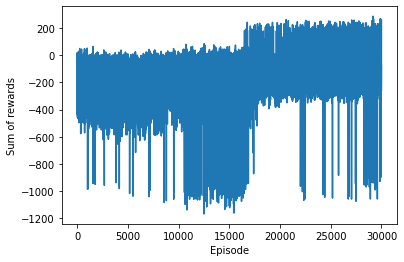

In [24]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.show()

In [28]:
(anim, data) = display_run(NN_action)
print("Reward:", sum(data[0]), ",  Steps:", len(data[0]))
anim

Reward: -273.0061753203438 ,  Steps: 156


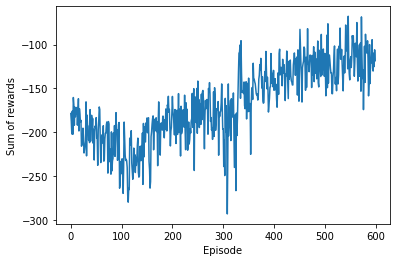

In [31]:
plt.plot([np.mean([rewards[50 * j + i] for i in range(50)]) for j in range(600)])
plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.show()


In [27]:
# Log after 300: Rewards still around -200 to -100; but down to minus 300 crashes down to ground fairly quickly

#+150 traininng iterations, now penalizing with only step/100; also scaling the observations down to 0 - 1
#Now, rewards around -120, flies up and away

#Completely restarted, set penalty to kick in only after 500 steps

For math:
    Several actions, such as: Prove new things, make a definition, make a conjecture.
    
Making a definition: Useful, e.g. when it can be used to simplify existing proofs/ compress a theory
    
Prove new things: 

SyntaxError: invalid syntax (1195195416.py, line 8)